# Duplicate Bug Report Detection

## Résumé / Overview

En raison de la complexité des systèmes logiciels, les bogues logiciels sont répandus. Les entreprises, en particulier les grandes, utilisent généralement un système de suivi des bogues (BTS), également appelé système de suivi des problèmes, pour gérer et suivre les enregistrements des bogues. Outre les développeurs et les testeurs, de nombreux projets, principalement des projets open source, permettent aux utilisateurs de signaler de nouveaux bogues dans leur BTS. Pour ce faire, les utilisateurs doivent remplir un formulaire avec plusieurs champs. Un sous-ensemble important de ces champs fournissent des données catégorielles et n'acceptent que les valeurs qui vont d'une liste fixe d’options (par exemple, composant, version et produit du système). Deux autres domaines importants sont le résumé et la description. Les utilisateurs sont libres d'écrire quoi que ce soit dans les deux champs et la seule contrainte est que le résumé a un nombre maximum de caractères. La soumission d'un formulaire crée une page, appelée rapport de bogue ou rapport de problème, qui contient toutes les informations sur un bogue.

En raison du manque de communication et de synchronisation, les utilisateurs peuvent ne pas savoir qu'un bogue spécifique a déjà été soumis et le signaler à nouveau. Identifier les rapports de bogues en double est une tâche importante dans les BTS. Fondamentalement, notre objectif est de développer un système qui comparera un nouveau rapport de bogue avec ceux soumis et les classera en fonction de la similitude textuelle. Cette liste classée sera utilisée par un trieur pour identifier manuellement si un rapport est dupliqué ou non.

---

Due to complexities of software systems, software bugs are prevalent. Companies, especially large ones, usually use a Bug Tracking System (BTS), also called Issue Tracking System, to manage and track records of bugs. Besides developers and testers, many projects, mainly open source projects, allow users to report new bugs in their BTS. To do that, users have to fill a form with multiple fields. An important subset of these fields provides categorical data and only accepts values that range from a fixed list of options (e.g., component, version and product of the system). Another two important fields are the summary and the description. The users are free to write anything in both fields and the only constraint is that the summary has a maximum number of characters. The submission of a form creates a page, called bug report or issue report, which contains all the information about a bug.

Due to the lack of communication and syncronization, users may not be aware that a specific bug was already submitted and report it again. Identifying duplicate bug reports is important task in the BTSs. Basically, our goal is to develop a system that will compare a new bug report with the submitted ones and rank them based on textual similarity. This ranked list will be used by a triager to manually identify whether a report is duplciate or not

## 2 - Installation

Nous aurons besoin des librairies `numpy`, `sklearn` et `scipy`, ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP)

---
We will need `numpy`, `sklearn`, `scipy` and `nltk`.

## 3 - Jeu de données / Dataset

L'archive contient:
1. test.json: Ce fichier contient les duplicate bug reports qui vont être utilisés pour évaluer notre système.
2. threads: Ce dossier contient le code HTML des bug reports. Chaque fichier HTML est nommé selon le motif **bug_report_id.html**.

Un exemple de bug report:
- A : identifiant du bug report
- B : date de création
- C : résumé
- D : composant
- E : produit
- F : l'identifiant du rapport dont le bug report est dupliqué
- G : description

---

In this zip file:
1. test.json: This file contains duplicate bug reports that will be used to evaluate our system.
2. bug_reports: It is a folder that contains the bug report html source. Each html file name follows the pattern **bug_report_id.html**.

an bug report page example:
- A : bug report id
- B : creation date
- C : summary
- D : component
- E : product
- F : the report id which the bug report is duplicate
- G : description

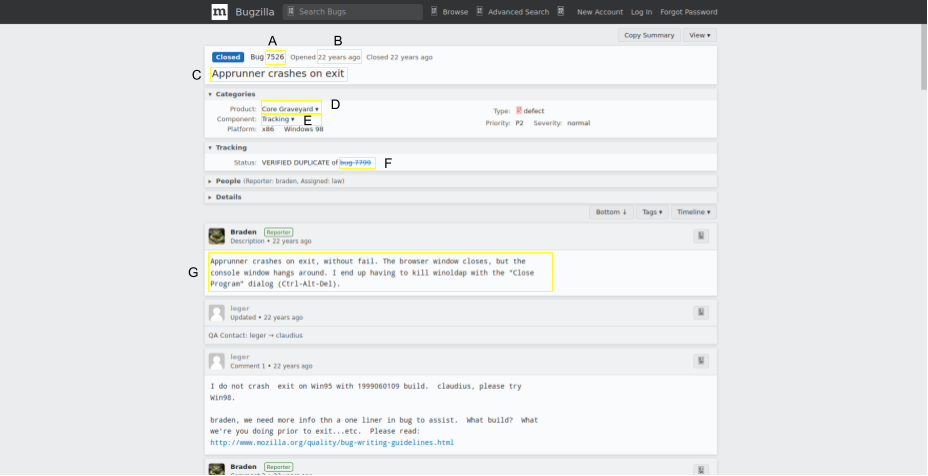

In [1]:
from IPython import display
display.Image("https://irving-muller.github.io/images/bug-report.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [24]:
import os
# changer cwd basé sur environnement
os.chdir("/content/drive/MyDrive/projectnz/")
# print("Current working directory is:", os.getcwd())

In [26]:

# define the folder path that contain the data
# FOLDER_PATH = "Define folder path that contain threads folder and test.json"
FOLDER_PATH = "dataset/"
PAGE_FOLDER = os.path.join(FOLDER_PATH, 'bug_reports')

# Load the evaluation dataset
import json
test = json.load(open(os.path.join(FOLDER_PATH, "test.json")))

print(len(test), test[:5])

250 [[2113, [1699, 2079]], [5556, [6055]], [3048, [2208, 3049, 2346, 2345, 3163, 3007]], [4687, [3921]], [8005, [8002]]]


# 4 - Web scraping



## 4.1 - Extraire les données du HTML / Extract data from page

La fonction *extract_data_from_page* extrait les informations suivantes du code HTML et elle retourne un dictionnaire avec la structure suivante:

---

This function extracts the following information from the html, and it returns the following:

```python
 {"report_id": int,
  "dup_id": int or None (the report id which it is duplicate),
  "component": string,
  "product": string,
  "summary": str,
  "description": string,
  "creation_date": int}
```

Par exemple, pour le bug report "bug_report/7526.html", la fonction *extract_data_from_page* retourne:

---
For example, for the bug report "bug_report/7526.html", the function  *extract_data_from_page* returns:

```python
 {"report_id": 7526,
  "dup_id": 7799,
  "product": "core graveyard",
  "component":  tracking,
  "summary": "Apprunner crashes on exit",
  "description": "Apprunner crashes on exit, without fail. The browser window closes, but the console window hangs around. I end up having to kill winoldap with the \"Close Program\" dialog (Ctrl-Alt-Del).",
  "creation_date": 928396140}
```

**La date de création doit être représentée sous la forme d'un timestamp. Si un bug report n'est pas un duplicat, alors dup_id doit être None.**

---
**Creation date must be represented as timestamp. If bug report is not duplicate, dup_id must be None.**

In [15]:
import codecs
from bs4 import BeautifulSoup
import re

In [16]:
def extract_data_from_page(pagepath):
    """
    Scrap bug report content from bug report html.

    :param pagepath: the path of html file.
    :return:
        {
        "report_id": int,
        "dup_id": int or None (the report id which it is duplicate),
        "component": string,
        "product": string,
        "summary": str,
        "description": string,
        "creation_date": int
        }
    """
    print(pagepath, "\n")
    website_url = codecs.open(pagepath)
    soup = BeautifulSoup(website_url, 'lxml')

    # report_id
    bug_id = soup.find('span', {'id':'field-value-bug_id'})
    report_id = int(bug_id.find('a').get_text().split()[1])

    # dup_id
    tracking = soup.find('section', {'class':'module', "id":"module-tracking"})
    status_view = tracking.find("span", {"id":"field-value-status-view" })
    status = status_view.get_text()
    m = re.search(r"(?P<dupid>[0-9]+)", status)
    dup_id = None if m == None else int(m.group("dupid"))

    # component
    comp = soup.find("span", {"id":"component-name"})
    component = comp.getText().strip().split("\n")[0]

    # product
    prod_name = soup.find("span", {"id":"product-name"})
    product = prod_name.getText().strip().split("\n")[0]

    # summary:
    summary_container = soup.find(id="summary-container")
    heading = summary_container.find("h1")
    summary = heading.getText()

    # description
    description = soup.find(id="ct-0").getText()

    # creation_date
    fv_status = soup.find(id="field-value-status_summary")
    time_labels = fv_status.find_all("span", {"class":"bug-time-label"})
    for dt in time_labels:
      if list(dt.children)[0].strip() == "Opened":
        creation_date = int(dt.find("span")["data-time"])

    result = {"report_id": report_id,
          "dup_id": dup_id,
          "component": component,
          "product": product,
          "summary": summary,
          "description": description,
          "creation_date": creation_date}
    return result


## 4.2 - Extraire le texte du code HTML / Extract text from HTML

In [17]:
import os
from multiprocessing import Pool, TimeoutError
from time import time
import json
import tqdm

# Index each thread by its id
index_path = os.path.join(PAGE_FOLDER, 'bug_reports.json')

if os.path.isfile(index_path):
    # Load threads that webpage content were already extracted.
    report_index = json.load(open(index_path))
else:
    # Extract webpage content

    # This can be slow (around 10 minutes). Test your code with a small sample. lxml parse is faster than html.parser
    files = [os.path.join(PAGE_FOLDER, filename) for filename in os.listdir(PAGE_FOLDER)]
    reports = [extract_data_from_page(f) for f in tqdm.tqdm(files)]
    report_index = dict(((report['report_id'], report) for report in reports ))

    # Save preprocessed bug reports
    json.dump(report_index, open(index_path,'w'))


  0%|          | 0/9998 [00:00<?, ?it/s]

dataset/bug_reports/1926.html 



  0%|          | 1/9998 [00:00<2:33:57,  1.08it/s]

dataset/bug_reports/5256.html 



  0%|          | 2/9998 [00:01<1:35:05,  1.75it/s]

dataset/bug_reports/4370.html 



  0%|          | 3/9998 [00:01<1:12:28,  2.30it/s]

dataset/bug_reports/4327.html 



  0%|          | 4/9998 [00:01<1:05:16,  2.55it/s]

dataset/bug_reports/8741.html 



  0%|          | 5/9998 [00:02<1:01:34,  2.70it/s]

dataset/bug_reports/10171.html 



  0%|          | 6/9998 [00:02<59:32,  2.80it/s]  

dataset/bug_reports/118.html 



  0%|          | 7/9998 [00:02<57:29,  2.90it/s]

dataset/bug_reports/10248.html 



  0%|          | 8/9998 [00:03<58:09,  2.86it/s]

dataset/bug_reports/1259.html 



  0%|          | 9/9998 [00:03<1:02:06,  2.68it/s]

dataset/bug_reports/1672.html 



  0%|          | 10/9998 [00:03<1:00:23,  2.76it/s]

dataset/bug_reports/880.html 



  0%|          | 11/9998 [00:04<55:38,  2.99it/s]  

dataset/bug_reports/9223.html 



  0%|          | 12/9998 [00:04<54:24,  3.06it/s]

dataset/bug_reports/4800.html 



  0%|          | 13/9998 [00:04<49:41,  3.35it/s]

dataset/bug_reports/10072.html 



  0%|          | 14/9998 [00:05<51:11,  3.25it/s]

dataset/bug_reports/8308.html 



  0%|          | 15/9998 [00:05<52:24,  3.18it/s]

dataset/bug_reports/7219.html 



  0%|          | 16/9998 [00:05<52:53,  3.15it/s]

dataset/bug_reports/2504.html 



  0%|          | 17/9998 [00:06<54:51,  3.03it/s]

dataset/bug_reports/3801.html 



  0%|          | 18/9998 [00:06<51:43,  3.22it/s]

dataset/bug_reports/3942.html 



  0%|          | 19/9998 [00:06<57:27,  2.89it/s]

dataset/bug_reports/5447.html 



  0%|          | 20/9998 [00:07<56:26,  2.95it/s]

dataset/bug_reports/2906.html 



  0%|          | 21/9998 [00:07<56:59,  2.92it/s]

dataset/bug_reports/6127.html 



  0%|          | 22/9998 [00:07<1:04:51,  2.56it/s]

dataset/bug_reports/2683.html 



  0%|          | 23/9998 [00:08<1:05:45,  2.53it/s]

dataset/bug_reports/8460.html 



  0%|          | 24/9998 [00:08<1:00:56,  2.73it/s]

dataset/bug_reports/8192.html 



  0%|          | 25/9998 [00:08<57:17,  2.90it/s]  

dataset/bug_reports/4543.html 



  0%|          | 26/9998 [00:09<54:18,  3.06it/s]

dataset/bug_reports/8186.html 



  0%|          | 27/9998 [00:09<55:23,  3.00it/s]

dataset/bug_reports/3594.html 



  0%|          | 28/9998 [00:09<52:04,  3.19it/s]

dataset/bug_reports/6445.html 



  0%|          | 29/9998 [00:10<49:19,  3.37it/s]

dataset/bug_reports/5694.html 



  0%|          | 30/9998 [00:10<45:22,  3.66it/s]

dataset/bug_reports/6186.html 



  0%|          | 31/9998 [00:10<55:09,  3.01it/s]

dataset/bug_reports/4970.html 



  0%|          | 32/9998 [00:11<55:29,  2.99it/s]

dataset/bug_reports/8438.html 



  0%|          | 33/9998 [00:11<52:14,  3.18it/s]

dataset/bug_reports/5811.html 



  0%|          | 34/9998 [00:11<52:44,  3.15it/s]

dataset/bug_reports/8015.html 



  0%|          | 35/9998 [00:12<53:44,  3.09it/s]

dataset/bug_reports/10134.html 



  0%|          | 36/9998 [00:12<50:46,  3.27it/s]

dataset/bug_reports/2969.html 



  0%|          | 37/9998 [00:12<49:14,  3.37it/s]

dataset/bug_reports/8697.html 



  0%|          | 38/9998 [00:12<49:53,  3.33it/s]

dataset/bug_reports/513.html 



  0%|          | 39/9998 [00:13<49:28,  3.35it/s]

dataset/bug_reports/3830.html 



  0%|          | 40/9998 [00:13<47:12,  3.52it/s]

dataset/bug_reports/7350.html 



  0%|          | 41/9998 [00:13<45:43,  3.63it/s]

dataset/bug_reports/4058.html 



  0%|          | 42/9998 [00:13<44:16,  3.75it/s]

dataset/bug_reports/5166.html 



  0%|          | 43/9998 [00:14<49:12,  3.37it/s]

dataset/bug_reports/7198.html 



  0%|          | 44/9998 [00:14<45:54,  3.61it/s]

dataset/bug_reports/3498.html 



  0%|          | 45/9998 [00:14<43:18,  3.83it/s]

dataset/bug_reports/4036.html 



  0%|          | 46/9998 [00:15<42:44,  3.88it/s]

dataset/bug_reports/175.html 



  0%|          | 47/9998 [00:15<44:16,  3.75it/s]

dataset/bug_reports/7832.html 



  0%|          | 48/9998 [00:15<43:54,  3.78it/s]

dataset/bug_reports/2345.html 



  0%|          | 49/9998 [00:15<41:38,  3.98it/s]

dataset/bug_reports/2167.html 



  1%|          | 50/9998 [00:16<42:02,  3.94it/s]

dataset/bug_reports/10145.html 



  1%|          | 51/9998 [00:16<45:36,  3.63it/s]

dataset/bug_reports/7032.html 



  1%|          | 52/9998 [00:16<48:44,  3.40it/s]

dataset/bug_reports/1648.html 



  1%|          | 53/9998 [00:16<46:06,  3.59it/s]

dataset/bug_reports/3133.html 



  1%|          | 54/9998 [00:17<52:07,  3.18it/s]

dataset/bug_reports/2624.html 



  1%|          | 55/9998 [00:17<52:53,  3.13it/s]

dataset/bug_reports/3280.html 



  1%|          | 56/9998 [00:18<57:38,  2.87it/s]

dataset/bug_reports/9967.html 



  1%|          | 57/9998 [00:18<56:08,  2.95it/s]

dataset/bug_reports/7140.html 



  1%|          | 58/9998 [00:18<54:35,  3.03it/s]

dataset/bug_reports/5482.html 



  1%|          | 59/9998 [00:19<50:35,  3.27it/s]

dataset/bug_reports/3097.html 



  1%|          | 60/9998 [00:19<50:07,  3.30it/s]

dataset/bug_reports/5497.html 



  1%|          | 61/9998 [00:19<51:34,  3.21it/s]

dataset/bug_reports/7691.html 



  1%|          | 62/9998 [00:19<53:12,  3.11it/s]

dataset/bug_reports/3314.html 



  1%|          | 63/9998 [00:20<51:56,  3.19it/s]

dataset/bug_reports/5157.html 



  1%|          | 64/9998 [00:20<50:18,  3.29it/s]

dataset/bug_reports/6732.html 



  1%|          | 65/9998 [00:20<49:35,  3.34it/s]

dataset/bug_reports/6834.html 



  1%|          | 66/9998 [00:21<50:22,  3.29it/s]

dataset/bug_reports/5734.html 



  1%|          | 67/9998 [00:21<1:00:17,  2.75it/s]

dataset/bug_reports/7676.html 



  1%|          | 68/9998 [00:21<56:57,  2.91it/s]  

dataset/bug_reports/4365.html 



  1%|          | 69/9998 [00:22<53:51,  3.07it/s]

dataset/bug_reports/1296.html 



  1%|          | 70/9998 [00:22<50:44,  3.26it/s]

dataset/bug_reports/9502.html 



  1%|          | 71/9998 [00:22<52:51,  3.13it/s]

dataset/bug_reports/3761.html 



  1%|          | 72/9998 [00:23<50:54,  3.25it/s]

dataset/bug_reports/6994.html 



  1%|          | 73/9998 [00:23<50:43,  3.26it/s]

dataset/bug_reports/4683.html 



  1%|          | 74/9998 [00:23<49:07,  3.37it/s]

dataset/bug_reports/5042.html 



  1%|          | 75/9998 [00:23<48:08,  3.44it/s]

dataset/bug_reports/9830.html 



  1%|          | 76/9998 [00:24<46:06,  3.59it/s]

dataset/bug_reports/3807.html 



  1%|          | 77/9998 [00:24<48:18,  3.42it/s]

dataset/bug_reports/9947.html 



  1%|          | 78/9998 [00:24<47:04,  3.51it/s]

dataset/bug_reports/10037.html 



  1%|          | 79/9998 [00:25<54:30,  3.03it/s]

dataset/bug_reports/4159.html 



  1%|          | 80/9998 [00:25<51:02,  3.24it/s]

dataset/bug_reports/741.html 



  1%|          | 81/9998 [00:25<51:04,  3.24it/s]

dataset/bug_reports/4943.html 



  1%|          | 82/9998 [00:26<48:59,  3.37it/s]

dataset/bug_reports/1148.html 



  1%|          | 83/9998 [00:26<47:23,  3.49it/s]

dataset/bug_reports/6592.html 



  1%|          | 84/9998 [00:26<44:36,  3.70it/s]

dataset/bug_reports/176.html 



  1%|          | 85/9998 [00:26<44:23,  3.72it/s]

dataset/bug_reports/9868.html 



  1%|          | 86/9998 [00:27<45:28,  3.63it/s]

dataset/bug_reports/3687.html 



  1%|          | 87/9998 [00:27<46:45,  3.53it/s]

dataset/bug_reports/7167.html 



  1%|          | 88/9998 [00:27<44:50,  3.68it/s]

dataset/bug_reports/2543.html 



  1%|          | 89/9998 [00:27<43:21,  3.81it/s]

dataset/bug_reports/8051.html 



  1%|          | 90/9998 [00:28<44:49,  3.68it/s]

dataset/bug_reports/1959.html 



  1%|          | 91/9998 [00:28<51:49,  3.19it/s]

dataset/bug_reports/7845.html 



  1%|          | 92/9998 [00:29<53:52,  3.06it/s]

dataset/bug_reports/4386.html 



  1%|          | 93/9998 [00:29<51:58,  3.18it/s]

dataset/bug_reports/8295.html 



  1%|          | 94/9998 [00:29<49:27,  3.34it/s]

dataset/bug_reports/3742.html 



  1%|          | 95/9998 [00:29<49:11,  3.36it/s]

dataset/bug_reports/9054.html 



  1%|          | 96/9998 [00:30<47:59,  3.44it/s]

dataset/bug_reports/5384.html 



  1%|          | 97/9998 [00:30<47:55,  3.44it/s]

dataset/bug_reports/9974.html 



  1%|          | 98/9998 [00:30<47:19,  3.49it/s]

dataset/bug_reports/9694.html 



  1%|          | 99/9998 [00:30<47:14,  3.49it/s]

dataset/bug_reports/817.html 



  1%|          | 100/9998 [00:31<51:59,  3.17it/s]

dataset/bug_reports/2275.html 



  1%|          | 101/9998 [00:52<18:11:18,  6.62s/it]

dataset/bug_reports/8474.html 



  1%|          | 102/9998 [01:20<35:20:05, 12.85s/it]

dataset/bug_reports/2059.html 



  1%|          | 103/9998 [02:13<68:50:12, 25.04s/it]

dataset/bug_reports/6552.html 



  1%|          | 104/9998 [02:17<51:42:04, 18.81s/it]

dataset/bug_reports/8828.html 



  1%|          | 105/9998 [03:11<80:15:14, 29.20s/it]

dataset/bug_reports/4007.html 



  1%|          | 106/9998 [03:21<64:35:33, 23.51s/it]

dataset/bug_reports/8656.html 



  1%|          | 107/9998 [04:02<78:42:29, 28.65s/it]

dataset/bug_reports/6801.html 



  1%|          | 108/9998 [04:44<90:23:29, 32.90s/it]

dataset/bug_reports/121.html 



  1%|          | 109/9998 [04:52<69:15:27, 25.21s/it]

dataset/bug_reports/2706.html 



  1%|          | 110/9998 [04:52<48:43:29, 17.74s/it]

dataset/bug_reports/602.html 



  1%|          | 112/9998 [04:53<24:18:48,  8.85s/it]

dataset/bug_reports/2524.html 

dataset/bug_reports/3774.html 



  1%|          | 114/9998 [04:53<12:07:20,  4.42s/it]

dataset/bug_reports/9724.html 

dataset/bug_reports/8102.html 



  1%|          | 115/9998 [04:53<8:36:08,  3.13s/it] 

dataset/bug_reports/2451.html 



  1%|          | 117/9998 [04:54<4:37:48,  1.69s/it]

dataset/bug_reports/2401.html 

dataset/bug_reports/607.html 



  1%|          | 119/9998 [04:54<2:26:59,  1.12it/s]

dataset/bug_reports/2094.html 

dataset/bug_reports/3859.html 



  1%|          | 121/9998 [04:54<1:27:18,  1.89it/s]

dataset/bug_reports/2117.html 

dataset/bug_reports/3426.html 



  1%|          | 123/9998 [04:55<55:28,  2.97it/s]  

dataset/bug_reports/3000.html 

dataset/bug_reports/5192.html 



  1%|▏         | 125/9998 [04:55<37:22,  4.40it/s]

dataset/bug_reports/8465.html 

dataset/bug_reports/1423.html 



  1%|▏         | 127/9998 [04:55<36:24,  4.52it/s]

dataset/bug_reports/6968.html 

dataset/bug_reports/2513.html 



  1%|▏         | 129/9998 [04:56<28:23,  5.79it/s]

dataset/bug_reports/7045.html 

dataset/bug_reports/7023.html 



  1%|▏         | 131/9998 [04:56<24:28,  6.72it/s]

dataset/bug_reports/3892.html 

dataset/bug_reports/9500.html 



  1%|▏         | 133/9998 [04:56<24:53,  6.61it/s]

dataset/bug_reports/5399.html 

dataset/bug_reports/2505.html 



  1%|▏         | 135/9998 [04:56<21:47,  7.54it/s]

dataset/bug_reports/2323.html 

dataset/bug_reports/9400.html 



  1%|▏         | 137/9998 [04:57<27:12,  6.04it/s]

dataset/bug_reports/8353.html 

dataset/bug_reports/5903.html 



  1%|▏         | 138/9998 [04:57<24:24,  6.73it/s]

dataset/bug_reports/8018.html 

dataset/bug_reports/5105.html 



  1%|▏         | 140/9998 [04:57<22:39,  7.25it/s]

dataset/bug_reports/9394.html 

dataset/bug_reports/4143.html 



  1%|▏         | 144/9998 [04:58<18:52,  8.70it/s]

dataset/bug_reports/201.html 

dataset/bug_reports/5072.html 

dataset/bug_reports/5381.html 



  1%|▏         | 146/9998 [04:58<19:01,  8.63it/s]

dataset/bug_reports/8861.html 

dataset/bug_reports/6382.html 



  1%|▏         | 147/9998 [04:58<28:20,  5.79it/s]

dataset/bug_reports/1079.html 

dataset/bug_reports/5682.html 



  2%|▏         | 150/9998 [04:59<22:45,  7.21it/s]

dataset/bug_reports/3708.html 

dataset/bug_reports/1132.html 



  2%|▏         | 153/9998 [04:59<18:57,  8.66it/s]

dataset/bug_reports/136.html 

dataset/bug_reports/5282.html 

dataset/bug_reports/9652.html 



  2%|▏         | 155/9998 [04:59<16:54,  9.70it/s]

dataset/bug_reports/10182.html 

dataset/bug_reports/897.html 

dataset/bug_reports/1125.html 



  2%|▏         | 159/9998 [04:59<14:53, 11.02it/s]

dataset/bug_reports/5699.html 

dataset/bug_reports/1019.html 

dataset/bug_reports/4927.html 



  2%|▏         | 161/9998 [05:00<21:13,  7.72it/s]

dataset/bug_reports/7646.html 

dataset/bug_reports/955.html 

dataset/bug_reports/4858.html 



  2%|▏         | 165/9998 [05:00<15:43, 10.43it/s]

dataset/bug_reports/5878.html 

dataset/bug_reports/6133.html 

dataset/bug_reports/8872.html 

dataset/bug_reports/4437.html 



  2%|▏         | 169/9998 [05:00<12:10, 13.45it/s]

dataset/bug_reports/7707.html 

dataset/bug_reports/2731.html 

dataset/bug_reports/5567.html 



  2%|▏         | 173/9998 [05:01<12:45, 12.84it/s]

dataset/bug_reports/4827.html 

dataset/bug_reports/1227.html 

dataset/bug_reports/1863.html 

dataset/bug_reports/5729.html 



  2%|▏         | 177/9998 [05:01<10:59, 14.89it/s]

dataset/bug_reports/6840.html 

dataset/bug_reports/432.html 

dataset/bug_reports/6735.html 

dataset/bug_reports/5203.html 



  2%|▏         | 179/9998 [05:01<10:49, 15.11it/s]

dataset/bug_reports/1002.html 

dataset/bug_reports/10180.html 



  2%|▏         | 184/9998 [05:01<10:58, 14.91it/s]

dataset/bug_reports/7785.html 

dataset/bug_reports/3697.html 

dataset/bug_reports/9376.html 

dataset/bug_reports/10165.html 

dataset/bug_reports/6507.html 



  2%|▏         | 189/9998 [05:02<09:19, 17.53it/s]

dataset/bug_reports/6959.html 

dataset/bug_reports/5728.html 

dataset/bug_reports/2780.html 

dataset/bug_reports/7685.html 

dataset/bug_reports/3703.html 



  2%|▏         | 192/9998 [05:02<08:57, 18.23it/s]

dataset/bug_reports/7680.html 

dataset/bug_reports/8475.html 

dataset/bug_reports/1385.html 



  2%|▏         | 197/9998 [05:02<10:20, 15.79it/s]

dataset/bug_reports/1347.html 

dataset/bug_reports/6151.html 

dataset/bug_reports/948.html 

dataset/bug_reports/5357.html 

dataset/bug_reports/3080.html 



  2%|▏         | 200/9998 [05:02<10:05, 16.17it/s]

dataset/bug_reports/4104.html 

dataset/bug_reports/8136.html 

dataset/bug_reports/637.html 

dataset/bug_reports/7549.html 



  2%|▏         | 202/9998 [05:02<09:54, 16.47it/s]

dataset/bug_reports/2515.html 

dataset/bug_reports/9190.html 



  2%|▏         | 206/9998 [05:03<12:19, 13.24it/s]

dataset/bug_reports/2503.html 

dataset/bug_reports/6104.html 

dataset/bug_reports/5953.html 

dataset/bug_reports/3618.html 



  2%|▏         | 211/9998 [05:03<10:46, 15.13it/s]

dataset/bug_reports/8405.html 

dataset/bug_reports/8568.html 

dataset/bug_reports/2996.html 

dataset/bug_reports/6872.html 



  2%|▏         | 213/9998 [05:03<11:13, 14.52it/s]

dataset/bug_reports/6225.html 

dataset/bug_reports/5820.html 



  2%|▏         | 218/9998 [05:04<11:37, 14.02it/s]

dataset/bug_reports/7565.html 

dataset/bug_reports/7643.html 

dataset/bug_reports/5041.html 

dataset/bug_reports/7661.html 

dataset/bug_reports/6984.html 



  2%|▏         | 222/9998 [05:04<10:26, 15.60it/s]

dataset/bug_reports/5573.html 

dataset/bug_reports/8609.html 

dataset/bug_reports/9575.html 

dataset/bug_reports/4394.html 



  2%|▏         | 224/9998 [05:04<09:55, 16.40it/s]

dataset/bug_reports/7576.html 

dataset/bug_reports/7090.html 



  2%|▏         | 226/9998 [05:04<13:25, 12.13it/s]

dataset/bug_reports/9836.html 

dataset/bug_reports/3690.html 

dataset/bug_reports/4204.html 



  2%|▏         | 231/9998 [05:05<11:07, 14.64it/s]

dataset/bug_reports/3234.html 

dataset/bug_reports/297.html 

dataset/bug_reports/4505.html 

dataset/bug_reports/3014.html 

dataset/bug_reports/2815.html 



  2%|▏         | 235/9998 [05:05<10:04, 16.16it/s]

dataset/bug_reports/902.html 

dataset/bug_reports/1210.html 

dataset/bug_reports/3276.html 



  2%|▏         | 239/9998 [05:05<12:15, 13.27it/s]

dataset/bug_reports/7435.html 

dataset/bug_reports/7820.html 

dataset/bug_reports/10128.html 

dataset/bug_reports/3683.html 



  2%|▏         | 243/9998 [05:05<10:46, 15.09it/s]

dataset/bug_reports/6153.html 

dataset/bug_reports/5228.html 

dataset/bug_reports/3903.html 

dataset/bug_reports/5928.html 



  2%|▏         | 245/9998 [05:05<10:14, 15.86it/s]

dataset/bug_reports/387.html 

dataset/bug_reports/10152.html 

dataset/bug_reports/1170.html 



  3%|▎         | 250/9998 [05:06<10:46, 15.08it/s]

dataset/bug_reports/5655.html 

dataset/bug_reports/10224.html 

dataset/bug_reports/9856.html 

dataset/bug_reports/6565.html 



  3%|▎         | 255/9998 [05:06<09:36, 16.90it/s]

dataset/bug_reports/9579.html 

dataset/bug_reports/9867.html 

dataset/bug_reports/5235.html 

dataset/bug_reports/4898.html 

dataset/bug_reports/10137.html 



  3%|▎         | 257/9998 [05:06<09:14, 17.58it/s]

dataset/bug_reports/9037.html 

dataset/bug_reports/588.html 



  3%|▎         | 259/9998 [05:07<14:09, 11.47it/s]

dataset/bug_reports/7234.html 

dataset/bug_reports/4991.html 

dataset/bug_reports/2493.html 

dataset/bug_reports/5593.html 



  3%|▎         | 264/9998 [05:07<11:22, 14.27it/s]

dataset/bug_reports/2805.html 

dataset/bug_reports/2665.html 

dataset/bug_reports/9176.html 

dataset/bug_reports/4691.html 



  3%|▎         | 266/9998 [05:07<10:50, 14.97it/s]

dataset/bug_reports/1399.html 



  3%|▎         | 271/9998 [05:07<11:43, 13.82it/s]

dataset/bug_reports/4629.html 

dataset/bug_reports/1029.html 

dataset/bug_reports/860.html 

dataset/bug_reports/2331.html 

dataset/bug_reports/4650.html 



  3%|▎         | 273/9998 [05:08<12:09, 13.34it/s]

dataset/bug_reports/9472.html 

dataset/bug_reports/4141.html 

dataset/bug_reports/9682.html 



  3%|▎         | 275/9998 [05:08<11:11, 14.47it/s]

dataset/bug_reports/6576.html 

dataset/bug_reports/3417.html 

dataset/bug_reports/3847.html 



  3%|▎         | 280/9998 [05:08<11:48, 13.71it/s]

dataset/bug_reports/3084.html 

dataset/bug_reports/7034.html 

dataset/bug_reports/557.html 

dataset/bug_reports/6795.html 



  3%|▎         | 285/9998 [05:08<09:55, 16.32it/s]

dataset/bug_reports/5391.html 

dataset/bug_reports/1722.html 

dataset/bug_reports/1209.html 

dataset/bug_reports/7554.html 



  3%|▎         | 289/9998 [05:09<09:24, 17.21it/s]

dataset/bug_reports/3309.html 

dataset/bug_reports/8693.html 

dataset/bug_reports/2144.html 

dataset/bug_reports/6720.html 



  3%|▎         | 293/9998 [05:09<11:31, 14.03it/s]

dataset/bug_reports/1518.html 

dataset/bug_reports/542.html 

dataset/bug_reports/669.html 

dataset/bug_reports/5102.html 



  3%|▎         | 295/9998 [05:09<12:10, 13.29it/s]

dataset/bug_reports/2603.html 

dataset/bug_reports/3102.html 

dataset/bug_reports/5775.html 



  3%|▎         | 299/9998 [05:09<13:49, 11.69it/s]

dataset/bug_reports/2975.html 

dataset/bug_reports/9512.html 

dataset/bug_reports/8450.html 



  3%|▎         | 301/9998 [05:10<14:02, 11.51it/s]

dataset/bug_reports/3256.html 

dataset/bug_reports/7431.html 



  3%|▎         | 303/9998 [05:10<18:38,  8.66it/s]

dataset/bug_reports/1599.html 

dataset/bug_reports/8627.html 

dataset/bug_reports/3269.html 



  3%|▎         | 307/9998 [05:10<15:40, 10.31it/s]

dataset/bug_reports/5405.html 

dataset/bug_reports/3481.html 

dataset/bug_reports/5076.html 



  3%|▎         | 309/9998 [05:10<14:39, 11.01it/s]

dataset/bug_reports/3637.html 

dataset/bug_reports/2246.html 

dataset/bug_reports/8077.html 



  3%|▎         | 311/9998 [05:11<14:51, 10.86it/s]

dataset/bug_reports/4507.html 

dataset/bug_reports/5706.html 



  3%|▎         | 315/9998 [05:11<17:14,  9.36it/s]

dataset/bug_reports/4160.html 

dataset/bug_reports/7058.html 

dataset/bug_reports/8589.html 



  3%|▎         | 318/9998 [05:12<22:00,  7.33it/s]

dataset/bug_reports/7250.html 

dataset/bug_reports/1848.html 

dataset/bug_reports/9000.html 



  3%|▎         | 321/9998 [05:12<21:26,  7.52it/s]

dataset/bug_reports/2957.html 

dataset/bug_reports/3434.html 

dataset/bug_reports/8064.html 



  3%|▎         | 323/9998 [05:12<18:44,  8.60it/s]

dataset/bug_reports/5697.html 

dataset/bug_reports/2150.html 



  3%|▎         | 325/9998 [05:13<18:16,  8.82it/s]

dataset/bug_reports/1353.html 

dataset/bug_reports/7578.html 

dataset/bug_reports/8892.html 



  3%|▎         | 329/9998 [05:13<15:38, 10.31it/s]

dataset/bug_reports/5310.html 

dataset/bug_reports/3073.html 

dataset/bug_reports/1841.html 

dataset/bug_reports/941.html 



  3%|▎         | 332/9998 [05:13<20:41,  7.78it/s]

dataset/bug_reports/2418.html 

dataset/bug_reports/5424.html 



  3%|▎         | 334/9998 [05:14<18:48,  8.56it/s]

dataset/bug_reports/2686.html 

dataset/bug_reports/9131.html 



  3%|▎         | 337/9998 [05:14<17:13,  9.35it/s]

dataset/bug_reports/9060.html 

dataset/bug_reports/1840.html 

dataset/bug_reports/7236.html 



  3%|▎         | 339/9998 [05:14<16:02, 10.04it/s]

dataset/bug_reports/1011.html 

dataset/bug_reports/5821.html 



  3%|▎         | 343/9998 [05:15<16:46,  9.59it/s]

dataset/bug_reports/5747.html 

dataset/bug_reports/3704.html 

dataset/bug_reports/6775.html 

dataset/bug_reports/4776.html 



  3%|▎         | 347/9998 [05:15<12:46, 12.59it/s]

dataset/bug_reports/3456.html 

dataset/bug_reports/6296.html 

dataset/bug_reports/2616.html 

dataset/bug_reports/9298.html 

dataset/bug_reports/3967.html 

dataset/bug_reports/3600.html 



  4%|▎         | 353/9998 [05:15<12:22, 13.00it/s]

dataset/bug_reports/2714.html 

dataset/bug_reports/10151.html 

dataset/bug_reports/8476.html 

dataset/bug_reports/3729.html 



  4%|▎         | 357/9998 [05:15<11:11, 14.35it/s]

dataset/bug_reports/8410.html 

dataset/bug_reports/937.html 

dataset/bug_reports/2778.html 

dataset/bug_reports/7365.html 



  4%|▎         | 359/9998 [05:16<11:06, 14.46it/s]

dataset/bug_reports/3890.html 

dataset/bug_reports/1725.html 



  4%|▎         | 363/9998 [05:16<12:50, 12.51it/s]

dataset/bug_reports/6773.html 

dataset/bug_reports/5067.html 

dataset/bug_reports/2486.html 

dataset/bug_reports/2779.html 



  4%|▎         | 367/9998 [05:16<11:37, 13.81it/s]

dataset/bug_reports/4431.html 

dataset/bug_reports/8912.html 

dataset/bug_reports/4079.html 

dataset/bug_reports/4352.html 

dataset/bug_reports/5239.html 



  4%|▎         | 371/9998 [05:17<12:52, 12.46it/s]

dataset/bug_reports/8493.html 

dataset/bug_reports/2962.html 

dataset/bug_reports/2419.html 

dataset/bug_reports/4626.html 



  4%|▍         | 376/9998 [05:17<10:01, 16.01it/s]

dataset/bug_reports/908.html 

dataset/bug_reports/3948.html 

dataset/bug_reports/260.html 

dataset/bug_reports/5566.html 

dataset/bug_reports/6601.html 



  4%|▍         | 378/9998 [05:17<09:45, 16.44it/s]

dataset/bug_reports/7827.html 

dataset/bug_reports/8963.html 

dataset/bug_reports/7731.html 



  4%|▍         | 383/9998 [05:17<11:57, 13.39it/s]

dataset/bug_reports/4382.html 

dataset/bug_reports/7965.html 

dataset/bug_reports/7687.html 



  4%|▍         | 386/9998 [05:18<10:55, 14.67it/s]

dataset/bug_reports/4405.html 

dataset/bug_reports/7410.html 

dataset/bug_reports/4525.html 

dataset/bug_reports/1266.html 



  4%|▍         | 390/9998 [05:18<10:06, 15.83it/s]

dataset/bug_reports/4767.html 

dataset/bug_reports/8600.html 

dataset/bug_reports/7419.html 



  4%|▍         | 395/9998 [05:18<11:04, 14.46it/s]

dataset/bug_reports/4903.html 

dataset/bug_reports/2367.html 

dataset/bug_reports/3041.html 

dataset/bug_reports/5640.html 

dataset/bug_reports/1387.html 



  4%|▍         | 400/9998 [05:19<09:21, 17.10it/s]

dataset/bug_reports/6039.html 

dataset/bug_reports/1251.html 

dataset/bug_reports/3184.html 

dataset/bug_reports/7506.html 

dataset/bug_reports/409.html 

dataset/bug_reports/10188.html 

dataset/bug_reports/8851.html 



  4%|▍         | 406/9998 [05:19<10:23, 15.39it/s]

dataset/bug_reports/3351.html 

dataset/bug_reports/3189.html 

dataset/bug_reports/4819.html 

dataset/bug_reports/1026.html 

dataset/bug_reports/5436.html 



  4%|▍         | 410/9998 [05:19<10:05, 15.85it/s]

dataset/bug_reports/3702.html 

dataset/bug_reports/4267.html 

dataset/bug_reports/7616.html 

dataset/bug_reports/5056.html 



  4%|▍         | 412/9998 [05:19<09:31, 16.78it/s]

dataset/bug_reports/3019.html 

dataset/bug_reports/7667.html 



  4%|▍         | 416/9998 [05:20<11:10, 14.29it/s]

dataset/bug_reports/4006.html 

dataset/bug_reports/2216.html 

dataset/bug_reports/5766.html 

dataset/bug_reports/5323.html 



  4%|▍         | 421/9998 [05:20<09:26, 16.90it/s]

dataset/bug_reports/6438.html 

dataset/bug_reports/837.html 

dataset/bug_reports/9441.html 

dataset/bug_reports/3961.html 

dataset/bug_reports/4439.html 



  4%|▍         | 425/9998 [05:20<09:29, 16.80it/s]

dataset/bug_reports/4679.html 

dataset/bug_reports/8674.html 

dataset/bug_reports/1304.html 



  4%|▍         | 429/9998 [05:20<10:55, 14.60it/s]

dataset/bug_reports/4082.html 

dataset/bug_reports/197.html 

dataset/bug_reports/3548.html 

dataset/bug_reports/2639.html 



  4%|▍         | 434/9998 [05:21<09:33, 16.68it/s]

dataset/bug_reports/3612.html 

dataset/bug_reports/4304.html 

dataset/bug_reports/231.html 

dataset/bug_reports/1172.html 



  4%|▍         | 436/9998 [05:21<10:06, 15.77it/s]

dataset/bug_reports/6410.html 

dataset/bug_reports/9508.html 

dataset/bug_reports/7834.html 



  4%|▍         | 441/9998 [05:21<12:06, 13.15it/s]

dataset/bug_reports/1868.html 

dataset/bug_reports/3230.html 

dataset/bug_reports/8998.html 

dataset/bug_reports/4087.html 

dataset/bug_reports/9451.html 



  4%|▍         | 445/9998 [05:22<10:33, 15.07it/s]

dataset/bug_reports/7383.html 

dataset/bug_reports/5563.html 

dataset/bug_reports/148.html 

dataset/bug_reports/1468.html 



  5%|▍         | 450/9998 [05:22<11:22, 13.99it/s]

dataset/bug_reports/4290.html 

dataset/bug_reports/5771.html 

dataset/bug_reports/459.html 

dataset/bug_reports/4471.html 

dataset/bug_reports/1119.html 



  5%|▍         | 453/9998 [05:22<10:16, 15.47it/s]

dataset/bug_reports/7798.html 

dataset/bug_reports/3726.html 

dataset/bug_reports/1388.html 

dataset/bug_reports/4109.html 

dataset/bug_reports/4548.html 



  5%|▍         | 456/9998 [05:22<09:23, 16.94it/s]

dataset/bug_reports/3425.html 

dataset/bug_reports/3966.html 



  5%|▍         | 460/9998 [05:23<11:06, 14.30it/s]

dataset/bug_reports/9227.html 

dataset/bug_reports/1405.html 

dataset/bug_reports/5036.html 

dataset/bug_reports/1556.html 



  5%|▍         | 465/9998 [05:23<09:19, 17.05it/s]

dataset/bug_reports/6013.html 

dataset/bug_reports/10130.html 

dataset/bug_reports/8401.html 

dataset/bug_reports/8241.html 



  5%|▍         | 467/9998 [05:23<09:42, 16.37it/s]

dataset/bug_reports/4612.html 

dataset/bug_reports/3767.html 

dataset/bug_reports/7724.html 



  5%|▍         | 471/9998 [05:23<11:29, 13.82it/s]

dataset/bug_reports/10261.html 

dataset/bug_reports/5559.html 

dataset/bug_reports/2104.html 

dataset/bug_reports/5834.html 



  5%|▍         | 475/9998 [05:24<10:50, 14.64it/s]

dataset/bug_reports/5992.html 

dataset/bug_reports/7229.html 

dataset/bug_reports/546.html 

dataset/bug_reports/2841.html 



  5%|▍         | 479/9998 [05:24<09:48, 16.17it/s]

dataset/bug_reports/163.html 

dataset/bug_reports/4627.html 

dataset/bug_reports/7561.html 



  5%|▍         | 481/9998 [05:24<13:23, 11.85it/s]

dataset/bug_reports/8817.html 

dataset/bug_reports/3253.html 

dataset/bug_reports/1130.html 



  5%|▍         | 485/9998 [05:25<14:23, 11.02it/s]

dataset/bug_reports/4831.html 

dataset/bug_reports/4802.html 



  5%|▍         | 487/9998 [05:25<14:36, 10.86it/s]

dataset/bug_reports/5712.html 

dataset/bug_reports/1810.html 

dataset/bug_reports/9891.html 



  5%|▍         | 489/9998 [05:25<14:46, 10.73it/s]

dataset/bug_reports/6454.html 

dataset/bug_reports/5934.html 



  5%|▍         | 491/9998 [05:25<19:17,  8.21it/s]

dataset/bug_reports/8443.html 

dataset/bug_reports/730.html 

dataset/bug_reports/9833.html 



  5%|▍         | 495/9998 [05:26<15:03, 10.52it/s]

dataset/bug_reports/8769.html 

dataset/bug_reports/9847.html 

dataset/bug_reports/3868.html 



  5%|▍         | 497/9998 [05:26<14:50, 10.67it/s]

dataset/bug_reports/9332.html 

dataset/bug_reports/7659.html 

dataset/bug_reports/1471.html 



  5%|▌         | 501/9998 [05:26<14:13, 11.13it/s]

dataset/bug_reports/3204.html 

dataset/bug_reports/5550.html 

dataset/bug_reports/6635.html 

dataset/bug_reports/7580.html 



  5%|▌         | 505/9998 [05:27<16:02,  9.86it/s]

dataset/bug_reports/1377.html 

dataset/bug_reports/6664.html 

dataset/bug_reports/9197.html 



  5%|▌         | 507/9998 [05:27<15:27, 10.23it/s]

dataset/bug_reports/3838.html 

dataset/bug_reports/581.html 

dataset/bug_reports/9044.html 



  5%|▌         | 511/9998 [05:27<15:28, 10.21it/s]

dataset/bug_reports/6114.html 

dataset/bug_reports/2644.html 



  5%|▌         | 513/9998 [05:27<14:22, 11.00it/s]

dataset/bug_reports/1113.html 

dataset/bug_reports/7123.html 

dataset/bug_reports/6625.html 



  5%|▌         | 515/9998 [05:28<20:35,  7.67it/s]

dataset/bug_reports/7184.html 

dataset/bug_reports/4956.html 

dataset/bug_reports/2685.html 



  5%|▌         | 519/9998 [05:28<17:20,  9.11it/s]

dataset/bug_reports/7473.html 

dataset/bug_reports/2377.html 

dataset/bug_reports/3089.html 



  5%|▌         | 521/9998 [05:28<16:33,  9.54it/s]

dataset/bug_reports/7179.html 

dataset/bug_reports/4187.html 

dataset/bug_reports/6756.html 



  5%|▌         | 523/9998 [05:28<15:14, 10.36it/s]

dataset/bug_reports/6888.html 

dataset/bug_reports/7975.html 



  5%|▌         | 527/9998 [05:29<17:28,  9.03it/s]

dataset/bug_reports/8712.html 

dataset/bug_reports/8566.html 

dataset/bug_reports/5890.html 



  5%|▌         | 529/9998 [05:29<17:36,  8.96it/s]

dataset/bug_reports/7127.html 

dataset/bug_reports/1430.html 

dataset/bug_reports/868.html 



  5%|▌         | 533/9998 [05:30<14:19, 11.01it/s]

dataset/bug_reports/2349.html 

dataset/bug_reports/9825.html 

dataset/bug_reports/3723.html 

dataset/bug_reports/3605.html 



  5%|▌         | 537/9998 [05:30<14:38, 10.76it/s]

dataset/bug_reports/6180.html 

dataset/bug_reports/2160.html 

dataset/bug_reports/1449.html 

dataset/bug_reports/6780.html 



  5%|▌         | 541/9998 [05:30<12:02, 13.08it/s]

dataset/bug_reports/2342.html 

dataset/bug_reports/4220.html 

dataset/bug_reports/1772.html 

dataset/bug_reports/818.html 



  5%|▌         | 544/9998 [05:30<10:05, 15.61it/s]

dataset/bug_reports/871.html 

dataset/bug_reports/670.html 

dataset/bug_reports/6600.html 



  5%|▌         | 548/9998 [05:31<11:33, 13.63it/s]

dataset/bug_reports/2468.html 

dataset/bug_reports/2658.html 

dataset/bug_reports/4506.html 

dataset/bug_reports/5252.html 



  6%|▌         | 552/9998 [05:31<09:57, 15.81it/s]

dataset/bug_reports/4752.html 

dataset/bug_reports/3573.html 

dataset/bug_reports/3064.html 

dataset/bug_reports/6733.html 

dataset/bug_reports/5971.html 



  6%|▌         | 557/9998 [05:31<09:09, 17.18it/s]

dataset/bug_reports/2752.html 

dataset/bug_reports/9406.html 

dataset/bug_reports/3399.html 



  6%|▌         | 561/9998 [05:31<10:38, 14.78it/s]

dataset/bug_reports/10025.html 

dataset/bug_reports/2848.html 

dataset/bug_reports/1319.html 

dataset/bug_reports/3409.html 



  6%|▌         | 566/9998 [05:32<09:25, 16.68it/s]

dataset/bug_reports/4061.html 

dataset/bug_reports/9729.html 

dataset/bug_reports/9077.html 

dataset/bug_reports/6779.html 

dataset/bug_reports/1669.html 



  6%|▌         | 568/9998 [05:32<09:05, 17.29it/s]

dataset/bug_reports/9878.html 

dataset/bug_reports/2107.html 

dataset/bug_reports/5618.html 



  6%|▌         | 572/9998 [05:32<12:00, 13.08it/s]

dataset/bug_reports/7622.html 

dataset/bug_reports/8461.html 

dataset/bug_reports/7356.html 

dataset/bug_reports/7243.html 



  6%|▌         | 577/9998 [05:33<09:47, 16.02it/s]

dataset/bug_reports/7106.html 

dataset/bug_reports/8312.html 

dataset/bug_reports/9262.html 

dataset/bug_reports/7821.html 



  6%|▌         | 580/9998 [05:33<08:49, 17.77it/s]

dataset/bug_reports/5892.html 

dataset/bug_reports/632.html 

dataset/bug_reports/1656.html 

dataset/bug_reports/2313.html 



  6%|▌         | 585/9998 [05:33<10:20, 15.16it/s]

dataset/bug_reports/1807.html 

dataset/bug_reports/8546.html 

dataset/bug_reports/4227.html 

dataset/bug_reports/6566.html 

dataset/bug_reports/8508.html 



  6%|▌         | 589/9998 [05:33<09:40, 16.21it/s]

dataset/bug_reports/8718.html 

dataset/bug_reports/8846.html 

dataset/bug_reports/7830.html 

dataset/bug_reports/5531.html 



  6%|▌         | 591/9998 [05:33<09:30, 16.50it/s]

dataset/bug_reports/3077.html 

dataset/bug_reports/302.html 

dataset/bug_reports/1509.html 



  6%|▌         | 596/9998 [05:34<10:59, 14.25it/s]

dataset/bug_reports/7400.html 

dataset/bug_reports/5223.html 

dataset/bug_reports/509.html 

dataset/bug_reports/9753.html 



  6%|▌         | 601/9998 [05:34<09:16, 16.90it/s]

dataset/bug_reports/6062.html 

dataset/bug_reports/8034.html 

dataset/bug_reports/1992.html 

dataset/bug_reports/9557.html 

dataset/bug_reports/4449.html 



  6%|▌         | 603/9998 [05:34<09:33, 16.38it/s]

dataset/bug_reports/5835.html 



  6%|▌         | 607/9998 [05:35<11:37, 13.46it/s]

dataset/bug_reports/5924.html 

dataset/bug_reports/3813.html 

dataset/bug_reports/8988.html 

dataset/bug_reports/9881.html 



  6%|▌         | 610/9998 [05:35<10:49, 14.45it/s]

dataset/bug_reports/7652.html 

dataset/bug_reports/8209.html 

dataset/bug_reports/3509.html 

dataset/bug_reports/112.html 



  6%|▌         | 614/9998 [05:35<09:48, 15.96it/s]

dataset/bug_reports/4750.html 

dataset/bug_reports/8507.html 

dataset/bug_reports/7681.html 



  6%|▌         | 618/9998 [05:35<11:37, 13.44it/s]

dataset/bug_reports/1980.html 

dataset/bug_reports/7582.html 

dataset/bug_reports/5772.html 

dataset/bug_reports/2330.html 



  6%|▌         | 622/9998 [05:36<09:56, 15.72it/s]

dataset/bug_reports/2519.html 

dataset/bug_reports/1228.html 

dataset/bug_reports/5907.html 

dataset/bug_reports/3684.html 



  6%|▌         | 624/9998 [05:36<09:46, 15.99it/s]

dataset/bug_reports/3020.html 

dataset/bug_reports/2490.html 

dataset/bug_reports/4502.html 



  6%|▋         | 629/9998 [05:36<10:38, 14.67it/s]

dataset/bug_reports/1969.html 

dataset/bug_reports/2972.html 

dataset/bug_reports/4974.html 

dataset/bug_reports/4954.html 

dataset/bug_reports/7613.html 



  6%|▋         | 634/9998 [05:36<10:10, 15.33it/s]

dataset/bug_reports/3343.html 

dataset/bug_reports/9455.html 

dataset/bug_reports/468.html 

dataset/bug_reports/4774.html 

dataset/bug_reports/6744.html 



  6%|▋         | 638/9998 [05:37<12:30, 12.48it/s]

dataset/bug_reports/9072.html 

dataset/bug_reports/1158.html 

dataset/bug_reports/3245.html 

dataset/bug_reports/1331.html 

dataset/bug_reports/8265.html 



  6%|▋         | 643/9998 [05:37<10:08, 15.37it/s]

dataset/bug_reports/7968.html 

dataset/bug_reports/1858.html 

dataset/bug_reports/8739.html 

dataset/bug_reports/1752.html 



  6%|▋         | 647/9998 [05:37<09:33, 16.29it/s]

dataset/bug_reports/4527.html 

dataset/bug_reports/2346.html 

dataset/bug_reports/8456.html 



  7%|▋         | 651/9998 [05:38<12:06, 12.87it/s]

dataset/bug_reports/4751.html 

dataset/bug_reports/3002.html 

dataset/bug_reports/7330.html 

dataset/bug_reports/2647.html 



  7%|▋         | 655/9998 [05:38<10:59, 14.17it/s]

dataset/bug_reports/240.html 

dataset/bug_reports/7909.html 

dataset/bug_reports/5889.html 

dataset/bug_reports/9889.html 



  7%|▋         | 657/9998 [05:38<10:02, 15.50it/s]

dataset/bug_reports/1165.html 

dataset/bug_reports/8390.html 



  7%|▋         | 661/9998 [05:38<11:40, 13.34it/s]

dataset/bug_reports/411.html 

dataset/bug_reports/9314.html 

dataset/bug_reports/8411.html 

dataset/bug_reports/1477.html 



  7%|▋         | 664/9998 [05:39<10:26, 14.89it/s]

dataset/bug_reports/478.html 

dataset/bug_reports/6967.html 

dataset/bug_reports/6797.html 

dataset/bug_reports/6235.html 

dataset/bug_reports/7998.html 



  7%|▋         | 667/9998 [05:39<09:28, 16.41it/s]

dataset/bug_reports/2242.html 

dataset/bug_reports/3501.html 

dataset/bug_reports/1579.html 



  7%|▋         | 673/9998 [05:39<10:00, 15.53it/s]

dataset/bug_reports/274.html 

dataset/bug_reports/4400.html 

dataset/bug_reports/7217.html 

dataset/bug_reports/9717.html 

dataset/bug_reports/810.html 



  7%|▋         | 678/9998 [05:39<09:04, 17.12it/s]

dataset/bug_reports/4293.html 

dataset/bug_reports/8400.html 

dataset/bug_reports/3537.html 

dataset/bug_reports/1826.html 



  7%|▋         | 680/9998 [05:40<09:59, 15.54it/s]

dataset/bug_reports/1376.html 

dataset/bug_reports/3267.html 

dataset/bug_reports/1150.html 



  7%|▋         | 682/9998 [05:40<10:54, 14.23it/s]

dataset/bug_reports/9923.html 



  7%|▋         | 684/9998 [05:40<15:47,  9.83it/s]

dataset/bug_reports/7843.html 

dataset/bug_reports/6056.html 

dataset/bug_reports/5227.html 



  7%|▋         | 688/9998 [05:40<14:31, 10.69it/s]

dataset/bug_reports/5243.html 

dataset/bug_reports/6339.html 

dataset/bug_reports/6788.html 



  7%|▋         | 690/9998 [05:41<14:18, 10.84it/s]

dataset/bug_reports/5215.html 

dataset/bug_reports/4173.html 

dataset/bug_reports/4011.html 



  7%|▋         | 692/9998 [05:41<13:41, 11.33it/s]

dataset/bug_reports/4580.html 

dataset/bug_reports/8607.html 



  7%|▋         | 696/9998 [05:41<16:40,  9.30it/s]

dataset/bug_reports/2383.html 

dataset/bug_reports/35.html 

dataset/bug_reports/6532.html 



  7%|▋         | 698/9998 [05:42<15:30,  9.99it/s]

dataset/bug_reports/1911.html 

dataset/bug_reports/7220.html 

dataset/bug_reports/5289.html 



  7%|▋         | 702/9998 [05:42<13:36, 11.38it/s]

dataset/bug_reports/6425.html 

dataset/bug_reports/2814.html 

dataset/bug_reports/4914.html 



  7%|▋         | 704/9998 [05:42<13:22, 11.57it/s]

dataset/bug_reports/1349.html 

dataset/bug_reports/9093.html 

dataset/bug_reports/1708.html 



  7%|▋         | 708/9998 [05:43<17:23,  8.90it/s]

dataset/bug_reports/2178.html 

dataset/bug_reports/6610.html 

dataset/bug_reports/2836.html 



  7%|▋         | 710/9998 [05:43<15:44,  9.84it/s]

dataset/bug_reports/3823.html 

dataset/bug_reports/7698.html 

dataset/bug_reports/3479.html 



  7%|▋         | 714/9998 [05:43<13:53, 11.14it/s]

dataset/bug_reports/704.html 

dataset/bug_reports/9126.html 

dataset/bug_reports/5963.html 



  7%|▋         | 716/9998 [05:43<13:55, 11.11it/s]

dataset/bug_reports/298.html 

dataset/bug_reports/1925.html 



  7%|▋         | 718/9998 [05:44<18:59,  8.14it/s]

dataset/bug_reports/3741.html 

dataset/bug_reports/1835.html 



  7%|▋         | 720/9998 [05:44<16:57,  9.12it/s]

dataset/bug_reports/519.html 

dataset/bug_reports/2732.html 

dataset/bug_reports/8591.html 



  7%|▋         | 724/9998 [05:44<15:46,  9.80it/s]

dataset/bug_reports/9854.html 

dataset/bug_reports/2471.html 

dataset/bug_reports/4378.html 



  7%|▋         | 726/9998 [05:44<15:16, 10.12it/s]

dataset/bug_reports/1408.html 

dataset/bug_reports/2083.html 



  7%|▋         | 731/9998 [05:45<14:06, 10.95it/s]

dataset/bug_reports/221.html 

dataset/bug_reports/3491.html 

dataset/bug_reports/9766.html 

dataset/bug_reports/1327.html 

dataset/bug_reports/9937.html 



  7%|▋         | 733/9998 [05:45<12:33, 12.30it/s]

dataset/bug_reports/8430.html 

dataset/bug_reports/9432.html 

dataset/bug_reports/4033.html 



  7%|▋         | 735/9998 [05:45<12:58, 11.91it/s]

dataset/bug_reports/8322.html 



  7%|▋         | 739/9998 [05:45<13:35, 11.35it/s]

dataset/bug_reports/4114.html 

dataset/bug_reports/8982.html 

dataset/bug_reports/5795.html 

dataset/bug_reports/3517.html 



  7%|▋         | 743/9998 [05:46<11:28, 13.45it/s]

dataset/bug_reports/4335.html 

dataset/bug_reports/4358.html 

dataset/bug_reports/4273.html 

dataset/bug_reports/4306.html 



  7%|▋         | 745/9998 [05:46<10:42, 14.39it/s]

dataset/bug_reports/5383.html 

dataset/bug_reports/2907.html 



  8%|▊         | 750/9998 [05:46<11:30, 13.39it/s]

dataset/bug_reports/4609.html 

dataset/bug_reports/633.html 

dataset/bug_reports/5491.html 

dataset/bug_reports/2033.html 

dataset/bug_reports/8682.html 



  8%|▊         | 752/9998 [05:46<10:57, 14.07it/s]

dataset/bug_reports/10158.html 

dataset/bug_reports/765.html 

dataset/bug_reports/5432.html 

dataset/bug_reports/3543.html 



  8%|▊         | 757/9998 [05:47<09:43, 15.85it/s]

dataset/bug_reports/2379.html 

dataset/bug_reports/3701.html 

dataset/bug_reports/2825.html 



  8%|▊         | 759/9998 [05:47<13:41, 11.24it/s]

dataset/bug_reports/1885.html 

dataset/bug_reports/4404.html 

dataset/bug_reports/5588.html 



  8%|▊         | 764/9998 [05:47<10:44, 14.33it/s]

dataset/bug_reports/417.html 

dataset/bug_reports/9781.html 

dataset/bug_reports/8784.html 

dataset/bug_reports/1358.html 

dataset/bug_reports/2090.html 



  8%|▊         | 766/9998 [05:47<10:18, 14.92it/s]

dataset/bug_reports/7360.html 



  8%|▊         | 770/9998 [05:48<12:10, 12.63it/s]

dataset/bug_reports/4322.html 

dataset/bug_reports/9641.html 

dataset/bug_reports/4275.html 

dataset/bug_reports/1979.html 



  8%|▊         | 772/9998 [05:48<11:18, 13.61it/s]

dataset/bug_reports/9027.html 

dataset/bug_reports/7602.html 

dataset/bug_reports/4665.html 

dataset/bug_reports/1894.html 



  8%|▊         | 778/9998 [05:48<08:50, 17.38it/s]

dataset/bug_reports/8445.html 

dataset/bug_reports/200.html 

dataset/bug_reports/7423.html 

dataset/bug_reports/6860.html 



  8%|▊         | 782/9998 [05:49<10:50, 14.16it/s]

dataset/bug_reports/2289.html 

dataset/bug_reports/7376.html 

dataset/bug_reports/1645.html 

dataset/bug_reports/6453.html 



  8%|▊         | 785/9998 [05:49<09:51, 15.58it/s]

dataset/bug_reports/2127.html 

dataset/bug_reports/5551.html 

dataset/bug_reports/3226.html 

dataset/bug_reports/4813.html 



  8%|▊         | 789/9998 [05:49<09:05, 16.90it/s]

dataset/bug_reports/1271.html 

dataset/bug_reports/130.html 

dataset/bug_reports/4103.html 



  8%|▊         | 793/9998 [05:49<11:55, 12.87it/s]

dataset/bug_reports/7253.html 

dataset/bug_reports/6405.html 

dataset/bug_reports/7852.html 

dataset/bug_reports/10187.html 



  8%|▊         | 795/9998 [05:49<11:15, 13.62it/s]

dataset/bug_reports/3789.html 

dataset/bug_reports/1794.html 

dataset/bug_reports/1785.html 



  8%|▊         | 797/9998 [05:50<11:57, 12.82it/s]

dataset/bug_reports/10162.html 

dataset/bug_reports/7542.html 



  8%|▊         | 802/9998 [05:50<11:53, 12.89it/s]

dataset/bug_reports/1764.html 

dataset/bug_reports/41.html 

dataset/bug_reports/3534.html 

dataset/bug_reports/9458.html 



  8%|▊         | 804/9998 [05:50<14:08, 10.84it/s]

dataset/bug_reports/2444.html 

dataset/bug_reports/7305.html 

dataset/bug_reports/1133.html 



  8%|▊         | 809/9998 [05:51<12:22, 12.38it/s]

dataset/bug_reports/1817.html 

dataset/bug_reports/9513.html 

dataset/bug_reports/226.html 

dataset/bug_reports/535.html 

dataset/bug_reports/1333.html 



  8%|▊         | 812/9998 [05:51<10:34, 14.48it/s]

dataset/bug_reports/5167.html 

dataset/bug_reports/3328.html 

dataset/bug_reports/8668.html 

dataset/bug_reports/91.html 



  8%|▊         | 817/9998 [05:51<10:15, 14.92it/s]

dataset/bug_reports/4722.html 

dataset/bug_reports/3208.html 

dataset/bug_reports/683.html 



  8%|▊         | 821/9998 [05:52<11:11, 13.68it/s]

dataset/bug_reports/7668.html 

dataset/bug_reports/1862.html 

dataset/bug_reports/3165.html 

dataset/bug_reports/4832.html 



  8%|▊         | 825/9998 [05:52<10:28, 14.60it/s]

dataset/bug_reports/4237.html 

dataset/bug_reports/1482.html 

dataset/bug_reports/6918.html 

dataset/bug_reports/4698.html 



  8%|▊         | 827/9998 [05:52<10:27, 14.61it/s]

dataset/bug_reports/9039.html 

dataset/bug_reports/4129.html 



  8%|▊         | 831/9998 [05:52<11:51, 12.88it/s]

dataset/bug_reports/4367.html 

dataset/bug_reports/1908.html 

dataset/bug_reports/4625.html 

dataset/bug_reports/3693.html 



  8%|▊         | 833/9998 [05:52<10:55, 13.99it/s]

dataset/bug_reports/2974.html 

dataset/bug_reports/9489.html 

dataset/bug_reports/2230.html 



  8%|▊         | 837/9998 [05:53<10:07, 15.09it/s]

dataset/bug_reports/7914.html 

dataset/bug_reports/9374.html 

dataset/bug_reports/10260.html 



  8%|▊         | 842/9998 [05:53<10:51, 14.05it/s]

dataset/bug_reports/7649.html 

dataset/bug_reports/4350.html 

dataset/bug_reports/10054.html 

dataset/bug_reports/8356.html 

dataset/bug_reports/4721.html 



  8%|▊         | 847/9998 [05:53<09:24, 16.21it/s]

dataset/bug_reports/6393.html 

dataset/bug_reports/7362.html 

dataset/bug_reports/9525.html 

dataset/bug_reports/9092.html 

dataset/bug_reports/3212.html 

dataset/bug_reports/8651.html 



  9%|▊         | 851/9998 [05:54<11:57, 12.74it/s]

dataset/bug_reports/8297.html 

dataset/bug_reports/5321.html 

dataset/bug_reports/4869.html 

dataset/bug_reports/6568.html 



  9%|▊         | 855/9998 [05:54<10:23, 14.67it/s]

dataset/bug_reports/942.html 

dataset/bug_reports/7231.html 

dataset/bug_reports/1367.html 

dataset/bug_reports/6065.html 



  9%|▊         | 860/9998 [05:54<08:52, 17.16it/s]

dataset/bug_reports/3348.html 

dataset/bug_reports/7694.html 

dataset/bug_reports/757.html 

dataset/bug_reports/5035.html 



  9%|▊         | 862/9998 [05:55<13:56, 10.92it/s]

dataset/bug_reports/5574.html 

dataset/bug_reports/5043.html 

dataset/bug_reports/2936.html 



  9%|▊         | 864/9998 [05:55<14:00, 10.87it/s]

dataset/bug_reports/1738.html 

dataset/bug_reports/7802.html 



  9%|▊         | 868/9998 [05:55<14:13, 10.70it/s]

dataset/bug_reports/8236.html 

dataset/bug_reports/9883.html 

dataset/bug_reports/6058.html 



  9%|▊         | 870/9998 [05:55<14:37, 10.41it/s]

dataset/bug_reports/654.html 

dataset/bug_reports/6781.html 

dataset/bug_reports/8427.html 



  9%|▊         | 873/9998 [05:56<22:20,  6.81it/s]

dataset/bug_reports/3839.html 

dataset/bug_reports/7713.html 

dataset/bug_reports/2029.html 



  9%|▉         | 877/9998 [05:56<17:18,  8.78it/s]

dataset/bug_reports/5055.html 

dataset/bug_reports/2761.html 

dataset/bug_reports/9095.html 

dataset/bug_reports/7787.html 



  9%|▉         | 881/9998 [05:57<19:21,  7.85it/s]

dataset/bug_reports/8132.html 

dataset/bug_reports/4075.html 

dataset/bug_reports/3588.html 



  9%|▉         | 883/9998 [05:57<18:13,  8.34it/s]

dataset/bug_reports/9558.html 

dataset/bug_reports/4389.html 

dataset/bug_reports/7971.html 



  9%|▉         | 885/9998 [05:57<15:52,  9.56it/s]

dataset/bug_reports/7779.html 

dataset/bug_reports/3490.html 



  9%|▉         | 887/9998 [05:58<22:34,  6.73it/s]

dataset/bug_reports/9711.html 

dataset/bug_reports/5369.html 



  9%|▉         | 891/9998 [05:58<20:21,  7.46it/s]

dataset/bug_reports/3503.html 

dataset/bug_reports/4530.html 

dataset/bug_reports/8655.html 



  9%|▉         | 893/9998 [05:59<18:09,  8.36it/s]

dataset/bug_reports/4169.html 

dataset/bug_reports/4766.html 

dataset/bug_reports/1389.html 



  9%|▉         | 895/9998 [05:59<15:28,  9.80it/s]

dataset/bug_reports/9226.html 



  9%|▉         | 899/9998 [05:59<14:22, 10.55it/s]

dataset/bug_reports/7520.html 

dataset/bug_reports/2388.html 

dataset/bug_reports/3619.html 

dataset/bug_reports/1478.html 



  9%|▉         | 904/9998 [05:59<10:40, 14.20it/s]

dataset/bug_reports/8436.html 

dataset/bug_reports/3451.html 

dataset/bug_reports/2218.html 

dataset/bug_reports/3949.html 

dataset/bug_reports/2173.html 



  9%|▉         | 906/9998 [05:59<10:10, 14.90it/s]

dataset/bug_reports/3082.html 

dataset/bug_reports/6618.html 



  9%|▉         | 910/9998 [06:00<11:25, 13.25it/s]

dataset/bug_reports/1446.html 

dataset/bug_reports/6370.html 

dataset/bug_reports/3283.html 

dataset/bug_reports/9980.html 



  9%|▉         | 914/9998 [06:00<09:35, 15.79it/s]

dataset/bug_reports/2448.html 

dataset/bug_reports/7324.html 

dataset/bug_reports/2245.html 

dataset/bug_reports/4488.html 

dataset/bug_reports/5057.html 



  9%|▉         | 918/9998 [06:00<08:46, 17.23it/s]

dataset/bug_reports/1884.html 

dataset/bug_reports/4579.html 

dataset/bug_reports/717.html 

dataset/bug_reports/8446.html 



  9%|▉         | 923/9998 [06:01<10:07, 14.94it/s]

dataset/bug_reports/37313.html 

dataset/bug_reports/9290.html 

dataset/bug_reports/8548.html 

dataset/bug_reports/2170.html 



  9%|▉         | 927/9998 [06:01<09:21, 16.16it/s]

dataset/bug_reports/7222.html 

dataset/bug_reports/7813.html 

dataset/bug_reports/1063.html 

dataset/bug_reports/9215.html 



  9%|▉         | 929/9998 [06:01<09:37, 15.70it/s]

dataset/bug_reports/5510.html 

dataset/bug_reports/2790.html 

dataset/bug_reports/10044.html 



  9%|▉         | 933/9998 [06:01<11:21, 13.31it/s]

dataset/bug_reports/461.html 

dataset/bug_reports/2902.html 

dataset/bug_reports/6281.html 

dataset/bug_reports/6212.html 



  9%|▉         | 938/9998 [06:02<09:08, 16.52it/s]

dataset/bug_reports/8189.html 

dataset/bug_reports/1380.html 

dataset/bug_reports/4899.html 

dataset/bug_reports/9217.html 

dataset/bug_reports/293.html 



  9%|▉         | 942/9998 [06:02<09:07, 16.53it/s]

dataset/bug_reports/7478.html 

dataset/bug_reports/1754.html 

dataset/bug_reports/9444.html 



  9%|▉         | 946/9998 [06:02<11:16, 13.38it/s]

dataset/bug_reports/8362.html 

dataset/bug_reports/3917.html 

dataset/bug_reports/1627.html 

dataset/bug_reports/8180.html 



 10%|▉         | 951/9998 [06:03<09:14, 16.31it/s]

dataset/bug_reports/9049.html 

dataset/bug_reports/7157.html 

dataset/bug_reports/7214.html 

dataset/bug_reports/4292.html 

dataset/bug_reports/4492.html 



 10%|▉         | 953/9998 [06:03<08:52, 16.99it/s]

dataset/bug_reports/8829.html 

dataset/bug_reports/3422.html 

dataset/bug_reports/7566.html 



 10%|▉         | 957/9998 [06:03<10:40, 14.13it/s]

dataset/bug_reports/1433.html 

dataset/bug_reports/2054.html 

dataset/bug_reports/1565.html 

dataset/bug_reports/4701.html 

dataset/bug_reports/1182.html 



 10%|▉         | 963/9998 [06:03<08:51, 17.00it/s]

dataset/bug_reports/6963.html 

dataset/bug_reports/2905.html 

dataset/bug_reports/8058.html 

dataset/bug_reports/2501.html 



 10%|▉         | 965/9998 [06:03<08:54, 16.90it/s]

dataset/bug_reports/9689.html 

dataset/bug_reports/6627.html 



 10%|▉         | 969/9998 [06:04<10:55, 13.78it/s]

dataset/bug_reports/3587.html 

dataset/bug_reports/9986.html 

dataset/bug_reports/3156.html 

dataset/bug_reports/8031.html 



 10%|▉         | 971/9998 [06:04<12:11, 12.34it/s]

dataset/bug_reports/5846.html 

dataset/bug_reports/7393.html 

dataset/bug_reports/3248.html 



 10%|▉         | 975/9998 [06:04<13:55, 10.80it/s]

dataset/bug_reports/3896.html 

dataset/bug_reports/709.html 

dataset/bug_reports/3679.html 

dataset/bug_reports/7007.html 



 10%|▉         | 979/9998 [06:05<11:10, 13.45it/s]

dataset/bug_reports/8903.html 

dataset/bug_reports/6511.html 

dataset/bug_reports/8989.html 

dataset/bug_reports/1704.html 



 10%|▉         | 983/9998 [06:05<10:06, 14.87it/s]

dataset/bug_reports/5502.html 

dataset/bug_reports/8092.html 

dataset/bug_reports/8716.html 

dataset/bug_reports/887.html 



 10%|▉         | 988/9998 [06:05<10:39, 14.09it/s]

dataset/bug_reports/1861.html 

dataset/bug_reports/5306.html 

dataset/bug_reports/4855.html 

dataset/bug_reports/5745.html 



 10%|▉         | 992/9998 [06:06<09:43, 15.44it/s]

dataset/bug_reports/10111.html 

dataset/bug_reports/6216.html 

dataset/bug_reports/7299.html 

dataset/bug_reports/7274.html 



 10%|▉         | 994/9998 [06:06<09:13, 16.28it/s]

dataset/bug_reports/3484.html 

dataset/bug_reports/934.html 

dataset/bug_reports/8795.html 



 10%|▉         | 998/9998 [06:06<12:14, 12.26it/s]

dataset/bug_reports/9550.html 

dataset/bug_reports/3203.html 

dataset/bug_reports/8577.html 



 10%|█         | 1003/9998 [06:06<09:36, 15.60it/s]

dataset/bug_reports/5634.html 

dataset/bug_reports/875.html 

dataset/bug_reports/5316.html 

dataset/bug_reports/5967.html 

dataset/bug_reports/4441.html 



 10%|█         | 1006/9998 [06:07<08:49, 16.97it/s]

dataset/bug_reports/336.html 

dataset/bug_reports/7361.html 

dataset/bug_reports/4725.html 



 10%|█         | 1010/9998 [06:07<11:26, 13.10it/s]

dataset/bug_reports/9985.html 

dataset/bug_reports/10096.html 

dataset/bug_reports/5844.html 

dataset/bug_reports/10262.html 



 10%|█         | 1014/9998 [06:07<10:23, 14.42it/s]

dataset/bug_reports/9613.html 

dataset/bug_reports/5786.html 

dataset/bug_reports/2826.html 

dataset/bug_reports/6209.html 



 10%|█         | 1016/9998 [06:07<09:58, 15.00it/s]

dataset/bug_reports/4422.html 

dataset/bug_reports/7118.html 



 10%|█         | 1018/9998 [06:08<13:47, 10.85it/s]

dataset/bug_reports/2860.html 

dataset/bug_reports/951.html 

dataset/bug_reports/3438.html 

dataset/bug_reports/8340.html 



 10%|█         | 1024/9998 [06:08<09:44, 15.35it/s]

dataset/bug_reports/6066.html 

dataset/bug_reports/9330.html 

dataset/bug_reports/4379.html 

dataset/bug_reports/8041.html 

dataset/bug_reports/8767.html 



 10%|█         | 1027/9998 [06:08<08:38, 17.30it/s]

dataset/bug_reports/369.html 

dataset/bug_reports/42.html 

dataset/bug_reports/4607.html 



 10%|█         | 1031/9998 [06:08<10:09, 14.71it/s]

dataset/bug_reports/9954.html 

dataset/bug_reports/9107.html 

dataset/bug_reports/3664.html 

dataset/bug_reports/641.html 

dataset/bug_reports/10240.html 



 10%|█         | 1036/9998 [06:09<09:17, 16.08it/s]

dataset/bug_reports/9674.html 

dataset/bug_reports/467.html 

dataset/bug_reports/7270.html 



 10%|█         | 1038/9998 [06:09<10:48, 13.82it/s]

dataset/bug_reports/6415.html 

dataset/bug_reports/961.html 



 10%|█         | 1040/9998 [06:09<16:00,  9.32it/s]

dataset/bug_reports/5999.html 

dataset/bug_reports/2573.html 

dataset/bug_reports/6831.html 



 10%|█         | 1044/9998 [06:10<14:28, 10.31it/s]

dataset/bug_reports/803.html 

dataset/bug_reports/7099.html 

dataset/bug_reports/6103.html 



 10%|█         | 1046/9998 [06:10<14:09, 10.54it/s]

dataset/bug_reports/6333.html 

dataset/bug_reports/7257.html 



 10%|█         | 1048/9998 [06:10<15:41,  9.51it/s]

dataset/bug_reports/3781.html 

dataset/bug_reports/8519.html 



 11%|█         | 1050/9998 [06:10<18:38,  8.00it/s]

dataset/bug_reports/3125.html 

dataset/bug_reports/4834.html 

dataset/bug_reports/7164.html 



 11%|█         | 1054/9998 [06:11<14:47, 10.07it/s]

dataset/bug_reports/4236.html 

dataset/bug_reports/8472.html 

dataset/bug_reports/1517.html 



 11%|█         | 1056/9998 [06:11<14:20, 10.39it/s]

dataset/bug_reports/1554.html 

dataset/bug_reports/4978.html 

dataset/bug_reports/8307.html 



 11%|█         | 1060/9998 [06:11<12:42, 11.72it/s]

dataset/bug_reports/5912.html 

dataset/bug_reports/1459.html 

dataset/bug_reports/8904.html 

dataset/bug_reports/6117.html 



 11%|█         | 1064/9998 [06:12<17:24,  8.55it/s]

dataset/bug_reports/8696.html 

dataset/bug_reports/3387.html 

dataset/bug_reports/5212.html 



 11%|█         | 1066/9998 [06:12<15:30,  9.60it/s]

dataset/bug_reports/6076.html 

dataset/bug_reports/8374.html 

dataset/bug_reports/9248.html 



 11%|█         | 1070/9998 [06:12<14:20, 10.37it/s]

dataset/bug_reports/8367.html 

dataset/bug_reports/4643.html 

dataset/bug_reports/6206.html 

dataset/bug_reports/6106.html 



 11%|█         | 1074/9998 [06:13<17:02,  8.73it/s]

dataset/bug_reports/814.html 

dataset/bug_reports/10218.html 

dataset/bug_reports/1665.html 



 11%|█         | 1076/9998 [06:13<16:21,  9.09it/s]

dataset/bug_reports/6690.html 

dataset/bug_reports/1277.html 

dataset/bug_reports/253.html 



 11%|█         | 1080/9998 [06:13<12:53, 11.52it/s]

dataset/bug_reports/4407.html 

dataset/bug_reports/4545.html 

dataset/bug_reports/2664.html 

dataset/bug_reports/5183.html 



 11%|█         | 1082/9998 [06:13<11:36, 12.79it/s]

dataset/bug_reports/1658.html 



 11%|█         | 1084/9998 [06:14<14:32, 10.22it/s]

dataset/bug_reports/8535.html 

dataset/bug_reports/6392.html 

dataset/bug_reports/3341.html 



 11%|█         | 1088/9998 [06:14<14:01, 10.59it/s]

dataset/bug_reports/3175.html 

dataset/bug_reports/3010.html 

dataset/bug_reports/1372.html 

dataset/bug_reports/9793.html 

dataset/bug_reports/10173.html 



 11%|█         | 1093/9998 [06:15<12:57, 11.46it/s]

dataset/bug_reports/1076.html 

dataset/bug_reports/4408.html 

dataset/bug_reports/6761.html 

dataset/bug_reports/4534.html 

dataset/bug_reports/39.html 



 11%|█         | 1098/9998 [06:15<10:07, 14.66it/s]

dataset/bug_reports/4667.html 

dataset/bug_reports/6590.html 

dataset/bug_reports/1438.html 

dataset/bug_reports/9182.html 



 11%|█         | 1102/9998 [06:15<09:08, 16.23it/s]

dataset/bug_reports/9396.html 

dataset/bug_reports/7082.html 

dataset/bug_reports/5352.html 



 11%|█         | 1107/9998 [06:15<10:30, 14.10it/s]

dataset/bug_reports/3056.html 

dataset/bug_reports/1746.html 

dataset/bug_reports/4206.html 

dataset/bug_reports/9585.html 

dataset/bug_reports/2463.html 



 11%|█         | 1111/9998 [06:16<09:35, 15.43it/s]

dataset/bug_reports/3941.html 

dataset/bug_reports/3800.html 

dataset/bug_reports/1681.html 

dataset/bug_reports/257.html 

dataset/bug_reports/6594.html 

dataset/bug_reports/6096.html 



 11%|█         | 1116/9998 [06:16<10:53, 13.59it/s]

dataset/bug_reports/1663.html 

dataset/bug_reports/7049.html 

dataset/bug_reports/5827.html 

dataset/bug_reports/8671.html 



 11%|█         | 1122/9998 [06:16<08:46, 16.87it/s]

dataset/bug_reports/5204.html 

dataset/bug_reports/2789.html 

dataset/bug_reports/1109.html 

dataset/bug_reports/9360.html 



 11%|█         | 1124/9998 [06:17<08:44, 16.92it/s]

dataset/bug_reports/3083.html 

dataset/bug_reports/1612.html 

dataset/bug_reports/4618.html 



 11%|█▏        | 1128/9998 [06:17<10:51, 13.61it/s]

dataset/bug_reports/155.html 

dataset/bug_reports/9804.html 

dataset/bug_reports/6407.html 

dataset/bug_reports/844.html 



 11%|█▏        | 1132/9998 [06:17<09:38, 15.33it/s]

dataset/bug_reports/7903.html 

dataset/bug_reports/5722.html 

dataset/bug_reports/3642.html 

dataset/bug_reports/5895.html 



 11%|█▏        | 1134/9998 [06:17<09:07, 16.20it/s]

dataset/bug_reports/8856.html 

dataset/bug_reports/4024.html 

dataset/bug_reports/571.html 

dataset/bug_reports/648.html 



 11%|█▏        | 1140/9998 [06:18<09:47, 15.08it/s]

dataset/bug_reports/9311.html 

dataset/bug_reports/258.html 

dataset/bug_reports/7368.html 

dataset/bug_reports/6616.html 

dataset/bug_reports/8348.html 



 11%|█▏        | 1144/9998 [06:18<09:12, 16.03it/s]

dataset/bug_reports/1637.html 

dataset/bug_reports/1350.html 

dataset/bug_reports/6402.html 



 11%|█▏        | 1146/9998 [06:18<09:39, 15.29it/s]

dataset/bug_reports/9747.html 

dataset/bug_reports/6865.html 

dataset/bug_reports/6019.html 



 12%|█▏        | 1150/9998 [06:18<10:59, 13.41it/s]

dataset/bug_reports/6633.html 

dataset/bug_reports/8226.html 

dataset/bug_reports/2235.html 

dataset/bug_reports/958.html 



 12%|█▏        | 1154/9998 [06:19<09:31, 15.46it/s]

dataset/bug_reports/9794.html 

dataset/bug_reports/9855.html 

dataset/bug_reports/2912.html 

dataset/bug_reports/6345.html 



 12%|█▏        | 1158/9998 [06:19<08:57, 16.45it/s]

dataset/bug_reports/5838.html 

dataset/bug_reports/6502.html 

dataset/bug_reports/7110.html 



 12%|█▏        | 1162/9998 [06:19<11:17, 13.05it/s]

dataset/bug_reports/7313.html 

dataset/bug_reports/10228.html 

dataset/bug_reports/9617.html 

dataset/bug_reports/3061.html 



 12%|█▏        | 1167/9998 [06:20<09:35, 15.34it/s]

dataset/bug_reports/8086.html 

dataset/bug_reports/5824.html 

dataset/bug_reports/7880.html 

dataset/bug_reports/7114.html 

dataset/bug_reports/6510.html 

dataset/bug_reports/8143.html 

dataset/bug_reports/10263.html 



 12%|█▏        | 1172/9998 [06:20<10:48, 13.61it/s]

dataset/bug_reports/7790.html 

dataset/bug_reports/1878.html 

dataset/bug_reports/7146.html 

dataset/bug_reports/5602.html 



 12%|█▏        | 1177/9998 [06:20<09:12, 15.97it/s]

dataset/bug_reports/1281.html 

dataset/bug_reports/5070.html 

dataset/bug_reports/7344.html 

dataset/bug_reports/9221.html 

dataset/bug_reports/4613.html 



 12%|█▏        | 1179/9998 [06:20<08:45, 16.78it/s]

dataset/bug_reports/2937.html 

dataset/bug_reports/8883.html 



 12%|█▏        | 1183/9998 [06:21<11:06, 13.23it/s]

dataset/bug_reports/3015.html 

dataset/bug_reports/10178.html 

dataset/bug_reports/7147.html 

dataset/bug_reports/9491.html 



 12%|█▏        | 1188/9998 [06:21<09:05, 16.16it/s]

dataset/bug_reports/3668.html 

dataset/bug_reports/543.html 

dataset/bug_reports/6599.html 

dataset/bug_reports/4081.html 



 12%|█▏        | 1192/9998 [06:21<08:32, 17.18it/s]

dataset/bug_reports/2534.html 

dataset/bug_reports/7677.html 

dataset/bug_reports/3826.html 

dataset/bug_reports/2740.html 



 12%|█▏        | 1196/9998 [06:22<10:56, 13.40it/s]

dataset/bug_reports/3199.html 

dataset/bug_reports/7806.html 

dataset/bug_reports/3776.html 

dataset/bug_reports/8745.html 



 12%|█▏        | 1200/9998 [06:22<09:59, 14.67it/s]

dataset/bug_reports/3748.html 

dataset/bug_reports/4084.html 

dataset/bug_reports/3093.html 

dataset/bug_reports/8395.html 



 12%|█▏        | 1202/9998 [06:22<09:16, 15.81it/s]

dataset/bug_reports/1351.html 

dataset/bug_reports/7562.html 



 12%|█▏        | 1204/9998 [06:22<12:13, 12.00it/s]

dataset/bug_reports/7436.html 

dataset/bug_reports/7928.html 

dataset/bug_reports/9065.html 

dataset/bug_reports/693.html 



 12%|█▏        | 1209/9998 [06:23<09:38, 15.19it/s]

dataset/bug_reports/1842.html 

dataset/bug_reports/4296.html 

dataset/bug_reports/3455.html 

dataset/bug_reports/7976.html 



 12%|█▏        | 1211/9998 [06:23<09:53, 14.81it/s]

dataset/bug_reports/8948.html 

dataset/bug_reports/3273.html 

dataset/bug_reports/1007.html 



 12%|█▏        | 1216/9998 [06:23<10:41, 13.69it/s]

dataset/bug_reports/2351.html 

dataset/bug_reports/6403.html 

dataset/bug_reports/5470.html 

dataset/bug_reports/2637.html 



 12%|█▏        | 1220/9998 [06:23<11:15, 12.99it/s]

dataset/bug_reports/8603.html 

dataset/bug_reports/7414.html 

dataset/bug_reports/7244.html 



 12%|█▏        | 1222/9998 [06:24<11:26, 12.78it/s]

dataset/bug_reports/2699.html 

dataset/bug_reports/6927.html 

dataset/bug_reports/7645.html 



 12%|█▏        | 1224/9998 [06:24<11:46, 12.42it/s]

dataset/bug_reports/5987.html 

dataset/bug_reports/594.html 



 12%|█▏        | 1228/9998 [06:24<15:24,  9.48it/s]

dataset/bug_reports/3319.html 

dataset/bug_reports/9714.html 

dataset/bug_reports/3403.html 



 12%|█▏        | 1230/9998 [06:24<14:42,  9.94it/s]

dataset/bug_reports/346.html 

dataset/bug_reports/3221.html 

dataset/bug_reports/9543.html 



 12%|█▏        | 1234/9998 [06:25<13:52, 10.52it/s]

dataset/bug_reports/3038.html 

dataset/bug_reports/4913.html 

dataset/bug_reports/2009.html 



 12%|█▏        | 1236/9998 [06:25<12:41, 11.51it/s]

dataset/bug_reports/7183.html 

dataset/bug_reports/3837.html 

dataset/bug_reports/3239.html 



 12%|█▏        | 1238/9998 [06:25<12:48, 11.40it/s]

dataset/bug_reports/7112.html 



 12%|█▏        | 1240/9998 [06:26<18:27,  7.91it/s]

dataset/bug_reports/9687.html 

dataset/bug_reports/3551.html 

dataset/bug_reports/5714.html 



 12%|█▏        | 1244/9998 [06:26<15:28,  9.42it/s]

dataset/bug_reports/4537.html 

dataset/bug_reports/6383.html 

dataset/bug_reports/2832.html 



 12%|█▏        | 1248/9998 [06:26<12:35, 11.58it/s]

dataset/bug_reports/2060.html 

dataset/bug_reports/3316.html 

dataset/bug_reports/6715.html 

dataset/bug_reports/5455.html 

dataset/bug_reports/2350.html 



 13%|█▎        | 1252/9998 [06:27<15:43,  9.27it/s]

dataset/bug_reports/9476.html 

dataset/bug_reports/7070.html 

dataset/bug_reports/6504.html 



 13%|█▎        | 1254/9998 [06:27<14:41,  9.92it/s]

dataset/bug_reports/5680.html 

dataset/bug_reports/970.html 

dataset/bug_reports/5710.html 



 13%|█▎        | 1258/9998 [06:27<13:24, 10.86it/s]

dataset/bug_reports/703.html 

dataset/bug_reports/2918.html 

dataset/bug_reports/6396.html 



 13%|█▎        | 1260/9998 [06:27<13:08, 11.08it/s]

dataset/bug_reports/2453.html 

dataset/bug_reports/342.html 

dataset/bug_reports/8783.html 



 13%|█▎        | 1262/9998 [06:28<12:28, 11.67it/s]

dataset/bug_reports/6323.html 



 13%|█▎        | 1266/9998 [06:28<14:20, 10.15it/s]

dataset/bug_reports/7401.html 

dataset/bug_reports/2037.html 

dataset/bug_reports/8365.html 

dataset/bug_reports/5004.html 



 13%|█▎        | 1271/9998 [06:28<10:07, 14.35it/s]

dataset/bug_reports/1412.html 

dataset/bug_reports/1086.html 

dataset/bug_reports/1621.html 

dataset/bug_reports/140.html 

dataset/bug_reports/3936.html 



 13%|█▎        | 1276/9998 [06:29<10:48, 13.44it/s]

dataset/bug_reports/2296.html 

dataset/bug_reports/359.html 

dataset/bug_reports/5255.html 

dataset/bug_reports/5257.html 

dataset/bug_reports/465.html 



 13%|█▎        | 1280/9998 [06:29<10:36, 13.70it/s]

dataset/bug_reports/6496.html 

dataset/bug_reports/3615.html 

dataset/bug_reports/4468.html 

dataset/bug_reports/3031.html 



 13%|█▎        | 1282/9998 [06:29<12:57, 11.20it/s]

dataset/bug_reports/4582.html 

dataset/bug_reports/4817.html

 13%|█▎        | 1284/9998 [06:29<11:26, 12.69it/s]

 

dataset/bug_reports/2882.html 

dataset/bug_reports/2200.html 

dataset/bug_reports/1290.html 



 13%|█▎        | 1289/9998 [06:30<09:01, 16.08it/s]

dataset/bug_reports/120.html 

dataset/bug_reports/9817.html 

dataset/bug_reports/7764.html 

dataset/bug_reports/10116.html 

dataset/bug_reports/6776.html 



 13%|█▎        | 1293/9998 [06:30<09:00, 16.11it/s]

dataset/bug_reports/10170.html 

dataset/bug_reports/6665.html 

dataset/bug_reports/7753.html 



 13%|█▎        | 1297/9998 [06:30<11:31, 12.58it/s]

dataset/bug_reports/1263.html 

dataset/bug_reports/8839.html 

dataset/bug_reports/5092.html 

dataset/bug_reports/3408.html 



 13%|█▎        | 1301/9998 [06:31<09:51, 14.70it/s]

dataset/bug_reports/1457.html 

dataset/bug_reports/2175.html 

dataset/bug_reports/2251.html 

dataset/bug_reports/3340.html 

dataset/bug_reports/2425.html 



 13%|█▎        | 1306/9998 [06:31<11:34, 12.52it/s]

dataset/bug_reports/6120.html 

dataset/bug_reports/1932.html 

dataset/bug_reports/2386.html 

dataset/bug_reports/6200.html 



 13%|█▎        | 1310/9998 [06:31<09:49, 14.75it/s]

dataset/bug_reports/2596.html 

dataset/bug_reports/3997.html 

dataset/bug_reports/2682.html 

dataset/bug_reports/718.html 



 13%|█▎        | 1312/9998 [06:31<09:11, 15.74it/s]

dataset/bug_reports/6546.html 

dataset/bug_reports/518.html 

dataset/bug_reports/10110.html 

dataset/bug_reports/8681.html 



 13%|█▎        | 1317/9998 [06:32<10:37, 13.61it/s]

dataset/bug_reports/3264.html 

dataset/bug_reports/8738.html 

dataset/bug_reports/1257.html 

dataset/bug_reports/4174.html 



 13%|█▎        | 1321/9998 [06:32<10:58, 13.18it/s]

dataset/bug_reports/7515.html 

dataset/bug_reports/10114.html 

dataset/bug_reports/10090.html 



 13%|█▎        | 1323/9998 [06:32<10:23, 13.92it/s]

dataset/bug_reports/4538.html 

dataset/bug_reports/1982.html 



 13%|█▎        | 1327/9998 [06:33<12:14, 11.80it/s]

dataset/bug_reports/9859.html 

dataset/bug_reports/9490.html 

dataset/bug_reports/7846.html 

dataset/bug_reports/9834.html 



 13%|█▎        | 1331/9998 [06:33<10:07, 14.28it/s]

dataset/bug_reports/10040.html 

dataset/bug_reports/6972.html 

dataset/bug_reports/7415.html 

dataset/bug_reports/8035.html 



 13%|█▎        | 1333/9998 [06:33<09:25, 15.31it/s]

dataset/bug_reports/10234.html 

dataset/bug_reports/1879.html 

dataset/bug_reports/5891.html 



 13%|█▎        | 1338/9998 [06:33<09:59, 14.44it/s]

dataset/bug_reports/246.html 

dataset/bug_reports/311.html 

dataset/bug_reports/3223.html 

dataset/bug_reports/4346.html 

dataset/bug_reports/1176.html 



 13%|█▎        | 1343/9998 [06:34<08:45, 16.47it/s]

dataset/bug_reports/7240.html 

dataset/bug_reports/697.html 

dataset/bug_reports/7089.html 

dataset/bug_reports/8073.html 



 13%|█▎        | 1345/9998 [06:34<08:48, 16.36it/s]

dataset/bug_reports/4434.html 

dataset/bug_reports/832.html 

dataset/bug_reports/2748.html 

dataset/bug_reports/8832.html 



 14%|█▎        | 1350/9998 [06:34<10:29, 13.73it/s]

dataset/bug_reports/2792.html 

dataset/bug_reports/4398.html 

dataset/bug_reports/2204.html 

dataset/bug_reports/3439.html 



 14%|█▎        | 1355/9998 [06:34<08:59, 16.02it/s]

dataset/bug_reports/4635.html 

dataset/bug_reports/9439.html 

dataset/bug_reports/4048.html 

dataset/bug_reports/4294.html 



 14%|█▎        | 1357/9998 [06:35<09:04, 15.88it/s]

dataset/bug_reports/8130.html 

dataset/bug_reports/214.html 

dataset/bug_reports/7333.html 



 14%|█▎        | 1361/9998 [06:35<11:08, 12.91it/s]

dataset/bug_reports/5617.html 

dataset/bug_reports/5110.html 

dataset/bug_reports/3383.html 

dataset/bug_reports/7291.html 



 14%|█▎        | 1365/9998 [06:35<09:38, 14.91it/s]

dataset/bug_reports/4199.html 

dataset/bug_reports/2649.html 

dataset/bug_reports/4344.html 

dataset/bug_reports/7532.html 



 14%|█▎        | 1369/9998 [06:35<08:44, 16.44it/s]

dataset/bug_reports/5535.html 

dataset/bug_reports/6949.html 

dataset/bug_reports/8645.html 



 14%|█▎        | 1373/9998 [06:36<11:42, 12.28it/s]

dataset/bug_reports/3225.html 

dataset/bug_reports/7366.html 

dataset/bug_reports/4720.html 

dataset/bug_reports/7380.html 



 14%|█▍        | 1377/9998 [06:36<10:26, 13.76it/s]

dataset/bug_reports/3132.html 

dataset/bug_reports/3648.html 

dataset/bug_reports/6240.html 

dataset/bug_reports/9651.html 

dataset/bug_reports/5917.html 



 14%|█▍        | 1381/9998 [06:37<12:51, 11.16it/s]

dataset/bug_reports/1981.html 

dataset/bug_reports/5508.html 

dataset/bug_reports/1806.html 



 14%|█▍        | 1383/9998 [06:37<11:27, 12.53it/s]

dataset/bug_reports/7860.html 

dataset/bug_reports/1543.html 

dataset/bug_reports/3866.html 

dataset/bug_reports/2511.html 



 14%|█▍        | 1388/9998 [06:37<09:25, 15.22it/s]

dataset/bug_reports/5348.html 

dataset/bug_reports/8755.html 

dataset/bug_reports/3122.html 

dataset/bug_reports/523.html 



 14%|█▍        | 1392/9998 [06:37<10:46, 13.32it/s]

dataset/bug_reports/9046.html 

dataset/bug_reports/608.html 

dataset/bug_reports/2708.html 

dataset/bug_reports/1470.html 

dataset/bug_reports/9359.html 



 14%|█▍        | 1399/9998 [06:38<08:11, 17.50it/s]

dataset/bug_reports/62.html 

dataset/bug_reports/4265.html 

dataset/bug_reports/7004.html 

dataset/bug_reports/4131.html 

dataset/bug_reports/10214.html 



 14%|█▍        | 1401/9998 [06:38<09:52, 14.51it/s]

dataset/bug_reports/6378.html 

dataset/bug_reports/4728.html 

dataset/bug_reports/5274.html 



 14%|█▍        | 1405/9998 [06:38<13:52, 10.33it/s]

dataset/bug_reports/957.html 

dataset/bug_reports/1825.html 

dataset/bug_reports/9699.html 



 14%|█▍        | 1407/9998 [06:39<14:07, 10.14it/s]

dataset/bug_reports/8185.html 

dataset/bug_reports/433.html 

dataset/bug_reports/2035.html 



 14%|█▍        | 1411/9998 [06:39<13:12, 10.83it/s]

dataset/bug_reports/2279.html 

dataset/bug_reports/7159.html 

dataset/bug_reports/31799.html 



 14%|█▍        | 1413/9998 [06:39<12:56, 11.06it/s]

dataset/bug_reports/5217.html 

dataset/bug_reports/340.html 

dataset/bug_reports/2026.html 



 14%|█▍        | 1417/9998 [06:40<14:48,  9.65it/s]

dataset/bug_reports/3042.html 

dataset/bug_reports/4196.html 

dataset/bug_reports/1888.html 



 14%|█▍        | 1419/9998 [06:40<13:26, 10.63it/s]

dataset/bug_reports/281.html 

dataset/bug_reports/9364.html 



 14%|█▍        | 1421/9998 [06:40<15:14,  9.38it/s]

dataset/bug_reports/2593.html 

dataset/bug_reports/8866.html 

dataset/bug_reports/3803.html 



 14%|█▍        | 1423/9998 [06:40<14:17, 10.00it/s]

dataset/bug_reports/6658.html 

dataset/bug_reports/4780.html 



 14%|█▍        | 1427/9998 [06:41<16:45,  8.52it/s]

dataset/bug_reports/410.html 

dataset/bug_reports/7133.html 

dataset/bug_reports/7486.html 



 14%|█▍        | 1429/9998 [06:41<15:21,  9.30it/s]

dataset/bug_reports/7768.html 

dataset/bug_reports/9116.html 

dataset/bug_reports/827.html 



 14%|█▍        | 1431/9998 [06:41<14:08, 10.09it/s]

dataset/bug_reports/3013.html 



 14%|█▍        | 1434/9998 [06:42<16:42,  8.54it/s]

dataset/bug_reports/574.html 

dataset/bug_reports/8087.html 

dataset/bug_reports/5101.html 



 14%|█▍        | 1437/9998 [06:42<18:55,  7.54it/s]

dataset/bug_reports/4757.html 

dataset/bug_reports/4469.html 

dataset/bug_reports/3724.html 



 14%|█▍        | 1439/9998 [06:42<16:15,  8.78it/s]

dataset/bug_reports/3869.html 

dataset/bug_reports/3233.html 

dataset/bug_reports/2822.html 

dataset/bug_reports/6757.html 



 14%|█▍        | 1444/9998 [06:42<11:00, 12.95it/s]

dataset/bug_reports/5485.html 

dataset/bug_reports/9470.html 

dataset/bug_reports/9294.html 

dataset/bug_reports/2457.html 

dataset/bug_reports/689.html 



 14%|█▍        | 1447/9998 [06:43<12:08, 11.74it/s]

dataset/bug_reports/1361.html 

dataset/bug_reports/1921.html 

dataset/bug_reports/1646.html 



 15%|█▍        | 1452/9998 [06:43<11:42, 12.17it/s]

dataset/bug_reports/5051.html 

dataset/bug_reports/5524.html 

dataset/bug_reports/6336.html 



 15%|█▍        | 1454/9998 [06:43<11:06, 12.82it/s]

dataset/bug_reports/9784.html 

dataset/bug_reports/3796.html 

dataset/bug_reports/2690.html 



 15%|█▍        | 1458/9998 [06:44<11:36, 12.26it/s]

dataset/bug_reports/2397.html 

dataset/bug_reports/9328.html 

dataset/bug_reports/3252.html 

dataset/bug_reports/7856.html 



 15%|█▍        | 1462/9998 [06:44<10:09, 14.00it/s]

dataset/bug_reports/2619.html 

dataset/bug_reports/9075.html 

dataset/bug_reports/5461.html 

dataset/bug_reports/8619.html 



 15%|█▍        | 1464/9998 [06:44<09:24, 15.11it/s]

dataset/bug_reports/3979.html 

dataset/bug_reports/6574.html 



 15%|█▍        | 1469/9998 [06:44<11:01, 12.90it/s]

dataset/bug_reports/696.html 

dataset/bug_reports/9462.html 

dataset/bug_reports/4964.html 

dataset/bug_reports/5236.html 



 15%|█▍        | 1471/9998 [06:45<13:12, 10.77it/s]

dataset/bug_reports/4264.html 

dataset/bug_reports/11239.html 

dataset/bug_reports/8750.html 



 15%|█▍        | 1475/9998 [06:45<13:00, 10.91it/s]

dataset/bug_reports/5913.html 

dataset/bug_reports/8409.html 

dataset/bug_reports/5950.html 

dataset/bug_reports/7027.html 



 15%|█▍        | 1479/9998 [06:45<10:32, 13.46it/s]

dataset/bug_reports/2833.html 

dataset/bug_reports/3034.html 

dataset/bug_reports/3510.html 

dataset/bug_reports/7304.html 



 15%|█▍        | 1481/9998 [06:46<10:08, 14.00it/s]

dataset/bug_reports/4850.html 

dataset/bug_reports/7714.html 



 15%|█▍        | 1486/9998 [06:46<10:38, 13.34it/s]

dataset/bug_reports/3260.html 

dataset/bug_reports/7958.html 

dataset/bug_reports/1898.html 

dataset/bug_reports/9417.html 



 15%|█▍        | 1490/9998 [06:46<09:20, 15.18it/s]

dataset/bug_reports/8052.html 

dataset/bug_reports/8721.html 

dataset/bug_reports/3689.html 

dataset/bug_reports/3840.html 



 15%|█▍        | 1492/9998 [06:46<09:28, 14.97it/s]

dataset/bug_reports/9220.html 

dataset/bug_reports/9380.html 

dataset/bug_reports/9842.html 



 15%|█▍        | 1496/9998 [06:47<10:46, 13.14it/s]

dataset/bug_reports/5165.html 

dataset/bug_reports/1365.html 

dataset/bug_reports/6687.html 

dataset/bug_reports/9187.html 

dataset/bug_reports/2402.html 



 15%|█▌        | 1501/9998 [06:47<08:48, 16.06it/s]

dataset/bug_reports/4092.html 

dataset/bug_reports/3751.html 

dataset/bug_reports/10242.html 

dataset/bug_reports/8449.html 

dataset/bug_reports/673.html 



 15%|█▌        | 1506/9998 [06:47<08:27, 16.75it/s]

dataset/bug_reports/1463.html 

dataset/bug_reports/9390.html 

dataset/bug_reports/7624.html 



 15%|█▌        | 1510/9998 [06:48<10:44, 13.17it/s]

dataset/bug_reports/9600.html 

dataset/bug_reports/7962.html 

dataset/bug_reports/4421.html 

dataset/bug_reports/5272.html 



 15%|█▌        | 1513/9998 [06:48<09:25, 15.00it/s]

dataset/bug_reports/1528.html 

dataset/bug_reports/2648.html 

dataset/bug_reports/2426.html 

dataset/bug_reports/4099.html 



 15%|█▌        | 1515/9998 [06:48<09:27, 14.96it/s]

dataset/bug_reports/7336.html 

dataset/bug_reports/6660.html 



 15%|█▌        | 1519/9998 [06:48<11:09, 12.66it/s]

dataset/bug_reports/621.html 

dataset/bug_reports/5249.html 

dataset/bug_reports/10255.html 

dataset/bug_reports/3978.html 



 15%|█▌        | 1523/9998 [06:49<11:00, 12.82it/s]

dataset/bug_reports/1046.html 

dataset/bug_reports/6489.html 

dataset/bug_reports/783.html 



 15%|█▌        | 1525/9998 [06:49<09:53, 14.27it/s]

dataset/bug_reports/6858.html 

dataset/bug_reports/9442.html 

dataset/bug_reports/5421.html 



 15%|█▌        | 1530/9998 [06:49<10:31, 13.42it/s]

dataset/bug_reports/2019.html 

dataset/bug_reports/10055.html 

dataset/bug_reports/6753.html 

dataset/bug_reports/3432.html 

dataset/bug_reports/3879.html 



 15%|█▌        | 1534/9998 [06:49<09:26, 14.95it/s]

dataset/bug_reports/8562.html 

dataset/bug_reports/2213.html 

dataset/bug_reports/7170.html 

dataset/bug_reports/1383.html 



 15%|█▌        | 1538/9998 [06:50<08:29, 16.62it/s]

dataset/bug_reports/2244.html 

dataset/bug_reports/3397.html 

dataset/bug_reports/2151.html 



 15%|█▌        | 1542/9998 [06:50<11:02, 12.77it/s]

dataset/bug_reports/31803.html 

dataset/bug_reports/8350.html 

dataset/bug_reports/4554.html 

dataset/bug_reports/3914.html 



 15%|█▌        | 1546/9998 [06:50<09:41, 14.52it/s]

dataset/bug_reports/5910.html 

dataset/bug_reports/9219.html 

dataset/bug_reports/5873.html 

dataset/bug_reports/9946.html 



 15%|█▌        | 1548/9998 [06:50<09:16, 15.19it/s]

dataset/bug_reports/1955.html 

dataset/bug_reports/1425.html 

dataset/bug_reports/4317.html 



 16%|█▌        | 1553/9998 [06:51<10:13, 13.77it/s]

dataset/bug_reports/9256.html 

dataset/bug_reports/3808.html 

dataset/bug_reports/9355.html 

dataset/bug_reports/5414.html 

dataset/bug_reports/2427.html 



 16%|█▌        | 1557/9998 [06:51<08:52, 15.86it/s]

dataset/bug_reports/4318.html 

dataset/bug_reports/5265.html 

dataset/bug_reports/3601.html 

dataset/bug_reports/2085.html 



 16%|█▌        | 1561/9998 [06:51<08:28, 16.58it/s]

dataset/bug_reports/655.html 

dataset/bug_reports/2829.html 

dataset/bug_reports/5632.html 



 16%|█▌        | 1563/9998 [06:52<12:10, 11.55it/s]

dataset/bug_reports/9320.html 

dataset/bug_reports/3905.html 

dataset/bug_reports/4671.html 

dataset/bug_reports/1238.html 



 16%|█▌        | 1569/9998 [06:52<09:05, 15.44it/s]

dataset/bug_reports/3920.html 

dataset/bug_reports/37179.html 

dataset/bug_reports/2632.html 

dataset/bug_reports/2591.html 



 16%|█▌        | 1573/9998 [06:52<08:56, 15.71it/s]

dataset/bug_reports/6297.html 

dataset/bug_reports/3065.html 

dataset/bug_reports/3243.html 

dataset/bug_reports/5560.html 



 16%|█▌        | 1575/9998 [06:52<14:14,  9.85it/s]

dataset/bug_reports/3730.html 

dataset/bug_reports/1095.html 



 16%|█▌        | 1577/9998 [06:53<13:32, 10.36it/s]

dataset/bug_reports/10113.html 

dataset/bug_reports/6122.html 

dataset/bug_reports/5210.html 



 16%|█▌        | 1581/9998 [06:53<12:33, 11.18it/s]

dataset/bug_reports/2711.html 

dataset/bug_reports/7332.html 

dataset/bug_reports/5140.html 



 16%|█▌        | 1583/9998 [06:53<12:24, 11.30it/s]

dataset/bug_reports/5687.html 

dataset/bug_reports/4207.html 

dataset/bug_reports/1583.html 



 16%|█▌        | 1587/9998 [06:54<15:46,  8.89it/s]

dataset/bug_reports/5764.html 

dataset/bug_reports/1541.html 

dataset/bug_reports/2017.html 



 16%|█▌        | 1589/9998 [06:54<14:15,  9.83it/s]

dataset/bug_reports/7711.html 

dataset/bug_reports/4928.html 

dataset/bug_reports/7223.html 



 16%|█▌        | 1593/9998 [06:54<12:44, 10.99it/s]

dataset/bug_reports/7702.html 

dataset/bug_reports/3369.html 

dataset/bug_reports/3452.html 



 16%|█▌        | 1595/9998 [06:54<12:08, 11.54it/s]

dataset/bug_reports/527.html 

dataset/bug_reports/2062.html 



 16%|█▌        | 1597/9998 [06:55<17:19,  8.08it/s]

dataset/bug_reports/2260.html 

dataset/bug_reports/4542.html 



 16%|█▌        | 1599/9998 [06:55<16:38,  8.41it/s]

dataset/bug_reports/10022.html 

dataset/bug_reports/7518.html 



 16%|█▌        | 1601/9998 [06:55<16:01,  8.74it/s]

dataset/bug_reports/4320.html 

dataset/bug_reports/8013.html 



 16%|█▌        | 1604/9998 [06:55<14:30,  9.64it/s]

dataset/bug_reports/4710.html 

dataset/bug_reports/3959.html 

dataset/bug_reports/5065.html 

dataset/bug_reports/8164.html 



 16%|█▌        | 1608/9998 [06:56<16:14,  8.61it/s]

dataset/bug_reports/568.html 

dataset/bug_reports/1927.html 

dataset/bug_reports/331.html 



 16%|█▌        | 1610/9998 [06:56<16:19,  8.56it/s]

dataset/bug_reports/4127.html 

dataset/bug_reports/4184.html 



 16%|█▌        | 1612/9998 [06:57<16:04,  8.70it/s]

dataset/bug_reports/6614.html 

dataset/bug_reports/6534.html 

dataset/bug_reports/3987.html 



 16%|█▌        | 1616/9998 [06:57<12:27, 11.21it/s]

dataset/bug_reports/5080.html 

dataset/bug_reports/3012.html 

dataset/bug_reports/4116.html 

dataset/bug_reports/3145.html 



 16%|█▌        | 1620/9998 [06:57<12:08, 11.51it/s]

dataset/bug_reports/2562.html 

dataset/bug_reports/6080.html 

dataset/bug_reports/532.html 

dataset/bug_reports/3388.html 



 16%|█▌        | 1624/9998 [06:57<09:49, 14.22it/s]

dataset/bug_reports/6606.html 

dataset/bug_reports/2568.html 

dataset/bug_reports/3332.html 

dataset/bug_reports/9926.html 



 16%|█▋        | 1628/9998 [06:58<09:04, 15.37it/s]

dataset/bug_reports/1122.html 

dataset/bug_reports/7476.html 

dataset/bug_reports/1686.html 



 16%|█▋        | 1633/9998 [06:58<10:34, 13.19it/s]

dataset/bug_reports/8551.html 

dataset/bug_reports/9503.html 

dataset/bug_reports/8654.html 

dataset/bug_reports/3884.html 



 16%|█▋        | 1637/9998 [06:58<09:29, 14.68it/s]

dataset/bug_reports/6197.html 

dataset/bug_reports/6655.html 

dataset/bug_reports/2606.html 

dataset/bug_reports/4436.html 

dataset/bug_reports/7655.html 

dataset/bug_reports/5472.html 



 16%|█▋        | 1641/9998 [06:59<11:09, 12.48it/s]

dataset/bug_reports/386.html 

dataset/bug_reports/5188.html 

dataset/bug_reports/344.html 

dataset/bug_reports/115.html 

dataset/bug_reports/7158.html 



 16%|█▋        | 1647/9998 [06:59<08:49, 15.78it/s]

dataset/bug_reports/8585.html 

dataset/bug_reports/7317.html 

dataset/bug_reports/6059.html 

dataset/bug_reports/9675.html 



 16%|█▋        | 1649/9998 [06:59<08:45, 15.88it/s]

dataset/bug_reports/8864.html 

dataset/bug_reports/772.html 

dataset/bug_reports/909.html 



 17%|█▋        | 1654/9998 [07:00<09:43, 14.31it/s]

dataset/bug_reports/7381.html 

dataset/bug_reports/7759.html 

dataset/bug_reports/653.html 

dataset/bug_reports/6873.html 



 17%|█▋        | 1656/9998 [07:00<10:08, 13.70it/s]

dataset/bug_reports/932.html 

dataset/bug_reports/5796.html 

dataset/bug_reports/2285.html 



 17%|█▋        | 1658/9998 [07:00<10:35, 13.12it/s]

dataset/bug_reports/8635.html 

dataset/bug_reports/8381.html 



 17%|█▋        | 1662/9998 [07:00<11:53, 11.68it/s]

dataset/bug_reports/8032.html 

dataset/bug_reports/3793.html 

dataset/bug_reports/4990.html 

dataset/bug_reports/1705.html 



 17%|█▋        | 1665/9998 [07:00<09:53, 14.05it/s]

dataset/bug_reports/9414.html 

dataset/bug_reports/3589.html 

dataset/bug_reports/1713.html 

dataset/bug_reports/8213.html 



 17%|█▋        | 1670/9998 [07:01<09:51, 14.08it/s]

dataset/bug_reports/4884.html 

dataset/bug_reports/9998.html 

dataset/bug_reports/9537.html 



 17%|█▋        | 1674/9998 [07:01<11:39, 11.90it/s]

dataset/bug_reports/1715.html 

dataset/bug_reports/5773.html 

dataset/bug_reports/4688.html 

dataset/bug_reports/2391.html 



 17%|█▋        | 1679/9998 [07:01<08:49, 15.71it/s]

dataset/bug_reports/1202.html 

dataset/bug_reports/8918.html 

dataset/bug_reports/8215.html 

dataset/bug_reports/9050.html 

dataset/bug_reports/9853.html 



 17%|█▋        | 1681/9998 [07:02<08:33, 16.18it/s]

dataset/bug_reports/5875.html 

dataset/bug_reports/3420.html 



 17%|█▋        | 1683/9998 [07:02<11:39, 11.88it/s]

dataset/bug_reports/989.html 

dataset/bug_reports/5743.html 

dataset/bug_reports/1592.html 

dataset/bug_reports/4377.html 



 17%|█▋        | 1689/9998 [07:02<09:05, 15.23it/s]

dataset/bug_reports/1373.html 

dataset/bug_reports/7961.html 

dataset/bug_reports/273.html 

dataset/bug_reports/5625.html 



 17%|█▋        | 1691/9998 [07:02<09:51, 14.03it/s]

dataset/bug_reports/858.html 

dataset/bug_reports/9762.html 



 17%|█▋        | 1695/9998 [07:03<11:04, 12.49it/s]

dataset/bug_reports/4880.html 

dataset/bug_reports/556.html 

dataset/bug_reports/1486.html 

dataset/bug_reports/9024.html 



 17%|█▋        | 1699/9998 [07:03<09:42, 14.25it/s]

dataset/bug_reports/9860.html 

dataset/bug_reports/8494.html 

dataset/bug_reports/7444.html 

dataset/bug_reports/8922.html 



 17%|█▋        | 1701/9998 [07:03<09:33, 14.46it/s]

dataset/bug_reports/4620.html 

dataset/bug_reports/6550.html 

dataset/bug_reports/8462.html 



 17%|█▋        | 1705/9998 [07:04<11:02, 12.51it/s]

dataset/bug_reports/3678.html 

dataset/bug_reports/9132.html 

dataset/bug_reports/7946.html 

dataset/bug_reports/9069.html 



 17%|█▋        | 1709/9998 [07:04<09:19, 14.82it/s]

dataset/bug_reports/4121.html 

dataset/bug_reports/3258.html 

dataset/bug_reports/4553.html 

dataset/bug_reports/4973.html 



 17%|█▋        | 1713/9998 [07:04<08:37, 16.00it/s]

dataset/bug_reports/133.html 

dataset/bug_reports/3362.html 

dataset/bug_reports/9052.html 

dataset/bug_reports/3129.html 



 17%|█▋        | 1717/9998 [07:04<10:17, 13.42it/s]

dataset/bug_reports/6359.html 

dataset/bug_reports/3768.html 

dataset/bug_reports/4702.html 

dataset/bug_reports/4319.html 



 17%|█▋        | 1721/9998 [07:05<08:55, 15.44it/s]

dataset/bug_reports/558.html 

dataset/bug_reports/6696.html 

dataset/bug_reports/8701.html 

dataset/bug_reports/4816.html 



 17%|█▋        | 1723/9998 [07:05<08:31, 16.18it/s]

dataset/bug_reports/9871.html 

dataset/bug_reports/8875.html 

dataset/bug_reports/3157.html 



 17%|█▋        | 1728/9998 [07:05<11:24, 12.08it/s]

dataset/bug_reports/10217.html 

dataset/bug_reports/6306.html 

dataset/bug_reports/8605.html 

dataset/bug_reports/3103.html 



 17%|█▋        | 1733/9998 [07:05<09:04, 15.19it/s]

dataset/bug_reports/4841.html 

dataset/bug_reports/3964.html 

dataset/bug_reports/4901.html 

dataset/bug_reports/3201.html 



 17%|█▋        | 1735/9998 [07:06<08:42, 15.82it/s]

dataset/bug_reports/6990.html 

dataset/bug_reports/330.html 



 17%|█▋        | 1739/9998 [07:06<11:05, 12.41it/s]

dataset/bug_reports/7721.html 

dataset/bug_reports/4917.html 

dataset/bug_reports/9598.html 

dataset/bug_reports/8625.html 



 17%|█▋        | 1743/9998 [07:06<10:04, 13.65it/s]

dataset/bug_reports/3218.html 

dataset/bug_reports/888.html 

dataset/bug_reports/8511.html 

dataset/bug_reports/6490.html 



 17%|█▋        | 1745/9998 [07:06<10:06, 13.60it/s]

dataset/bug_reports/8813.html 

dataset/bug_reports/154.html 



 17%|█▋        | 1749/9998 [07:07<11:49, 11.63it/s]

dataset/bug_reports/5180.html 

dataset/bug_reports/3282.html 

dataset/bug_reports/2689.html 

dataset/bug_reports/1915.html 



 18%|█▊        | 1751/9998 [07:07<11:53, 11.56it/s]

dataset/bug_reports/7126.html 

dataset/bug_reports/8806.html 



 18%|█▊        | 1753/9998 [07:07<12:41, 10.83it/s]

dataset/bug_reports/1348.html 

dataset/bug_reports/224.html 

dataset/bug_reports/220.html 



 18%|█▊        | 1757/9998 [07:08<11:45, 11.69it/s]

dataset/bug_reports/7273.html 

dataset/bug_reports/9896.html 

dataset/bug_reports/4845.html 



 18%|█▊        | 1759/9998 [07:08<15:41,  8.75it/s]

dataset/bug_reports/3620.html 

dataset/bug_reports/5810.html 

dataset/bug_reports/2228.html 



 18%|█▊        | 1762/9998 [07:08<16:01,  8.57it/s]

dataset/bug_reports/8259.html 

dataset/bug_reports/1245.html 



 18%|█▊        | 1765/9998 [07:09<14:14,  9.64it/s]

dataset/bug_reports/8331.html 

dataset/bug_reports/750.html 

dataset/bug_reports/8193.html 



 18%|█▊        | 1767/9998 [07:09<14:31,  9.44it/s]

dataset/bug_reports/4826.html 

dataset/bug_reports/8115.html 



 18%|█▊        | 1769/9998 [07:09<19:51,  6.91it/s]

dataset/bug_reports/9767.html 

dataset/bug_reports/5017.html 



 18%|█▊        | 1772/9998 [07:09<15:57,  8.59it/s]

dataset/bug_reports/1354.html 

dataset/bug_reports/7105.html 

dataset/bug_reports/8447.html 



 18%|█▊        | 1774/9998 [07:10<14:28,  9.47it/s]

dataset/bug_reports/9684.html 

dataset/bug_reports/4126.html 

dataset/bug_reports/1674.html 



 18%|█▊        | 1778/9998 [07:10<13:05, 10.47it/s]

dataset/bug_reports/4232.html 

dataset/bug_reports/3968.html 

dataset/bug_reports/579.html 

dataset/bug_reports/1292.html 



 18%|█▊        | 1782/9998 [07:11<17:14,  7.94it/s]

dataset/bug_reports/4847.html 

dataset/bug_reports/3468.html 



 18%|█▊        | 1783/9998 [07:11<17:05,  8.01it/s]

dataset/bug_reports/10016.html 

dataset/bug_reports/3421.html 



 18%|█▊        | 1785/9998 [07:11<15:31,  8.81it/s]

dataset/bug_reports/8610.html 

dataset/bug_reports/6469.html 



 18%|█▊        | 1788/9998 [07:11<14:24,  9.50it/s]

dataset/bug_reports/6578.html 

dataset/bug_reports/3665.html 

dataset/bug_reports/5332.html 



 18%|█▊        | 1789/9998 [07:11<15:52,  8.62it/s]

dataset/bug_reports/3237.html 



 18%|█▊        | 1791/9998 [07:12<21:50,  6.26it/s]

dataset/bug_reports/7196.html 

dataset/bug_reports/279.html 



 18%|█▊        | 1793/9998 [07:12<19:12,  7.12it/s]

dataset/bug_reports/4153.html 

dataset/bug_reports/2987.html 



 18%|█▊        | 1795/9998 [07:12<16:26,  8.31it/s]

dataset/bug_reports/4704.html 

dataset/bug_reports/3217.html 



 18%|█▊        | 1797/9998 [07:13<16:13,  8.42it/s]

dataset/bug_reports/4094.html 

dataset/bug_reports/2042.html 

dataset/bug_reports/1054.html 



 18%|█▊        | 1799/9998 [07:13<15:05,  9.06it/s]

dataset/bug_reports/6943.html 

dataset/bug_reports/9252.html 



 18%|█▊        | 1802/9998 [07:13<18:53,  7.23it/s]

dataset/bug_reports/4686.html 

dataset/bug_reports/3631.html 



 18%|█▊        | 1804/9998 [07:13<17:19,  7.88it/s]

dataset/bug_reports/8282.html 

dataset/bug_reports/3153.html 



 18%|█▊        | 1807/9998 [07:14<15:50,  8.61it/s]

dataset/bug_reports/1330.html 

dataset/bug_reports/1910.html 

dataset/bug_reports/4158.html 



 18%|█▊        | 1808/9998 [07:14<16:46,  8.14it/s]

dataset/bug_reports/685.html 



 18%|█▊        | 1810/9998 [07:14<14:53,  9.16it/s]

dataset/bug_reports/5337.html 

dataset/bug_reports/6612.html 

dataset/bug_reports/8325.html 



 18%|█▊        | 1814/9998 [07:15<17:16,  7.89it/s]

dataset/bug_reports/642.html 

dataset/bug_reports/7929.html 

dataset/bug_reports/9832.html 



 18%|█▊        | 1816/9998 [07:15<15:50,  8.61it/s]

dataset/bug_reports/1552.html 

dataset/bug_reports/4225.html 



 18%|█▊        | 1819/9998 [07:15<14:26,  9.44it/s]

dataset/bug_reports/6371.html 

dataset/bug_reports/6224.html 

dataset/bug_reports/1778.html 



 18%|█▊        | 1822/9998 [07:16<13:36, 10.01it/s]

dataset/bug_reports/9852.html 

dataset/bug_reports/7599.html 

dataset/bug_reports/5979.html 

dataset/bug_reports/4255.html 



 18%|█▊        | 1826/9998 [07:16<13:47,  9.88it/s]

dataset/bug_reports/8966.html 

dataset/bug_reports/3240.html 

dataset/bug_reports/7341.html 

dataset/bug_reports/3329.html 



 18%|█▊        | 1831/9998 [07:16<09:59, 13.63it/s]

dataset/bug_reports/800.html 

dataset/bug_reports/1598.html 

dataset/bug_reports/3046.html 

dataset/bug_reports/4122.html 



 18%|█▊        | 1833/9998 [07:16<09:32, 14.27it/s]

dataset/bug_reports/7300.html 

dataset/bug_reports/9697.html 

dataset/bug_reports/3255.html 



 18%|█▊        | 1838/9998 [07:17<09:51, 13.80it/s]

dataset/bug_reports/4792.html 

dataset/bug_reports/2896.html 

dataset/bug_reports/6388.html 

dataset/bug_reports/5621.html 

dataset/bug_reports/5624.html 



 18%|█▊        | 1842/9998 [07:17<08:59, 15.11it/s]

dataset/bug_reports/6516.html 

dataset/bug_reports/8914.html 

dataset/bug_reports/6833.html 

dataset/bug_reports/7197.html 



 18%|█▊        | 1846/9998 [07:17<08:05, 16.80it/s]

dataset/bug_reports/7742.html 

dataset/bug_reports/4182.html 

dataset/bug_reports/7348.html 



 19%|█▊        | 1850/9998 [07:18<10:10, 13.35it/s]

dataset/bug_reports/7709.html 

dataset/bug_reports/8171.html 

dataset/bug_reports/10120.html 

dataset/bug_reports/9775.html 



 19%|█▊        | 1854/9998 [07:18<08:56, 15.18it/s]

dataset/bug_reports/6883.html 

dataset/bug_reports/6926.html 

dataset/bug_reports/4565.html 

dataset/bug_reports/8464.html 



 19%|█▊        | 1856/9998 [07:18<09:02, 15.02it/s]

dataset/bug_reports/6348.html 

dataset/bug_reports/835.html 

dataset/bug_reports/4165.html 



 19%|█▊        | 1861/9998 [07:18<09:40, 14.02it/s]

dataset/bug_reports/725.html 

dataset/bug_reports/9627.html 

dataset/bug_reports/6146.html 

dataset/bug_reports/10239.html 

dataset/bug_reports/10153.html 



 19%|█▊        | 1865/9998 [07:19<08:33, 15.85it/s]

dataset/bug_reports/6921.html 

dataset/bug_reports/5857.html 

dataset/bug_reports/1532.html 

dataset/bug_reports/6238.html 



 19%|█▊        | 1867/9998 [07:19<08:28, 16.00it/s]

dataset/bug_reports/9876.html 

dataset/bug_reports/2476.html 



 19%|█▊        | 1872/9998 [07:19<09:42, 13.96it/s]

dataset/bug_reports/348.html 

dataset/bug_reports/6361.html 

dataset/bug_reports/6139.html 

dataset/bug_reports/2774.html 

dataset/bug_reports/1936.html 



 19%|█▉        | 1876/9998 [07:19<08:35, 15.75it/s]

dataset/bug_reports/6189.html 

dataset/bug_reports/3449.html 

dataset/bug_reports/786.html 

dataset/bug_reports/5344.html 



 19%|█▉        | 1880/9998 [07:20<07:57, 17.01it/s]

dataset/bug_reports/445.html 

dataset/bug_reports/2211.html 

dataset/bug_reports/8946.html 

dataset/bug_reports/6178.html 



 19%|█▉        | 1884/9998 [07:20<10:42, 12.63it/s]

dataset/bug_reports/8455.html 

dataset/bug_reports/6645.html 

dataset/bug_reports/2416.html 

dataset/bug_reports/2861.html 



 19%|█▉        | 1888/9998 [07:20<09:20, 14.47it/s]

dataset/bug_reports/2886.html 

dataset/bug_reports/4262.html 

dataset/bug_reports/8510.html 

dataset/bug_reports/5998.html 



 19%|█▉        | 1890/9998 [07:20<09:54, 13.63it/s]

dataset/bug_reports/1744.html 



 19%|█▉        | 1892/9998 [07:21<12:32, 10.78it/s]

dataset/bug_reports/4889.html 

dataset/bug_reports/7844.html 

dataset/bug_reports/3518.html 



 19%|█▉        | 1896/9998 [07:21<11:14, 12.01it/s]

dataset/bug_reports/4354.html 

dataset/bug_reports/2895.html 

dataset/bug_reports/8536.html 

dataset/bug_reports/10057.html 



 19%|█▉        | 1900/9998 [07:21<09:10, 14.71it/s]

dataset/bug_reports/10034.html 

dataset/bug_reports/6011.html 

dataset/bug_reports/3625.html 



 19%|█▉        | 1904/9998 [07:22<11:08, 12.11it/s]

dataset/bug_reports/8594.html 

dataset/bug_reports/7522.html 

dataset/bug_reports/8255.html 

dataset/bug_reports/3582.html 



 19%|█▉        | 1909/9998 [07:22<08:35, 15.70it/s]

dataset/bug_reports/6564.html 

dataset/bug_reports/3972.html 

dataset/bug_reports/9232.html 

dataset/bug_reports/2368.html 

dataset/bug_reports/3307.html 



 19%|█▉        | 1911/9998 [07:22<08:14, 16.35it/s]

dataset/bug_reports/9811.html 

dataset/bug_reports/9201.html 



 19%|█▉        | 1916/9998 [07:22<09:43, 13.84it/s]

dataset/bug_reports/2622.html 

dataset/bug_reports/3229.html 

dataset/bug_reports/3463.html 

dataset/bug_reports/3345.html 

dataset/bug_reports/4253.html 



 19%|█▉        | 1920/9998 [07:23<09:04, 14.84it/s]

dataset/bug_reports/10133.html 

dataset/bug_reports/6896.html 

dataset/bug_reports/1538.html 

dataset/bug_reports/7912.html 



 19%|█▉        | 1922/9998 [07:23<08:52, 15.16it/s]

dataset/bug_reports/5707.html 

dataset/bug_reports/4879.html 



 19%|█▉        | 1926/9998 [07:23<10:20, 13.01it/s]

dataset/bug_reports/6448.html 

dataset/bug_reports/7918.html 

dataset/bug_reports/4843.html 

dataset/bug_reports/6085.html 



 19%|█▉        | 1931/9998 [07:24<09:14, 14.55it/s]

dataset/bug_reports/469.html 

dataset/bug_reports/1940.html 

dataset/bug_reports/2154.html 

dataset/bug_reports/4760.html 

dataset/bug_reports/5698.html 



 19%|█▉        | 1933/9998 [07:24<13:21, 10.06it/s]

dataset/bug_reports/2055.html 

dataset/bug_reports/3713.html 

dataset/bug_reports/1390.html 

dataset/bug_reports/7796.html 



 19%|█▉        | 1938/9998 [07:24<10:03, 13.36it/s]

dataset/bug_reports/6426.html 

dataset/bug_reports/8068.html 

dataset/bug_reports/8029.html 

dataset/bug_reports/2850.html 



 19%|█▉        | 1942/9998 [07:24<09:56, 13.51it/s]

dataset/bug_reports/6009.html 

dataset/bug_reports/1813.html 

dataset/bug_reports/7466.html 



 19%|█▉        | 1944/9998 [07:25<14:31,  9.24it/s]

dataset/bug_reports/6620.html 

dataset/bug_reports/10029.html 

dataset/bug_reports/1289.html 



 19%|█▉        | 1948/9998 [07:25<13:29,  9.94it/s]

dataset/bug_reports/8107.html 

dataset/bug_reports/5945.html 

dataset/bug_reports/6278.html 



 20%|█▉        | 1950/9998 [07:25<13:26,  9.98it/s]

dataset/bug_reports/1282.html 

dataset/bug_reports/9835.html 

dataset/bug_reports/9233.html 



 20%|█▉        | 1952/9998 [07:26<12:24, 10.81it/s]

dataset/bug_reports/4715.html 

dataset/bug_reports/2800.html 



 20%|█▉        | 1956/9998 [07:26<18:58,  7.06it/s]

dataset/bug_reports/9841.html 

dataset/bug_reports/8149.html 

dataset/bug_reports/6654.html 

dataset/bug_reports/1424.html 



 20%|█▉        | 1960/9998 [07:27<17:54,  7.48it/s]

dataset/bug_reports/1771.html 

dataset/bug_reports/5284.html 

dataset/bug_reports/2634.html 



 20%|█▉        | 1962/9998 [07:27<18:06,  7.40it/s]

dataset/bug_reports/9099.html 

dataset/bug_reports/2357.html 



 20%|█▉        | 1964/9998 [07:27<17:47,  7.53it/s]

dataset/bug_reports/4637.html 

dataset/bug_reports/8156.html 



 20%|█▉        | 1967/9998 [07:28<15:27,  8.66it/s]

dataset/bug_reports/1126.html 

dataset/bug_reports/4270.html 

dataset/bug_reports/7839.html 



 20%|█▉        | 1969/9998 [07:28<20:53,  6.41it/s]

dataset/bug_reports/8894.html 

dataset/bug_reports/9014.html 



 20%|█▉        | 1971/9998 [07:28<17:23,  7.69it/s]

dataset/bug_reports/3599.html 

dataset/bug_reports/796.html 

dataset/bug_reports/4911.html 



 20%|█▉        | 1975/9998 [07:29<13:59,  9.56it/s]

dataset/bug_reports/1003.html 

dataset/bug_reports/9312.html 

dataset/bug_reports/8012.html 



 20%|█▉        | 1977/9998 [07:29<12:47, 10.46it/s]

dataset/bug_reports/1286.html 

dataset/bug_reports/6501.html 



 20%|█▉        | 1982/9998 [07:29<10:52, 12.28it/s]

dataset/bug_reports/7040.html 

dataset/bug_reports/4896.html 

dataset/bug_reports/7663.html 

dataset/bug_reports/277.html 

dataset/bug_reports/2361.html 



 20%|█▉        | 1986/9998 [07:30<09:28, 14.10it/s]

dataset/bug_reports/2517.html 

dataset/bug_reports/1614.html 

dataset/bug_reports/7340.html 

dataset/bug_reports/1632.html 



 20%|█▉        | 1988/9998 [07:30<08:44, 15.27it/s]

dataset/bug_reports/5965.html 

dataset/bug_reports/10279.html 

dataset/bug_reports/2226.html 



 20%|█▉        | 1992/9998 [07:30<10:39, 12.51it/s]

dataset/bug_reports/8120.html 

dataset/bug_reports/5062.html 

dataset/bug_reports/3404.html 

dataset/bug_reports/4200.html 



 20%|█▉        | 1997/9998 [07:30<08:12, 16.25it/s]

dataset/bug_reports/7771.html 

dataset/bug_reports/215.html 

dataset/bug_reports/6709.html 

dataset/bug_reports/8527.html 



 20%|██        | 2001/9998 [07:31<08:09, 16.35it/s]

dataset/bug_reports/6205.html 

dataset/bug_reports/3576.html 

dataset/bug_reports/334.html 

dataset/bug_reports/8586.html 



 20%|██        | 2006/9998 [07:31<09:18, 14.31it/s]

dataset/bug_reports/707.html 

dataset/bug_reports/7088.html 

dataset/bug_reports/816.html 

dataset/bug_reports/6399.html 

dataset/bug_reports/9733.html 



 20%|██        | 2010/9998 [07:31<08:28, 15.72it/s]

dataset/bug_reports/7944.html 

dataset/bug_reports/4645.html 

dataset/bug_reports/3735.html 

dataset/bug_reports/8093.html 



 20%|██        | 2012/9998 [07:31<08:10, 16.27it/s]

dataset/bug_reports/5561.html 

dataset/bug_reports/600.html 



 20%|██        | 2016/9998 [07:32<10:25, 12.77it/s]

dataset/bug_reports/7130.html 

dataset/bug_reports/6626.html 

dataset/bug_reports/6321.html 

dataset/bug_reports/3312.html 



 20%|██        | 2018/9998 [07:32<09:39, 13.78it/s]

dataset/bug_reports/2159.html 

dataset/bug_reports/381.html 

dataset/bug_reports/5320.html 

dataset/bug_reports/5000.html 



 20%|██        | 2021/9998 [07:32<08:54, 14.93it/s]

dataset/bug_reports/9661.html 

dataset/bug_reports/3676.html 



 20%|██        | 2026/9998 [07:32<09:29, 14.01it/s]

dataset/bug_reports/598.html 

dataset/bug_reports/6350.html 

dataset/bug_reports/2450.html 

dataset/bug_reports/4744.html 

dataset/bug_reports/2322.html 



 20%|██        | 2030/9998 [07:33<08:35, 15.45it/s]

dataset/bug_reports/3277.html 

dataset/bug_reports/2839.html 

dataset/bug_reports/5993.html 

dataset/bug_reports/5768.html 



 20%|██        | 2032/9998 [07:33<08:21, 15.88it/s]

dataset/bug_reports/5898.html 

dataset/bug_reports/6134.html 

dataset/bug_reports/4968.html 



 20%|██        | 2037/9998 [07:33<09:40, 13.71it/s]

dataset/bug_reports/9748.html 

dataset/bug_reports/726.html 

dataset/bug_reports/6316.html 

dataset/bug_reports/658.html 



 20%|██        | 2041/9998 [07:33<08:55, 14.86it/s]

dataset/bug_reports/8936.html 

dataset/bug_reports/9275.html 

dataset/bug_reports/303.html 

dataset/bug_reports/1192.html 



 20%|██        | 2045/9998 [07:34<08:25, 15.72it/s]

dataset/bug_reports/2434.html 

dataset/bug_reports/9771.html 

dataset/bug_reports/2884.html 



 20%|██        | 2049/9998 [07:34<09:58, 13.28it/s]

dataset/bug_reports/2961.html 

dataset/bug_reports/5028.html 

dataset/bug_reports/1337.html 

dataset/bug_reports/3825.html 



 21%|██        | 2054/9998 [07:34<08:00, 16.54it/s]

dataset/bug_reports/6227.html 

dataset/bug_reports/9528.html 

dataset/bug_reports/807.html 

dataset/bug_reports/7509.html 

dataset/bug_reports/1381.html 



 21%|██        | 2057/9998 [07:35<07:28, 17.69it/s]

dataset/bug_reports/9242.html 

dataset/bug_reports/7536.html 

dataset/bug_reports/5279.html 

dataset/bug_reports/847.html 



 21%|██        | 2061/9998 [07:35<09:40, 13.68it/s]

dataset/bug_reports/8327.html 

dataset/bug_reports/9383.html 

dataset/bug_reports/3940.html 

dataset/bug_reports/9183.html 



 21%|██        | 2065/9998 [07:35<08:57, 14.76it/s]

dataset/bug_reports/2570.html 

dataset/bug_reports/6675.html 

dataset/bug_reports/1439.html 

dataset/bug_reports/7398.html 



 21%|██        | 2067/9998 [07:35<08:45, 15.10it/s]

dataset/bug_reports/4864.html 

dataset/bug_reports/9982.html 

dataset/bug_reports/9296.html 



 21%|██        | 2073/9998 [07:36<09:17, 14.21it/s]

dataset/bug_reports/1903.html 

dataset/bug_reports/8823.html 

dataset/bug_reports/5478.html 

dataset/bug_reports/3167.html 

dataset/bug_reports/9593.html 



 21%|██        | 2078/9998 [07:36<08:01, 16.44it/s]

dataset/bug_reports/9583.html 

dataset/bug_reports/9898.html 

dataset/bug_reports/9398.html 

dataset/bug_reports/9522.html 

dataset/bug_reports/7374.html 



 21%|██        | 2081/9998 [07:36<07:29, 17.61it/s]

dataset/bug_reports/8444.html 

dataset/bug_reports/1285.html 



 21%|██        | 2086/9998 [07:37<08:38, 15.26it/s]

dataset/bug_reports/2786.html 

dataset/bug_reports/4912.html 

dataset/bug_reports/8558.html 

dataset/bug_reports/3482.html 

dataset/bug_reports/487.html 



 21%|██        | 2090/9998 [07:37<08:02, 16.38it/s]

dataset/bug_reports/8337.html 

dataset/bug_reports/2052.html 

dataset/bug_reports/3904.html 

dataset/bug_reports/3932.html 



 21%|██        | 2092/9998 [07:37<08:27, 15.57it/s]

dataset/bug_reports/3616.html 

dataset/bug_reports/3497.html 

dataset/bug_reports/1085.html 

dataset/bug_reports/974.html 



 21%|██        | 2097/9998 [07:37<09:22, 14.04it/s]

dataset/bug_reports/71.html 

dataset/bug_reports/6639.html 

dataset/bug_reports/6434.html 

dataset/bug_reports/5948.html 

dataset/bug_reports/2727.html 



 21%|██        | 2102/9998 [07:38<08:11, 16.08it/s]

dataset/bug_reports/2203.html 

dataset/bug_reports/6168.html 

dataset/bug_reports/7955.html 

dataset/bug_reports/5441.html 



 21%|██        | 2104/9998 [07:38<08:31, 15.43it/s]

dataset/bug_reports/3928.html 

dataset/bug_reports/539.html 



 21%|██        | 2108/9998 [07:38<10:39, 12.33it/s]

dataset/bug_reports/4566.html 

dataset/bug_reports/9205.html 

dataset/bug_reports/10124.html 

dataset/bug_reports/8746.html 



 21%|██        | 2112/9998 [07:38<08:56, 14.69it/s]

dataset/bug_reports/5437.html 

dataset/bug_reports/3062.html 

dataset/bug_reports/5897.html 

dataset/bug_reports/7343.html 



 21%|██        | 2116/9998 [07:39<08:10, 16.05it/s]

dataset/bug_reports/1053.html 

dataset/bug_reports/6941.html 

dataset/bug_reports/9831.html 

dataset/bug_reports/1059.html 



 21%|██        | 2120/9998 [07:39<11:41, 11.23it/s]

dataset/bug_reports/8482.html 

dataset/bug_reports/9662.html 

dataset/bug_reports/1447.html 



 21%|██        | 2122/9998 [07:39<12:34, 10.44it/s]

dataset/bug_reports/3413.html 

dataset/bug_reports/3197.html 



 21%|██        | 2124/9998 [07:40<11:49, 11.10it/s]

dataset/bug_reports/931.html 

dataset/bug_reports/1698.html 

dataset/bug_reports/2032.html 



 21%|██▏       | 2128/9998 [07:40<11:39, 11.25it/s]

dataset/bug_reports/1220.html 

dataset/bug_reports/2472.html 

dataset/bug_reports/6268.html 



 21%|██▏       | 2131/9998 [07:40<15:08,  8.66it/s]

dataset/bug_reports/576.html 

dataset/bug_reports/7265.html 

dataset/bug_reports/7078.html 



 21%|██▏       | 2133/9998 [07:41<13:54,  9.42it/s]

dataset/bug_reports/7895.html 

dataset/bug_reports/4821.html 



 21%|██▏       | 2135/9998 [07:41<27:31,  4.76it/s]

dataset/bug_reports/269.html 

dataset/bug_reports/6694.html 

dataset/bug_reports/285.html 



 21%|██▏       | 2137/9998 [07:42<22:06,  5.92it/s]

dataset/bug_reports/1317.html 

dataset/bug_reports/6452.html 



 21%|██▏       | 2140/9998 [07:42<18:14,  7.18it/s]

dataset/bug_reports/3563.html 

dataset/bug_reports/9078.html 

dataset/bug_reports/3877.html 



 21%|██▏       | 2142/9998 [07:42<16:08,  8.11it/s]

dataset/bug_reports/1223.html 



 21%|██▏       | 2144/9998 [07:43<21:33,  6.07it/s]

dataset/bug_reports/4963.html 

dataset/bug_reports/6842.html 



 21%|██▏       | 2146/9998 [07:43<18:00,  7.27it/s]

dataset/bug_reports/3638.html 

dataset/bug_reports/3544.html 

dataset/bug_reports/4815.html 



 22%|██▏       | 2150/9998 [07:43<14:12,  9.21it/s]

dataset/bug_reports/7489.html 

dataset/bug_reports/2885.html 

dataset/bug_reports/4170.html 



 22%|██▏       | 2152/9998 [07:43<13:36,  9.61it/s]

dataset/bug_reports/2514.html 

dataset/bug_reports/5693.html 



 22%|██▏       | 2156/9998 [07:44<15:51,  8.24it/s]

dataset/bug_reports/4659.html 

dataset/bug_reports/6239.html 

dataset/bug_reports/9960.html 

dataset/bug_reports/4201.html 

dataset/bug_reports/7812.html 



 22%|██▏       | 2160/9998 [07:44<14:34,  8.96it/s]

dataset/bug_reports/4977.html 

dataset/bug_reports/3100.html 

dataset/bug_reports/7493.html 

dataset/bug_reports/9308.html 



 22%|██▏       | 2164/9998 [07:45<10:34, 12.35it/s]

dataset/bug_reports/2224.html 

dataset/bug_reports/7892.html 

dataset/bug_reports/9608.html 

dataset/bug_reports/9531.html 

dataset/bug_reports/7853.html 



 22%|██▏       | 2169/9998 [07:45<08:52, 14.71it/s]

dataset/bug_reports/3844.html 

dataset/bug_reports/1067.html 

dataset/bug_reports/1558.html 



 22%|██▏       | 2171/9998 [07:45<12:18, 10.59it/s]

dataset/bug_reports/5063.html 

dataset/bug_reports/3686.html 

dataset/bug_reports/3963.html 

dataset/bug_reports/5303.html 



 22%|██▏       | 2176/9998 [07:45<09:21, 13.93it/s]

dataset/bug_reports/7323.html 

dataset/bug_reports/8126.html 

dataset/bug_reports/7500.html 

dataset/bug_reports/1626.html 



 22%|██▏       | 2180/9998 [07:46<09:00, 14.47it/s]

dataset/bug_reports/7908.html 

dataset/bug_reports/114.html 

dataset/bug_reports/10221.html 



 22%|██▏       | 2184/9998 [07:46<10:31, 12.38it/s]

dataset/bug_reports/8284.html 

dataset/bug_reports/1142.html 

dataset/bug_reports/8361.html 

dataset/bug_reports/758.html 



 22%|██▏       | 2188/9998 [07:46<09:30, 13.69it/s]

dataset/bug_reports/1547.html 

dataset/bug_reports/1533.html 

dataset/bug_reports/1504.html 

dataset/bug_reports/1610.html 



 22%|██▏       | 2190/9998 [07:46<09:05, 14.31it/s]

dataset/bug_reports/7449.html 

dataset/bug_reports/6301.html 



 22%|██▏       | 2194/9998 [07:47<10:28, 12.42it/s]

dataset/bug_reports/605.html 

dataset/bug_reports/7548.html 

dataset/bug_reports/3740.html 

dataset/bug_reports/6644.html 



 22%|██▏       | 2198/9998 [07:47<09:27, 13.74it/s]

dataset/bug_reports/2747.html 

dataset/bug_reports/8232.html 

dataset/bug_reports/9673.html 

dataset/bug_reports/8148.html 



 22%|██▏       | 2200/9998 [07:47<09:35, 13.56it/s]

dataset/bug_reports/8489.html 

dataset/bug_reports/1596.html 



 22%|██▏       | 2204/9998 [07:48<11:24, 11.39it/s]

dataset/bug_reports/7345.html 

dataset/bug_reports/9914.html 

dataset/bug_reports/4925.html 

dataset/bug_reports/4215.html 



 22%|██▏       | 2209/9998 [07:48<08:43, 14.88it/s]

dataset/bug_reports/8315.html 

dataset/bug_reports/885.html 

dataset/bug_reports/4782.html 

dataset/bug_reports/8355.html 

dataset/bug_reports/994.html 



 22%|██▏       | 2213/9998 [07:48<10:34, 12.27it/s]

dataset/bug_reports/7686.html 

dataset/bug_reports/3363.html 

dataset/bug_reports/2939.html 

dataset/bug_reports/1521.html 



 22%|██▏       | 2217/9998 [07:49<09:21, 13.86it/s]

dataset/bug_reports/1631.html 

dataset/bug_reports/8079.html 

dataset/bug_reports/8256.html 

dataset/bug_reports/8028.html 



 22%|██▏       | 2220/9998 [07:49<08:02, 16.11it/s]

dataset/bug_reports/261.html 

dataset/bug_reports/6951.html 

dataset/bug_reports/9214.html 

dataset/bug_reports/1123.html 



 22%|██▏       | 2224/9998 [07:49<09:25, 13.75it/s]

dataset/bug_reports/2917.html 

dataset/bug_reports/2692.html 

dataset/bug_reports/5453.html 

dataset/bug_reports/9603.html 



 22%|██▏       | 2228/9998 [07:49<09:23, 13.79it/s]

dataset/bug_reports/6783.html 

dataset/bug_reports/6092.html 

dataset/bug_reports/1021.html 



 22%|██▏       | 2230/9998 [07:50<09:28, 13.66it/s]

dataset/bug_reports/462.html 

dataset/bug_reports/2266.html 

dataset/bug_reports/4484.html 



 22%|██▏       | 2234/9998 [07:50<10:49, 11.95it/s]

dataset/bug_reports/7626.html 

dataset/bug_reports/7754.html 

dataset/bug_reports/2172.html 

dataset/bug_reports/9909.html 



 22%|██▏       | 2238/9998 [07:50<10:05, 12.82it/s]

dataset/bug_reports/3836.html 

dataset/bug_reports/8314.html 

dataset/bug_reports/4962.html 



 22%|██▏       | 2240/9998 [07:50<09:03, 14.28it/s]

dataset/bug_reports/846.html 

dataset/bug_reports/1609.html 

dataset/bug_reports/4697.html 



 22%|██▏       | 2242/9998 [07:51<11:56, 10.82it/s]

dataset/bug_reports/5100.html 

dataset/bug_reports/4510.html 



 22%|██▏       | 2246/9998 [07:51<12:46, 10.12it/s]

dataset/bug_reports/7028.html 

dataset/bug_reports/1567.html 

dataset/bug_reports/3623.html 



 22%|██▏       | 2248/9998 [07:51<14:20,  9.00it/s]

dataset/bug_reports/1831.html 

dataset/bug_reports/7620.html 

dataset/bug_reports/5415.html 

dataset/bug_reports/9601.html 



 23%|██▎       | 2253/9998 [07:52<10:45, 12.00it/s]

dataset/bug_reports/6558.html 

dataset/bug_reports/4311.html 

dataset/bug_reports/2355.html 

dataset/bug_reports/5129.html 



 23%|██▎       | 2255/9998 [07:52<09:48, 13.16it/s]

dataset/bug_reports/6598.html 

dataset/bug_reports/236.html 

dataset/bug_reports/1934.html 



 23%|██▎       | 2260/9998 [07:52<10:02, 12.83it/s]

dataset/bug_reports/4452.html 

dataset/bug_reports/3334.html 

dataset/bug_reports/7696.html 



 23%|██▎       | 2264/9998 [07:53<09:20, 13.80it/s]

dataset/bug_reports/10073.html 

dataset/bug_reports/10081.html 

dataset/bug_reports/4132.html 

dataset/bug_reports/9145.html 



 23%|██▎       | 2268/9998 [07:53<08:22, 15.40it/s]

dataset/bug_reports/10176.html 

dataset/bug_reports/884.html 

dataset/bug_reports/8383.html 

dataset/bug_reports/2537.html 



 23%|██▎       | 2272/9998 [07:53<10:16, 12.54it/s]

dataset/bug_reports/1173.html 

dataset/bug_reports/2442.html 

dataset/bug_reports/4630.html 

dataset/bug_reports/4600.html 



 23%|██▎       | 2274/9998 [07:53<09:25, 13.67it/s]

dataset/bug_reports/36246.html 

dataset/bug_reports/6519.html 

dataset/bug_reports/699.html 



 23%|██▎       | 2278/9998 [07:54<09:52, 13.02it/s]

dataset/bug_reports/8440.html 

dataset/bug_reports/7041.html 

dataset/bug_reports/3782.html 

dataset/bug_reports/10138.html 



 23%|██▎       | 2282/9998 [07:54<13:49,  9.30it/s]

dataset/bug_reports/3632.html 

dataset/bug_reports/5727.html 

dataset/bug_reports/5856.html 



 23%|██▎       | 2284/9998 [07:54<14:58,  8.58it/s]

dataset/bug_reports/9962.html 

dataset/bug_reports/3033.html 

dataset/bug_reports/8695.html 



 23%|██▎       | 2286/9998 [07:55<13:46,  9.33it/s]

dataset/bug_reports/2964.html 

dataset/bug_reports/4560.html 



 23%|██▎       | 2290/9998 [07:55<15:38,  8.21it/s]

dataset/bug_reports/873.html 

dataset/bug_reports/10268.html 

dataset/bug_reports/7302.html 



 23%|██▎       | 2292/9998 [07:55<15:05,  8.51it/s]

dataset/bug_reports/3579.html 

dataset/bug_reports/8908.html 

dataset/bug_reports/4175.html 



 23%|██▎       | 2294/9998 [07:56<13:24,  9.57it/s]

dataset/bug_reports/7369.html 

dataset/bug_reports/426.html 



 23%|██▎       | 2298/9998 [07:56<12:12, 10.51it/s]

dataset/bug_reports/6193.html 

dataset/bug_reports/1789.html 

dataset/bug_reports/6978.html 

dataset/bug_reports/8123.html 



 23%|██▎       | 2300/9998 [07:56<16:43,  7.67it/s]

dataset/bug_reports/6107.html 

dataset/bug_reports/7969.html 



 23%|██▎       | 2304/9998 [07:57<17:28,  7.34it/s]

dataset/bug_reports/10050.html 

dataset/bug_reports/6910.html 

dataset/bug_reports/8636.html 



 23%|██▎       | 2306/9998 [07:57<15:48,  8.11it/s]

dataset/bug_reports/2326.html 

dataset/bug_reports/3737.html 



 23%|██▎       | 2308/9998 [07:58<19:35,  6.54it/s]

dataset/bug_reports/2758.html 

dataset/bug_reports/3992.html 



 23%|██▎       | 2310/9998 [07:58<18:35,  6.89it/s]

dataset/bug_reports/2960.html 

dataset/bug_reports/7185.html 

dataset/bug_reports/5396.html 



 23%|██▎       | 2314/9998 [07:58<11:47, 10.86it/s]

dataset/bug_reports/7610.html 

dataset/bug_reports/4496.html 

dataset/bug_reports/6604.html 

dataset/bug_reports/5966.html 



 23%|██▎       | 2318/9998 [07:59<12:06, 10.58it/s]

dataset/bug_reports/9152.html 

dataset/bug_reports/1262.html 

dataset/bug_reports/6464.html 



 23%|██▎       | 2320/9998 [07:59<11:28, 11.16it/s]

dataset/bug_reports/9820.html 

dataset/bug_reports/4806.html 

dataset/bug_reports/7621.html 

dataset/bug_reports/9473.html 



 23%|██▎       | 2325/9998 [07:59<09:12, 13.90it/s]

dataset/bug_reports/8694.html 

dataset/bug_reports/9372.html 

dataset/bug_reports/664.html 

dataset/bug_reports/9991.html 



 23%|██▎       | 2330/9998 [07:59<09:12, 13.88it/s]

dataset/bug_reports/3614.html 

dataset/bug_reports/440.html 

dataset/bug_reports/2597.html 

dataset/bug_reports/9334.html 

dataset/bug_reports/5444.html 



 23%|██▎       | 2334/9998 [08:00<09:05, 14.05it/s]

dataset/bug_reports/8150.html 

dataset/bug_reports/8070.html 

dataset/bug_reports/4485.html 

dataset/bug_reports/6852.html 



 23%|██▎       | 2336/9998 [08:00<08:26, 15.12it/s]

dataset/bug_reports/9331.html 

dataset/bug_reports/5726.html 



 23%|██▎       | 2340/9998 [08:00<10:18, 12.39it/s]

dataset/bug_reports/8615.html 

dataset/bug_reports/5176.html 

dataset/bug_reports/8728.html 

dataset/bug_reports/9916.html 



 23%|██▎       | 2345/9998 [08:01<09:17, 13.72it/s]

dataset/bug_reports/4117.html 

dataset/bug_reports/5858.html 

dataset/bug_reports/4209.html 

dataset/bug_reports/785.html 

dataset/bug_reports/1199.html 



 23%|██▎       | 2349/9998 [08:01<11:23, 11.20it/s]

dataset/bug_reports/3092.html 

dataset/bug_reports/1080.html 

dataset/bug_reports/2904.html 



 24%|██▎       | 2353/9998 [08:01<09:31, 13.38it/s]

dataset/bug_reports/9222.html 

dataset/bug_reports/5690.html 

dataset/bug_reports/9527.html 

dataset/bug_reports/6808.html 



 24%|██▎       | 2355/9998 [08:01<08:56, 14.25it/s]

dataset/bug_reports/5307.html 

dataset/bug_reports/4987.html 

dataset/bug_reports/1188.html 



 24%|██▎       | 2359/9998 [08:02<10:43, 11.87it/s]

dataset/bug_reports/2474.html 

dataset/bug_reports/953.html 

dataset/bug_reports/3958.html 



 24%|██▎       | 2363/9998 [08:02<09:54, 12.83it/s]

dataset/bug_reports/694.html 

dataset/bug_reports/8979.html 

dataset/bug_reports/5669.html 

dataset/bug_reports/142.html 



 24%|██▎       | 2365/9998 [08:02<08:56, 14.23it/s]

dataset/bug_reports/2480.html 

dataset/bug_reports/1724.html 

dataset/bug_reports/6156.html 

dataset/bug_reports/6487.html 



 24%|██▎       | 2370/9998 [08:03<09:27, 13.45it/s]

dataset/bug_reports/9633.html 

dataset/bug_reports/9507.html 

dataset/bug_reports/1275.html 

dataset/bug_reports/4272.html 

dataset/bug_reports/1214.html 



 24%|██▍       | 2375/9998 [08:03<07:58, 15.93it/s]

dataset/bug_reports/5769.html 

dataset/bug_reports/2039.html 

dataset/bug_reports/4768.html 

dataset/bug_reports/7080.html 



 24%|██▍       | 2379/9998 [08:03<07:48, 16.26it/s]

dataset/bug_reports/1062.html 

dataset/bug_reports/9658.html 

dataset/bug_reports/9809.html 



 24%|██▍       | 2381/9998 [08:03<11:30, 11.03it/s]

dataset/bug_reports/4512.html 

dataset/bug_reports/5179.html 

dataset/bug_reports/6476.html 



 24%|██▍       | 2385/9998 [08:04<10:14, 12.39it/s]

dataset/bug_reports/9471.html 

dataset/bug_reports/604.html 

dataset/bug_reports/9407.html 



 24%|██▍       | 2387/9998 [08:04<09:57, 12.74it/s]

dataset/bug_reports/5327.html 

dataset/bug_reports/9979.html 



 24%|██▍       | 2392/9998 [08:04<10:10, 12.46it/s]

dataset/bug_reports/4364.html 

dataset/bug_reports/9895.html 

dataset/bug_reports/1178.html 

dataset/bug_reports/2380.html 

dataset/bug_reports/9005.html 



 24%|██▍       | 2394/9998 [08:04<09:42, 13.05it/s]

dataset/bug_reports/5222.html 

dataset/bug_reports/4742.html 

dataset/bug_reports/8664.html 

dataset/bug_reports/2628.html 



 24%|██▍       | 2399/9998 [08:05<08:14, 15.35it/s]

dataset/bug_reports/4059.html 

dataset/bug_reports/1139.html 

dataset/bug_reports/4406.html 



 24%|██▍       | 2403/9998 [08:05<10:10, 12.45it/s]

dataset/bug_reports/4115.html 

dataset/bug_reports/3300.html 

dataset/bug_reports/3610.html 

dataset/bug_reports/995.html 



 24%|██▍       | 2407/9998 [08:05<08:46, 14.41it/s]

dataset/bug_reports/4515.html 

dataset/bug_reports/9981.html 

dataset/bug_reports/3908.html 

dataset/bug_reports/1864.html 

dataset/bug_reports/2734.html 



 24%|██▍       | 2412/9998 [08:06<09:59, 12.65it/s]

dataset/bug_reports/10244.html 

dataset/bug_reports/6716.html 

dataset/bug_reports/10125.html 

dataset/bug_reports/9028.html 



 24%|██▍       | 2416/9998 [08:06<08:54, 14.18it/s]

dataset/bug_reports/8218.html 

dataset/bug_reports/1667.html 

dataset/bug_reports/7951.html 

dataset/bug_reports/343.html 



 24%|██▍       | 2420/9998 [08:06<07:50, 16.11it/s]

dataset/bug_reports/9746.html 

dataset/bug_reports/10005.html 

dataset/bug_reports/9870.html 

dataset/bug_reports/7774.html 



 24%|██▍       | 2424/9998 [08:07<10:07, 12.48it/s]

dataset/bug_reports/8211.html 

dataset/bug_reports/6364.html 

dataset/bug_reports/6338.html 

dataset/bug_reports/7851.html 

dataset/bug_reports/686.html 



 24%|██▍       | 2428/9998 [08:07<08:26, 14.94it/s]

dataset/bug_reports/1812.html 

dataset/bug_reports/3331.html 

dataset/bug_reports/2064.html 

dataset/bug_reports/8920.html 



 24%|██▍       | 2430/9998 [08:07<08:18, 15.18it/s]

dataset/bug_reports/1890.html 

dataset/bug_reports/1052.html 



 24%|██▍       | 2434/9998 [08:07<09:57, 12.67it/s]

dataset/bug_reports/5525.html 

dataset/bug_reports/3564.html 

dataset/bug_reports/4446.html 

dataset/bug_reports/282.html 



 24%|██▍       | 2438/9998 [08:08<08:47, 14.32it/s]

dataset/bug_reports/3394.html 

dataset/bug_reports/1056.html 

dataset/bug_reports/6593.html 

dataset/bug_reports/2190.html 



 24%|██▍       | 2442/9998 [08:08<08:35, 14.65it/s]

dataset/bug_reports/2248.html 

dataset/bug_reports/8857.html 

dataset/bug_reports/8037.html 

dataset/bug_reports/107.html 



 24%|██▍       | 2446/9998 [08:09<12:24, 10.15it/s]

dataset/bug_reports/2115.html 

dataset/bug_reports/3063.html 

dataset/bug_reports/601.html 



 24%|██▍       | 2448/9998 [08:09<11:35, 10.86it/s]

dataset/bug_reports/3188.html 

dataset/bug_reports/1875.html 



 25%|██▍       | 2450/9998 [08:09<12:23, 10.15it/s]

dataset/bug_reports/6903.html 

dataset/bug_reports/4424.html 

dataset/bug_reports/8573.html 



 25%|██▍       | 2454/9998 [08:09<11:41, 10.75it/s]

dataset/bug_reports/9111.html 

dataset/bug_reports/4924.html 

dataset/bug_reports/1391.html 



 25%|██▍       | 2456/9998 [08:10<15:42,  8.00it/s]

dataset/bug_reports/2819.html 

dataset/bug_reports/2868.html 

dataset/bug_reports/5595.html 



 25%|██▍       | 2460/9998 [08:10<12:19, 10.20it/s]

dataset/bug_reports/896.html 

dataset/bug_reports/7137.html 

dataset/bug_reports/6045.html 



 25%|██▍       | 2462/9998 [08:10<12:26, 10.10it/s]

dataset/bug_reports/9958.html 

dataset/bug_reports/2459.html 

dataset/bug_reports/8765.html 



 25%|██▍       | 2466/9998 [08:11<11:41, 10.74it/s]

dataset/bug_reports/1159.html 

dataset/bug_reports/9433.html 

dataset/bug_reports/8048.html 



 25%|██▍       | 2468/9998 [08:11<16:30,  7.60it/s]

dataset/bug_reports/6145.html 

dataset/bug_reports/977.html 

dataset/bug_reports/7871.html 



 25%|██▍       | 2472/9998 [08:11<14:01,  8.95it/s]

dataset/bug_reports/6112.html 

dataset/bug_reports/6882.html 

dataset/bug_reports/7590.html 



 25%|██▍       | 2475/9998 [08:12<13:57,  8.98it/s]

dataset/bug_reports/10086.html 

dataset/bug_reports/2525.html 

dataset/bug_reports/585.html 



 25%|██▍       | 2476/9998 [08:12<13:56,  8.99it/s]

dataset/bug_reports/1134.html 



 25%|██▍       | 2478/9998 [08:12<19:41,  6.36it/s]

dataset/bug_reports/5537.html 

dataset/bug_reports/9122.html 

dataset/bug_reports/3644.html 



 25%|██▍       | 2482/9998 [08:13<13:26,  9.32it/s]

dataset/bug_reports/9751.html 

dataset/bug_reports/9589.html 

dataset/bug_reports/9463.html 

dataset/bug_reports/3777.html 



 25%|██▍       | 2487/9998 [08:13<09:05, 13.76it/s]

dataset/bug_reports/8521.html 

dataset/bug_reports/5760.html 

dataset/bug_reports/6354.html 

dataset/bug_reports/7485.html 

dataset/bug_reports/8686.html 



 25%|██▍       | 2491/9998 [08:13<10:22, 12.05it/s]

dataset/bug_reports/2169.html 

dataset/bug_reports/3554.html 

dataset/bug_reports/1946.html 



 25%|██▍       | 2496/9998 [08:14<08:03, 15.50it/s]

dataset/bug_reports/3344.html 

dataset/bug_reports/5374.html 

dataset/bug_reports/6506.html 

dataset/bug_reports/7150.html 

dataset/bug_reports/1684.html 



 25%|██▍       | 2498/9998 [08:14<08:00, 15.61it/s]

dataset/bug_reports/5270.html 

dataset/bug_reports/7704.html 

dataset/bug_reports/7163.html 



 25%|██▌       | 2502/9998 [08:14<09:39, 12.94it/s]

dataset/bug_reports/5872.html 

dataset/bug_reports/4106.html 

dataset/bug_reports/2857.html 

dataset/bug_reports/4532.html 



 25%|██▌       | 2506/9998 [08:14<08:36, 14.50it/s]

dataset/bug_reports/3513.html 

dataset/bug_reports/4266.html 

dataset/bug_reports/1073.html 

dataset/bug_reports/4249.html 



 25%|██▌       | 2510/9998 [08:15<07:55, 15.74it/s]

dataset/bug_reports/1721.html 

dataset/bug_reports/9138.html 

dataset/bug_reports/9511.html 



 25%|██▌       | 2514/9998 [08:15<10:03, 12.40it/s]

dataset/bug_reports/8503.html 

dataset/bug_reports/5969.html 

dataset/bug_reports/6181.html 

dataset/bug_reports/5379.html 



 25%|██▌       | 2519/9998 [08:15<07:40, 16.23it/s]

dataset/bug_reports/8802.html 

dataset/bug_reports/4419.html 

dataset/bug_reports/81.html 

dataset/bug_reports/287.html 

dataset/bug_reports/2698.html 



 25%|██▌       | 2523/9998 [08:15<07:19, 17.00it/s]

dataset/bug_reports/431.html 

dataset/bug_reports/3453.html 

dataset/bug_reports/8084.html 

dataset/bug_reports/2369.html 



 25%|██▌       | 2527/9998 [08:16<09:26, 13.19it/s]

dataset/bug_reports/9370.html 

dataset/bug_reports/7209.html 

dataset/bug_reports/2347.html 

dataset/bug_reports/5434.html 



 25%|██▌       | 2531/9998 [08:16<08:16, 15.03it/s]

dataset/bug_reports/6488.html 

dataset/bug_reports/9791.html 

dataset/bug_reports/5205.html 

dataset/bug_reports/9686.html 



 25%|██▌       | 2533/9998 [08:16<08:33, 14.53it/s]

dataset/bug_reports/4700.html 

dataset/bug_reports/4239.html 



 25%|██▌       | 2537/9998 [08:17<10:30, 11.83it/s]

dataset/bug_reports/6922.html 

dataset/bug_reports/6622.html 

dataset/bug_reports/6983.html 

dataset/bug_reports/3364.html 



 25%|██▌       | 2541/9998 [08:17<09:04, 13.70it/s]

dataset/bug_reports/6819.html 

dataset/bug_reports/6863.html 

dataset/bug_reports/3656.html 

dataset/bug_reports/7980.html 



 25%|██▌       | 2543/9998 [08:17<09:03, 13.71it/s]

dataset/bug_reports/4881.html 

dataset/bug_reports/2575.html 



 25%|██▌       | 2547/9998 [08:17<10:32, 11.78it/s]

dataset/bug_reports/9570.html 

dataset/bug_reports/4191.html 

dataset/bug_reports/8592.html 

dataset/bug_reports/2988.html 



 26%|██▌       | 2551/9998 [08:18<08:58, 13.82it/s]

dataset/bug_reports/1135.html 

dataset/bug_reports/2512.html 

dataset/bug_reports/2366.html 

dataset/bug_reports/6769.html 



 26%|██▌       | 2553/9998 [08:18<08:23, 14.77it/s]

dataset/bug_reports/5918.html 

dataset/bug_reports/1852.html 



 26%|██▌       | 2555/9998 [08:18<11:28, 10.81it/s]

dataset/bug_reports/5984.html 

dataset/bug_reports/981.html 

dataset/bug_reports/593.html 

dataset/bug_reports/933.html 



 26%|██▌       | 2560/9998 [08:18<08:44, 14.18it/s]

dataset/bug_reports/4550.html 

dataset/bug_reports/7454.html 

dataset/bug_reports/9655.html 

dataset/bug_reports/2881.html 



 26%|██▌       | 2564/9998 [08:19<08:20, 14.86it/s]

dataset/bug_reports/9994.html 

dataset/bug_reports/7550.html 

dataset/bug_reports/8468.html 



 26%|██▌       | 2566/9998 [08:19<11:25, 10.84it/s]

dataset/bug_reports/5542.html 

dataset/bug_reports/8552.html 

dataset/bug_reports/3128.html 



 26%|██▌       | 2570/9998 [08:19<10:03, 12.32it/s]

dataset/bug_reports/3138.html 

dataset/bug_reports/9620.html 

dataset/bug_reports/9750.html 

dataset/bug_reports/8428.html 



 26%|██▌       | 2572/9998 [08:19<09:13, 13.41it/s]

dataset/bug_reports/9505.html 

dataset/bug_reports/5982.html 



 26%|██▌       | 2577/9998 [08:20<09:24, 13.15it/s]

dataset/bug_reports/9530.html 

dataset/bug_reports/108.html 

dataset/bug_reports/2915.html 

dataset/bug_reports/3021.html 



 26%|██▌       | 2581/9998 [08:20<08:28, 14.60it/s]

dataset/bug_reports/4423.html 

dataset/bug_reports/370.html 

dataset/bug_reports/4946.html 

dataset/bug_reports/5438.html 



 26%|██▌       | 2583/9998 [08:20<08:26, 14.64it/s]

dataset/bug_reports/4549.html 

dataset/bug_reports/5981.html 

dataset/bug_reports/5164.html 



 26%|██▌       | 2587/9998 [08:21<10:23, 11.89it/s]

dataset/bug_reports/4888.html 

dataset/bug_reports/9740.html 

dataset/bug_reports/8081.html 

dataset/bug_reports/795.html 



 26%|██▌       | 2592/9998 [08:21<08:14, 14.99it/s]

dataset/bug_reports/7059.html 

dataset/bug_reports/1431.html 

dataset/bug_reports/7544.html 

dataset/bug_reports/8358.html 



 26%|██▌       | 2594/9998 [08:21<07:53, 15.63it/s]

dataset/bug_reports/1066.html 

dataset/bug_reports/1398.html 

dataset/bug_reports/9730.html 



 26%|██▌       | 2598/9998 [08:21<09:25, 13.09it/s]

dataset/bug_reports/10189.html 

dataset/bug_reports/2022.html 

dataset/bug_reports/6126.html 

dataset/bug_reports/4427.html 



 26%|██▌       | 2602/9998 [08:22<08:33, 14.39it/s]

dataset/bug_reports/3057.html 

dataset/bug_reports/5851.html 

dataset/bug_reports/4325.html 

dataset/bug_reports/2659.html 



 26%|██▌       | 2604/9998 [08:22<08:20, 14.76it/s]

dataset/bug_reports/5150.html 

dataset/bug_reports/5756.html 

dataset/bug_reports/8652.html 



 26%|██▌       | 2609/9998 [08:22<09:02, 13.61it/s]

dataset/bug_reports/7878.html 

dataset/bug_reports/1403.html 

dataset/bug_reports/1194.html 

dataset/bug_reports/7703.html 

dataset/bug_reports/3613.html 



 26%|██▌       | 2614/9998 [08:22<07:42, 15.97it/s]

dataset/bug_reports/6820.html 

dataset/bug_reports/4662.html 

dataset/bug_reports/1607.html 

dataset/bug_reports/9321.html 



 26%|██▌       | 2618/9998 [08:23<08:38, 14.23it/s]

dataset/bug_reports/5859.html 

dataset/bug_reports/9061.html 

dataset/bug_reports/6537.html 



 26%|██▌       | 2620/9998 [08:23<12:39,  9.71it/s]

dataset/bug_reports/3792.html 

dataset/bug_reports/5884.html 

dataset/bug_reports/3717.html 



 26%|██▌       | 2624/9998 [08:23<12:14, 10.04it/s]

dataset/bug_reports/8299.html 

dataset/bug_reports/10009.html 

dataset/bug_reports/8024.html 



 26%|██▋       | 2626/9998 [08:24<11:18, 10.87it/s]

dataset/bug_reports/2215.html 

dataset/bug_reports/9897.html 



 26%|██▋       | 2628/9998 [08:24<12:00, 10.24it/s]

dataset/bug_reports/2777.html 

dataset/bug_reports/1074.html 

dataset/bug_reports/9395.html 



 26%|██▋       | 2632/9998 [08:24<12:52,  9.54it/s]

dataset/bug_reports/2131.html 

dataset/bug_reports/6573.html 

dataset/bug_reports/3099.html 



 26%|██▋       | 2634/9998 [08:24<12:19,  9.96it/s]

dataset/bug_reports/2198.html 

dataset/bug_reports/8096.html 

dataset/bug_reports/2956.html 



 26%|██▋       | 2638/9998 [08:25<11:50, 10.36it/s]

dataset/bug_reports/2782.html 

dataset/bug_reports/2219.html 



 26%|██▋       | 2640/9998 [08:25<11:43, 10.46it/s]

dataset/bug_reports/5800.html 

dataset/bug_reports/2923.html 

dataset/bug_reports/4393.html 

dataset/bug_reports/8699.html 



 26%|██▋       | 2644/9998 [08:26<13:53,  8.82it/s]

dataset/bug_reports/2079.html 

dataset/bug_reports/2483.html 

dataset/bug_reports/10062.html 



 26%|██▋       | 2646/9998 [08:26<13:42,  8.94it/s]

dataset/bug_reports/1222.html 

dataset/bug_reports/6551.html 

dataset/bug_reports/335.html 



 27%|██▋       | 2650/9998 [08:26<12:25,  9.85it/s]

dataset/bug_reports/9610.html 

dataset/bug_reports/2318.html 

dataset/bug_reports/8173.html 



 27%|██▋       | 2652/9998 [08:26<12:15,  9.99it/s]

dataset/bug_reports/3058.html 

dataset/bug_reports/4464.html 



 27%|██▋       | 2654/9998 [08:27<15:55,  7.68it/s]

dataset/bug_reports/2182.html 

dataset/bug_reports/2258.html 



 27%|██▋       | 2657/9998 [08:27<14:24,  8.49it/s]

dataset/bug_reports/10251.html 

dataset/bug_reports/7206.html 

dataset/bug_reports/8434.html 



 27%|██▋       | 2659/9998 [08:27<12:53,  9.49it/s]

dataset/bug_reports/5469.html 

dataset/bug_reports/2223.html 

dataset/bug_reports/3860.html 

dataset/bug_reports/4261.html 



 27%|██▋       | 2662/9998 [08:27<09:58, 12.26it/s]

dataset/bug_reports/9849.html 

dataset/bug_reports/243.html 



 27%|██▋       | 2666/9998 [08:28<10:50, 11.26it/s]

dataset/bug_reports/2926.html 

dataset/bug_reports/838.html 

dataset/bug_reports/3529.html 

dataset/bug_reports/1404.html 



 27%|██▋       | 2670/9998 [08:28<09:00, 13.57it/s]

dataset/bug_reports/2563.html 

dataset/bug_reports/5874.html 

dataset/bug_reports/4941.html 

dataset/bug_reports/4641.html 

dataset/bug_reports/9361.html 



 27%|██▋       | 2673/9998 [08:28<08:03, 15.15it/s]

dataset/bug_reports/7235.html 

dataset/bug_reports/4397.html 



 27%|██▋       | 2675/9998 [08:28<10:31, 11.59it/s]

dataset/bug_reports/9449.html 



 27%|██▋       | 2679/9998 [08:29<11:56, 10.22it/s]

dataset/bug_reports/2286.html 

dataset/bug_reports/9118.html 

dataset/bug_reports/1652.html 

dataset/bug_reports/3909.html 



 27%|██▋       | 2683/9998 [08:29<11:22, 10.72it/s]

dataset/bug_reports/412.html 

dataset/bug_reports/3643.html 

dataset/bug_reports/5483.html 

dataset/bug_reports/1038.html 

dataset/bug_reports/9493.html 



 27%|██▋       | 2687/9998 [08:30<08:55, 13.65it/s]

dataset/bug_reports/7389.html 

dataset/bug_reports/1539.html 

dataset/bug_reports/5713.html 

dataset/bug_reports/8326.html 



 27%|██▋       | 2691/9998 [08:30<08:16, 14.72it/s]

dataset/bug_reports/6898.html 

dataset/bug_reports/7597.html 

dataset/bug_reports/8935.html 



 27%|██▋       | 2695/9998 [08:30<10:32, 11.55it/s]

dataset/bug_reports/3734.html 

dataset/bug_reports/2970.html 

dataset/bug_reports/1186.html 



 27%|██▋       | 2697/9998 [08:30<09:44, 12.48it/s]

dataset/bug_reports/460.html 

dataset/bug_reports/2764.html 

dataset/bug_reports/8234.html 

dataset/bug_reports/1763.html 



 27%|██▋       | 2699/9998 [08:31<09:39, 12.59it/s]

dataset/bug_reports/1265.html 

dataset/bug_reports/6221.html 



 27%|██▋       | 2703/9998 [08:31<10:37, 11.44it/s]

dataset/bug_reports/7956.html 

dataset/bug_reports/3443.html 

dataset/bug_reports/5135.html 

dataset/bug_reports/3028.html 



 27%|██▋       | 2707/9998 [08:31<08:41, 13.98it/s]

dataset/bug_reports/2394.html 

dataset/bug_reports/6940.html 

dataset/bug_reports/338.html 

dataset/bug_reports/6810.html 



 27%|██▋       | 2711/9998 [08:31<08:21, 14.52it/s]

dataset/bug_reports/510.html 

dataset/bug_reports/5137.html 

dataset/bug_reports/2922.html 



 27%|██▋       | 2713/9998 [08:32<11:10, 10.86it/s]

dataset/bug_reports/2742.html 

dataset/bug_reports/973.html 

dataset/bug_reports/6265.html 

dataset/bug_reports/7347.html 



 27%|██▋       | 2718/9998 [08:32<09:57, 12.19it/s]

dataset/bug_reports/889.html 

dataset/bug_reports/8786.html 

dataset/bug_reports/5673.html 

dataset/bug_reports/8049.html 



 27%|██▋       | 2722/9998 [08:33<10:38, 11.40it/s]

dataset/bug_reports/7057.html 

dataset/bug_reports/662.html 

dataset/bug_reports/8220.html 

dataset/bug_reports/5980.html 



 27%|██▋       | 2727/9998 [08:33<07:56, 15.26it/s]

dataset/bug_reports/8987.html 

dataset/bug_reports/551.html 

dataset/bug_reports/2672.html 

dataset/bug_reports/5471.html 

dataset/bug_reports/7471.html 



 27%|██▋       | 2731/9998 [08:33<07:48, 15.51it/s]

dataset/bug_reports/5095.html 

dataset/bug_reports/6247.html 

dataset/bug_reports/1318.html 

dataset/bug_reports/6060.html 



 27%|██▋       | 2735/9998 [08:33<09:13, 13.12it/s]

dataset/bug_reports/7174.html 

dataset/bug_reports/5397.html 

dataset/bug_reports/6740.html 

dataset/bug_reports/2728.html 



 27%|██▋       | 2739/9998 [08:34<08:26, 14.34it/s]

dataset/bug_reports/4763.html 

dataset/bug_reports/2404.html 

dataset/bug_reports/3575.html 

dataset/bug_reports/8341.html 



 27%|██▋       | 2741/9998 [08:34<08:02, 15.05it/s]

dataset/bug_reports/1564.html 

dataset/bug_reports/5594.html 



 27%|██▋       | 2745/9998 [08:34<10:03, 12.02it/s]

dataset/bug_reports/8709.html 

dataset/bug_reports/1017.html 

dataset/bug_reports/8516.html 

dataset/bug_reports/2583.html 



 27%|██▋       | 2749/9998 [08:34<08:30, 14.20it/s]

dataset/bug_reports/1239.html 

dataset/bug_reports/3386.html 

dataset/bug_reports/4994.html 

dataset/bug_reports/1197.html 



 28%|██▊       | 2753/9998 [08:35<08:00, 15.07it/s]

dataset/bug_reports/2038.html 

dataset/bug_reports/10139.html 

dataset/bug_reports/4552.html 



 28%|██▊       | 2757/9998 [08:35<10:20, 11.66it/s]

dataset/bug_reports/9144.html 

dataset/bug_reports/3621.html 

dataset/bug_reports/8484.html 

dataset/bug_reports/6979.html 



 28%|██▊       | 2761/9998 [08:35<08:48, 13.69it/s]

dataset/bug_reports/1441.html 

dataset/bug_reports/3293.html 

dataset/bug_reports/2095.html 

dataset/bug_reports/1115.html 



 28%|██▊       | 2763/9998 [08:36<08:23, 14.36it/s]

dataset/bug_reports/4872.html 

dataset/bug_reports/9556.html 

dataset/bug_reports/866.html 



 28%|██▊       | 2767/9998 [08:36<09:56, 12.13it/s]

dataset/bug_reports/5339.html 

dataset/bug_reports/2005.html 

dataset/bug_reports/7107.html 

dataset/bug_reports/6661.html 



 28%|██▊       | 2771/9998 [08:36<08:32, 14.09it/s]

dataset/bug_reports/4457.html 

dataset/bug_reports/6244.html 

dataset/bug_reports/4653.html 

dataset/bug_reports/8110.html 



 28%|██▊       | 2776/9998 [08:36<07:16, 16.56it/s]

dataset/bug_reports/5975.html 

dataset/bug_reports/8194.html 

dataset/bug_reports/9573.html 

dataset/bug_reports/3538.html 



 28%|██▊       | 2780/9998 [08:37<08:55, 13.47it/s]

dataset/bug_reports/3883.html 

dataset/bug_reports/1212.html 

dataset/bug_reports/751.html 

dataset/bug_reports/1956.html 



 28%|██▊       | 2785/9998 [08:37<07:23, 16.27it/s]

dataset/bug_reports/2527.html 

dataset/bug_reports/3091.html 

dataset/bug_reports/9015.html 

dataset/bug_reports/3043.html 

dataset/bug_reports/2378.html 



 28%|██▊       | 2787/9998 [08:37<07:25, 16.19it/s]

dataset/bug_reports/5377.html 

dataset/bug_reports/5841.html 

dataset/bug_reports/7056.html 



 28%|██▊       | 2791/9998 [08:38<10:55, 11.00it/s]

dataset/bug_reports/1117.html 

dataset/bug_reports/3549.html 

dataset/bug_reports/3828.html 



 28%|██▊       | 2793/9998 [08:38<10:53, 11.02it/s]

dataset/bug_reports/7720.html 

dataset/bug_reports/2206.html 

dataset/bug_reports/6313.html 



 28%|██▊       | 2795/9998 [08:38<10:55, 10.99it/s]

dataset/bug_reports/3630.html 

dataset/bug_reports/7543.html 



 28%|██▊       | 2799/9998 [08:38<11:02, 10.86it/s]

dataset/bug_reports/7701.html 

dataset/bug_reports/3919.html 

dataset/bug_reports/1167.html 

dataset/bug_reports/1154.html 



 28%|██▊       | 2803/9998 [08:39<12:37,  9.49it/s]

dataset/bug_reports/914.html 

dataset/bug_reports/8943.html 

dataset/bug_reports/7498.html 



 28%|██▊       | 2805/9998 [08:39<12:38,  9.48it/s]

dataset/bug_reports/4025.html 

dataset/bug_reports/104.html 

dataset/bug_reports/7556.html 



 28%|██▊       | 2809/9998 [08:40<11:46, 10.18it/s]

dataset/bug_reports/3074.html 

dataset/bug_reports/8224.html 

dataset/bug_reports/940.html 



 28%|██▊       | 2811/9998 [08:40<11:19, 10.58it/s]

dataset/bug_reports/5512.html 

dataset/bug_reports/5553.html 



 28%|██▊       | 2813/9998 [08:40<15:49,  7.57it/s]

dataset/bug_reports/3522.html 

dataset/bug_reports/6138.html 

dataset/bug_reports/1616.html 



 28%|██▊       | 2817/9998 [08:41<13:09,  9.09it/s]

dataset/bug_reports/7893.html 

dataset/bug_reports/4605.html 

dataset/bug_reports/5794.html 



 28%|██▊       | 2819/9998 [08:41<12:35,  9.51it/s]

dataset/bug_reports/218.html 

dataset/bug_reports/736.html 

dataset/bug_reports/5509.html 



 28%|██▊       | 2821/9998 [08:41<11:46, 10.16it/s]

dataset/bug_reports/2521.html 

dataset/bug_reports/7746.html 



 28%|██▊       | 2825/9998 [08:41<13:35,  8.80it/s]

dataset/bug_reports/8976.html 

dataset/bug_reports/1096.html 

dataset/bug_reports/1783.html 



 28%|██▊       | 2827/9998 [08:42<13:11,  9.06it/s]

dataset/bug_reports/8266.html 

dataset/bug_reports/6017.html 



 28%|██▊       | 2831/9998 [08:42<10:39, 11.21it/s]

dataset/bug_reports/9577.html 

dataset/bug_reports/1206.html 

dataset/bug_reports/10082.html 

dataset/bug_reports/9818.html 



 28%|██▊       | 2833/9998 [08:42<09:22, 12.75it/s]

dataset/bug_reports/8138.html 

dataset/bug_reports/8458.html 

dataset/bug_reports/7870.html 



 28%|██▊       | 2837/9998 [08:42<10:30, 11.36it/s]

dataset/bug_reports/8611.html 

dataset/bug_reports/7730.html 

dataset/bug_reports/2767.html 

dataset/bug_reports/674.html 



 28%|██▊       | 2841/9998 [08:43<08:28, 14.07it/s]

dataset/bug_reports/6880.html 

dataset/bug_reports/4828.html 

dataset/bug_reports/3161.html 

dataset/bug_reports/528.html 

dataset/bug_reports/4997.html 



 28%|██▊       | 2846/9998 [08:43<07:24, 16.11it/s]

dataset/bug_reports/6772.html 

dataset/bug_reports/8039.html 

dataset/bug_reports/10270.html 



 29%|██▊       | 2851/9998 [08:43<08:10, 14.57it/s]

dataset/bug_reports/3970.html 

dataset/bug_reports/5120.html 

dataset/bug_reports/5168.html 

dataset/bug_reports/3895.html 

dataset/bug_reports/2605.html 



 29%|██▊       | 2855/9998 [08:44<07:45, 15.34it/s]

dataset/bug_reports/665.html 

dataset/bug_reports/5548.html 

dataset/bug_reports/3816.html 

dataset/bug_reports/7858.html 



 29%|██▊       | 2857/9998 [08:44<08:08, 14.61it/s]

dataset/bug_reports/5852.html 

dataset/bug_reports/5258.html 



 29%|██▊       | 2861/9998 [08:44<09:19, 12.77it/s]

dataset/bug_reports/1818.html 

dataset/bug_reports/2582.html 

dataset/bug_reports/5295.html 

dataset/bug_reports/1107.html 



 29%|██▊       | 2865/9998 [08:44<07:47, 15.27it/s]

dataset/bug_reports/2339.html 

dataset/bug_reports/6792.html 

dataset/bug_reports/646.html 

dataset/bug_reports/5146.html 



 29%|██▊       | 2867/9998 [08:44<07:38, 15.54it/s]

dataset/bug_reports/2164.html 

dataset/bug_reports/1587.html 

dataset/bug_reports/10271.html 

dataset/bug_reports/7966.html 



 29%|██▊       | 2872/9998 [08:45<08:46, 13.54it/s]

dataset/bug_reports/5172.html 

dataset/bug_reports/1140.html 

dataset/bug_reports/1604.html 

dataset/bug_reports/7665.html 



 29%|██▉       | 2877/9998 [08:45<07:25, 15.97it/s]

dataset/bug_reports/8977.html 

dataset/bug_reports/9945.html 

dataset/bug_reports/1736.html 

dataset/bug_reports/1341.html 



 29%|██▉       | 2881/9998 [08:45<07:20, 16.17it/s]

dataset/bug_reports/8316.html 

dataset/bug_reports/9023.html 

dataset/bug_reports/5989.html 

dataset/bug_reports/4631.html 



 29%|██▉       | 2883/9998 [08:46<09:54, 11.97it/s]

dataset/bug_reports/1895.html 

dataset/bug_reports/3450.html 

dataset/bug_reports/7710.html 



 29%|██▉       | 2887/9998 [08:46<09:12, 12.86it/s]

dataset/bug_reports/6666.html 

dataset/bug_reports/8252.html 

dataset/bug_reports/8174.html 

dataset/bug_reports/6257.html 



 29%|██▉       | 2891/9998 [08:46<07:56, 14.92it/s]

dataset/bug_reports/712.html 

dataset/bug_reports/681.html 

dataset/bug_reports/5784.html 



 29%|██▉       | 2895/9998 [08:47<09:37, 12.30it/s]

dataset/bug_reports/1087.html 

dataset/bug_reports/4342.html 

dataset/bug_reports/3022.html 

dataset/bug_reports/6962.html 



 29%|██▉       | 2899/9998 [08:47<08:04, 14.65it/s]

dataset/bug_reports/7531.html 

dataset/bug_reports/8575.html 

dataset/bug_reports/2171.html 

dataset/bug_reports/3590.html 



 29%|██▉       | 2901/9998 [08:47<07:37, 15.53it/s]

dataset/bug_reports/5269.html 

dataset/bug_reports/4279.html 

dataset/bug_reports/5273.html 



 29%|██▉       | 2906/9998 [08:47<08:53, 13.30it/s]

dataset/bug_reports/457.html 

dataset/bug_reports/8959.html 

dataset/bug_reports/1584.html 

dataset/bug_reports/8981.html 



 29%|██▉       | 2910/9998 [08:48<07:40, 15.38it/s]

dataset/bug_reports/755.html 

dataset/bug_reports/6955.html 

dataset/bug_reports/4197.html 

dataset/bug_reports/3802.html 



 29%|██▉       | 2914/9998 [08:48<07:57, 14.84it/s]

dataset/bug_reports/8056.html 

dataset/bug_reports/7601.html 

dataset/bug_reports/7948.html 

dataset/bug_reports/4681.html 



 29%|██▉       | 2918/9998 [08:48<09:54, 11.92it/s]

dataset/bug_reports/3275.html 

dataset/bug_reports/3317.html 

dataset/bug_reports/3120.html 

dataset/bug_reports/10027.html 



 29%|██▉       | 2922/9998 [08:49<08:41, 13.57it/s]

dataset/bug_reports/5365.html 

dataset/bug_reports/6991.html 

dataset/bug_reports/2051.html 

dataset/bug_reports/10163.html 

dataset/bug_reports/1264.html 



 29%|██▉       | 2927/9998 [08:49<09:15, 12.74it/s]

dataset/bug_reports/2704.html 

dataset/bug_reports/1028.html 

dataset/bug_reports/6547.html 

dataset/bug_reports/1274.html 



 29%|██▉       | 2931/9998 [08:49<08:07, 14.49it/s]

dataset/bug_reports/223.html 

dataset/bug_reports/1190.html 

dataset/bug_reports/9170.html 

dataset/bug_reports/3170.html 



 29%|██▉       | 2933/9998 [08:49<07:58, 14.77it/s]

dataset/bug_reports/5629.html 

dataset/bug_reports/7048.html 

dataset/bug_reports/4313.html 



 29%|██▉       | 2937/9998 [08:50<09:20, 12.59it/s]

dataset/bug_reports/4818.html 

dataset/bug_reports/8613.html 

dataset/bug_reports/4413.html 

dataset/bug_reports/6052.html 



 29%|██▉       | 2941/9998 [08:50<08:30, 13.81it/s]

dataset/bug_reports/3818.html 

dataset/bug_reports/8219.html 

dataset/bug_reports/5068.html 

dataset/bug_reports/3647.html 



 29%|██▉       | 2945/9998 [08:50<07:31, 15.64it/s]

dataset/bug_reports/3791.html 

dataset/bug_reports/9230.html 

dataset/bug_reports/2650.html 



 30%|██▉       | 2950/9998 [08:51<08:35, 13.69it/s]

dataset/bug_reports/8796.html 

dataset/bug_reports/7066.html 

dataset/bug_reports/2045.html 

dataset/bug_reports/3081.html 



 30%|██▉       | 2954/9998 [08:51<08:06, 14.47it/s]

dataset/bug_reports/5684.html 

dataset/bug_reports/4414.html 

dataset/bug_reports/7205.html 

dataset/bug_reports/8532.html 

dataset/bug_reports/5641.html 



 30%|██▉       | 2956/9998 [08:51<07:33, 15.54it/s]

dataset/bug_reports/3308.html 

dataset/bug_reports/6312.html 



 30%|██▉       | 2960/9998 [08:52<09:03, 12.95it/s]

dataset/bug_reports/4402.html 

dataset/bug_reports/4933.html 

dataset/bug_reports/874.html 

dataset/bug_reports/2557.html 



 30%|██▉       | 2964/9998 [08:52<08:12, 14.27it/s]

dataset/bug_reports/3691.html 

dataset/bug_reports/6098.html 

dataset/bug_reports/4171.html 

dataset/bug_reports/9742.html 



 30%|██▉       | 2966/9998 [08:52<09:01, 13.00it/s]

dataset/bug_reports/9213.html 

dataset/bug_reports/8531.html 

dataset/bug_reports/7984.html 



 30%|██▉       | 2968/9998 [08:52<13:10,  8.89it/s]

dataset/bug_reports/6904.html 

dataset/bug_reports/9136.html 



 30%|██▉       | 2972/9998 [08:53<11:51,  9.87it/s]

dataset/bug_reports/10056.html 

dataset/bug_reports/205.html 

dataset/bug_reports/9091.html 



 30%|██▉       | 2974/9998 [08:53<12:42,  9.21it/s]

dataset/bug_reports/7426.html 

dataset/bug_reports/10254.html 



 30%|██▉       | 2976/9998 [08:53<11:59,  9.75it/s]

dataset/bug_reports/7135.html 

dataset/bug_reports/3937.html 

dataset/bug_reports/2765.html 



 30%|██▉       | 2980/9998 [08:54<13:38,  8.57it/s]

dataset/bug_reports/9957.html 

dataset/bug_reports/5762.html 

dataset/bug_reports/8116.html 



 30%|██▉       | 2982/9998 [08:54<12:19,  9.49it/s]

dataset/bug_reports/6176.html 

dataset/bug_reports/6050.html 

dataset/bug_reports/5481.html 



 30%|██▉       | 2986/9998 [08:54<11:36, 10.07it/s]

dataset/bug_reports/5586.html 

dataset/bug_reports/3473.html 

dataset/bug_reports/9660.html 



 30%|██▉       | 2988/9998 [08:54<11:08, 10.48it/s]

dataset/bug_reports/2867.html 

dataset/bug_reports/10020.html 

dataset/bug_reports/4133.html 



 30%|██▉       | 2992/9998 [08:55<13:15,  8.81it/s]

dataset/bug_reports/8526.html 

dataset/bug_reports/5700.html 

dataset/bug_reports/5479.html 



 30%|██▉       | 2994/9998 [08:55<12:13,  9.55it/s]

dataset/bug_reports/7809.html 

dataset/bug_reports/1437.html 

dataset/bug_reports/7949.html 



 30%|██▉       | 2998/9998 [08:55<10:51, 10.74it/s]

dataset/bug_reports/2376.html 

dataset/bug_reports/3572.html 

dataset/bug_reports/6871.html 



 30%|███       | 3000/9998 [08:56<11:11, 10.42it/s]

dataset/bug_reports/2775.html 

dataset/bug_reports/8495.html 



 30%|███       | 3002/9998 [08:56<14:37,  7.98it/s]

dataset/bug_reports/6284.html 

dataset/bug_reports/6939.html 

dataset/bug_reports/6213.html 



 30%|███       | 3005/9998 [08:56<13:55,  8.37it/s]

dataset/bug_reports/7559.html 

dataset/bug_reports/5314.html 



 30%|███       | 3009/9998 [08:57<10:09, 11.46it/s]

dataset/bug_reports/9011.html 

dataset/bug_reports/1100.html 

dataset/bug_reports/9440.html 

dataset/bug_reports/1101.html 

dataset/bug_reports/1996.html 



 30%|███       | 3013/9998 [08:57<11:50,  9.83it/s]

dataset/bug_reports/6499.html 

dataset/bug_reports/6141.html 

dataset/bug_reports/5876.html 

dataset/bug_reports/7666.html 



 30%|███       | 3017/9998 [08:57<09:15, 12.58it/s]

dataset/bug_reports/6669.html 

dataset/bug_reports/3757.html 

dataset/bug_reports/3957.html 

dataset/bug_reports/7152.html 



 30%|███       | 3019/9998 [08:58<08:45, 13.27it/s]

dataset/bug_reports/7386.html 

dataset/bug_reports/5628.html 



 30%|███       | 3023/9998 [08:58<09:46, 11.88it/s]

dataset/bug_reports/4623.html 

dataset/bug_reports/1382.html 

dataset/bug_reports/5098.html 

dataset/bug_reports/840.html 

dataset/bug_reports/9247.html 



 30%|███       | 3029/9998 [08:58<07:25, 15.64it/s]

dataset/bug_reports/9094.html 

dataset/bug_reports/3096.html 

dataset/bug_reports/1551.html 

dataset/bug_reports/797.html 



 30%|███       | 3031/9998 [08:58<08:12, 14.16it/s]

dataset/bug_reports/6406.html 

dataset/bug_reports/7204.html 



 30%|███       | 3035/9998 [08:59<09:14, 12.56it/s]

dataset/bug_reports/6942.html 

dataset/bug_reports/3263.html 

dataset/bug_reports/10266.html 

dataset/bug_reports/9128.html 



 30%|███       | 3039/9998 [08:59<07:58, 14.55it/s]

dataset/bug_reports/6461.html 

dataset/bug_reports/3772.html 

dataset/bug_reports/2372.html 

dataset/bug_reports/1284.html 



 30%|███       | 3041/9998 [08:59<07:55, 14.65it/s]

dataset/bug_reports/6177.html 

dataset/bug_reports/4993.html 



 30%|███       | 3046/9998 [09:00<08:18, 13.94it/s]

dataset/bug_reports/1426.html 

dataset/bug_reports/8841.html 

dataset/bug_reports/2846.html 

dataset/bug_reports/5994.html 

dataset/bug_reports/4894.html 



 31%|███       | 3050/9998 [09:00<07:41, 15.05it/s]

dataset/bug_reports/6866.html 

dataset/bug_reports/9566.html 

dataset/bug_reports/724.html 

dataset/bug_reports/2983.html 



 31%|███       | 3054/9998 [09:00<07:10, 16.13it/s]

dataset/bug_reports/4353.html 

dataset/bug_reports/5960.html 

dataset/bug_reports/861.html 

dataset/bug_reports/3935.html 



 31%|███       | 3058/9998 [09:01<12:55,  8.94it/s]

dataset/bug_reports/8289.html 

dataset/bug_reports/8501.html 

dataset/bug_reports/4014.html 

dataset/bug_reports/8889.html 



 31%|███       | 3060/9998 [09:01<11:43,  9.86it/s]

dataset/bug_reports/2440.html 

dataset/bug_reports/4878.html 



 31%|███       | 3065/9998 [09:01<10:11, 11.35it/s]

dataset/bug_reports/2707.html 

dataset/bug_reports/9532.html 

dataset/bug_reports/1191.html 

dataset/bug_reports/3943.html 

dataset/bug_reports/9391.html 



 31%|███       | 3069/9998 [09:02<08:26, 13.68it/s]

dataset/bug_reports/7815.html 

dataset/bug_reports/6657.html 

dataset/bug_reports/6643.html 

dataset/bug_reports/2047.html 



 31%|███       | 3071/9998 [09:02<08:05, 14.26it/s]

dataset/bug_reports/5813.html 

dataset/bug_reports/6656.html 

dataset/bug_reports/760.html 

dataset/bug_reports/7151.html 



 31%|███       | 3076/9998 [09:02<08:40, 13.29it/s]

dataset/bug_reports/9081.html 

dataset/bug_reports/4155.html 

dataset/bug_reports/5427.html 

dataset/bug_reports/7268.html 



 31%|███       | 3081/9998 [09:02<07:18, 15.77it/s]

dataset/bug_reports/3169.html 

dataset/bug_reports/6149.html 

dataset/bug_reports/5530.html 

dataset/bug_reports/614.html 

dataset/bug_reports/1893.html 



 31%|███       | 3085/9998 [09:03<06:56, 16.61it/s]

dataset/bug_reports/7684.html 

dataset/bug_reports/3531.html 

dataset/bug_reports/3367.html 



 31%|███       | 3089/9998 [09:03<09:02, 12.75it/s]

dataset/bug_reports/4203.html 

dataset/bug_reports/8057.html 

dataset/bug_reports/5439.html 

dataset/bug_reports/9026.html 



 31%|███       | 3093/9998 [09:03<07:36, 15.14it/s]

dataset/bug_reports/6130.html 

dataset/bug_reports/2359.html 

dataset/bug_reports/8788.html 

dataset/bug_reports/749.html 

dataset/bug_reports/2663.html

 31%|███       | 3095/9998 [09:03<07:15, 15.87it/s]

 

dataset/bug_reports/1030.html 

dataset/bug_reports/4960.html 



 31%|███       | 3099/9998 [09:04<08:59, 12.78it/s]

dataset/bug_reports/963.html 

dataset/bug_reports/9134.html 

dataset/bug_reports/4711.html 

dataset/bug_reports/6969.html 



 31%|███       | 3103/9998 [09:04<07:46, 14.78it/s]

dataset/bug_reports/2651.html 

dataset/bug_reports/3806.html 

dataset/bug_reports/9469.html 

dataset/bug_reports/1253.html 



 31%|███       | 3107/9998 [09:04<07:11, 15.97it/s]

dataset/bug_reports/1129.html 

dataset/bug_reports/1071.html 

dataset/bug_reports/5787.html 

dataset/bug_reports/2102.html 



 31%|███       | 3109/9998 [09:05<10:19, 11.11it/s]

dataset/bug_reports/1582.html 

dataset/bug_reports/4224.html 



 31%|███       | 3113/9998 [09:05<09:36, 11.95it/s]

dataset/bug_reports/4765.html 

dataset/bug_reports/9606.html 

dataset/bug_reports/7438.html 

dataset/bug_reports/6084.html 



 31%|███       | 3117/9998 [09:05<08:16, 13.86it/s]

dataset/bug_reports/7939.html 

dataset/bug_reports/8457.html 

dataset/bug_reports/3004.html 



 31%|███       | 3121/9998 [09:06<10:05, 11.36it/s]

dataset/bug_reports/4570.html 

dataset/bug_reports/3784.html 

dataset/bug_reports/5292.html 

dataset/bug_reports/8188.html 



 31%|███▏      | 3125/9998 [09:06<08:42, 13.16it/s]

dataset/bug_reports/2535.html 

dataset/bug_reports/5830.html 

dataset/bug_reports/3711.html 

dataset/bug_reports/6113.html 



 31%|███▏      | 3127/9998 [09:06<08:12, 13.96it/s]

dataset/bug_reports/4022.html 

dataset/bug_reports/8277.html 



 31%|███▏      | 3132/9998 [09:06<08:27, 13.53it/s]

dataset/bug_reports/7945.html 

dataset/bug_reports/6171.html 

dataset/bug_reports/332.html 

dataset/bug_reports/1545.html 

dataset/bug_reports/1976.html 



 31%|███▏      | 3134/9998 [09:06<07:52, 14.52it/s]

dataset/bug_reports/5186.html 

dataset/bug_reports/2717.html 

dataset/bug_reports/5382.html 



 31%|███▏      | 3138/9998 [09:07<09:13, 12.39it/s]

dataset/bug_reports/727.html 

dataset/bug_reports/8360.html 

dataset/bug_reports/3671.html 



 31%|███▏      | 3140/9998 [09:07<09:23, 12.16it/s]

dataset/bug_reports/9624.html 

dataset/bug_reports/1531.html 



 31%|███▏      | 3142/9998 [09:07<11:59,  9.53it/s]

dataset/bug_reports/7981.html 

dataset/bug_reports/6562.html 

dataset/bug_reports/10006.html 



 31%|███▏      | 3146/9998 [09:08<10:52, 10.51it/s]

dataset/bug_reports/3733.html 

dataset/bug_reports/9056.html 

dataset/bug_reports/3502.html 



 31%|███▏      | 3148/9998 [09:08<11:15, 10.13it/s]

dataset/bug_reports/6771.html 

dataset/bug_reports/7119.html 

dataset/bug_reports/964.html 



 32%|███▏      | 3150/9998 [09:08<10:51, 10.50it/s]

dataset/bug_reports/6252.html 



 32%|███▏      | 3152/9998 [09:09<14:59,  7.61it/s]

dataset/bug_reports/8033.html 

dataset/bug_reports/1522.html 

dataset/bug_reports/9770.html 



 32%|███▏      | 3156/9998 [09:09<12:28,  9.14it/s]

dataset/bug_reports/944.html 

dataset/bug_reports/8814.html 

dataset/bug_reports/5224.html 



 32%|███▏      | 3158/9998 [09:09<11:47,  9.67it/s]

dataset/bug_reports/5831.html 

dataset/bug_reports/6034.html 

dataset/bug_reports/2462.html 



 32%|███▏      | 3162/9998 [09:09<10:39, 10.69it/s]

dataset/bug_reports/6751.html 

dataset/bug_reports/1268.html 

dataset/bug_reports/8452.html 



 32%|███▏      | 3164/9998 [09:10<14:11,  8.03it/s]

dataset/bug_reports/6038.html 

dataset/bug_reports/6721.html 

dataset/bug_reports/7925.html 



 32%|███▏      | 3167/9998 [09:10<13:00,  8.75it/s]

dataset/bug_reports/9683.html 

dataset/bug_reports/2195.html 



 32%|███▏      | 3170/9998 [09:10<11:43,  9.71it/s]

dataset/bug_reports/8620.html 

dataset/bug_reports/5861.html 

dataset/bug_reports/5107.html 



 32%|███▏      | 3172/9998 [09:11<12:05,  9.40it/s]

dataset/bug_reports/6549.html 

dataset/bug_reports/9851.html 

dataset/bug_reports/10039.html 



 32%|███▏      | 3176/9998 [09:11<13:41,  8.30it/s]

dataset/bug_reports/2310.html 

dataset/bug_reports/3173.html 

dataset/bug_reports/8492.html 



 32%|███▏      | 3179/9998 [09:11<11:21, 10.00it/s]

dataset/bug_reports/4458.html 

dataset/bug_reports/3029.html 

dataset/bug_reports/4907.html 

dataset/bug_reports/2579.html 



 32%|███▏      | 3183/9998 [09:12<09:02, 12.56it/s]

dataset/bug_reports/6480.html 

dataset/bug_reports/6567.html 

dataset/bug_reports/10032.html 



 32%|███▏      | 3187/9998 [09:12<09:29, 11.96it/s]

dataset/bug_reports/4611.html 

dataset/bug_reports/9070.html 

dataset/bug_reports/10028.html 

dataset/bug_reports/1987.html 

dataset/bug_reports/8836.html 



 32%|███▏      | 3191/9998 [09:12<07:38, 14.86it/s]

dataset/bug_reports/6304.html 

dataset/bug_reports/2309.html 

dataset/bug_reports/1535.html 

dataset/bug_reports/5318.html 



 32%|███▏      | 3193/9998 [09:12<07:58, 14.22it/s]

dataset/bug_reports/9101.html 



 32%|███▏      | 3197/9998 [09:13<10:54, 10.39it/s]

dataset/bug_reports/4009.html 

dataset/bug_reports/7094.html 

dataset/bug_reports/675.html 

dataset/bug_reports/8891.html 



 32%|███▏      | 3201/9998 [09:13<08:46, 12.92it/s]

dataset/bug_reports/5147.html 

dataset/bug_reports/4892.html 

dataset/bug_reports/950.html 

dataset/bug_reports/5866.html 



 32%|███▏      | 3203/9998 [09:13<08:21, 13.56it/s]

dataset/bug_reports/7325.html 

dataset/bug_reports/6630.html 



 32%|███▏      | 3207/9998 [09:14<09:28, 11.94it/s]

dataset/bug_reports/3775.html 

dataset/bug_reports/117.html 

dataset/bug_reports/2982.html 

dataset/bug_reports/521.html 



 32%|███▏      | 3211/9998 [09:14<07:57, 14.23it/s]

dataset/bug_reports/2166.html 

dataset/bug_reports/2210.html 

dataset/bug_reports/1685.html 

dataset/bug_reports/43.html 



 32%|███▏      | 3213/9998 [09:14<07:44, 14.62it/s]

dataset/bug_reports/2187.html 

dataset/bug_reports/6458.html 

dataset/bug_reports/7439.html 



 32%|███▏      | 3218/9998 [09:14<08:28, 13.33it/s]

dataset/bug_reports/2536.html 

dataset/bug_reports/1740.html 

dataset/bug_reports/5997.html 

dataset/bug_reports/8016.html 



 32%|███▏      | 3222/9998 [09:15<07:33, 14.94it/s]

dataset/bug_reports/6248.html 

dataset/bug_reports/4295.html 

dataset/bug_reports/5418.html 

dataset/bug_reports/2798.html 



 32%|███▏      | 3226/9998 [09:15<07:01, 16.07it/s]

dataset/bug_reports/9927.html 

dataset/bug_reports/4043.html 

dataset/bug_reports/492.html 

dataset/bug_reports/5219.html 



 32%|███▏      | 3230/9998 [09:15<09:19, 12.09it/s]

dataset/bug_reports/5156.html 

dataset/bug_reports/8985.html 

dataset/bug_reports/5361.html 

dataset/bug_reports/7504.html 



 32%|███▏      | 3232/9998 [09:15<08:25, 13.39it/s]

dataset/bug_reports/2290.html 

dataset/bug_reports/7748.html 

dataset/bug_reports/3944.html 



 32%|███▏      | 3234/9998 [09:16<08:47, 12.83it/s]

dataset/bug_reports/5514.html 

dataset/bug_reports/5825.html 



 32%|███▏      | 3238/9998 [09:16<10:09, 11.09it/s]

dataset/bug_reports/6500.html 

dataset/bug_reports/9956.html 

dataset/bug_reports/1586.html 

dataset/bug_reports/102.html 



 32%|███▏      | 3242/9998 [09:16<08:27, 13.30it/s]

dataset/bug_reports/4355.html 

dataset/bug_reports/3023.html 

dataset/bug_reports/8065.html 



 32%|███▏      | 3244/9998 [09:17<09:06, 12.37it/s]

dataset/bug_reports/3988.html 

dataset/bug_reports/5389.html 

dataset/bug_reports/3006.html 



 32%|███▏      | 3248/9998 [09:17<09:42, 11.58it/s]

dataset/bug_reports/424.html 

dataset/bug_reports/3115.html 

dataset/bug_reports/4466.html 

dataset/bug_reports/2241.html 



 33%|███▎      | 3252/9998 [09:17<08:27, 13.30it/s]

dataset/bug_reports/9533.html 

dataset/bug_reports/6089.html 

dataset/bug_reports/9664.html 



 33%|███▎      | 3256/9998 [09:17<07:30, 14.98it/s]

dataset/bug_reports/9411.html 

dataset/bug_reports/7581.html 

dataset/bug_reports/8388.html 

dataset/bug_reports/1469.html 



 33%|███▎      | 3260/9998 [09:18<09:22, 11.99it/s]

dataset/bug_reports/2292.html 

dataset/bug_reports/5879.html 

dataset/bug_reports/9939.html 

dataset/bug_reports/5173.html 



 33%|███▎      | 3264/9998 [09:18<08:01, 14.00it/s]

dataset/bug_reports/1757.html 

dataset/bug_reports/1116.html 

dataset/bug_reports/1300.html 

dataset/bug_reports/9282.html 



 33%|███▎      | 3266/9998 [09:18<07:50, 14.32it/s]

dataset/bug_reports/5350.html 

dataset/bug_reports/9621.html 

dataset/bug_reports/801.html 



 33%|███▎      | 3270/9998 [09:19<09:13, 12.15it/s]

dataset/bug_reports/2112.html 

dataset/bug_reports/798.html 

dataset/bug_reports/7261.html 

dataset/bug_reports/10121.html 



 33%|███▎      | 3274/9998 [09:19<07:51, 14.27it/s]

dataset/bug_reports/3050.html 

dataset/bug_reports/4652.html 

dataset/bug_reports/6293.html 

dataset/bug_reports/3990.html 



 33%|███▎      | 3278/9998 [09:19<07:29, 14.95it/s]

dataset/bug_reports/7447.html 

dataset/bug_reports/5125.html 

dataset/bug_reports/5446.html 



 33%|███▎      | 3280/9998 [09:19<10:39, 10.50it/s]

dataset/bug_reports/7516.html 

dataset/bug_reports/10126.html 

dataset/bug_reports/784.html 

dataset/bug_reports/1889.html 



 33%|███▎      | 3286/9998 [09:20<07:28, 14.95it/s]

dataset/bug_reports/5225.html 

dataset/bug_reports/3232.html 

dataset/bug_reports/5744.html 

dataset/bug_reports/6914.html 



 33%|███▎      | 3288/9998 [09:20<07:39, 14.59it/s]

dataset/bug_reports/5331.html 

dataset/bug_reports/7679.html 



 33%|███▎      | 3292/9998 [09:20<09:19, 11.99it/s]

dataset/bug_reports/2944.html 

dataset/bug_reports/5639.html 

dataset/bug_reports/7430.html 

dataset/bug_reports/4900.html 



 33%|███▎      | 3296/9998 [09:21<08:00, 13.94it/s]

dataset/bug_reports/9382.html 

dataset/bug_reports/4064.html 

dataset/bug_reports/7530.html 

dataset/bug_reports/6279.html 



 33%|███▎      | 3298/9998 [09:21<07:33, 14.77it/s]

dataset/bug_reports/735.html 

dataset/bug_reports/2152.html 

dataset/bug_reports/9106.html 

dataset/bug_reports/1106.html 



 33%|███▎      | 3304/9998 [09:21<08:14, 13.54it/s]

dataset/bug_reports/141.html 

dataset/bug_reports/6859.html 

dataset/bug_reports/5534.html 

dataset/bug_reports/7999.html 



 33%|███▎      | 3306/9998 [09:21<08:28, 13.17it/s]

dataset/bug_reports/1544.html 

dataset/bug_reports/4529.html 

dataset/bug_reports/10002.html 



 33%|███▎      | 3310/9998 [09:22<09:31, 11.70it/s]

dataset/bug_reports/10104.html 

dataset/bug_reports/5603.html 

dataset/bug_reports/8346.html 

dataset/bug_reports/9707.html 



 33%|███▎      | 3314/9998 [09:22<12:07,  9.18it/s]

dataset/bug_reports/10264.html 

dataset/bug_reports/3419.html 

dataset/bug_reports/6952.html 



 33%|███▎      | 3316/9998 [09:23<11:42,  9.51it/s]

dataset/bug_reports/4430.html 

dataset/bug_reports/534.html 

dataset/bug_reports/2640.html 



 33%|███▎      | 3318/9998 [09:23<11:11,  9.94it/s]

dataset/bug_reports/8165.html 

dataset/bug_reports/9431.html 



 33%|███▎      | 3320/9998 [09:23<11:39,  9.54it/s]

dataset/bug_reports/1859.html 

dataset/bug_reports/6877.html 



 33%|███▎      | 3324/9998 [09:24<13:56,  7.98it/s]

dataset/bug_reports/456.html 

dataset/bug_reports/9317.html 

dataset/bug_reports/845.html 



 33%|███▎      | 3327/9998 [09:24<11:43,  9.48it/s]

dataset/bug_reports/2071.html 

dataset/bug_reports/9375.html 

dataset/bug_reports/8205.html 



 33%|███▎      | 3329/9998 [09:24<11:14,  9.88it/s]

dataset/bug_reports/6179.html 

dataset/bug_reports/6509.html 

dataset/bug_reports/6706.html 



 33%|███▎      | 3331/9998 [09:24<10:44, 10.34it/s]

dataset/bug_reports/2620.html 

dataset/bug_reports/6418.html 



 33%|███▎      | 3333/9998 [09:24<11:38,  9.54it/s]

dataset/bug_reports/7883.html 



 33%|███▎      | 3335/9998 [09:25<15:48,  7.02it/s]

dataset/bug_reports/6572.html 

dataset/bug_reports/8089.html 



 33%|███▎      | 3338/9998 [09:25<13:13,  8.40it/s]

dataset/bug_reports/8324.html 

dataset/bug_reports/2497.html 

dataset/bug_reports/1048.html 



 33%|███▎      | 3341/9998 [09:25<11:39,  9.52it/s]

dataset/bug_reports/8991.html 

dataset/bug_reports/5715.html 

dataset/bug_reports/9877.html 



 33%|███▎      | 3344/9998 [09:26<11:40,  9.50it/s]

dataset/bug_reports/3336.html 

dataset/bug_reports/3418.html 

dataset/bug_reports/2479.html 



 33%|███▎      | 3348/9998 [09:26<11:42,  9.47it/s]

dataset/bug_reports/1131.html 

dataset/bug_reports/1467.html 

dataset/bug_reports/3139.html 

dataset/bug_reports/7823.html 



 34%|███▎      | 3353/9998 [09:27<08:12, 13.49it/s]

dataset/bug_reports/4735.html 

dataset/bug_reports/956.html 

dataset/bug_reports/7637.html 

dataset/bug_reports/5422.html 

dataset/bug_reports/7030.html 



 34%|███▎      | 3355/9998 [09:27<08:08, 13.60it/s]

dataset/bug_reports/3117.html 

dataset/bug_reports/6051.html 

dataset/bug_reports/7065.html 



 34%|███▎      | 3359/9998 [09:27<09:44, 11.36it/s]

dataset/bug_reports/8442.html 

dataset/bug_reports/8113.html 

dataset/bug_reports/2887.html 



 34%|███▎      | 3363/9998 [09:27<07:57, 13.89it/s]

dataset/bug_reports/2724.html 

dataset/bug_reports/5300.html 

dataset/bug_reports/1279.html 

dataset/bug_reports/7269.html 



 34%|███▎      | 3365/9998 [09:27<07:47, 14.18it/s]

dataset/bug_reports/8062.html 

dataset/bug_reports/9518.html 

dataset/bug_reports/305.html 



 34%|███▎      | 3369/9998 [09:28<09:09, 12.05it/s]

dataset/bug_reports/4634.html 

dataset/bug_reports/6031.html 

dataset/bug_reports/349.html 

dataset/bug_reports/7136.html 



 34%|███▎      | 3374/9998 [09:28<07:35, 14.53it/s]

dataset/bug_reports/2806.html 

dataset/bug_reports/1169.html 

dataset/bug_reports/4808.html 

dataset/bug_reports/9125.html 



 34%|███▍      | 3376/9998 [09:28<07:19, 15.06it/s]

dataset/bug_reports/4571.html 

dataset/bug_reports/8196.html 

dataset/bug_reports/2138.html 

dataset/bug_reports/1031.html 



 34%|███▍      | 3381/9998 [09:29<08:51, 12.45it/s]

dataset/bug_reports/2489.html 

dataset/bug_reports/8720.html 

dataset/bug_reports/4242.html 

dataset/bug_reports/7573.html 



 34%|███▍      | 3385/9998 [09:29<07:48, 14.10it/s]

dataset/bug_reports/7480.html 

dataset/bug_reports/9354.html 

dataset/bug_reports/5286.html 

dataset/bug_reports/5571.html 



 34%|███▍      | 3387/9998 [09:29<07:53, 13.95it/s]

dataset/bug_reports/2031.html 

dataset/bug_reports/7176.html 



 34%|███▍      | 3391/9998 [09:30<10:25, 10.56it/s]

dataset/bug_reports/1899.html 

dataset/bug_reports/10135.html 

dataset/bug_reports/8819.html 



 34%|███▍      | 3393/9998 [09:30<11:14,  9.80it/s]

dataset/bug_reports/6582.html 

dataset/bug_reports/1719.html 

dataset/bug_reports/6463.html 



 34%|███▍      | 3397/9998 [09:30<10:06, 10.88it/s]

dataset/bug_reports/2678.html 

dataset/bug_reports/4979.html 

dataset/bug_reports/10181.html 



 34%|███▍      | 3399/9998 [09:30<09:29, 11.59it/s]

dataset/bug_reports/1788.html 

dataset/bug_reports/7553.html 



 34%|███▍      | 3401/9998 [09:31<12:42,  8.65it/s]

dataset/bug_reports/8285.html 

dataset/bug_reports/2074.html 

dataset/bug_reports/4516.html 



 34%|███▍      | 3405/9998 [09:31<11:23,  9.64it/s]

dataset/bug_reports/5208.html 

dataset/bug_reports/10115.html 

dataset/bug_reports/732.html 



 34%|███▍      | 3407/9998 [09:31<11:03,  9.93it/s]

dataset/bug_reports/7705.html 

dataset/bug_reports/2356.html 

dataset/bug_reports/6298.html 



 34%|███▍      | 3411/9998 [09:32<10:42, 10.25it/s]

dataset/bug_reports/656.html 

dataset/bug_reports/5719.html 

dataset/bug_reports/2811.html 



 34%|███▍      | 3413/9998 [09:32<13:23,  8.19it/s]

dataset/bug_reports/8201.html 

dataset/bug_reports/7411.html 

dataset/bug_reports/3220.html 



 34%|███▍      | 3417/9998 [09:32<11:34,  9.48it/s]

dataset/bug_reports/8867.html 

dataset/bug_reports/5958.html 

dataset/bug_reports/6025.html 



 34%|███▍      | 3419/9998 [09:33<10:45, 10.19it/s]

dataset/bug_reports/4790.html 

dataset/bug_reports/7619.html 

dataset/bug_reports/2284.html 



 34%|███▍      | 3423/9998 [09:33<10:11, 10.75it/s]

dataset/bug_reports/5207.html 

dataset/bug_reports/4321.html 

dataset/bug_reports/9799.html 



 34%|███▍      | 3425/9998 [09:33<13:39,  8.02it/s]

dataset/bug_reports/2408.html 

dataset/bug_reports/1402.html 

dataset/bug_reports/1104.html 



 34%|███▍      | 3429/9998 [09:34<11:20,  9.66it/s]

dataset/bug_reports/5853.html 

dataset/bug_reports/3913.html 

dataset/bug_reports/9437.html 



 34%|███▍      | 3431/9998 [09:34<10:53, 10.06it/s]

dataset/bug_reports/1205.html 

dataset/bug_reports/2730.html 



 34%|███▍      | 3433/9998 [09:34<11:23,  9.60it/s]

dataset/bug_reports/6353.html 

dataset/bug_reports/5578.html 



 34%|███▍      | 3435/9998 [09:34<11:27,  9.54it/s]

dataset/bug_reports/128.html 

dataset/bug_reports/7822.html 



 34%|███▍      | 3438/9998 [09:35<12:06,  9.03it/s]

dataset/bug_reports/3464.html 

dataset/bug_reports/5161.html 

dataset/bug_reports/6140.html 

dataset/bug_reports/7628.html 



 34%|███▍      | 3443/9998 [09:35<08:10, 13.36it/s]

dataset/bug_reports/3377.html 

dataset/bug_reports/471.html 

dataset/bug_reports/4971.html 

dataset/bug_reports/8804.html 

dataset/bug_reports/1498.html 



 34%|███▍      | 3447/9998 [09:35<07:07, 15.32it/s]

dataset/bug_reports/5686.html 

dataset/bug_reports/6049.html 

dataset/bug_reports/2735.html 



 35%|███▍      | 3451/9998 [09:36<08:47, 12.42it/s]

dataset/bug_reports/2128.html 

dataset/bug_reports/4241.html 

dataset/bug_reports/8257.html 

dataset/bug_reports/5089.html 



 35%|███▍      | 3455/9998 [09:36<07:20, 14.86it/s]

dataset/bug_reports/8267.html 

dataset/bug_reports/6906.html 

dataset/bug_reports/8843.html 

dataset/bug_reports/315.html 

dataset/bug_reports/5501.html 



 35%|███▍      | 3457/9998 [09:36<06:58, 15.63it/s]

dataset/bug_reports/9234.html 

dataset/bug_reports/2265.html 

dataset/bug_reports/8775.html 



 35%|███▍      | 3460/9998 [09:36<09:24, 11.57it/s]

dataset/bug_reports/5087.html 

dataset/bug_reports/2694.html 



 35%|███▍      | 3464/9998 [09:37<10:15, 10.62it/s]

dataset/bug_reports/8163.html 

dataset/bug_reports/867.html 

dataset/bug_reports/2012.html 



 35%|███▍      | 3466/9998 [09:37<09:50, 11.07it/s]

dataset/bug_reports/2876.html 

dataset/bug_reports/8078.html 

dataset/bug_reports/1569.html 



 35%|███▍      | 3470/9998 [09:37<09:52, 11.02it/s]

dataset/bug_reports/9534.html 

dataset/bug_reports/9156.html 

dataset/bug_reports/6054.html 



 35%|███▍      | 3472/9998 [09:38<13:01,  8.35it/s]

dataset/bug_reports/9863.html 

dataset/bug_reports/7011.html 

dataset/bug_reports/3251.html 



 35%|███▍      | 3476/9998 [09:38<11:34,  9.38it/s]

dataset/bug_reports/2633.html 

dataset/bug_reports/8811.html 

dataset/bug_reports/4351.html 



 35%|███▍      | 3478/9998 [09:38<11:03,  9.83it/s]

dataset/bug_reports/5883.html 

dataset/bug_reports/862.html 

dataset/bug_reports/7421.html 



 35%|███▍      | 3480/9998 [09:38<10:55,  9.94it/s]

dataset/bug_reports/3634.html 

dataset/bug_reports/4188.html 



 35%|███▍      | 3482/9998 [09:39<13:43,  7.92it/s]

dataset/bug_reports/8227.html 



 35%|███▍      | 3485/9998 [09:39<13:17,  8.17it/s]

dataset/bug_reports/8441.html 

dataset/bug_reports/278.html 

dataset/bug_reports/4333.html 



 35%|███▍      | 3488/9998 [09:39<12:00,  9.04it/s]

dataset/bug_reports/123.html 

dataset/bug_reports/2766.html 

dataset/bug_reports/5538.html 



 35%|███▍      | 3491/9998 [09:40<10:45, 10.08it/s]

dataset/bug_reports/9351.html 

dataset/bug_reports/8992.html 

dataset/bug_reports/7455.html 



 35%|███▍      | 3493/9998 [09:40<14:10,  7.65it/s]

dataset/bug_reports/723.html 

dataset/bug_reports/9333.html 



 35%|███▍      | 3495/9998 [09:40<14:30,  7.47it/s]

dataset/bug_reports/6691.html 

dataset/bug_reports/1620.html 

dataset/bug_reports/6681.html 



 35%|███▍      | 3499/9998 [09:41<11:46,  9.20it/s]

dataset/bug_reports/3011.html 

dataset/bug_reports/7195.html 

dataset/bug_reports/8995.html 



 35%|███▌      | 3500/9998 [09:41<11:43,  9.23it/s]

dataset/bug_reports/2088.html 

dataset/bug_reports/7935.html 



 35%|███▌      | 3504/9998 [09:41<10:49,  9.99it/s]

dataset/bug_reports/9538.html 

dataset/bug_reports/1799.html 

dataset/bug_reports/2845.html 

dataset/bug_reports/9172.html 



 35%|███▌      | 3508/9998 [09:41<08:25, 12.83it/s]

dataset/bug_reports/4308.html 

dataset/bug_reports/2188.html 

dataset/bug_reports/5933.html 



 35%|███▌      | 3510/9998 [09:42<08:57, 12.07it/s]

dataset/bug_reports/263.html 

dataset/bug_reports/5111.html 

dataset/bug_reports/8702.html 



 35%|███▌      | 3514/9998 [09:42<09:38, 11.20it/s]

dataset/bug_reports/9377.html 

dataset/bug_reports/2522.html 

dataset/bug_reports/6749.html 

dataset/bug_reports/6515.html 



 35%|███▌      | 3518/9998 [09:42<09:06, 11.86it/s]

dataset/bug_reports/2951.html 

dataset/bug_reports/3547.html 

dataset/bug_reports/5430.html 

dataset/bug_reports/6782.html 



 35%|███▌      | 3522/9998 [09:43<13:48,  7.81it/s]

dataset/bug_reports/8485.html 

dataset/bug_reports/3756.html 

dataset/bug_reports/1703.html 

dataset/bug_reports/2165.html 



 35%|███▌      | 3526/9998 [09:43<11:18,  9.54it/s]

dataset/bug_reports/1179.html 

dataset/bug_reports/1608.html 

dataset/bug_reports/10253.html 



 35%|███▌      | 3528/9998 [09:44<10:27, 10.31it/s]

dataset/bug_reports/7373.html 

dataset/bug_reports/668.html 

dataset/bug_reports/2669.html 



 35%|███▌      | 3532/9998 [09:44<10:42, 10.06it/s]

dataset/bug_reports/5911.html 

dataset/bug_reports/6956.html 

dataset/bug_reports/5021.html 

dataset/bug_reports/1546.html 



 35%|███▌      | 3536/9998 [09:44<08:37, 12.50it/s]

dataset/bug_reports/7429.html 

dataset/bug_reports/3147.html 

dataset/bug_reports/7409.html 

dataset/bug_reports/1723.html 



 35%|███▌      | 3540/9998 [09:45<07:49, 13.75it/s]

dataset/bug_reports/8061.html 

dataset/bug_reports/2908.html 

dataset/bug_reports/9874.html 



 35%|███▌      | 3544/9998 [09:45<09:03, 11.88it/s]

dataset/bug_reports/5141.html 

dataset/bug_reports/2693.html 

dataset/bug_reports/463.html 

dataset/bug_reports/5974.html 



 35%|███▌      | 3548/9998 [09:45<07:43, 13.92it/s]

dataset/bug_reports/3400.html 

dataset/bug_reports/9365.html 

dataset/bug_reports/2791.html 

dataset/bug_reports/6527.html 



 36%|███▌      | 3550/9998 [09:45<07:25, 14.46it/s]

dataset/bug_reports/6079.html 

dataset/bug_reports/1195.html 

dataset/bug_reports/7276.html 



 36%|███▌      | 3554/9998 [09:46<08:22, 12.83it/s]

dataset/bug_reports/7275.html 

dataset/bug_reports/4755.html 

dataset/bug_reports/2635.html 

dataset/bug_reports/4089.html 



 36%|███▌      | 3558/9998 [09:46<06:57, 15.42it/s]

dataset/bug_reports/4046.html 

dataset/bug_reports/3871.html 

dataset/bug_reports/6357.html 

dataset/bug_reports/4500.html 



 36%|███▌      | 3563/9998 [09:46<06:21, 16.87it/s]

dataset/bug_reports/2837.html 

dataset/bug_reports/6895.html 

dataset/bug_reports/8416.html 

dataset/bug_reports/2749.html 



 36%|███▌      | 3565/9998 [09:47<10:02, 10.67it/s]

dataset/bug_reports/5261.html 

dataset/bug_reports/1593.html 

dataset/bug_reports/9481.html 

dataset/bug_reports/9665.html 



 36%|███▌      | 3570/9998 [09:47<08:19, 12.86it/s]

dataset/bug_reports/2110.html 

dataset/bug_reports/7053.html 

dataset/bug_reports/2945.html 

dataset/bug_reports/6864.html 



 36%|███▌      | 3574/9998 [09:47<09:23, 11.40it/s]

dataset/bug_reports/5296.html 

dataset/bug_reports/8335.html 

dataset/bug_reports/2329.html 

dataset/bug_reports/8469.html 



 36%|███▌      | 3578/9998 [09:48<07:53, 13.55it/s]

dataset/bug_reports/3622.html 

dataset/bug_reports/5378.html 

dataset/bug_reports/3066.html 

dataset/bug_reports/2050.html 



 36%|███▌      | 3582/9998 [09:48<07:31, 14.22it/s]

dataset/bug_reports/2671.html 

dataset/bug_reports/5577.html 

dataset/bug_reports/8278.html 



 36%|███▌      | 3586/9998 [09:48<08:48, 12.13it/s]

dataset/bug_reports/684.html 

dataset/bug_reports/2250.html 

dataset/bug_reports/1716.html 

dataset/bug_reports/1163.html 



 36%|███▌      | 3591/9998 [09:49<07:02, 15.17it/s]

dataset/bug_reports/4467.html 

dataset/bug_reports/508.html 

dataset/bug_reports/6900.html 

dataset/bug_reports/9629.html 

dataset/bug_reports/8515.html 



 36%|███▌      | 3593/9998 [09:49<07:25, 14.37it/s]

dataset/bug_reports/3962.html 

dataset/bug_reports/4031.html 



 36%|███▌      | 3597/9998 [09:49<08:44, 12.20it/s]

dataset/bug_reports/7328.html 

dataset/bug_reports/4544.html 

dataset/bug_reports/852.html 

dataset/bug_reports/6028.html 



 36%|███▌      | 3601/9998 [09:49<07:25, 14.36it/s]

dataset/bug_reports/3067.html 

dataset/bug_reports/1819.html 

dataset/bug_reports/746.html 

dataset/bug_reports/792.html 



 36%|███▌      | 3605/9998 [09:50<06:37, 16.10it/s]

dataset/bug_reports/4874.html 

dataset/bug_reports/1235.html 

dataset/bug_reports/8204.html 

dataset/bug_reports/10230.html 



 36%|███▌      | 3610/9998 [09:50<07:35, 14.01it/s]

dataset/bug_reports/2666.html 

dataset/bug_reports/3846.html 

dataset/bug_reports/6210.html 

dataset/bug_reports/5088.html 

dataset/bug_reports/2205.html 



 36%|███▌      | 3612/9998 [09:50<07:46, 13.70it/s]

dataset/bug_reports/834.html 

dataset/bug_reports/3759.html 

dataset/bug_reports/2078.html 

dataset/bug_reports/4004.html 



 36%|███▌      | 3617/9998 [09:50<06:42, 15.87it/s]

dataset/bug_reports/10250.html 

dataset/bug_reports/2831.html 

dataset/bug_reports/4729.html 



 36%|███▌      | 3621/9998 [09:51<08:28, 12.55it/s]

dataset/bug_reports/8644.html 

dataset/bug_reports/1484.html 

dataset/bug_reports/5916.html 

dataset/bug_reports/4504.html 



 36%|███▌      | 3623/9998 [09:51<08:13, 12.92it/s]

dataset/bug_reports/4870.html 

dataset/bug_reports/555.html 

dataset/bug_reports/4723.html 



 36%|███▋      | 3625/9998 [09:51<08:34, 12.38it/s]

dataset/bug_reports/6005.html 

dataset/bug_reports/3831.html 



 36%|███▋      | 3627/9998 [09:51<09:31, 11.15it/s]

dataset/bug_reports/7071.html 

dataset/bug_reports/8931.html 



 36%|███▋      | 3630/9998 [09:52<12:32,  8.46it/s]

dataset/bug_reports/6993.html 

dataset/bug_reports/2816.html 

dataset/bug_reports/6269.html 



 36%|███▋      | 3634/9998 [09:52<10:34, 10.03it/s]

dataset/bug_reports/8366.html 

dataset/bug_reports/1218.html 

dataset/bug_reports/9163.html 



 36%|███▋      | 3636/9998 [09:52<09:46, 10.84it/s]

dataset/bug_reports/2668.html 

dataset/bug_reports/645.html 

dataset/bug_reports/4205.html 



 36%|███▋      | 3640/9998 [09:53<09:21, 11.32it/s]

dataset/bug_reports/8932.html 

dataset/bug_reports/1507.html 

dataset/bug_reports/6712.html 



 36%|███▋      | 3642/9998 [09:53<12:55,  8.20it/s]

dataset/bug_reports/5123.html 

dataset/bug_reports/3533.html 

dataset/bug_reports/7760.html 



 36%|███▋      | 3646/9998 [09:53<11:00,  9.62it/s]

dataset/bug_reports/9103.html 

dataset/bug_reports/3086.html 

dataset/bug_reports/1901.html 



 36%|███▋      | 3648/9998 [09:54<10:19, 10.26it/s]

dataset/bug_reports/5054.html 

dataset/bug_reports/9693.html 

dataset/bug_reports/3528.html 



 37%|███▋      | 3652/9998 [09:54<09:48, 10.79it/s]

dataset/bug_reports/3072.html 

dataset/bug_reports/3721.html 

dataset/bug_reports/4120.html 



 37%|███▋      | 3655/9998 [09:54<13:09,  8.04it/s]

dataset/bug_reports/1346.html 

dataset/bug_reports/6170.html 

dataset/bug_reports/7866.html 



 37%|███▋      | 3657/9998 [09:55<11:32,  9.16it/s]

dataset/bug_reports/821.html 

dataset/bug_reports/6526.html 

dataset/bug_reports/8557.html 



 37%|███▋      | 3659/9998 [09:55<11:04,  9.54it/s]

dataset/bug_reports/5196.html 

dataset/bug_reports/4893.html 



 37%|███▋      | 3662/9998 [09:55<11:09,  9.46it/s]

dataset/bug_reports/9902.html 

dataset/bug_reports/3681.html 

dataset/bug_reports/10106.html 



 37%|███▋      | 3665/9998 [09:56<13:46,  7.67it/s]

dataset/bug_reports/3852.html 

dataset/bug_reports/9524.html 

dataset/bug_reports/6341.html 



 37%|███▋      | 3669/9998 [09:56<09:24, 11.22it/s]

dataset/bug_reports/3495.html 

dataset/bug_reports/8214.html 

dataset/bug_reports/8714.html 

dataset/bug_reports/6040.html 



 37%|███▋      | 3673/9998 [09:56<08:25, 12.52it/s]

dataset/bug_reports/8637.html 

dataset/bug_reports/1055.html 

dataset/bug_reports/8072.html 



 37%|███▋      | 3675/9998 [09:56<07:37, 13.81it/s]

dataset/bug_reports/8477.html 

dataset/bug_reports/4088.html 



 37%|███▋      | 3679/9998 [09:57<08:40, 12.13it/s]

dataset/bug_reports/1519.html 

dataset/bug_reports/8587.html 

dataset/bug_reports/1945.html 

dataset/bug_reports/2722.html 



 37%|███▋      | 3683/9998 [09:57<07:46, 13.53it/s]

dataset/bug_reports/4551.html 

dataset/bug_reports/8915.html 

dataset/bug_reports/7397.html 

dataset/bug_reports/7320.html 



 37%|███▋      | 3685/9998 [09:57<07:18, 14.39it/s]

dataset/bug_reports/1961.html 

dataset/bug_reports/3337.html 

dataset/bug_reports/1670.html 



 37%|███▋      | 3689/9998 [09:57<08:38, 12.16it/s]

dataset/bug_reports/9930.html 

dataset/bug_reports/11241.html 

dataset/bug_reports/4695.html 

dataset/bug_reports/414.html 

dataset/bug_reports/2011.html 



 37%|███▋      | 3694/9998 [09:58<06:58, 15.05it/s]

dataset/bug_reports/6825.html 

dataset/bug_reports/3306.html 

dataset/bug_reports/7134.html 

dataset/bug_reports/6585.html 



 37%|███▋      | 3696/9998 [09:58<07:39, 13.73it/s]

dataset/bug_reports/3025.html 



 37%|███▋      | 3700/9998 [09:58<09:01, 11.63it/s]

dataset/bug_reports/1784.html 

dataset/bug_reports/7763.html 

dataset/bug_reports/10004.html 

dataset/bug_reports/1151.html 



 37%|███▋      | 3702/9998 [09:59<08:25, 12.46it/s]

dataset/bug_reports/5221.html 

dataset/bug_reports/4027.html 

dataset/bug_reports/251.html 

dataset/bug_reports/7085.html 



 37%|███▋      | 3707/9998 [09:59<06:52, 15.24it/s]

dataset/bug_reports/2239.html 

dataset/bug_reports/5516.html 

dataset/bug_reports/2317.html 

dataset/bug_reports/811.html 



 37%|███▋      | 3709/9998 [09:59<09:09, 11.45it/s]

dataset/bug_reports/5615.html 

dataset/bug_reports/1995.html 



 37%|███▋      | 3713/9998 [10:00<10:06, 10.37it/s]

dataset/bug_reports/9389.html 

dataset/bug_reports/9560.html 

dataset/bug_reports/2238.html 

dataset/bug_reports/6424.html 



 37%|███▋      | 3717/9998 [10:00<09:37, 10.87it/s]

dataset/bug_reports/5614.html 

dataset/bug_reports/10247.html 

dataset/bug_reports/2099.html 

dataset/bug_reports/10051.html 



 37%|███▋      | 3721/9998 [10:00<07:53, 13.25it/s]

dataset/bug_reports/8958.html 

dataset/bug_reports/9271.html 

dataset/bug_reports/7221.html 

dataset/bug_reports/8740.html 



 37%|███▋      | 3725/9998 [10:00<07:23, 14.14it/s]

dataset/bug_reports/4952.html 

dataset/bug_reports/5738.html 

dataset/bug_reports/10066.html 



 37%|███▋      | 3729/9998 [10:01<08:40, 12.04it/s]

dataset/bug_reports/5868.html 

dataset/bug_reports/1244.html 

dataset/bug_reports/5341.html 

dataset/bug_reports/9862.html 



 37%|███▋      | 3733/9998 [10:01<07:54, 13.19it/s]

dataset/bug_reports/6944.html 

dataset/bug_reports/6020.html 

dataset/bug_reports/6890.html 

dataset/bug_reports/4948.html 



 37%|███▋      | 3735/9998 [10:01<07:20, 14.23it/s]

dataset/bug_reports/8539.html 

dataset/bug_reports/9536.html 



 37%|███▋      | 3737/9998 [10:02<09:55, 10.51it/s]

dataset/bug_reports/4037.html 

dataset/bug_reports/9700.html 

dataset/bug_reports/8906.html 

dataset/bug_reports/4690.html 



 37%|███▋      | 3742/9998 [10:02<07:32, 13.83it/s]

dataset/bug_reports/565.html 

dataset/bug_reports/1075.html 

dataset/bug_reports/2458.html 

dataset/bug_reports/6935.html 



 37%|███▋      | 3746/9998 [10:02<06:45, 15.42it/s]

dataset/bug_reports/7012.html 

dataset/bug_reports/6063.html 

dataset/bug_reports/8491.html 

dataset/bug_reports/1332.html 

dataset/bug_reports/6974.html 



 38%|███▊      | 3751/9998 [10:02<07:40, 13.57it/s]

dataset/bug_reports/1527.html 

dataset/bug_reports/4228.html 

dataset/bug_reports/4947.html 

dataset/bug_reports/4961.html 



 38%|███▊      | 3755/9998 [10:03<07:08, 14.57it/s]

dataset/bug_reports/536.html 

dataset/bug_reports/5545.html 

dataset/bug_reports/3732.html 

dataset/bug_reports/9323.html 



 38%|███▊      | 3759/9998 [10:03<06:38, 15.64it/s]

dataset/bug_reports/2978.html 

dataset/bug_reports/3460.html 

dataset/bug_reports/7267.html 



 38%|███▊      | 3763/9998 [10:03<08:19, 12.48it/s]

dataset/bug_reports/304.html 

dataset/bug_reports/10046.html 

dataset/bug_reports/6867.html 

dataset/bug_reports/8580.html 



 38%|███▊      | 3768/9998 [10:04<06:45, 15.36it/s]

dataset/bug_reports/7042.html 

dataset/bug_reports/6560.html 

dataset/bug_reports/7887.html 

dataset/bug_reports/9208.html 



 38%|███▊      | 3772/9998 [10:04<06:18, 16.44it/s]

dataset/bug_reports/9965.html 

dataset/bug_reports/1553.html 

dataset/bug_reports/227.html 

dataset/bug_reports/4837.html 

dataset/bug_reports/4862.html 



 38%|███▊      | 3776/9998 [10:04<08:25, 12.30it/s]

dataset/bug_reports/7005.html 

dataset/bug_reports/10205.html 

dataset/bug_reports/1272.html 

dataset/bug_reports/1905.html 



 38%|███▊      | 3780/9998 [10:05<07:19, 14.14it/s]

dataset/bug_reports/729.html 

dataset/bug_reports/3934.html 

dataset/bug_reports/2136.html 

dataset/bug_reports/6837.html 



 38%|███▊      | 3782/9998 [10:05<07:43, 13.42it/s]

dataset/bug_reports/3646.html 

dataset/bug_reports/7264.html 



 38%|███▊      | 3787/9998 [10:05<07:58, 12.98it/s]

dataset/bug_reports/9826.html 

dataset/bug_reports/8125.html 

dataset/bug_reports/1618.html 

dataset/bug_reports/2755.html 

dataset/bug_reports/630.html 



 38%|███▊      | 3791/9998 [10:05<07:23, 13.99it/s]

dataset/bug_reports/4138.html 

dataset/bug_reports/1968.html 

dataset/bug_reports/6444.html 

dataset/bug_reports/9436.html 



 38%|███▊      | 3793/9998 [10:06<07:02, 14.70it/s]

dataset/bug_reports/5925.html 

dataset/bug_reports/6812.html 

dataset/bug_reports/3559.html 



 38%|███▊      | 3797/9998 [10:06<09:56, 10.39it/s]

dataset/bug_reports/5855.html 

dataset/bug_reports/1261.html 

dataset/bug_reports/1093.html 



 38%|███▊      | 3799/9998 [10:06<09:37, 10.73it/s]

dataset/bug_reports/8139.html 

dataset/bug_reports/2247.html 

dataset/bug_reports/2889.html 



 38%|███▊      | 3803/9998 [10:07<09:40, 10.68it/s]

dataset/bug_reports/8281.html 

dataset/bug_reports/1224.html 

dataset/bug_reports/3695.html 



 38%|███▊      | 3805/9998 [10:07<09:36, 10.75it/s]

dataset/bug_reports/5499.html 

dataset/bug_reports/4969.html 



 38%|███▊      | 3807/9998 [10:07<12:31,  8.24it/s]

dataset/bug_reports/7055.html 

dataset/bug_reports/9421.html 

dataset/bug_reports/2438.html 



 38%|███▊      | 3810/9998 [10:07<11:37,  8.87it/s]

dataset/bug_reports/6363.html 

dataset/bug_reports/1141.html 



 38%|███▊      | 3813/9998 [10:08<10:25,  9.89it/s]

dataset/bug_reports/9989.html 

dataset/bug_reports/3556.html 

dataset/bug_reports/8997.html 



 38%|███▊      | 3815/9998 [10:08<10:04, 10.23it/s]

dataset/bug_reports/743.html 

dataset/bug_reports/5746.html 

dataset/bug_reports/8954.html 



 38%|███▊      | 3819/9998 [10:08<11:52,  8.68it/s]

dataset/bug_reports/1529.html 

dataset/bug_reports/8342.html 

dataset/bug_reports/2097.html 



 38%|███▊      | 3822/9998 [10:09<11:14,  9.15it/s]

dataset/bug_reports/8320.html 

dataset/bug_reports/9966.html 

dataset/bug_reports/9113.html 



 38%|███▊      | 3824/9998 [10:09<11:33,  8.90it/s]

dataset/bug_reports/6068.html 

dataset/bug_reports/9586.html 



 38%|███▊      | 3827/9998 [10:09<10:09, 10.13it/s]

dataset/bug_reports/345.html 

dataset/bug_reports/9515.html 

dataset/bug_reports/8059.html 

dataset/bug_reports/9401.html 



 38%|███▊      | 3831/9998 [10:10<11:54,  8.63it/s]

dataset/bug_reports/739.html 

dataset/bug_reports/3171.html 

dataset/bug_reports/10204.html 



 38%|███▊      | 3834/9998 [10:10<10:42,  9.59it/s]

dataset/bug_reports/611.html 

dataset/bug_reports/6201.html 

dataset/bug_reports/4494.html 



 38%|███▊      | 3836/9998 [10:10<09:37, 10.68it/s]

dataset/bug_reports/341.html 

dataset/bug_reports/3745.html 



 38%|███▊      | 3838/9998 [10:11<13:52,  7.40it/s]

dataset/bug_reports/1083.html 

dataset/bug_reports/2439.html 



 38%|███▊      | 3841/9998 [10:11<12:25,  8.26it/s]

dataset/bug_reports/2566.html 

dataset/bug_reports/3238.html 

dataset/bug_reports/7016.html 

dataset/bug_reports/6374.html 



 38%|███▊      | 3846/9998 [10:11<07:58, 12.85it/s]

dataset/bug_reports/1822.html 

dataset/bug_reports/1942.html 

dataset/bug_reports/2420.html 

dataset/bug_reports/7241.html 

dataset/bug_reports/4731.html 



 39%|███▊      | 3850/9998 [10:12<07:19, 13.98it/s]

dataset/bug_reports/6908.html 

dataset/bug_reports/1591.html 

dataset/bug_reports/4045.html 



 39%|███▊      | 3854/9998 [10:12<08:36, 11.89it/s]

dataset/bug_reports/8121.html 

dataset/bug_reports/7940.html 

dataset/bug_reports/8101.html 

dataset/bug_reports/4984.html 



 39%|███▊      | 3856/9998 [10:12<09:24, 10.87it/s]

dataset/bug_reports/678.html 

dataset/bug_reports/453.html 



 39%|███▊      | 3858/9998 [10:12<08:19, 12.30it/s]

dataset/bug_reports/310.html 

dataset/bug_reports/3906.html 



 39%|███▊      | 3863/9998 [10:13<08:10, 12.52it/s]

dataset/bug_reports/6673.html 

dataset/bug_reports/1013.html 

dataset/bug_reports/3527.html 

dataset/bug_reports/9486.html 



 39%|███▊      | 3865/9998 [10:13<07:41, 13.30it/s]

dataset/bug_reports/1581.html 

dataset/bug_reports/6713.html 

dataset/bug_reports/6525.html 

dataset/bug_reports/9191.html 



 39%|███▊      | 3867/9998 [10:13<08:15, 12.38it/s]

dataset/bug_reports/9999.html 

dataset/bug_reports/9119.html 



 39%|███▊      | 3871/9998 [10:14<09:00, 11.34it/s]

dataset/bug_reports/8248.html 

dataset/bug_reports/6372.html 

dataset/bug_reports/7124.html 

dataset/bug_reports/3205.html 



 39%|███▉      | 3875/9998 [10:14<07:24, 13.77it/s]

dataset/bug_reports/6723.html 

dataset/bug_reports/10008.html 

dataset/bug_reports/1550.html 

dataset/bug_reports/9466.html 



 39%|███▉      | 3879/9998 [10:14<06:37, 15.38it/s]

dataset/bug_reports/5138.html 

dataset/bug_reports/4307.html 

dataset/bug_reports/1561.html 

dataset/bug_reports/3677.html 



 39%|███▉      | 3883/9998 [10:14<08:10, 12.46it/s]

dataset/bug_reports/7959.html 

dataset/bug_reports/9225.html 

dataset/bug_reports/4156.html 

dataset/bug_reports/5681.html 



 39%|███▉      | 3887/9998 [10:15<07:01, 14.50it/s]

dataset/bug_reports/3682.html 

dataset/bug_reports/9467.html 

dataset/bug_reports/10164.html 

dataset/bug_reports/2560.html 



 39%|███▉      | 3892/9998 [10:15<06:31, 15.61it/s]

dataset/bug_reports/11236.html 

dataset/bug_reports/4732.html 

dataset/bug_reports/5671.html 

dataset/bug_reports/4509.html 

dataset/bug_reports/7840.html 



 39%|███▉      | 3896/9998 [10:16<09:44, 10.44it/s]

dataset/bug_reports/448.html 

dataset/bug_reports/4668.html 

dataset/bug_reports/3053.html 

dataset/bug_reports/1375.html 



 39%|███▉      | 3898/9998 [10:16<08:45, 11.61it/s]

dataset/bug_reports/5133.html 

dataset/bug_reports/2177.html 



 39%|███▉      | 3902/9998 [10:16<09:10, 11.06it/s]

dataset/bug_reports/9671.html 

dataset/bug_reports/4508.html 

dataset/bug_reports/6624.html 

dataset/bug_reports/1070.html 



 39%|███▉      | 3906/9998 [10:16<08:00, 12.67it/s]

dataset/bug_reports/358.html 

dataset/bug_reports/691.html 

dataset/bug_reports/3833.html 

dataset/bug_reports/8700.html 



 39%|███▉      | 3908/9998 [10:16<07:46, 13.06it/s]

dataset/bug_reports/853.html 

dataset/bug_reports/10031.html 



 39%|███▉      | 3912/9998 [10:17<08:43, 11.62it/s]

dataset/bug_reports/3617.html 

dataset/bug_reports/5143.html 

dataset/bug_reports/3886.html 

dataset/bug_reports/6617.html 



 39%|███▉      | 3916/9998 [10:17<07:17, 13.89it/s]

dataset/bug_reports/4498.html 

dataset/bug_reports/1918.html 

dataset/bug_reports/151.html 

dataset/bug_reports/6030.html 



 39%|███▉      | 3921/9998 [10:17<06:05, 16.65it/s]

dataset/bug_reports/1589.html 

dataset/bug_reports/3607.html 

dataset/bug_reports/2680.html 

dataset/bug_reports/7352.html 



 39%|███▉      | 3925/9998 [10:18<07:46, 13.03it/s]

dataset/bug_reports/8780.html 

dataset/bug_reports/8343.html 

dataset/bug_reports/3406.html 

dataset/bug_reports/7937.html 



 39%|███▉      | 3929/9998 [10:18<06:48, 14.85it/s]

dataset/bug_reports/4065.html 

dataset/bug_reports/1023.html 

dataset/bug_reports/910.html 

dataset/bug_reports/3211.html 



 39%|███▉      | 3931/9998 [10:18<06:47, 14.87it/s]

dataset/bug_reports/8984.html 

dataset/bug_reports/3993.html 

dataset/bug_reports/9903.html 



 39%|███▉      | 3935/9998 [10:19<08:09, 12.39it/s]

dataset/bug_reports/6253.html 

dataset/bug_reports/7215.html 

dataset/bug_reports/388.html 

dataset/bug_reports/1323.html 



 39%|███▉      | 3940/9998 [10:19<06:38, 15.21it/s]

dataset/bug_reports/1362.html 

dataset/bug_reports/4491.html 

dataset/bug_reports/8816.html 

dataset/bug_reports/1287.html 



 39%|███▉      | 3944/9998 [10:19<06:22, 15.84it/s]

dataset/bug_reports/3488.html 

dataset/bug_reports/627.html 

dataset/bug_reports/5153.html 

dataset/bug_reports/2695.html 



 39%|███▉      | 3948/9998 [10:19<07:57, 12.68it/s]

dataset/bug_reports/5777.html 

dataset/bug_reports/855.html 

dataset/bug_reports/8391.html 

dataset/bug_reports/8907.html 



 40%|███▉      | 3952/9998 [10:20<06:43, 14.98it/s]

dataset/bug_reports/6142.html 

dataset/bug_reports/2900.html 

dataset/bug_reports/7138.html 

dataset/bug_reports/4753.html 



 40%|███▉      | 3954/9998 [10:20<06:30, 15.50it/s]

dataset/bug_reports/4208.html 

dataset/bug_reports/8810.html 

dataset/bug_reports/996.html 

dataset/bug_reports/7967.html 



 40%|███▉      | 3960/9998 [10:20<06:56, 14.49it/s]

dataset/bug_reports/5124.html 

dataset/bug_reports/864.html 

dataset/bug_reports/150.html 

dataset/bug_reports/8094.html 



 40%|███▉      | 3962/9998 [10:21<08:27, 11.89it/s]

dataset/bug_reports/4050.html 

dataset/bug_reports/2853.html 



 40%|███▉      | 3964/9998 [10:21<08:18, 12.12it/s]

dataset/bug_reports/812.html 

dataset/bug_reports/4391.html 

dataset/bug_reports/7808.html 



 40%|███▉      | 3966/9998 [10:21<08:46, 11.47it/s]

dataset/bug_reports/6241.html 

dataset/bug_reports/2541.html 



 40%|███▉      | 3970/9998 [10:21<10:21,  9.70it/s]

dataset/bug_reports/8134.html 

dataset/bug_reports/7591.html 

dataset/bug_reports/7571.html 



 40%|███▉      | 3972/9998 [10:22<11:05,  9.06it/s]

dataset/bug_reports/9529.html 

dataset/bug_reports/1371.html 

dataset/bug_reports/5244.html 



 40%|███▉      | 3974/9998 [10:22<10:37,  9.46it/s]

dataset/bug_reports/1516.html 

dataset/bug_reports/927.html 



 40%|███▉      | 3978/9998 [10:22<12:13,  8.20it/s]

dataset/bug_reports/9803.html 

dataset/bug_reports/8602.html 

dataset/bug_reports/6947.html 



 40%|███▉      | 3980/9998 [10:23<11:16,  8.89it/s]

dataset/bug_reports/3718.html 

dataset/bug_reports/3244.html 

dataset/bug_reports/5039.html 



 40%|███▉      | 3984/9998 [10:23<09:22, 10.69it/s]

dataset/bug_reports/4323.html 

dataset/bug_reports/5118.html 

dataset/bug_reports/3327.html 



 40%|███▉      | 3986/9998 [10:23<08:55, 11.22it/s]

dataset/bug_reports/10258.html 

dataset/bug_reports/1008.html 

dataset/bug_reports/2872.html 



 40%|███▉      | 3988/9998 [10:23<08:51, 11.32it/s]

dataset/bug_reports/9549.html 



 40%|███▉      | 3991/9998 [10:24<12:06,  8.26it/s]

dataset/bug_reports/3168.html 

dataset/bug_reports/1729.html 



 40%|███▉      | 3992/9998 [10:24<12:00,  8.33it/s]

dataset/bug_reports/2075.html 

dataset/bug_reports/8933.html 

dataset/bug_reports/5464.html 



 40%|███▉      | 3995/9998 [10:24<10:58,  9.12it/s]

dataset/bug_reports/2010.html 

dataset/bug_reports/6784.html 



 40%|███▉      | 3997/9998 [10:24<10:27,  9.57it/s]

dataset/bug_reports/8854.html 

dataset/bug_reports/4526.html 

dataset/bug_reports/9124.html 



 40%|███▉      | 3999/9998 [10:25<10:02,  9.95it/s]

dataset/bug_reports/439.html 



 40%|████      | 4001/9998 [10:25<13:19,  7.50it/s]

dataset/bug_reports/9886.html 

dataset/bug_reports/1939.html 



 40%|████      | 4003/9998 [10:25<12:56,  7.72it/s]

dataset/bug_reports/1420.html 

dataset/bug_reports/7641.html 



 40%|████      | 4005/9998 [10:25<11:19,  8.82it/s]

dataset/bug_reports/8713.html 

dataset/bug_reports/9325.html 

dataset/bug_reports/8118.html 



 40%|████      | 4009/9998 [10:26<08:14, 12.12it/s]

dataset/bug_reports/9484.html 

dataset/bug_reports/9996.html 

dataset/bug_reports/698.html 

dataset/bug_reports/5099.html 



 40%|████      | 4013/9998 [10:26<09:07, 10.92it/s]

dataset/bug_reports/9545.html 

dataset/bug_reports/2661.html 

dataset/bug_reports/9324.html 

dataset/bug_reports/8478.html 



 40%|████      | 4017/9998 [10:26<07:21, 13.56it/s]

dataset/bug_reports/9759.html 

dataset/bug_reports/8424.html 

dataset/bug_reports/7942.html 

dataset/bug_reports/5262.html 



 40%|████      | 4021/9998 [10:27<07:07, 13.99it/s]

dataset/bug_reports/6989.html 

dataset/bug_reports/9009.html 

dataset/bug_reports/7526.html 



 40%|████      | 4026/9998 [10:27<07:27, 13.35it/s]

dataset/bug_reports/5579.html 

dataset/bug_reports/767.html 

dataset/bug_reports/8329.html 

dataset/bug_reports/202.html 

dataset/bug_reports/9019.html 



 40%|████      | 4030/9998 [10:27<06:46, 14.68it/s]

dataset/bug_reports/3558.html 

dataset/bug_reports/7033.html 

dataset/bug_reports/1015.html 

dataset/bug_reports/9142.html 



 40%|████      | 4032/9998 [10:27<07:05, 14.02it/s]

dataset/bug_reports/6794.html 

dataset/bug_reports/8862.html 



 40%|████      | 4037/9998 [10:28<07:43, 12.85it/s]

dataset/bug_reports/8905.html 

dataset/bug_reports/111.html 

dataset/bug_reports/2883.html 

dataset/bug_reports/1675.html 

dataset/bug_reports/2382.html

 40%|████      | 4039/9998 [10:28<07:22, 13.47it/s]

 

dataset/bug_reports/8860.html 

dataset/bug_reports/8604.html 

dataset/bug_reports/4810.html 



 40%|████      | 4043/9998 [10:28<06:39, 14.92it/s]

dataset/bug_reports/1288.html 

dataset/bug_reports/10131.html 

dataset/bug_reports/3956.html 

dataset/bug_reports/2446.html 



 40%|████      | 4048/9998 [10:29<07:37, 13.01it/s]

dataset/bug_reports/5645.html 

dataset/bug_reports/2854.html 

dataset/bug_reports/8321.html 

dataset/bug_reports/1492.html 



 41%|████      | 4052/9998 [10:29<06:49, 14.52it/s]

dataset/bug_reports/7448.html 

dataset/bug_reports/1991.html 

dataset/bug_reports/5949.html 

dataset/bug_reports/1230.html 



 41%|████      | 4056/9998 [10:29<06:12, 15.96it/s]

dataset/bug_reports/4717.html 

dataset/bug_reports/7751.html 

dataset/bug_reports/5496.html 

dataset/bug_reports/3424.html 



 41%|████      | 4060/9998 [10:30<07:31, 13.15it/s]

dataset/bug_reports/10233.html 

dataset/bug_reports/7816.html 

dataset/bug_reports/2100.html 

dataset/bug_reports/6830.html 



 41%|████      | 4062/9998 [10:30<07:23, 13.39it/s]

dataset/bug_reports/9614.html 

dataset/bug_reports/6602.html 

dataset/bug_reports/1047.html 

dataset/bug_reports/5978.html 



 41%|████      | 4067/9998 [10:30<06:29, 15.22it/s]

dataset/bug_reports/7792.html 

dataset/bug_reports/1276.html 

dataset/bug_reports/4347.html 



 41%|████      | 4069/9998 [10:30<08:40, 11.40it/s]

dataset/bug_reports/3415.html 

dataset/bug_reports/9970.html 

dataset/bug_reports/6925.html 

dataset/bug_reports/8470.html 



 41%|████      | 4074/9998 [10:31<06:57, 14.19it/s]

dataset/bug_reports/5390.html 

dataset/bug_reports/5584.html 

dataset/bug_reports/283.html 

dataset/bug_reports/9890.html 



 41%|████      | 4078/9998 [10:31<06:44, 14.65it/s]

dataset/bug_reports/7194.html 

dataset/bug_reports/7252.html 

dataset/bug_reports/7396.html 



 41%|████      | 4082/9998 [10:31<08:20, 11.83it/s]

dataset/bug_reports/1511.html 

dataset/bug_reports/904.html 

dataset/bug_reports/2093.html 

dataset/bug_reports/1853.html 



 41%|████      | 4087/9998 [10:32<06:25, 15.35it/s]

dataset/bug_reports/6006.html 

dataset/bug_reports/1138.html 

dataset/bug_reports/8751.html 

dataset/bug_reports/1690.html 

dataset/bug_reports/2478.html 

dataset/bug_reports/2229.html 



 41%|████      | 4091/9998 [10:32<08:14, 11.94it/s]

dataset/bug_reports/2963.html 

dataset/bug_reports/1466.html 

dataset/bug_reports/9180.html 

dataset/bug_reports/9761.html 



 41%|████      | 4095/9998 [10:32<06:50, 14.38it/s]

dataset/bug_reports/3876.html 

dataset/bug_reports/1967.html 

dataset/bug_reports/6920.html 

dataset/bug_reports/5130.html 



 41%|████      | 4099/9998 [10:32<06:31, 15.06it/s]

dataset/bug_reports/7180.html 

dataset/bug_reports/1374.html 

dataset/bug_reports/3401.html 



 41%|████      | 4103/9998 [10:33<08:11, 12.00it/s]

dataset/bug_reports/1828.html 

dataset/bug_reports/3085.html 

dataset/bug_reports/3407.html 

dataset/bug_reports/9607.html 



 41%|████      | 4105/9998 [10:33<08:30, 11.54it/s]

dataset/bug_reports/7639.html 

dataset/bug_reports/3898.html 

dataset/bug_reports/3143.html 



 41%|████      | 4109/9998 [10:33<07:01, 13.96it/s]

dataset/bug_reports/6787.html 

dataset/bug_reports/1998.html 

dataset/bug_reports/252.html 



 41%|████      | 4113/9998 [10:34<07:57, 12.33it/s]

dataset/bug_reports/1058.html 

dataset/bug_reports/2930.html 

dataset/bug_reports/6184.html 

dataset/bug_reports/8288.html 



 41%|████      | 4115/9998 [10:34<07:25, 13.21it/s]

dataset/bug_reports/7594.html 

dataset/bug_reports/8560.html 

dataset/bug_reports/1004.html 



 41%|████      | 4117/9998 [10:34<08:55, 10.99it/s]

dataset/bug_reports/5919.html 



 41%|████      | 4121/9998 [10:34<08:49, 11.09it/s]

dataset/bug_reports/8206.html 

dataset/bug_reports/3710.html 

dataset/bug_reports/8154.html 

dataset/bug_reports/1562.html 



 41%|████▏     | 4125/9998 [10:35<07:42, 12.70it/s]

dataset/bug_reports/4388.html 

dataset/bug_reports/6741.html 

dataset/bug_reports/8980.html 

dataset/bug_reports/1027.html 



 41%|████▏     | 4129/9998 [10:35<06:36, 14.82it/s]

dataset/bug_reports/5863.html 

dataset/bug_reports/5970.html 

dataset/bug_reports/1309.html 

dataset/bug_reports/8207.html 



 41%|████▏     | 4134/9998 [10:35<07:16, 13.44it/s]

dataset/bug_reports/9339.html 

dataset/bug_reports/2475.html 

dataset/bug_reports/826.html 

dataset/bug_reports/715.html 

dataset/bug_reports/9829.html 



 41%|████▏     | 4136/9998 [10:36<07:52, 12.42it/s]

dataset/bug_reports/597.html 

dataset/bug_reports/7672.html 



 41%|████▏     | 4138/9998 [10:36<08:48, 11.09it/s]

dataset/bug_reports/4669.html 

dataset/bug_reports/7745.html 

dataset/bug_reports/5293.html 



 41%|████▏     | 4142/9998 [10:36<10:02,  9.72it/s]

dataset/bug_reports/10229.html 

dataset/bug_reports/5074.html 

dataset/bug_reports/3228.html 



 41%|████▏     | 4144/9998 [10:37<10:13,  9.55it/s]

dataset/bug_reports/4696.html 

dataset/bug_reports/4477.html 



 41%|████▏     | 4146/9998 [10:37<09:34, 10.18it/s]

dataset/bug_reports/5064.html 

dataset/bug_reports/9802.html 

dataset/bug_reports/2594.html 



 42%|████▏     | 4150/9998 [10:37<08:52, 10.99it/s]

dataset/bug_reports/8993.html 

dataset/bug_reports/3265.html 

dataset/bug_reports/4788.html 



 42%|████▏     | 4152/9998 [10:37<08:45, 11.12it/s]

dataset/bug_reports/6330.html 

dataset/bug_reports/1756.html 



 42%|████▏     | 4154/9998 [10:38<11:36,  8.39it/s]

dataset/bug_reports/5031.html 

dataset/bug_reports/9795.html 

dataset/bug_reports/1662.html 



 42%|████▏     | 4156/9998 [10:38<10:18,  9.44it/s]

dataset/bug_reports/991.html 



 42%|████▏     | 4158/9998 [10:38<11:56,  8.16it/s]

dataset/bug_reports/1473.html 

dataset/bug_reports/2034.html 

dataset/bug_reports/6349.html 



 42%|████▏     | 4160/9998 [10:38<10:49,  8.99it/s]

dataset/bug_reports/1506.html 

dataset/bug_reports/644.html 



 42%|████▏     | 4162/9998 [10:39<14:01,  6.93it/s]

dataset/bug_reports/572.html 

dataset/bug_reports/9670.html 



 42%|████▏     | 4166/9998 [10:39<11:39,  8.34it/s]

dataset/bug_reports/7433.html 

dataset/bug_reports/945.html 

dataset/bug_reports/6215.html 



 42%|████▏     | 4168/9998 [10:39<10:42,  9.08it/s]

dataset/bug_reports/2584.html 

dataset/bug_reports/4235.html 

dataset/bug_reports/4514.html 



 42%|████▏     | 4172/9998 [10:40<09:57,  9.74it/s]

dataset/bug_reports/8473.html 

dataset/bug_reports/9085.html 

dataset/bug_reports/9267.html 

dataset/bug_reports/8704.html 



 42%|████▏     | 4175/9998 [10:40<12:33,  7.73it/s]

dataset/bug_reports/10185.html 

dataset/bug_reports/1924.html 

dataset/bug_reports/3939.html 



 42%|████▏     | 4179/9998 [10:41<10:00,  9.69it/s]

dataset/bug_reports/8911.html 

dataset/bug_reports/531.html 

dataset/bug_reports/6663.html 

dataset/bug_reports/4380.html 



 42%|████▏     | 4183/9998 [10:41<07:58, 12.14it/s]

dataset/bug_reports/7978.html 

dataset/bug_reports/5962.html 

dataset/bug_reports/2781.html 

dataset/bug_reports/1952.html 



 42%|████▏     | 4187/9998 [10:41<08:48, 11.00it/s]

dataset/bug_reports/7922.html 

dataset/bug_reports/4371.html 

dataset/bug_reports/5986.html 

dataset/bug_reports/2030.html 



 42%|████▏     | 4191/9998 [10:41<07:03, 13.73it/s]

dataset/bug_reports/5696.html 

dataset/bug_reports/8432.html 

dataset/bug_reports/4166.html 

dataset/bug_reports/3447.html 



 42%|████▏     | 4195/9998 [10:42<06:01, 16.06it/s]

dataset/bug_reports/4012.html 

dataset/bug_reports/124.html 

dataset/bug_reports/5340.html 

dataset/bug_reports/4481.html 



 42%|████▏     | 4199/9998 [10:42<07:56, 12.16it/s]

dataset/bug_reports/2189.html 

dataset/bug_reports/2217.html 

dataset/bug_reports/1766.html 

dataset/bug_reports/6704.html

 42%|████▏     | 4201/9998 [10:42<07:38, 12.65it/s]

 

dataset/bug_reports/6041.html 

dataset/bug_reports/4192.html 

dataset/bug_reports/6315.html 



 42%|████▏     | 4206/9998 [10:43<06:12, 15.55it/s]

dataset/bug_reports/8066.html 

dataset/bug_reports/5990.html 

dataset/bug_reports/1821.html 

dataset/bug_reports/10232.html 



 42%|████▏     | 4210/9998 [10:43<09:06, 10.59it/s]

dataset/bug_reports/6053.html 

dataset/bug_reports/4300.html 

dataset/bug_reports/5144.html 



 42%|████▏     | 4214/9998 [10:43<07:17, 13.23it/s]

dataset/bug_reports/1321.html 

dataset/bug_reports/5448.html 

dataset/bug_reports/5552.html 

dataset/bug_reports/5468.html 



 42%|████▏     | 4216/9998 [10:43<06:52, 14.02it/s]

dataset/bug_reports/8926.html 

dataset/bug_reports/5488.html 



 42%|████▏     | 4220/9998 [10:44<08:16, 11.63it/s]

dataset/bug_reports/7757.html 

dataset/bug_reports/7474.html 

dataset/bug_reports/6070.html 

dataset/bug_reports/10275.html 



 42%|████▏     | 4222/9998 [10:44<07:53, 12.20it/s]

dataset/bug_reports/1475.html 

dataset/bug_reports/5078.html 

dataset/bug_reports/7416.html 

dataset/bug_reports/9185.html 



 42%|████▏     | 4225/9998 [10:44<07:08, 13.46it/s]

dataset/bug_reports/6148.html 



 42%|████▏     | 4229/9998 [10:45<08:08, 11.80it/s]

dataset/bug_reports/5790.html 

dataset/bug_reports/9112.html 

dataset/bug_reports/9465.html 

dataset/bug_reports/923.html 



 42%|████▏     | 4234/9998 [10:45<06:21, 15.09it/s]

dataset/bug_reports/9338.html 

dataset/bug_reports/5373.html 

dataset/bug_reports/5581.html 

dataset/bug_reports/6023.html 

dataset/bug_reports/1000.html 



 42%|████▏     | 4236/9998 [10:45<06:19, 15.19it/s]

dataset/bug_reports/8680.html 

dataset/bug_reports/8973.html 

dataset/bug_reports/9143.html 



 42%|████▏     | 4240/9998 [10:45<07:45, 12.36it/s]

dataset/bug_reports/5850.html 

dataset/bug_reports/10210.html 

dataset/bug_reports/5568.html 



 42%|████▏     | 4244/9998 [10:46<07:02, 13.61it/s]

dataset/bug_reports/1849.html 

dataset/bug_reports/10010.html 

dataset/bug_reports/9906.html 

dataset/bug_reports/10246.html 



 42%|████▏     | 4249/9998 [10:46<05:40, 16.90it/s]

dataset/bug_reports/3178.html 

dataset/bug_reports/2788.html 

dataset/bug_reports/5160.html 

dataset/bug_reports/51.html 

dataset/bug_reports/6708.html 



 43%|████▎     | 4253/9998 [10:46<07:23, 12.94it/s]

dataset/bug_reports/2613.html 

dataset/bug_reports/7502.html 

dataset/bug_reports/8038.html 

dataset/bug_reports/8286.html 



 43%|████▎     | 4255/9998 [10:46<07:41, 12.44it/s]

dataset/bug_reports/2413.html 

dataset/bug_reports/8159.html 

dataset/bug_reports/9737.html 



 43%|████▎     | 4259/9998 [10:47<06:45, 14.15it/s]

dataset/bug_reports/2506.html 

dataset/bug_reports/4285.html 

dataset/bug_reports/7319.html 



 43%|████▎     | 4263/9998 [10:47<08:07, 11.77it/s]

dataset/bug_reports/1345.html 

dataset/bug_reports/8512.html 

dataset/bug_reports/6557.html 

dataset/bug_reports/6064.html 



 43%|████▎     | 4267/9998 [10:47<07:00, 13.63it/s]

dataset/bug_reports/2354.html 

dataset/bug_reports/8812.html 

dataset/bug_reports/9239.html 

dataset/bug_reports/9718.html 



 43%|████▎     | 4269/9998 [10:48<06:39, 14.34it/s]

dataset/bug_reports/7035.html 

dataset/bug_reports/5170.html 

dataset/bug_reports/8279.html 



 43%|████▎     | 4273/9998 [10:48<08:06, 11.77it/s]

dataset/bug_reports/2254.html 

dataset/bug_reports/3667.html 

dataset/bug_reports/7770.html 



 43%|████▎     | 4277/9998 [10:48<07:11, 13.26it/s]

dataset/bug_reports/5902.html 

dataset/bug_reports/2081.html 

dataset/bug_reports/5870.html 

dataset/bug_reports/3984.html 



 43%|████▎     | 4279/9998 [10:48<07:00, 13.60it/s]

dataset/bug_reports/5353.html 

dataset/bug_reports/3227.html 

dataset/bug_reports/8757.html 



 43%|████▎     | 4283/9998 [10:49<08:06, 11.75it/s]

dataset/bug_reports/5631.html 

dataset/bug_reports/8425.html 

dataset/bug_reports/7727.html 

dataset/bug_reports/3375.html 



 43%|████▎     | 4287/9998 [10:49<06:57, 13.68it/s]

dataset/bug_reports/2502.html 

dataset/bug_reports/6331.html 

dataset/bug_reports/8140.html 

dataset/bug_reports/8630.html 



 43%|████▎     | 4289/9998 [10:49<06:37, 14.34it/s]

dataset/bug_reports/3512.html 



 43%|████▎     | 4293/9998 [10:50<09:09, 10.37it/s]

dataset/bug_reports/5091.html 

dataset/bug_reports/1816.html 

dataset/bug_reports/9571.html 

dataset/bug_reports/6846.html 



 43%|████▎     | 4295/9998 [10:50<09:13, 10.31it/s]

dataset/bug_reports/6647.html 

dataset/bug_reports/472.html 

dataset/bug_reports/3945.html 



 43%|████▎     | 4297/9998 [10:50<08:08, 11.67it/s]

dataset/bug_reports/8380.html 

dataset/bug_reports/1196.html 



 43%|████▎     | 4301/9998 [10:50<08:31, 11.13it/s]

dataset/bug_reports/10190.html 

dataset/bug_reports/2227.html 

dataset/bug_reports/4384.html 

dataset/bug_reports/4193.html 



 43%|████▎     | 4305/9998 [10:51<07:59, 11.86it/s]

dataset/bug_reports/8838.html 

dataset/bug_reports/10074.html 

dataset/bug_reports/949.html 



 43%|████▎     | 4307/9998 [10:51<07:59, 11.87it/s]

dataset/bug_reports/8616.html 

dataset/bug_reports/7507.html 

dataset/bug_reports/137.html 



 43%|████▎     | 4311/9998 [10:51<07:25, 12.77it/s]

dataset/bug_reports/9931.html 

dataset/bug_reports/2940.html 

dataset/bug_reports/9987.html 



 43%|████▎     | 4313/9998 [10:52<10:51,  8.73it/s]

dataset/bug_reports/5801.html 

dataset/bug_reports/4281.html 



 43%|████▎     | 4315/9998 [10:52<09:47,  9.68it/s]

dataset/bug_reports/1900.html 

dataset/bug_reports/2726.html 

dataset/bug_reports/6125.html 



 43%|████▎     | 4319/9998 [10:52<08:55, 10.60it/s]

dataset/bug_reports/4411.html 

dataset/bug_reports/7031.html 

dataset/bug_reports/6995.html 



 43%|████▎     | 4321/9998 [10:52<08:32, 11.08it/s]

dataset/bug_reports/3430.html 

dataset/bug_reports/9626.html 

dataset/bug_reports/5922.html 



 43%|████▎     | 4323/9998 [10:52<08:56, 10.57it/s]

dataset/bug_reports/8876.html 



 43%|████▎     | 4325/9998 [10:53<12:15,  7.72it/s]

dataset/bug_reports/3669.html 

dataset/bug_reports/4021.html 

dataset/bug_reports/2977.html 



 43%|████▎     | 4329/9998 [10:53<10:10,  9.29it/s]

dataset/bug_reports/9917.html 

dataset/bug_reports/194.html 

dataset/bug_reports/7896.html 



 43%|████▎     | 4331/9998 [10:53<10:11,  9.27it/s]

dataset/bug_reports/7733.html 

dataset/bug_reports/2006.html 



 43%|████▎     | 4333/9998 [10:54<10:07,  9.32it/s]

dataset/bug_reports/2470.html 

dataset/bug_reports/6075.html 



 43%|████▎     | 4336/9998 [10:54<11:57,  7.89it/s]

dataset/bug_reports/3843.html 

dataset/bug_reports/5452.html 

dataset/bug_reports/6596.html 



 43%|████▎     | 4338/9998 [10:54<11:14,  8.39it/s]

dataset/bug_reports/4324.html 

dataset/bug_reports/9284.html 

dataset/bug_reports/9199.html 



 43%|████▎     | 4341/9998 [10:55<10:38,  8.85it/s]

dataset/bug_reports/1676.html 

dataset/bug_reports/1549.html 



 43%|████▎     | 4343/9998 [10:55<09:48,  9.60it/s]

dataset/bug_reports/6121.html 

dataset/bug_reports/3562.html 

dataset/bug_reports/6917.html 



 43%|████▎     | 4346/9998 [10:55<12:14,  7.69it/s]

dataset/bug_reports/9839.html 

dataset/bug_reports/4656.html 



 43%|████▎     | 4349/9998 [10:56<10:03,  9.36it/s]

dataset/bug_reports/3483.html 

dataset/bug_reports/8863.html 

dataset/bug_reports/667.html 



 44%|████▎     | 4353/9998 [10:56<07:37, 12.33it/s]

dataset/bug_reports/3960.html 

dataset/bug_reports/2025.html 

dataset/bug_reports/2687.html 

dataset/bug_reports/4908.html 



 44%|████▎     | 4355/9998 [10:56<07:25, 12.67it/s]

dataset/bug_reports/1418.html 

dataset/bug_reports/1094.html 

dataset/bug_reports/244.html 



 44%|████▎     | 4359/9998 [10:56<08:18, 11.31it/s]

dataset/bug_reports/9924.html 

dataset/bug_reports/6465.html 

dataset/bug_reports/9379.html 

dataset/bug_reports/8080.html 



 44%|████▎     | 4363/9998 [10:57<07:13, 13.00it/s]

dataset/bug_reports/4177.html 

dataset/bug_reports/7491.html 

dataset/bug_reports/7881.html 

dataset/bug_reports/3755.html 



 44%|████▎     | 4365/9998 [10:57<06:37, 14.16it/s]

dataset/bug_reports/5685.html 

dataset/bug_reports/4060.html 



 44%|████▎     | 4369/9998 [10:57<07:43, 12.15it/s]

dataset/bug_reports/763.html 

dataset/bug_reports/4628.html 

dataset/bug_reports/6332.html 

dataset/bug_reports/6436.html 



 44%|████▎     | 4373/9998 [10:57<06:29, 14.44it/s]

dataset/bug_reports/9978.html 

dataset/bug_reports/1326.html 

dataset/bug_reports/5319.html 

dataset/bug_reports/777.html 



 44%|████▍     | 4377/9998 [10:58<05:51, 15.98it/s]

dataset/bug_reports/5115.html 

dataset/bug_reports/5283.html 

dataset/bug_reports/434.html 

dataset/bug_reports/160.html 



 44%|████▍     | 4379/9998 [10:58<05:34, 16.79it/s]

dataset/bug_reports/5299.html 



 44%|████▍     | 4383/9998 [10:58<07:17, 12.84it/s]

dataset/bug_reports/4390.html 

dataset/bug_reports/5600.html 

dataset/bug_reports/4301.html 

dataset/bug_reports/3250.html 



 44%|████▍     | 4387/9998 [10:58<06:38, 14.08it/s]

dataset/bug_reports/4871.html 

dataset/bug_reports/1768.html 

dataset/bug_reports/4705.html 

dataset/bug_reports/5121.html 



 44%|████▍     | 4389/9998 [10:59<06:29, 14.40it/s]

dataset/bug_reports/10129.html 

dataset/bug_reports/5498.html 

dataset/bug_reports/2739.html 



 44%|████▍     | 4393/9998 [10:59<07:54, 11.82it/s]

dataset/bug_reports/7288.html 

dataset/bug_reports/6946.html 

dataset/bug_reports/8596.html 

dataset/bug_reports/1010.html 



 44%|████▍     | 4397/9998 [10:59<06:39, 14.04it/s]

dataset/bug_reports/4100.html 

dataset/bug_reports/5328.html 

dataset/bug_reports/2409.html 

dataset/bug_reports/1643.html 



 44%|████▍     | 4401/9998 [11:00<06:16, 14.87it/s]

dataset/bug_reports/1313.html 

dataset/bug_reports/8923.html 

dataset/bug_reports/7467.html 



 44%|████▍     | 4405/9998 [11:00<07:48, 11.93it/s]

dataset/bug_reports/8246.html 

dataset/bug_reports/1316.html 

dataset/bug_reports/2268.html 

dataset/bug_reports/1603.html 



 44%|████▍     | 4409/9998 [11:00<06:46, 13.74it/s]

dataset/bug_reports/9745.html 

dataset/bug_reports/2565.html 

dataset/bug_reports/9343.html 

dataset/bug_reports/3763.html 



 44%|████▍     | 4411/9998 [11:00<06:32, 14.24it/s]

dataset/bug_reports/879.html 

dataset/bug_reports/2129.html 

dataset/bug_reports/3786.html 



 44%|████▍     | 4415/9998 [11:01<07:32, 12.33it/s]

dataset/bug_reports/4026.html 

dataset/bug_reports/8069.html 

dataset/bug_reports/10001.html 



 44%|████▍     | 4417/9998 [11:01<08:38, 10.76it/s]

dataset/bug_reports/3459.html 

dataset/bug_reports/4154.html 

dataset/bug_reports/9453.html 



 44%|████▍     | 4421/9998 [11:01<06:55, 13.42it/s]

dataset/bug_reports/3385.html 

dataset/bug_reports/423.html 

dataset/bug_reports/3339.html 

dataset/bug_reports/3965.html 



 44%|████▍     | 4425/9998 [11:02<07:42, 12.05it/s]

dataset/bug_reports/5906.html 

dataset/bug_reports/9105.html 

dataset/bug_reports/1689.html 

dataset/bug_reports/4754.html 



 44%|████▍     | 4429/9998 [11:02<06:39, 13.94it/s]

dataset/bug_reports/7484.html 

dataset/bug_reports/7144.html 

dataset/bug_reports/5380.html 

dataset/bug_reports/8273.html 



 44%|████▍     | 4433/9998 [11:02<06:21, 14.60it/s]

dataset/bug_reports/5465.html 

dataset/bug_reports/8514.html 

dataset/bug_reports/10071.html 



 44%|████▍     | 4437/9998 [11:03<07:32, 12.30it/s]

dataset/bug_reports/1960.html 

dataset/bug_reports/5735.html 

dataset/bug_reports/4983.html 

dataset/bug_reports/770.html 



 44%|████▍     | 4441/9998 [11:03<06:34, 14.09it/s]

dataset/bug_reports/5297.html 

dataset/bug_reports/8481.html 

dataset/bug_reports/5598.html 

dataset/bug_reports/105.html 



 44%|████▍     | 4443/9998 [11:03<06:28, 14.30it/s]

dataset/bug_reports/3017.html 

dataset/bug_reports/1187.html 

dataset/bug_reports/1930.html 



 44%|████▍     | 4447/9998 [11:03<07:46, 11.90it/s]

dataset/bug_reports/9908.html 

dataset/bug_reports/4069.html 

dataset/bug_reports/1869.html 

dataset/bug_reports/8725.html 



 45%|████▍     | 4451/9998 [11:04<06:53, 13.43it/s]

dataset/bug_reports/3504.html 

dataset/bug_reports/7477.html 

dataset/bug_reports/1678.html 

dataset/bug_reports/2277.html 



 45%|████▍     | 4455/9998 [11:04<06:22, 14.49it/s]

dataset/bug_reports/7329.html 

dataset/bug_reports/4140.html 

dataset/bug_reports/3595.html 



 45%|████▍     | 4457/9998 [11:04<09:37,  9.59it/s]

dataset/bug_reports/8899.html 

dataset/bug_reports/2598.html 

dataset/bug_reports/10042.html 



 45%|████▍     | 4461/9998 [11:04<07:17, 12.65it/s]

dataset/bug_reports/7772.html 

dataset/bug_reports/7708.html 

dataset/bug_reports/7424.html 

dataset/bug_reports/5285.html 



 45%|████▍     | 4465/9998 [11:05<06:03, 15.24it/s]

dataset/bug_reports/4183.html 

dataset/bug_reports/9450.html 

dataset/bug_reports/312.html 

dataset/bug_reports/8262.html 



 45%|████▍     | 4469/9998 [11:05<07:05, 13.00it/s]

dataset/bug_reports/7683.html 

dataset/bug_reports/6561.html 

dataset/bug_reports/1480.html 

dataset/bug_reports/5976.html 

dataset/bug_reports/839.html 



 45%|████▍     | 4472/9998 [11:05<06:23, 14.40it/s]

dataset/bug_reports/9701.html 

dataset/bug_reports/5899.html 



 45%|████▍     | 4474/9998 [11:05<07:34, 12.15it/s]

dataset/bug_reports/4842.html 

dataset/bug_reports/6986.html 



 45%|████▍     | 4476/9998 [11:06<09:26,  9.75it/s]

dataset/bug_reports/9643.html 

dataset/bug_reports/8955.html 



 45%|████▍     | 4480/9998 [11:06<09:17,  9.90it/s]

dataset/bug_reports/9171.html 

dataset/bug_reports/4137.html 

dataset/bug_reports/309.html 



 45%|████▍     | 4482/9998 [11:06<08:43, 10.55it/s]

dataset/bug_reports/3762.html 

dataset/bug_reports/5363.html 

dataset/bug_reports/9792.html 



 45%|████▍     | 4486/9998 [11:07<08:18, 11.06it/s]

dataset/bug_reports/1324.html 

dataset/bug_reports/6175.html 

dataset/bug_reports/9523.html 

dataset/bug_reports/5523.html 



 45%|████▍     | 4490/9998 [11:07<10:29,  8.75it/s]

dataset/bug_reports/3378.html 

dataset/bug_reports/4381.html 

dataset/bug_reports/9736.html 



 45%|████▍     | 4492/9998 [11:07<09:59,  9.18it/s]

dataset/bug_reports/3052.html 

dataset/bug_reports/7468.html 

dataset/bug_reports/7540.html 



 45%|████▍     | 4496/9998 [11:08<09:18,  9.84it/s]

dataset/bug_reports/8884.html 

dataset/bug_reports/6544.html 

dataset/bug_reports/1753.html 

dataset/bug_reports/8929.html 



 45%|████▌     | 4500/9998 [11:08<11:26,  8.01it/s]

dataset/bug_reports/626.html 

dataset/bug_reports/3719.html 

dataset/bug_reports/9195.html 



 45%|████▌     | 4502/9998 [11:09<10:24,  8.79it/s]

dataset/bug_reports/2844.html 

dataset/bug_reports/10252.html 

dataset/bug_reports/6791.html 



 45%|████▌     | 4506/9998 [11:09<09:26,  9.69it/s]

dataset/bug_reports/5435.html 

dataset/bug_reports/4080.html 

dataset/bug_reports/300.html 



 45%|████▌     | 4508/9998 [11:09<08:53, 10.29it/s]

dataset/bug_reports/2817.html 

dataset/bug_reports/6379.html 

dataset/bug_reports/6309.html 



 45%|████▌     | 4512/9998 [11:10<10:34,  8.64it/s]

dataset/bug_reports/8822.html 

dataset/bug_reports/3696.html 

dataset/bug_reports/1683.html 



 45%|████▌     | 4514/9998 [11:10<10:14,  8.93it/s]

dataset/bug_reports/8042.html 

dataset/bug_reports/6057.html 



 45%|████▌     | 4516/9998 [11:10<10:14,  8.92it/s]

dataset/bug_reports/7456.html 

dataset/bug_reports/10118.html 



 45%|████▌     | 4518/9998 [11:10<09:46,  9.35it/s]

dataset/bug_reports/1110.html 

dataset/bug_reports/374.html 

dataset/bug_reports/612.html 



 45%|████▌     | 4520/9998 [11:11<09:14,  9.87it/s]

dataset/bug_reports/6299.html 



 45%|████▌     | 4524/9998 [11:11<08:56, 10.20it/s]

dataset/bug_reports/7375.html 

dataset/bug_reports/4642.html 

dataset/bug_reports/4145.html 

dataset/bug_reports/8941.html 



 45%|████▌     | 4528/9998 [11:11<06:58, 13.09it/s]

dataset/bug_reports/2808.html 

dataset/bug_reports/10203.html 

dataset/bug_reports/2540.html 

dataset/bug_reports/4856.html 



 45%|████▌     | 4532/9998 [11:11<05:59, 15.22it/s]

dataset/bug_reports/3005.html 

dataset/bug_reports/1020.html 

dataset/bug_reports/5862.html 

dataset/bug_reports/5264.html 

dataset/bug_reports/7765.html 



 45%|████▌     | 4537/9998 [11:12<06:49, 13.33it/s]

dataset/bug_reports/3785.html 

dataset/bug_reports/7875.html 

dataset/bug_reports/2810.html 

dataset/bug_reports/7926.html 

dataset/bug_reports/3797.html 



 45%|████▌     | 4541/9998 [11:12<06:16, 14.49it/s]

dataset/bug_reports/9790.html 

dataset/bug_reports/4062.html 

dataset/bug_reports/3292.html 

dataset/bug_reports/9404.html 



 45%|████▌     | 4545/9998 [11:12<05:44, 15.81it/s]

dataset/bug_reports/5395.html 

dataset/bug_reports/5817.html 

dataset/bug_reports/2552.html 



 46%|████▌     | 4550/9998 [11:13<06:37, 13.70it/s]

dataset/bug_reports/473.html 

dataset/bug_reports/296.html 

dataset/bug_reports/1084.html 

dataset/bug_reports/3753.html 

dataset/bug_reports/6950.html 



 46%|████▌     | 4555/9998 [11:13<05:40, 16.00it/s]

dataset/bug_reports/771.html 

dataset/bug_reports/8759.html 

dataset/bug_reports/9938.html 

dataset/bug_reports/2255.html 

dataset/bug_reports/929.html 



 46%|████▌     | 4557/9998 [11:13<05:35, 16.20it/s]

dataset/bug_reports/8271.html 

dataset/bug_reports/5260.html 

dataset/bug_reports/9632.html 



 46%|████▌     | 4561/9998 [11:14<06:57, 13.04it/s]

dataset/bug_reports/9276.html 

dataset/bug_reports/8763.html 

dataset/bug_reports/4851.html 

dataset/bug_reports/3976.html 



 46%|████▌     | 4565/9998 [11:14<06:31, 13.87it/s]

dataset/bug_reports/2274.html 

dataset/bug_reports/10278.html 

dataset/bug_reports/822.html 

dataset/bug_reports/8467.html 



 46%|████▌     | 4567/9998 [11:14<06:28, 13.99it/s]

dataset/bug_reports/9079.html 

dataset/bug_reports/7301.html 



 46%|████▌     | 4571/9998 [11:14<07:25, 12.20it/s]

dataset/bug_reports/4478.html 

dataset/bug_reports/3907.html 

dataset/bug_reports/8599.html 

dataset/bug_reports/7043.html 



 46%|████▌     | 4575/9998 [11:15<06:34, 13.76it/s]

dataset/bug_reports/1602.html 

dataset/bug_reports/1865.html 

dataset/bug_reports/756.html 



 46%|████▌     | 4579/9998 [11:15<06:05, 14.82it/s]

dataset/bug_reports/1653.html 

dataset/bug_reports/5493.html 

dataset/bug_reports/9175.html 

dataset/bug_reports/8385.html 



 46%|████▌     | 4581/9998 [11:15<08:00, 11.26it/s]

dataset/bug_reports/8302.html 

dataset/bug_reports/2526.html 

dataset/bug_reports/6280.html 

dataset/bug_reports/624.html 



 46%|████▌     | 4586/9998 [11:16<07:22, 12.22it/s]

dataset/bug_reports/10213.html 

dataset/bug_reports/3195.html 

dataset/bug_reports/4303.html 



 46%|████▌     | 4588/9998 [11:16<07:20, 12.28it/s]

dataset/bug_reports/9757.html 

dataset/bug_reports/1750.html 



 46%|████▌     | 4592/9998 [11:16<08:14, 10.93it/s]

dataset/bug_reports/5456.html 

dataset/bug_reports/6531.html 

dataset/bug_reports/4921.html 

dataset/bug_reports/8882.html 



 46%|████▌     | 4594/9998 [11:16<07:29, 12.02it/s]

dataset/bug_reports/4349.html 

dataset/bug_reports/577.html 

dataset/bug_reports/7973.html 



 46%|████▌     | 4596/9998 [11:16<07:21, 12.25it/s]

dataset/bug_reports/6553.html 

dataset/bug_reports/7717.html 



 46%|████▌     | 4600/9998 [11:17<08:48, 10.22it/s]

dataset/bug_reports/1804.html 

dataset/bug_reports/1396.html 

dataset/bug_reports/1985.html 

dataset/bug_reports/9948.html 



 46%|████▌     | 4604/9998 [11:17<06:51, 13.11it/s]

dataset/bug_reports/4282.html 

dataset/bug_reports/8789.html 

dataset/bug_reports/5539.html 

dataset/bug_reports/7193.html 



 46%|████▌     | 4608/9998 [11:17<05:52, 15.30it/s]

dataset/bug_reports/7932.html 

dataset/bug_reports/10093.html 

dataset/bug_reports/1782.html 

dataset/bug_reports/7541.html 



 46%|████▌     | 4612/9998 [11:18<07:21, 12.20it/s]

dataset/bug_reports/4051.html 

dataset/bug_reports/7920.html 

dataset/bug_reports/9363.html 

dataset/bug_reports/8422.html 



 46%|████▌     | 4616/9998 [11:18<06:13, 14.40it/s]

dataset/bug_reports/9218.html 

dataset/bug_reports/4257.html 

dataset/bug_reports/6048.html 

dataset/bug_reports/1742.html 



 46%|████▌     | 4618/9998 [11:18<06:32, 13.70it/s]

dataset/bug_reports/5417.html 

dataset/bug_reports/6088.html 



 46%|████▌     | 4622/9998 [11:19<07:09, 12.51it/s]

dataset/bug_reports/8621.html 

dataset/bug_reports/2929.html 

dataset/bug_reports/2121.html 

dataset/bug_reports/7285.html 



 46%|████▋     | 4626/9998 [11:19<06:21, 14.09it/s]

dataset/bug_reports/7116.html 

dataset/bug_reports/7910.html 

dataset/bug_reports/2743.html 

dataset/bug_reports/2048.html 



 46%|████▋     | 4631/9998 [11:19<05:32, 16.16it/s]

dataset/bug_reports/6543.html 

dataset/bug_reports/5587.html 

dataset/bug_reports/2617.html 

dataset/bug_reports/952.html 

dataset/bug_reports/9869.html 



 46%|████▋     | 4635/9998 [11:19<06:28, 13.81it/s]

dataset/bug_reports/9936.html 

dataset/bug_reports/4876.html 

dataset/bug_reports/7950.html 

dataset/bug_reports/9735.html 



 46%|████▋     | 4639/9998 [11:20<05:58, 14.97it/s]

dataset/bug_reports/2812.html 

dataset/bug_reports/9553.html 

dataset/bug_reports/854.html 



 46%|████▋     | 4643/9998 [11:20<05:51, 15.22it/s]

dataset/bug_reports/7125.html 

dataset/bug_reports/6137.html 

dataset/bug_reports/4823.html 

dataset/bug_reports/3279.html 

dataset/bug_reports/1024.html 



 46%|████▋     | 4647/9998 [11:20<07:26, 11.98it/s]

dataset/bug_reports/4849.html 

dataset/bug_reports/1219.html 

dataset/bug_reports/9913.html 

dataset/bug_reports/550.html 



 47%|████▋     | 4651/9998 [11:21<06:56, 12.85it/s]

dataset/bug_reports/3715.html 

dataset/bug_reports/2529.html 

dataset/bug_reports/8393.html 



 47%|████▋     | 4653/9998 [11:21<07:45, 11.49it/s]

dataset/bug_reports/6659.html 

dataset/bug_reports/2158.html 

dataset/bug_reports/6183.html 



 47%|████▋     | 4657/9998 [11:21<09:19,  9.55it/s]

dataset/bug_reports/4972.html 

dataset/bug_reports/813.html 

dataset/bug_reports/5580.html 



 47%|████▋     | 4659/9998 [11:22<09:08,  9.74it/s]

dataset/bug_reports/5977.html 

dataset/bug_reports/9893.html 

dataset/bug_reports/4044.html 



 47%|████▋     | 4663/9998 [11:22<08:13, 10.80it/s]

dataset/bug_reports/5622.html 

dataset/bug_reports/3750.html 

dataset/bug_reports/580.html 



 47%|████▋     | 4665/9998 [11:22<07:59, 11.12it/s]

dataset/bug_reports/4474.html 

dataset/bug_reports/1613.html 

dataset/bug_reports/4332.html 



 47%|████▋     | 4669/9998 [11:23<10:13,  8.68it/s]

dataset/bug_reports/5458.html 

dataset/bug_reports/8363.html 

dataset/bug_reports/126.html 



 47%|████▋     | 4671/9998 [11:23<09:59,  8.88it/s]

dataset/bug_reports/1252.html 

dataset/bug_reports/3231.html 

dataset/bug_reports/893.html 



 47%|████▋     | 4675/9998 [11:23<08:10, 10.85it/s]

dataset/bug_reports/6328.html 

dataset/bug_reports/721.html 

dataset/bug_reports/1803.html 



 47%|████▋     | 4677/9998 [11:23<08:10, 10.84it/s]

dataset/bug_reports/10149.html 

dataset/bug_reports/9587.html 

dataset/bug_reports/1434.html 



 47%|████▋     | 4681/9998 [11:24<09:36,  9.22it/s]

dataset/bug_reports/355.html 

dataset/bug_reports/3150.html 

dataset/bug_reports/3193.html 



 47%|████▋     | 4683/9998 [11:24<09:11,  9.64it/s]

dataset/bug_reports/1479.html 

dataset/bug_reports/8983.html 

dataset/bug_reports/4809.html 



 47%|████▋     | 4687/9998 [11:25<08:41, 10.19it/s]

dataset/bug_reports/3720.html 

dataset/bug_reports/1741.html 

dataset/bug_reports/5489.html 



 47%|████▋     | 4689/9998 [11:25<08:31, 10.38it/s]

dataset/bug_reports/7803.html 

dataset/bug_reports/2168.html 

dataset/bug_reports/2499.html 



 47%|████▋     | 4693/9998 [11:25<09:52,  8.96it/s]

dataset/bug_reports/1559.html 

dataset/bug_reports/5520.html 

dataset/bug_reports/9080.html 



 47%|████▋     | 4695/9998 [11:25<09:06,  9.70it/s]

dataset/bug_reports/6571.html 

dataset/bug_reports/3163.html 

dataset/bug_reports/8869.html 



 47%|████▋     | 4699/9998 [11:26<07:50, 11.27it/s]

dataset/bug_reports/9158.html 

dataset/bug_reports/2835.html 

dataset/bug_reports/6856.html 

dataset/bug_reports/8658.html 



 47%|████▋     | 4703/9998 [11:26<06:26, 13.70it/s]

dataset/bug_reports/6277.html 

dataset/bug_reports/9698.html 

dataset/bug_reports/7930.html 



 47%|████▋     | 4707/9998 [11:26<08:01, 10.99it/s]

dataset/bug_reports/617.html 

dataset/bug_reports/3305.html 

dataset/bug_reports/1472.html 

dataset/bug_reports/6768.html 



 47%|████▋     | 4711/9998 [11:27<06:52, 12.82it/s]

dataset/bug_reports/5291.html 

dataset/bug_reports/4459.html 

dataset/bug_reports/8684.html 

dataset/bug_reports/6879.html 

dataset/bug_reports/8921.html 



 47%|████▋     | 4715/9998 [11:27<07:38, 11.51it/s]

dataset/bug_reports/5171.html 

dataset/bug_reports/5515.html 

dataset/bug_reports/2795.html 

dataset/bug_reports/4539.html 



 47%|████▋     | 4719/9998 [11:27<06:52, 12.80it/s]

dataset/bug_reports/7933.html 

dataset/bug_reports/1118.html 

dataset/bug_reports/7873.html 



 47%|████▋     | 4721/9998 [11:28<07:00, 12.54it/s]

dataset/bug_reports/8524.html 

dataset/bug_reports/1493.html 

dataset/bug_reports/6495.html 



 47%|████▋     | 4725/9998 [11:28<07:44, 11.34it/s]

dataset/bug_reports/3514.html 

dataset/bug_reports/1964.html 

dataset/bug_reports/428.html 

dataset/bug_reports/8349.html 



 47%|████▋     | 4728/9998 [11:28<06:31, 13.45it/s]

dataset/bug_reports/2120.html 

dataset/bug_reports/9040.html 

dataset/bug_reports/9188.html 



 47%|████▋     | 4732/9998 [11:28<06:12, 14.14it/s]

dataset/bug_reports/3123.html 

dataset/bug_reports/4531.html 

dataset/bug_reports/2921.html 

dataset/bug_reports/4589.html 



 47%|████▋     | 4734/9998 [11:29<06:01, 14.56it/s]

dataset/bug_reports/2299.html 



 47%|████▋     | 4738/9998 [11:29<07:02, 12.46it/s]

dataset/bug_reports/1246.html 

dataset/bug_reports/8805.html 

dataset/bug_reports/4019.html 

dataset/bug_reports/969.html 



 47%|████▋     | 4742/9998 [11:29<06:10, 14.19it/s]

dataset/bug_reports/4376.html 

dataset/bug_reports/8756.html 

dataset/bug_reports/8978.html 

dataset/bug_reports/7700.html 



 47%|████▋     | 4744/9998 [11:29<06:06, 14.34it/s]

dataset/bug_reports/2759.html 

dataset/bug_reports/4929.html 

dataset/bug_reports/9721.html 



 47%|████▋     | 4748/9998 [11:30<06:56, 12.62it/s]

dataset/bug_reports/6143.html 

dataset/bug_reports/548.html 

dataset/bug_reports/5544.html 

dataset/bug_reports/1743.html 



 48%|████▊     | 4752/9998 [11:30<06:04, 14.38it/s]

dataset/bug_reports/3087.html 

dataset/bug_reports/2028.html 

dataset/bug_reports/5152.html 

dataset/bug_reports/8423.html 



 48%|████▊     | 4756/9998 [11:30<05:47, 15.08it/s]

dataset/bug_reports/4897.html 

dataset/bug_reports/8260.html 

dataset/bug_reports/7190.html 

dataset/bug_reports/591.html 



 48%|████▊     | 4760/9998 [11:31<07:14, 12.05it/s]

dataset/bug_reports/8036.html 

dataset/bug_reports/7997.html 

dataset/bug_reports/9819.html 

dataset/bug_reports/8803.html 



 48%|████▊     | 4765/9998 [11:31<05:47, 15.07it/s]

dataset/bug_reports/4789.html 

dataset/bug_reports/8050.html 

dataset/bug_reports/8571.html 

dataset/bug_reports/5093.html 



 48%|████▊     | 4767/9998 [11:31<05:45, 15.15it/s]

dataset/bug_reports/2772.html 

dataset/bug_reports/4222.html 

dataset/bug_reports/2271.html 



 48%|████▊     | 4771/9998 [11:31<06:59, 12.47it/s]

dataset/bug_reports/4797.html 

dataset/bug_reports/6160.html 

dataset/bug_reports/4274.html 

dataset/bug_reports/8529.html 



 48%|████▊     | 4775/9998 [11:32<06:22, 13.67it/s]

dataset/bug_reports/4568.html 

dataset/bug_reports/1949.html 

dataset/bug_reports/324.html 

dataset/bug_reports/2387.html 



 48%|████▊     | 4779/9998 [11:32<05:54, 14.74it/s]

dataset/bug_reports/8155.html 

dataset/bug_reports/4128.html 

dataset/bug_reports/8670.html 



 48%|████▊     | 4783/9998 [11:32<06:53, 12.60it/s]

dataset/bug_reports/6853.html 

dataset/bug_reports/4938.html 

dataset/bug_reports/8229.html 

dataset/bug_reports/9425.html 



 48%|████▊     | 4787/9998 [11:33<05:58, 14.52it/s]

dataset/bug_reports/5758.html 

dataset/bug_reports/9845.html 

dataset/bug_reports/636.html 

dataset/bug_reports/4359.html 



 48%|████▊     | 4789/9998 [11:33<05:56, 14.62it/s]

dataset/bug_reports/9754.html 

dataset/bug_reports/9356.html 

dataset/bug_reports/9012.html 



 48%|████▊     | 4793/9998 [11:33<07:17, 11.89it/s]

dataset/bug_reports/4951.html 

dataset/bug_reports/719.html 

dataset/bug_reports/2432.html 

dataset/bug_reports/9240.html 



 48%|████▊     | 4798/9998 [11:33<06:09, 14.06it/s]

dataset/bug_reports/3766.html 

dataset/bug_reports/5463.html 

dataset/bug_reports/7842.html 

dataset/bug_reports/6817.html 



 48%|████▊     | 4800/9998 [11:34<06:06, 14.18it/s]

dataset/bug_reports/7921.html 

dataset/bug_reports/82.html 

dataset/bug_reports/7994.html 

dataset/bug_reports/5181.html 



 48%|████▊     | 4807/9998 [11:34<05:59, 14.43it/s]

dataset/bug_reports/10065.html 

dataset/bug_reports/195.html 

dataset/bug_reports/620.html 

dataset/bug_reports/1120.html 



 48%|████▊     | 4811/9998 [11:34<06:00, 14.40it/s]

dataset/bug_reports/7249.html 

dataset/bug_reports/3141.html 

dataset/bug_reports/5096.html 

dataset/bug_reports/10197.html 

dataset/bug_reports/6737.html 



 48%|████▊     | 4813/9998 [11:35<06:02, 14.31it/s]

dataset/bug_reports/728.html 

dataset/bug_reports/8230.html 



 48%|████▊     | 4818/9998 [11:35<06:26, 13.40it/s]

dataset/bug_reports/6521.html 

dataset/bug_reports/4212.html 

dataset/bug_reports/2741.html 

dataset/bug_reports/2823.html 

dataset/bug_reports/1181.html 



 48%|████▊     | 4822/9998 [11:35<05:46, 14.93it/s]

dataset/bug_reports/2763.html 

dataset/bug_reports/7647.html 

dataset/bug_reports/8994.html 

dataset/bug_reports/1811.html 



 48%|████▊     | 4824/9998 [11:35<05:37, 15.32it/s]

dataset/bug_reports/144.html 

dataset/bug_reports/286.html 

dataset/bug_reports/5644.html 



 48%|████▊     | 4828/9998 [11:36<07:24, 11.64it/s]

dataset/bug_reports/971.html 

dataset/bug_reports/2771.html 

dataset/bug_reports/3410.html 



 48%|████▊     | 4830/9998 [11:36<07:17, 11.80it/s]

dataset/bug_reports/347.html 

dataset/bug_reports/7732.html 

dataset/bug_reports/7906.html 



 48%|████▊     | 4832/9998 [11:36<07:28, 11.52it/s]

dataset/bug_reports/1916.html 

dataset/bug_reports/5245.html 



 48%|████▊     | 4834/9998 [11:36<08:17, 10.37it/s]

dataset/bug_reports/8556.html 

dataset/bug_reports/9150.html 



 48%|████▊     | 4836/9998 [11:37<08:27, 10.17it/s]

dataset/bug_reports/6437.html 



 48%|████▊     | 4838/9998 [11:37<11:23,  7.55it/s]

dataset/bug_reports/6192.html 

dataset/bug_reports/4123.html 



 48%|████▊     | 4840/9998 [11:37<10:32,  8.16it/s]

dataset/bug_reports/7156.html 

dataset/bug_reports/3698.html 

dataset/bug_reports/7358.html 



 48%|████▊     | 4844/9998 [11:38<08:44,  9.83it/s]

dataset/bug_reports/4331.html 

dataset/bug_reports/8182.html 

dataset/bug_reports/4523.html 



 48%|████▊     | 4846/9998 [11:38<08:40,  9.91it/s]

dataset/bug_reports/1352.html 

dataset/bug_reports/4895.html 

dataset/bug_reports/1838.html 



 48%|████▊     | 4849/9998 [11:38<11:19,  7.58it/s]

dataset/bug_reports/8310.html 

dataset/bug_reports/7248.html 



 49%|████▊     | 4851/9998 [11:38<10:02,  8.55it/s]

dataset/bug_reports/7786.html 

dataset/bug_reports/1714.html 

dataset/bug_reports/7588.html 



 49%|████▊     | 4855/9998 [11:39<08:04, 10.61it/s]

dataset/bug_reports/2431.html 

dataset/bug_reports/1397.html 

dataset/bug_reports/9340.html 



 49%|████▊     | 4857/9998 [11:39<08:07, 10.54it/s]

dataset/bug_reports/4181.html 

dataset/bug_reports/863.html 

dataset/bug_reports/9813.html 



 49%|████▊     | 4860/9998 [11:40<10:57,  7.82it/s]

dataset/bug_reports/4345.html 

dataset/bug_reports/134.html 



 49%|████▊     | 4862/9998 [11:40<10:17,  8.31it/s]

dataset/bug_reports/4563.html 

dataset/bug_reports/9885.html 



 49%|████▊     | 4864/9998 [11:40<09:32,  8.97it/s]

dataset/bug_reports/6267.html 

dataset/bug_reports/5964.html 



 49%|████▊     | 4867/9998 [11:40<08:32, 10.01it/s]

dataset/bug_reports/5151.html 

dataset/bug_reports/5915.html 

dataset/bug_reports/7331.html 



 49%|████▊     | 4869/9998 [11:40<08:12, 10.41it/s]

dataset/bug_reports/2546.html 

dataset/bug_reports/9045.html 



 49%|████▊     | 4871/9998 [11:41<11:16,  7.57it/s]

dataset/bug_reports/4230.html 

dataset/bug_reports/3179.html 

dataset/bug_reports/1344.html 



 49%|████▉     | 4875/9998 [11:41<08:16, 10.32it/s]

dataset/bug_reports/6874.html 

dataset/bug_reports/3162.html 

dataset/bug_reports/4337.html 

dataset/bug_reports/2477.html 



 49%|████▉     | 4879/9998 [11:41<06:32, 13.04it/s]

dataset/bug_reports/7009.html 

dataset/bug_reports/7855.html 

dataset/bug_reports/6308.html 

dataset/bug_reports/7780.html 

dataset/bug_reports/2199.html 



 49%|████▉     | 4884/9998 [11:42<07:01, 12.12it/s]

dataset/bug_reports/9743.html 

dataset/bug_reports/7173.html 

dataset/bug_reports/9752.html 

dataset/bug_reports/7326.html 



 49%|████▉     | 4888/9998 [11:42<06:08, 13.89it/s]

dataset/bug_reports/3685.html 

dataset/bug_reports/5802.html 

dataset/bug_reports/1359.html 

dataset/bug_reports/8687.html 



 49%|████▉     | 4893/9998 [11:42<05:13, 16.29it/s]

dataset/bug_reports/7653.html 

dataset/bug_reports/5398.html 

dataset/bug_reports/3565.html 

dataset/bug_reports/3271.html 

dataset/bug_reports/6770.html 



 49%|████▉     | 4895/9998 [11:43<07:51, 10.81it/s]

dataset/bug_reports/4651.html 

dataset/bug_reports/1882.html 



 49%|████▉     | 4899/9998 [11:43<07:25, 11.45it/s]

dataset/bug_reports/6095.html 

dataset/bug_reports/3148.html 

dataset/bug_reports/3821.html 

dataset/bug_reports/280.html 



 49%|████▉     | 4904/9998 [11:43<07:18, 11.63it/s]

dataset/bug_reports/291.html 

dataset/bug_reports/9447.html 

dataset/bug_reports/4501.html 

dataset/bug_reports/925.html 

dataset/bug_reports/8742.html 



 49%|████▉     | 4908/9998 [11:44<06:18, 13.45it/s]

dataset/bug_reports/7828.html 

dataset/bug_reports/8845.html 

dataset/bug_reports/6992.html 



 49%|████▉     | 4910/9998 [11:44<06:27, 13.13it/s]

dataset/bug_reports/7334.html 

dataset/bug_reports/8881.html 

dataset/bug_reports/1735.html 



 49%|████▉     | 4914/9998 [11:44<07:00, 12.08it/s]

dataset/bug_reports/284070.html 

dataset/bug_reports/1099.html 

dataset/bug_reports/5748.html 

dataset/bug_reports/701.html 



 49%|████▉     | 4918/9998 [11:45<06:02, 14.03it/s]

dataset/bug_reports/3861.html 

dataset/bug_reports/8268.html 

dataset/bug_reports/6789.html 

dataset/bug_reports/5495.html 



 49%|████▉     | 4922/9998 [11:45<05:38, 14.98it/s]

dataset/bug_reports/8597.html 

dataset/bug_reports/3007.html 

dataset/bug_reports/427.html 

dataset/bug_reports/831.html 



 49%|████▉     | 4926/9998 [11:45<06:56, 12.18it/s]

dataset/bug_reports/6821.html 

dataset/bug_reports/8261.html 

dataset/bug_reports/5893.html 

dataset/bug_reports/7726.html 



 49%|████▉     | 4930/9998 [11:45<05:49, 14.50it/s]

dataset/bug_reports/6369.html 

dataset/bug_reports/1270.html 

dataset/bug_reports/2184.html 

dataset/bug_reports/2997.html 



 49%|████▉     | 4934/9998 [11:46<05:51, 14.41it/s]

dataset/bug_reports/1595.html 

dataset/bug_reports/802.html 

dataset/bug_reports/470.html 

dataset/bug_reports/4105.html 



 49%|████▉     | 4938/9998 [11:46<06:44, 12.52it/s]

dataset/bug_reports/1850.html 

dataset/bug_reports/8576.html 

dataset/bug_reports/7046.html 

dataset/bug_reports/9710.html 



 49%|████▉     | 4943/9998 [11:46<05:35, 15.06it/s]

dataset/bug_reports/9485.html 

dataset/bug_reports/628.html 

dataset/bug_reports/1006.html 

dataset/bug_reports/2445.html 



 49%|████▉     | 4945/9998 [11:46<05:31, 15.24it/s]

dataset/bug_reports/7916.html 

dataset/bug_reports/776.html 

dataset/bug_reports/2496.html 

dataset/bug_reports/7077.html 



 50%|████▉     | 4950/9998 [11:47<06:09, 13.68it/s]

dataset/bug_reports/9990.html 

dataset/bug_reports/2971.html 

dataset/bug_reports/3505.html 



 50%|████▉     | 4952/9998 [11:47<06:24, 13.13it/s]

dataset/bug_reports/1731.html 

dataset/bug_reports/1069.html 

dataset/bug_reports/6678.html 



 50%|████▉     | 4956/9998 [11:47<05:58, 14.08it/s]

dataset/bug_reports/4056.html 

dataset/bug_reports/2225.html 

dataset/bug_reports/3030.html 

dataset/bug_reports/9932.html 



 50%|████▉     | 4960/9998 [11:48<07:01, 11.96it/s]

dataset/bug_reports/711.html 

dataset/bug_reports/458.html 

dataset/bug_reports/143.html 

dataset/bug_reports/8019.html 



 50%|████▉     | 4964/9998 [11:48<05:54, 14.21it/s]

dataset/bug_reports/2114.html 

dataset/bug_reports/7351.html 

dataset/bug_reports/2414.html 

dataset/bug_reports/2509.html 



 50%|████▉     | 4966/9998 [11:48<06:05, 13.78it/s]

dataset/bug_reports/4577.html 

dataset/bug_reports/1601.html 



 50%|████▉     | 4971/9998 [11:49<06:28, 12.95it/s]

dataset/bug_reports/8834.html 

dataset/bug_reports/4475.html 

dataset/bug_reports/9289.html 

dataset/bug_reports/2880.html 

dataset/bug_reports/7322.html 



 50%|████▉     | 4975/9998 [11:49<05:58, 14.03it/s]

dataset/bug_reports/6217.html 

dataset/bug_reports/4959.html 

dataset/bug_reports/8045.html 



 50%|████▉     | 4977/9998 [11:49<06:06, 13.70it/s]

dataset/bug_reports/1950.html 

dataset/bug_reports/1644.html 

dataset/bug_reports/1557.html 



 50%|████▉     | 4982/9998 [11:49<06:27, 12.94it/s]

dataset/bug_reports/239.html 

dataset/bug_reports/1512.html 

dataset/bug_reports/5939.html 

dataset/bug_reports/8887.html 



 50%|████▉     | 4986/9998 [11:50<06:05, 13.70it/s]

dataset/bug_reports/7596.html 

dataset/bug_reports/1577.html 

dataset/bug_reports/6563.html 

dataset/bug_reports/7983.html 



 50%|████▉     | 4988/9998 [11:50<05:51, 14.27it/s]

dataset/bug_reports/8710.html 

dataset/bug_reports/3991.html 

dataset/bug_reports/6482.html 



 50%|████▉     | 4992/9998 [11:50<07:27, 11.18it/s]

dataset/bug_reports/997.html 

dataset/bug_reports/2111.html 

dataset/bug_reports/7982.html 



 50%|████▉     | 4994/9998 [11:51<08:06, 10.29it/s]

dataset/bug_reports/8413.html 

dataset/bug_reports/7577.html 



 50%|████▉     | 4996/9998 [11:51<08:46,  9.49it/s]

dataset/bug_reports/2750.html 

dataset/bug_reports/4885.html 



 50%|████▉     | 4998/9998 [11:51<08:25,  9.90it/s]

dataset/bug_reports/6007.html 

dataset/bug_reports/3506.html 

dataset/bug_reports/10186.html 



 50%|█████     | 5000/9998 [11:51<08:23,  9.92it/s]

dataset/bug_reports/2429.html 



 50%|█████     | 5002/9998 [11:52<11:59,  6.95it/s]

dataset/bug_reports/5717.html 

dataset/bug_reports/6243.html 



 50%|█████     | 5004/9998 [11:52<10:41,  7.79it/s]

dataset/bug_reports/2531.html 

dataset/bug_reports/9114.html 

dataset/bug_reports/3441.html 



 50%|█████     | 5008/9998 [11:52<08:45,  9.50it/s]

dataset/bug_reports/2276.html 

dataset/bug_reports/5230.html 

dataset/bug_reports/1867.html 



 50%|█████     | 5010/9998 [11:52<08:07, 10.24it/s]

dataset/bug_reports/3107.html 

dataset/bug_reports/2999.html 

dataset/bug_reports/7392.html 



 50%|█████     | 5012/9998 [11:53<07:55, 10.49it/s]

dataset/bug_reports/560.html 



 50%|█████     | 5014/9998 [11:53<10:43,  7.74it/s]

dataset/bug_reports/7189.html 

dataset/bug_reports/275.html 

dataset/bug_reports/8397.html 



 50%|█████     | 5018/9998 [11:53<09:21,  8.87it/s]

dataset/bug_reports/3561.html 

dataset/bug_reports/2487.html 



 50%|█████     | 5020/9998 [11:54<08:53,  9.33it/s]

dataset/bug_reports/8964.html 

dataset/bug_reports/3694.html 

dataset/bug_reports/2040.html 



 50%|█████     | 5022/9998 [11:54<08:42,  9.52it/s]

dataset/bug_reports/4374.html 

dataset/bug_reports/7861.html 

dataset/bug_reports/7927.html 



 50%|█████     | 5026/9998 [11:54<10:04,  8.23it/s]

dataset/bug_reports/1933.html 

dataset/bug_reports/3313.html 

dataset/bug_reports/2652.html 



 50%|█████     | 5028/9998 [11:55<10:02,  8.25it/s]

dataset/bug_reports/2574.html 

dataset/bug_reports/2452.html 



 50%|█████     | 5030/9998 [11:55<09:34,  8.64it/s]

dataset/bug_reports/7901.html 

dataset/bug_reports/809.html 



 50%|█████     | 5032/9998 [11:55<09:23,  8.82it/s]

dataset/bug_reports/5506.html 

dataset/bug_reports/4490.html 

dataset/bug_reports/6242.html 



 50%|█████     | 5034/9998 [11:55<08:55,  9.27it/s]

dataset/bug_reports/8513.html 



 50%|█████     | 5037/9998 [11:56<11:01,  7.50it/s]

dataset/bug_reports/1749.html 

dataset/bug_reports/8043.html 

dataset/bug_reports/549.html 



 50%|█████     | 5039/9998 [11:56<09:44,  8.48it/s]

dataset/bug_reports/9270.html 

dataset/bug_reports/4882.html 



 50%|█████     | 5041/9998 [11:56<10:25,  7.92it/s]

dataset/bug_reports/6672.html 

dataset/bug_reports/4283.html 



 50%|█████     | 5044/9998 [11:56<08:59,  9.19it/s]

dataset/bug_reports/1974.html 

dataset/bug_reports/4655.html 



 50%|█████     | 5046/9998 [11:57<08:11, 10.08it/s]

dataset/bug_reports/1360.html 

dataset/bug_reports/3640.html 

dataset/bug_reports/4572.html 



 50%|█████     | 5048/9998 [11:57<11:48,  6.99it/s]

dataset/bug_reports/1280.html 

dataset/bug_reports/235.html 

dataset/bug_reports/6014.html 



 51%|█████     | 5052/9998 [11:57<09:09,  9.00it/s]

dataset/bug_reports/1570.html 

dataset/bug_reports/1255.html 

dataset/bug_reports/6273.html 



 51%|█████     | 5054/9998 [11:58<09:01,  9.12it/s]

dataset/bug_reports/7904.html 

dataset/bug_reports/2627.html 

dataset/bug_reports/9032.html 



 51%|█████     | 5058/9998 [11:58<08:05, 10.18it/s]

dataset/bug_reports/7177.html 

dataset/bug_reports/2192.html 

dataset/bug_reports/9782.html 

dataset/bug_reports/3215.html 



 51%|█████     | 5061/9998 [11:59<11:21,  7.25it/s]

dataset/bug_reports/5708.html 

dataset/bug_reports/2655.html 



 51%|█████     | 5063/9998 [11:59<10:13,  8.04it/s]

dataset/bug_reports/8399.html 

dataset/bug_reports/5044.html 

dataset/bug_reports/9681.html 



 51%|█████     | 5065/9998 [11:59<09:38,  8.53it/s]

dataset/bug_reports/10167.html 

dataset/bug_reports/3326.html 



 51%|█████     | 5068/9998 [11:59<09:40,  8.50it/s]

dataset/bug_reports/9778.html 

dataset/bug_reports/5277.html 



 51%|█████     | 5070/9998 [12:00<13:07,  6.26it/s]

dataset/bug_reports/1701.html 

dataset/bug_reports/4284.html 



 51%|█████     | 5072/9998 [12:00<11:06,  7.39it/s]

dataset/bug_reports/1555.html 

dataset/bug_reports/299.html 

dataset/bug_reports/6351.html 



 51%|█████     | 5076/9998 [12:00<07:39, 10.72it/s]

dataset/bug_reports/4124.html 

dataset/bug_reports/2301.html 

dataset/bug_reports/3938.html 

dataset/bug_reports/3302.html 



 51%|█████     | 5080/9998 [12:01<05:55, 13.83it/s]

dataset/bug_reports/8195.html 

dataset/bug_reports/6010.html 

dataset/bug_reports/2545.html 



 51%|█████     | 5084/9998 [12:01<06:42, 12.19it/s]

dataset/bug_reports/3176.html 

dataset/bug_reports/7555.html 

dataset/bug_reports/2653.html 

dataset/bug_reports/3257.html 



 51%|█████     | 5088/9998 [12:01<06:04, 13.46it/s]

dataset/bug_reports/237.html 

dataset/bug_reports/2542.html 

dataset/bug_reports/9123.html 

dataset/bug_reports/4648.html 



 51%|█████     | 5092/9998 [12:01<05:38, 14.48it/s]

dataset/bug_reports/7121.html 

dataset/bug_reports/3457.html 

dataset/bug_reports/1400.html 

dataset/bug_reports/2278.html 



 51%|█████     | 5096/9998 [12:02<06:51, 11.90it/s]

dataset/bug_reports/3350.html 

dataset/bug_reports/7293.html 

dataset/bug_reports/2488.html 

dataset/bug_reports/8083.html 



 51%|█████     | 5100/9998 [12:02<05:48, 14.05it/s]

dataset/bug_reports/9133.html 

dataset/bug_reports/7165.html 

dataset/bug_reports/2321.html 

dataset/bug_reports/7178.html 



 51%|█████     | 5104/9998 [12:02<05:21, 15.21it/s]

dataset/bug_reports/4139.html 

dataset/bug_reports/6355.html 

dataset/bug_reports/9580.html 

dataset/bug_reports/4223.html 



 51%|█████     | 5108/9998 [12:03<06:23, 12.75it/s]

dataset/bug_reports/1779.html 

dataset/bug_reports/1039.html 

dataset/bug_reports/3032.html 

dataset/bug_reports/2697.html 



 51%|█████     | 5112/9998 [12:03<05:32, 14.71it/s]

dataset/bug_reports/525.html 

dataset/bug_reports/2973.html 

dataset/bug_reports/1628.html 

dataset/bug_reports/10047.html 



 51%|█████     | 5116/9998 [12:03<05:19, 15.30it/s]

dataset/bug_reports/2809.html 

dataset/bug_reports/6100.html 

dataset/bug_reports/5287.html 

dataset/bug_reports/6997.html 



 51%|█████     | 5120/9998 [12:04<06:20, 12.82it/s]

dataset/bug_reports/2398.html 

dataset/bug_reports/5959.html 

dataset/bug_reports/2336.html 

dataset/bug_reports/1040.html 



 51%|█████▏    | 5124/9998 [12:04<05:34, 14.56it/s]

dataset/bug_reports/8628.html 

dataset/bug_reports/4149.html 

dataset/bug_reports/2291.html 

dataset/bug_reports/9194.html 



 51%|█████▏    | 5126/9998 [12:04<05:14, 15.51it/s]

dataset/bug_reports/2866.html 

dataset/bug_reports/7406.html 

dataset/bug_reports/7182.html 



 51%|█████▏    | 5130/9998 [12:04<06:33, 12.36it/s]

dataset/bug_reports/4610.html 

dataset/bug_reports/8466.html 

dataset/bug_reports/6420.html 

dataset/bug_reports/3624.html 



 51%|█████▏    | 5134/9998 [12:05<05:43, 14.18it/s]

dataset/bug_reports/3507.html 

dataset/bug_reports/7445.html 

dataset/bug_reports/7021.html 

dataset/bug_reports/9033.html 



 51%|█████▏    | 5138/9998 [12:05<05:12, 15.54it/s]

dataset/bug_reports/9287.html 

dataset/bug_reports/7669.html 

dataset/bug_reports/6778.html 

dataset/bug_reports/7141.html 



 51%|█████▏    | 5140/9998 [12:05<05:11, 15.57it/s]

dataset/bug_reports/1805.html 



 51%|█████▏    | 5144/9998 [12:05<06:34, 12.32it/s]

dataset/bug_reports/3609.html 

dataset/bug_reports/10256.html 

dataset/bug_reports/4053.html 

dataset/bug_reports/3680.html 



 51%|█████▏    | 5148/9998 [12:06<05:55, 13.63it/s]

dataset/bug_reports/8815.html 

dataset/bug_reports/6414.html 

dataset/bug_reports/4905.html 

dataset/bug_reports/8563.html 



 52%|█████▏    | 5150/9998 [12:06<05:33, 14.56it/s]

dataset/bug_reports/3583.html 

dataset/bug_reports/1972.html 

dataset/bug_reports/4101.html 



 52%|█████▏    | 5154/9998 [12:06<06:28, 12.47it/s]

dataset/bug_reports/8909.html 

dataset/bug_reports/9728.html 

dataset/bug_reports/6739.html 

dataset/bug_reports/8364.html 



 52%|█████▏    | 5158/9998 [12:06<05:55, 13.63it/s]

dataset/bug_reports/7789.html 

dataset/bug_reports/8798.html 

dataset/bug_reports/4098.html 

dataset/bug_reports/7514.html 



 52%|█████▏    | 5163/9998 [12:07<05:06, 15.77it/s]

dataset/bug_reports/8258.html 

dataset/bug_reports/3374.html 

dataset/bug_reports/4594.html 

dataset/bug_reports/3727.html 



 52%|█████▏    | 5167/9998 [12:07<06:07, 13.14it/s]

dataset/bug_reports/7277.html 

dataset/bug_reports/1774.html 

dataset/bug_reports/8269.html 

dataset/bug_reports/9041.html 



 52%|█████▏    | 5171/9998 [12:07<05:40, 14.17it/s]

dataset/bug_reports/4966.html 

dataset/bug_reports/7850.html 

dataset/bug_reports/6263.html 

dataset/bug_reports/1760.html 



 52%|█████▏    | 5173/9998 [12:08<05:54, 13.62it/s]

dataset/bug_reports/4167.html 

dataset/bug_reports/4583.html 



 52%|█████▏    | 5177/9998 [12:08<06:56, 11.58it/s]

dataset/bug_reports/8222.html 

dataset/bug_reports/7874.html 

dataset/bug_reports/5543.html 

dataset/bug_reports/6072.html 



 52%|█████▏    | 5181/9998 [12:08<06:07, 13.12it/s]

dataset/bug_reports/9731.html 

dataset/bug_reports/1322.html 

dataset/bug_reports/4684.html 

dataset/bug_reports/6105.html 



 52%|█████▏    | 5183/9998 [12:08<05:49, 13.80it/s]

dataset/bug_reports/8999.html 

dataset/bug_reports/3951.html 

dataset/bug_reports/1525.html 



 52%|█████▏    | 5187/9998 [12:09<06:46, 11.82it/s]

dataset/bug_reports/6132.html 

dataset/bug_reports/5503.html 

dataset/bug_reports/7139.html 

dataset/bug_reports/6634.html 



 52%|█████▏    | 5191/9998 [12:09<05:52, 13.65it/s]

dataset/bug_reports/4867.html 

dataset/bug_reports/6386.html 

dataset/bug_reports/5195.html 



 52%|█████▏    | 5193/9998 [12:09<06:26, 12.43it/s]

dataset/bug_reports/3295.html 

dataset/bug_reports/4233.html 

dataset/bug_reports/4259.html 



 52%|█████▏    | 5197/9998 [12:10<07:14, 11.05it/s]

dataset/bug_reports/5836.html 

dataset/bug_reports/8178.html 

dataset/bug_reports/5991.html 

dataset/bug_reports/4023.html 



 52%|█████▏    | 5201/9998 [12:10<05:50, 13.67it/s]

dataset/bug_reports/5048.html 

dataset/bug_reports/1792.html 

dataset/bug_reports/843.html 

dataset/bug_reports/8792.html 



 52%|█████▏    | 5203/9998 [12:10<05:59, 13.36it/s]

dataset/bug_reports/14022.html 

dataset/bug_reports/9796.html 



 52%|█████▏    | 5207/9998 [12:11<09:36,  8.32it/s]

dataset/bug_reports/8760.html 

dataset/bug_reports/7199.html 

dataset/bug_reports/8392.html 



 52%|█████▏    | 5209/9998 [12:11<09:22,  8.52it/s]

dataset/bug_reports/737.html 

dataset/bug_reports/9428.html 

dataset/bug_reports/2283.html 



 52%|█████▏    | 5213/9998 [12:11<07:33, 10.54it/s]

dataset/bug_reports/2315.html 

dataset/bug_reports/7651.html 

dataset/bug_reports/10127.html 



 52%|█████▏    | 5215/9998 [12:12<07:20, 10.87it/s]

dataset/bug_reports/7096.html 

dataset/bug_reports/7496.html 



 52%|█████▏    | 5218/9998 [12:12<09:42,  8.21it/s]

dataset/bug_reports/5711.html 

dataset/bug_reports/5742.html 



 52%|█████▏    | 5219/9998 [12:12<09:32,  8.35it/s]

dataset/bug_reports/1355.html 

dataset/bug_reports/9756.html 



 52%|█████▏    | 5221/9998 [12:12<08:47,  9.06it/s]

dataset/bug_reports/4967.html 

dataset/bug_reports/9547.html 

dataset/bug_reports/9386.html 



 52%|█████▏    | 5225/9998 [12:13<07:59,  9.96it/s]

dataset/bug_reports/5191.html 

dataset/bug_reports/1737.html 

dataset/bug_reports/5077.html 

dataset/bug_reports/5403.html 



 52%|█████▏    | 5229/9998 [12:13<11:06,  7.15it/s]

dataset/bug_reports/677.html 

dataset/bug_reports/8692.html 

dataset/bug_reports/5443.html 



 52%|█████▏    | 5231/9998 [12:14<10:21,  7.67it/s]

dataset/bug_reports/6449.html 

dataset/bug_reports/5944.html 



 52%|█████▏    | 5234/9998 [12:14<09:41,  8.19it/s]

dataset/bug_reports/7987.html 

dataset/bug_reports/2910.html 

dataset/bug_reports/1208.html 



 52%|█████▏    | 5237/9998 [12:15<11:06,  7.15it/s]

dataset/bug_reports/7859.html 

dataset/bug_reports/5376.html 

dataset/bug_reports/6150.html 



 52%|█████▏    | 5240/9998 [12:15<09:56,  7.98it/s]

dataset/bug_reports/5113.html 

dataset/bug_reports/10269.html 

dataset/bug_reports/4280.html 



 52%|█████▏    | 5243/9998 [12:15<07:50, 10.10it/s]

dataset/bug_reports/6317.html 

dataset/bug_reports/1503.html 

dataset/bug_reports/158.html 

dataset/bug_reports/8865.html 



 52%|█████▏    | 5247/9998 [12:16<07:39, 10.33it/s]

dataset/bug_reports/6335.html 

dataset/bug_reports/10109.html 

dataset/bug_reports/5486.html 

dataset/bug_reports/9168.html 



 53%|█████▎    | 5251/9998 [12:16<06:01, 13.12it/s]

dataset/bug_reports/547.html 

dataset/bug_reports/2510.html 

dataset/bug_reports/8394.html 

dataset/bug_reports/4186.html 



 53%|█████▎    | 5255/9998 [12:16<05:30, 14.36it/s]

dataset/bug_reports/3700.html 

dataset/bug_reports/1184.html 

dataset/bug_reports/6429.html 

dataset/bug_reports/1912.html 



 53%|█████▎    | 5257/9998 [12:16<05:13, 15.14it/s]

dataset/bug_reports/6124.html 



 53%|█████▎    | 5261/9998 [12:17<06:24, 12.31it/s]

dataset/bug_reports/1761.html 

dataset/bug_reports/9295.html 

dataset/bug_reports/3462.html 

dataset/bug_reports/9043.html 



 53%|█████▎    | 5265/9998 [12:17<05:27, 14.46it/s]

dataset/bug_reports/1619.html 

dataset/bug_reports/9822.html 

dataset/bug_reports/3672.html 

dataset/bug_reports/4090.html 



 53%|█████▎    | 5267/9998 [12:17<05:35, 14.12it/s]

dataset/bug_reports/5197.html 

dataset/bug_reports/4240.html 

dataset/bug_reports/9850.html 



 53%|█████▎    | 5271/9998 [12:17<06:53, 11.43it/s]

dataset/bug_reports/6954.html 

dataset/bug_reports/3194.html 

dataset/bug_reports/3819.html 

dataset/bug_reports/2161.html 



 53%|█████▎    | 5275/9998 [12:18<06:17, 12.50it/s]

dataset/bug_reports/2947.html 

dataset/bug_reports/8375.html 

dataset/bug_reports/30147.html 

dataset/bug_reports/6173.html 



 53%|█████▎    | 5279/9998 [12:18<05:37, 13.99it/s]

dataset/bug_reports/6816.html 

dataset/bug_reports/371.html 

dataset/bug_reports/8723.html 



 53%|█████▎    | 5281/9998 [12:18<07:10, 10.95it/s]

dataset/bug_reports/6412.html 

dataset/bug_reports/3875.html 

dataset/bug_reports/5200.html 



 53%|█████▎    | 5285/9998 [12:19<06:36, 11.90it/s]

dataset/bug_reports/7773.html 

dataset/bug_reports/6191.html 

dataset/bug_reports/2370.html 

dataset/bug_reports/2986.html 



 53%|█████▎    | 5287/9998 [12:19<06:15, 12.53it/s]

dataset/bug_reports/4853.html 

dataset/bug_reports/7867.html 



 53%|█████▎    | 5291/9998 [12:19<06:54, 11.37it/s]

dataset/bug_reports/10155.html 

dataset/bug_reports/2553.html 

dataset/bug_reports/10177.html 

dataset/bug_reports/2787.html 



 53%|█████▎    | 5295/9998 [12:19<05:59, 13.09it/s]

dataset/bug_reports/6540.html 

dataset/bug_reports/1677.html 

dataset/bug_reports/4375.html 



 53%|█████▎    | 5299/9998 [12:20<05:15, 14.89it/s]

dataset/bug_reports/4795.html 

dataset/bug_reports/61.html 

dataset/bug_reports/6271.html 

dataset/bug_reports/2762.html 



 53%|█████▎    | 5303/9998 [12:20<06:46, 11.54it/s]

dataset/bug_reports/4772.html 

dataset/bug_reports/5505.html 

dataset/bug_reports/3798.html 

dataset/bug_reports/313.html 



 53%|█████▎    | 5307/9998 [12:20<05:56, 13.15it/s]

dataset/bug_reports/1928.html 

dataset/bug_reports/9108.html 

dataset/bug_reports/5849.html 

dataset/bug_reports/6717.html 



 53%|█████▎    | 5309/9998 [12:20<05:45, 13.58it/s]

dataset/bug_reports/9865.html 

dataset/bug_reports/2455.html 

dataset/bug_reports/3974.html 



 53%|█████▎    | 5313/9998 [12:21<06:22, 12.26it/s]

dataset/bug_reports/3202.html 

dataset/bug_reports/127.html 

dataset/bug_reports/1827.html 

dataset/bug_reports/8669.html 



 53%|█████▎    | 5317/9998 [12:21<05:37, 13.89it/s]

dataset/bug_reports/7321.html 

dataset/bug_reports/6228.html 

dataset/bug_reports/881.html 

dataset/bug_reports/1688.html 



 53%|█████▎    | 5322/9998 [12:21<05:06, 15.26it/s]

dataset/bug_reports/1077.html 

dataset/bug_reports/9307.html 

dataset/bug_reports/2273.html 

dataset/bug_reports/6422.html 



 53%|█████▎    | 5326/9998 [12:22<06:33, 11.88it/s]

dataset/bug_reports/2559.html 

dataset/bug_reports/6934.html 

dataset/bug_reports/1042.html 

dataset/bug_reports/2147.html 



 53%|█████▎    | 5330/9998 [12:22<05:42, 13.65it/s]

dataset/bug_reports/3922.html 

dataset/bug_reports/5409.html 

dataset/bug_reports/1917.html 

dataset/bug_reports/8021.html 



 53%|█████▎    | 5332/9998 [12:22<05:28, 14.22it/s]

dataset/bug_reports/6703.html 

dataset/bug_reports/8953.html 

dataset/bug_reports/9303.html 

dataset/bug_reports/5281.html 



 53%|█████▎    | 5337/9998 [12:23<06:14, 12.44it/s]

dataset/bug_reports/7237.html 

dataset/bug_reports/9540.html 

dataset/bug_reports/4931.html 

dataset/bug_reports/5755.html

 53%|█████▎    | 5341/9998 [12:23<05:18, 14.64it/s]

 

dataset/bug_reports/4416.html 

dataset/bug_reports/4796.html 

dataset/bug_reports/9688.html 



 53%|█████▎    | 5345/9998 [12:23<05:21, 14.48it/s]

dataset/bug_reports/5385.html 

dataset/bug_reports/9561.html 

dataset/bug_reports/6649.html 

dataset/bug_reports/7635.html 



 54%|█████▎    | 5349/9998 [12:24<06:12, 12.48it/s]

dataset/bug_reports/2638.html 

dataset/bug_reports/2338.html 

dataset/bug_reports/986.html 

dataset/bug_reports/3186.html 



 54%|█████▎    | 5353/9998 [12:24<05:30, 14.05it/s]

dataset/bug_reports/4981.html 

dataset/bug_reports/8055.html 

dataset/bug_reports/4844.html 

dataset/bug_reports/38.html 



 54%|█████▎    | 5357/9998 [12:24<05:02, 15.34it/s]

dataset/bug_reports/322.html 

dataset/bug_reports/9971.html 

dataset/bug_reports/2149.html 

dataset/bug_reports/3114.html 



 54%|█████▎    | 5361/9998 [12:24<06:09, 12.56it/s]

dataset/bug_reports/6287.html 

dataset/bug_reports/3190.html 

dataset/bug_reports/3493.html 

dataset/bug_reports/4213.html 



 54%|█████▎    | 5365/9998 [12:25<05:38, 13.68it/s]

dataset/bug_reports/2020.html 

dataset/bug_reports/7670.html 

dataset/bug_reports/6274.html 

dataset/bug_reports/4699.html 



 54%|█████▎    | 5367/9998 [12:25<05:30, 14.01it/s]

dataset/bug_reports/7825.html 

dataset/bug_reports/4291.html 

dataset/bug_reports/9715.html 



 54%|█████▎    | 5371/9998 [12:25<07:31, 10.24it/s]

dataset/bug_reports/8787.html 

dataset/bug_reports/7132.html 

dataset/bug_reports/524.html 



 54%|█████▎    | 5373/9998 [12:26<07:15, 10.62it/s]

dataset/bug_reports/6012.html 

dataset/bug_reports/6581.html 

dataset/bug_reports/2773.html 



 54%|█████▍    | 5377/9998 [12:26<07:20, 10.50it/s]

dataset/bug_reports/4601.html 

dataset/bug_reports/5213.html 

dataset/bug_reports/2713.html 



 54%|█████▍    | 5379/9998 [12:26<07:12, 10.68it/s]

dataset/bug_reports/6090.html 

dataset/bug_reports/4836.html 



 54%|█████▍    | 5381/9998 [12:27<09:33,  8.04it/s]

dataset/bug_reports/4709.html 

dataset/bug_reports/1891.html 

dataset/bug_reports/8272.html 



 54%|█████▍    | 5384/9998 [12:27<08:47,  8.75it/s]

dataset/bug_reports/2572.html 

dataset/bug_reports/545.html 

dataset/bug_reports/7877.html 



 54%|█████▍    | 5388/9998 [12:27<07:24, 10.36it/s]

dataset/bug_reports/10014.html 

dataset/bug_reports/9429.html 

dataset/bug_reports/894.html 



 54%|█████▍    | 5390/9998 [12:27<07:06, 10.81it/s]

dataset/bug_reports/1014.html 

dataset/bug_reports/6886.html 



 54%|█████▍    | 5392/9998 [12:28<09:48,  7.82it/s]

dataset/bug_reports/5500.html 

dataset/bug_reports/3525.html 

dataset/bug_reports/2197.html 



 54%|█████▍    | 5396/9998 [12:28<08:23,  9.15it/s]

dataset/bug_reports/6222.html 

dataset/bug_reports/9713.html 

dataset/bug_reports/8809.html 



 54%|█████▍    | 5398/9998 [12:28<08:00,  9.58it/s]

dataset/bug_reports/8629.html 

dataset/bug_reports/8109.html 

dataset/bug_reports/9193.html 



 54%|█████▍    | 5402/9998 [12:29<07:19, 10.45it/s]

dataset/bug_reports/2163.html 

dataset/bug_reports/1755.html 

dataset/bug_reports/9408.html 



 54%|█████▍    | 5405/9998 [12:29<09:25,  8.12it/s]

dataset/bug_reports/7281.html 

dataset/bug_reports/3411.html 

dataset/bug_reports/1301.html 



 54%|█████▍    | 5407/9998 [12:29<08:30,  9.00it/s]

dataset/bug_reports/3870.html 

dataset/bug_reports/865.html 



 54%|█████▍    | 5410/9998 [12:30<08:04,  9.48it/s]

dataset/bug_reports/1984.html 

dataset/bug_reports/6517.html 

dataset/bug_reports/3783.html 



 54%|█████▍    | 5412/9998 [12:30<08:31,  8.96it/s]

dataset/bug_reports/7642.html 

dataset/bug_reports/825.html 

dataset/bug_reports/5083.html 



 54%|█████▍    | 5414/9998 [12:30<07:36, 10.05it/s]

dataset/bug_reports/2337.html 

dataset/bug_reports/1633.html 



 54%|█████▍    | 5418/9998 [12:31<08:29,  8.98it/s]

dataset/bug_reports/6815.html 

dataset/bug_reports/9669.html 

dataset/bug_reports/10099.html 



 54%|█████▍    | 5422/9998 [12:31<06:12, 12.28it/s]

dataset/bug_reports/6232.html 

dataset/bug_reports/5956.html 

dataset/bug_reports/9807.html 

dataset/bug_reports/6047.html 



 54%|█████▍    | 5426/9998 [12:31<05:27, 13.95it/s]

dataset/bug_reports/242.html 

dataset/bug_reports/6358.html 

dataset/bug_reports/8412.html 

dataset/bug_reports/7402.html 



 54%|█████▍    | 5430/9998 [12:31<06:13, 12.22it/s]

dataset/bug_reports/978.html 

dataset/bug_reports/9186.html 

dataset/bug_reports/922.html 

dataset/bug_reports/2736.html 



 54%|█████▍    | 5434/9998 [12:32<05:50, 13.02it/s]

dataset/bug_reports/4685.html 

dataset/bug_reports/4761.html 

dataset/bug_reports/8886.html 

dataset/bug_reports/7232.html 



 54%|█████▍    | 5436/9998 [12:32<06:00, 12.66it/s]

dataset/bug_reports/9654.html 

dataset/bug_reports/3542.html 



 54%|█████▍    | 5440/9998 [12:32<06:38, 11.43it/s]

dataset/bug_reports/3952.html 

dataset/bug_reports/1097.html 

dataset/bug_reports/10166.html 

dataset/bug_reports/2498.html 



 54%|█████▍    | 5444/9998 [12:33<05:49, 13.02it/s]

dataset/bug_reports/8158.html 

dataset/bug_reports/4268.html 

dataset/bug_reports/5451.html 

dataset/bug_reports/8184.html 



 54%|█████▍    | 5446/9998 [12:33<05:27, 13.92it/s]

dataset/bug_reports/1232.html 

dataset/bug_reports/6729.html 

dataset/bug_reports/4305.html 



 55%|█████▍    | 5450/9998 [12:33<06:29, 11.67it/s]

dataset/bug_reports/829.html 

dataset/bug_reports/3709.html 

dataset/bug_reports/6435.html 



 55%|█████▍    | 5454/9998 [12:33<05:30, 13.73it/s]

dataset/bug_reports/966.html 

dataset/bug_reports/1502.html 

dataset/bug_reports/1767.html 

dataset/bug_reports/4465.html 



 55%|█████▍    | 5456/9998 [12:34<05:59, 12.64it/s]

dataset/bug_reports/5721.html 

dataset/bug_reports/7656.html 

dataset/bug_reports/3804.html 



 55%|█████▍    | 5460/9998 [12:34<06:54, 10.94it/s]

dataset/bug_reports/7570.html 

dataset/bug_reports/6584.html 

dataset/bug_reports/9592.html 

dataset/bug_reports/2092.html 



 55%|█████▍    | 5465/9998 [12:34<05:23, 14.02it/s]

dataset/bug_reports/7657.html 

dataset/bug_reports/1642.html 

dataset/bug_reports/9777.html 

dataset/bug_reports/773.html 



 55%|█████▍    | 5469/9998 [12:35<05:01, 15.00it/s]

dataset/bug_reports/7996.html 

dataset/bug_reports/9265.html 

dataset/bug_reports/3164.html 

dataset/bug_reports/6467.html 



 55%|█████▍    | 5473/9998 [12:35<06:09, 12.25it/s]

dataset/bug_reports/1573.html 

dataset/bug_reports/5275.html 

dataset/bug_reports/9517.html 

dataset/bug_reports/5809.html 



 55%|█████▍    | 5477/9998 [12:35<05:24, 13.94it/s]

dataset/bug_reports/7847.html 

dataset/bug_reports/7292.html 

dataset/bug_reports/4737.html 

dataset/bug_reports/4443.html 



 55%|█████▍    | 5479/9998 [12:35<05:21, 14.07it/s]

dataset/bug_reports/5066.html 

dataset/bug_reports/4298.html 

dataset/bug_reports/7791.html 



 55%|█████▍    | 5481/9998 [12:36<05:18, 14.19it/s]

dataset/bug_reports/9016.html 



 55%|█████▍    | 5485/9998 [12:36<06:37, 11.34it/s]

dataset/bug_reports/4289.html 

dataset/bug_reports/6367.html 

dataset/bug_reports/3047.html 

dataset/bug_reports/5484.html 



 55%|█████▍    | 5489/9998 [12:36<05:36, 13.40it/s]

dataset/bug_reports/8537.html 

dataset/bug_reports/5620.html 

dataset/bug_reports/8893.html 

dataset/bug_reports/9562.html 



 55%|█████▍    | 5491/9998 [12:36<05:30, 13.62it/s]

dataset/bug_reports/8487.html 

dataset/bug_reports/1298.html 

dataset/bug_reports/10184.html 



 55%|█████▍    | 5495/9998 [12:37<06:45, 11.10it/s]

dataset/bug_reports/3546.html 

dataset/bug_reports/5109.html 

dataset/bug_reports/7271.html 



 55%|█████▌    | 5499/9998 [12:37<05:50, 12.84it/s]

dataset/bug_reports/1906.html 

dataset/bug_reports/4863.html 

dataset/bug_reports/5823.html 

dataset/bug_reports/8345.html 



 55%|█████▌    | 5501/9998 [12:37<05:32, 13.54it/s]

dataset/bug_reports/1795.html 

dataset/bug_reports/9071.html 

dataset/bug_reports/353.html 

dataset/bug_reports/6928.html 



 55%|█████▌    | 5506/9998 [12:38<06:04, 12.31it/s]

dataset/bug_reports/4598.html 

dataset/bug_reports/613.html 

dataset/bug_reports/1726.html 



 55%|█████▌    | 5510/9998 [12:38<05:37, 13.29it/s]

dataset/bug_reports/2176.html 

dataset/bug_reports/7734.html 

dataset/bug_reports/6862.html 

dataset/bug_reports/3001.html 



 55%|█████▌    | 5514/9998 [12:38<05:02, 14.85it/s]

dataset/bug_reports/6705.html 

dataset/bug_reports/3496.html 

dataset/bug_reports/9535.html 

dataset/bug_reports/3592.html 

dataset/bug_reports/8986.html 



 55%|█████▌    | 5518/9998 [12:39<06:31, 11.43it/s]

dataset/bug_reports/9635.html 

dataset/bug_reports/3924.html 

dataset/bug_reports/4603.html 



 55%|█████▌    | 5522/9998 [12:39<05:46, 12.90it/s]

dataset/bug_reports/8770.html 

dataset/bug_reports/2353.html 

dataset/bug_reports/5867.html 

dataset/bug_reports/9277.html 



 55%|█████▌    | 5526/9998 [12:39<04:59, 14.95it/s]

dataset/bug_reports/10091.html 

dataset/bug_reports/7260.html 

dataset/bug_reports/8040.html 

dataset/bug_reports/4673.html 



 55%|█████▌    | 5530/9998 [12:40<05:56, 12.53it/s]

dataset/bug_reports/1001.html 

dataset/bug_reports/9619.html 

dataset/bug_reports/9228.html 

dataset/bug_reports/6650.html 



 55%|█████▌    | 5534/9998 [12:40<04:56, 15.07it/s]

dataset/bug_reports/5528.html 

dataset/bug_reports/3570.html 

dataset/bug_reports/3888.html 

dataset/bug_reports/7826.html 



 55%|█████▌    | 5536/9998 [12:40<05:34, 13.35it/s]

dataset/bug_reports/2888.html 

dataset/bug_reports/7168.html 

dataset/bug_reports/5983.html 



 55%|█████▌    | 5540/9998 [12:40<06:34, 11.31it/s]

dataset/bug_reports/7224.html 

dataset/bug_reports/1166.html 

dataset/bug_reports/6116.html 



 55%|█████▌    | 5542/9998 [12:41<06:41, 11.10it/s]

dataset/bug_reports/8208.html 

dataset/bug_reports/9516.html 

dataset/bug_reports/5117.html 



 55%|█████▌    | 5544/9998 [12:41<06:56, 10.71it/s]

dataset/bug_reports/1693.html 

dataset/bug_reports/1045.html 



 55%|█████▌    | 5546/9998 [12:41<07:24, 10.01it/s]

dataset/bug_reports/6752.html 

dataset/bug_reports/5689.html 



 55%|█████▌    | 5548/9998 [12:41<07:37,  9.72it/s]

dataset/bug_reports/1342.html 



 56%|█████▌    | 5550/9998 [12:42<10:44,  6.90it/s]

dataset/bug_reports/10207.html 

dataset/bug_reports/4299.html 



 56%|█████▌    | 5553/9998 [12:42<09:26,  7.85it/s]

dataset/bug_reports/5020.html 

dataset/bug_reports/7563.html 

dataset/bug_reports/2879.html 



 56%|█████▌    | 5556/9998 [12:42<08:19,  8.89it/s]

dataset/bug_reports/9246.html 

dataset/bug_reports/1124.html 

dataset/bug_reports/7337.html 

dataset/bug_reports/3037.html 



 56%|█████▌    | 5560/9998 [12:43<08:47,  8.42it/s]

dataset/bug_reports/2269.html 

dataset/bug_reports/6390.html 

dataset/bug_reports/6342.html 



 56%|█████▌    | 5562/9998 [12:43<08:40,  8.52it/s]

dataset/bug_reports/7595.html 

dataset/bug_reports/2201.html 



 56%|█████▌    | 5564/9998 [12:43<07:56,  9.30it/s]

dataset/bug_reports/9744.html 

dataset/bug_reports/8106.html 

dataset/bug_reports/3954.html 



 56%|█████▌    | 5568/9998 [12:44<07:29,  9.87it/s]

dataset/bug_reports/529.html 

dataset/bug_reports/5557.html 

dataset/bug_reports/37173.html 



 56%|█████▌    | 5571/9998 [12:44<09:25,  7.83it/s]

dataset/bug_reports/3330.html 

dataset/bug_reports/8847.html 

dataset/bug_reports/6152.html

 56%|█████▌    | 5572/9998 [12:44<09:03,  8.15it/s]

 

dataset/bug_reports/4840.html 



 56%|█████▌    | 5573/9998 [12:44<09:03,  8.14it/s]

dataset/bug_reports/6144.html 



 56%|█████▌    | 5576/9998 [12:45<09:33,  7.71it/s]

dataset/bug_reports/3674.html 

dataset/bug_reports/1417.html 

dataset/bug_reports/3929.html 



 56%|█████▌    | 5578/9998 [12:45<09:06,  8.09it/s]

dataset/bug_reports/2412.html 

dataset/bug_reports/3298.html 



 56%|█████▌    | 5581/9998 [12:46<10:06,  7.28it/s]

dataset/bug_reports/3760.html 

dataset/bug_reports/3154.html 

dataset/bug_reports/6109.html 



 56%|█████▌    | 5585/9998 [12:46<06:38, 11.08it/s]

dataset/bug_reports/6196.html 

dataset/bug_reports/4068.html 

dataset/bug_reports/660.html 

dataset/bug_reports/276.html 



 56%|█████▌    | 5590/9998 [12:46<04:56, 14.87it/s]

dataset/bug_reports/5163.html 

dataset/bug_reports/1748.html 

dataset/bug_reports/6042.html 

dataset/bug_reports/8582.html 

dataset/bug_reports/766.html 

dataset/bug_reports/34932.html 



 56%|█████▌    | 5594/9998 [12:46<05:58, 12.28it/s]

dataset/bug_reports/7638.html 

dataset/bug_reports/8572.html 

dataset/bug_reports/6809.html 

dataset/bug_reports/5788.html 



 56%|█████▌    | 5598/9998 [12:47<05:22, 13.65it/s]

dataset/bug_reports/1234.html 

dataset/bug_reports/2941.html 

dataset/bug_reports/5416.html 

dataset/bug_reports/149.html 



 56%|█████▌    | 5602/9998 [12:47<04:50, 15.11it/s]

dataset/bug_reports/3660.html 

dataset/bug_reports/9695.html 

dataset/bug_reports/9640.html 



 56%|█████▌    | 5606/9998 [12:47<06:16, 11.66it/s]

dataset/bug_reports/9057.html 

dataset/bug_reports/682.html 

dataset/bug_reports/3185.html 

dataset/bug_reports/6172.html 



 56%|█████▌    | 5610/9998 [12:48<05:08, 14.23it/s]

dataset/bug_reports/589.html 

dataset/bug_reports/10267.html 

dataset/bug_reports/3427.html 

dataset/bug_reports/8239.html 



 56%|█████▌    | 5614/9998 [12:48<04:54, 14.91it/s]

dataset/bug_reports/6870.html 

dataset/bug_reports/5604.html 

dataset/bug_reports/7603.html 

dataset/bug_reports/9595.html 



 56%|█████▌    | 5618/9998 [12:48<06:22, 11.44it/s]

dataset/bug_reports/1455.html 

dataset/bug_reports/3894.html 

dataset/bug_reports/9255.html 

dataset/bug_reports/3933.html 



 56%|█████▌    | 5622/9998 [12:49<05:45, 12.65it/s]

dataset/bug_reports/5460.html 

dataset/bug_reports/2604.html 

dataset/bug_reports/9642.html 

dataset/bug_reports/1049.html 



 56%|█████▋    | 5624/9998 [12:49<05:41, 12.82it/s]

dataset/bug_reports/6648.html 

dataset/bug_reports/1966.html 



 56%|█████▋    | 5628/9998 [12:49<06:20, 11.49it/s]

dataset/bug_reports/10088.html 

dataset/bug_reports/8053.html 

dataset/bug_reports/869.html 

dataset/bug_reports/1005.html 



 56%|█████▋    | 5632/9998 [12:50<05:35, 13.03it/s]

dataset/bug_reports/7993.html 

dataset/bug_reports/5480.html 

dataset/bug_reports/7314.html 

dataset/bug_reports/193.html 



 56%|█████▋    | 5636/9998 [12:50<04:55, 14.75it/s]

dataset/bug_reports/3663.html 

dataset/bug_reports/7739.html 

dataset/bug_reports/5211.html 

dataset/bug_reports/8407.html 



 56%|█████▋    | 5640/9998 [12:50<05:46, 12.58it/s]

dataset/bug_reports/5011.html 

dataset/bug_reports/507.html 

dataset/bug_reports/3475.html 

dataset/bug_reports/6275.html 



 56%|█████▋    | 5642/9998 [12:50<05:39, 12.82it/s]

dataset/bug_reports/3999.html 

dataset/bug_reports/8833.html 

dataset/bug_reports/10144.html 



 56%|█████▋    | 5644/9998 [12:50<05:27, 13.28it/s]

dataset/bug_reports/3744.html 

dataset/bug_reports/6211.html 



 56%|█████▋    | 5648/9998 [12:51<07:22,  9.83it/s]

dataset/bug_reports/2461.html 

dataset/bug_reports/6204.html 

dataset/bug_reports/1814.html 

dataset/bug_reports/1060.html 



 57%|█████▋    | 5652/9998 [12:51<05:58, 12.12it/s]

dataset/bug_reports/5815.html 

dataset/bug_reports/6498.html 

dataset/bug_reports/7985.html 

dataset/bug_reports/3270.html 



 57%|█████▋    | 5654/9998 [12:51<05:38, 12.83it/s]

dataset/bug_reports/7420.html 

dataset/bug_reports/2550.html 



 57%|█████▋    | 5659/9998 [12:52<06:09, 11.75it/s]

dataset/bug_reports/430.html 

dataset/bug_reports/1329.html 

dataset/bug_reports/1111.html 

dataset/bug_reports/1488.html 



 57%|█████▋    | 5663/9998 [12:52<05:17, 13.64it/s]

dataset/bug_reports/5487.html 

dataset/bug_reports/3101.html 

dataset/bug_reports/2362.html 

dataset/bug_reports/9001.html 

dataset/bug_reports/3247.html 



 57%|█████▋    | 5667/9998 [12:53<07:37,  9.46it/s]

dataset/bug_reports/9882.html 

dataset/bug_reports/830.html 

dataset/bug_reports/6631.html 

dataset/bug_reports/4362.html 



 57%|█████▋    | 5672/9998 [12:53<05:29, 13.12it/s]

dataset/bug_reports/702.html 

dataset/bug_reports/7662.html 

dataset/bug_reports/9464.html 

dataset/bug_reports/4940.html 



 57%|█████▋    | 5674/9998 [12:53<05:34, 12.93it/s]

dataset/bug_reports/6086.html 

dataset/bug_reports/6750.html 



 57%|█████▋    | 5678/9998 [12:54<06:44, 10.68it/s]

dataset/bug_reports/7888.html 

dataset/bug_reports/8505.html 

dataset/bug_reports/7688.html 

dataset/bug_reports/7064.html 



 57%|█████▋    | 5682/9998 [12:54<05:45, 12.48it/s]

dataset/bug_reports/3738.html 

dataset/bug_reports/5238.html 

dataset/bug_reports/6033.html 

dataset/bug_reports/4086.html 



 57%|█████▋    | 5684/9998 [12:54<05:40, 12.67it/s]

dataset/bug_reports/2257.html 

dataset/bug_reports/228.html 



 57%|█████▋    | 5688/9998 [12:55<06:24, 11.20it/s]

dataset/bug_reports/6485.html 

dataset/bug_reports/1081.html 

dataset/bug_reports/1986.html 

dataset/bug_reports/3366.html 



 57%|█████▋    | 5692/9998 [12:55<05:25, 13.22it/s]

dataset/bug_reports/9304.html 

dataset/bug_reports/8797.html 

dataset/bug_reports/1530.html 

dataset/bug_reports/8844.html 



 57%|█████▋    | 5696/9998 [12:55<04:50, 14.81it/s]

dataset/bug_reports/561.html 

dataset/bug_reports/4958.html 

dataset/bug_reports/3946.html 

dataset/bug_reports/10041.html 



 57%|█████▋    | 5700/9998 [12:55<05:50, 12.26it/s]

dataset/bug_reports/2348.html 

dataset/bug_reports/429.html 

dataset/bug_reports/249.html 

dataset/bug_reports/2607.html 



 57%|█████▋    | 5702/9998 [12:56<06:09, 11.62it/s]

dataset/bug_reports/1136.html 

dataset/bug_reports/5276.html 



 57%|█████▋    | 5704/9998 [12:56<06:33, 10.92it/s]

dataset/bug_reports/5359.html 

dataset/bug_reports/4444.html 

dataset/bug_reports/9615.html 



 57%|█████▋    | 5706/9998 [12:56<06:47, 10.53it/s]

dataset/bug_reports/4559.html 

dataset/bug_reports/8612.html 



 57%|█████▋    | 5709/9998 [12:57<08:56,  7.99it/s]

dataset/bug_reports/2133.html 

dataset/bug_reports/6091.html 



 57%|█████▋    | 5712/9998 [12:57<07:58,  8.95it/s]

dataset/bug_reports/4726.html 

dataset/bug_reports/6272.html 

dataset/bug_reports/5797.html 



 57%|█████▋    | 5714/9998 [12:57<08:15,  8.65it/s]

dataset/bug_reports/8112.html 

dataset/bug_reports/7584.html 

dataset/bug_reports/289.html 



 57%|█████▋    | 5716/9998 [12:57<07:14,  9.86it/s]

dataset/bug_reports/5030.html 



 57%|█████▋    | 5719/9998 [12:58<09:45,  7.31it/s]

dataset/bug_reports/6662.html 

dataset/bug_reports/6854.html 

dataset/bug_reports/7239.html 



 57%|█████▋    | 5721/9998 [12:58<08:37,  8.27it/s]

dataset/bug_reports/2015.html 

dataset/bug_reports/4018.html 



 57%|█████▋    | 5724/9998 [12:58<07:25,  9.59it/s]

dataset/bug_reports/9785.html 

dataset/bug_reports/153.html 

dataset/bug_reports/4102.html 



 57%|█████▋    | 5726/9998 [12:58<07:12,  9.87it/s]

dataset/bug_reports/7038.html 

dataset/bug_reports/4955.html 

dataset/bug_reports/1386.html 



 57%|█████▋    | 5730/9998 [12:59<08:19,  8.54it/s]

dataset/bug_reports/8104.html 

dataset/bug_reports/1712.html 

dataset/bug_reports/3412.html 



 57%|█████▋    | 5733/9998 [12:59<08:02,  8.83it/s]

dataset/bug_reports/2155.html 

dataset/bug_reports/2371.html 

dataset/bug_reports/8223.html 



 57%|█████▋    | 5735/9998 [13:00<07:36,  9.33it/s]

dataset/bug_reports/4483.html 

dataset/bug_reports/7784.html 

dataset/bug_reports/6022.html 



 57%|█████▋    | 5737/9998 [13:00<07:17,  9.74it/s]

dataset/bug_reports/6554.html 

dataset/bug_reports/6924.html 



 57%|█████▋    | 5740/9998 [13:00<09:18,  7.62it/s]

dataset/bug_reports/1999.html 

dataset/bug_reports/122.html 



 57%|█████▋    | 5742/9998 [13:01<08:49,  8.03it/s]

dataset/bug_reports/4619.html 

dataset/bug_reports/5633.html 



 57%|█████▋    | 5744/9998 [13:01<08:19,  8.51it/s]

dataset/bug_reports/8097.html 

dataset/bug_reports/6401.html 

dataset/bug_reports/8162.html 



 57%|█████▋    | 5748/9998 [13:01<06:32, 10.83it/s]

dataset/bug_reports/9918.html 

dataset/bug_reports/477.html 

dataset/bug_reports/3310.html 

dataset/bug_reports/4524.html 



 58%|█████▊    | 5750/9998 [13:01<06:03, 11.68it/s]

dataset/bug_reports/2253.html 



 58%|█████▊    | 5754/9998 [13:02<07:11,  9.82it/s]

dataset/bug_reports/4764.html 

dataset/bug_reports/1993.html 

dataset/bug_reports/3811.html 

dataset/bug_reports/6037.html 



 58%|█████▊    | 5756/9998 [13:02<06:45, 10.46it/s]

dataset/bug_reports/6674.html 

dataset/bug_reports/7290.html 

dataset/bug_reports/1485.html 



 58%|█████▊    | 5758/9998 [13:02<06:13, 11.35it/s]

dataset/bug_reports/3268.html 



 58%|█████▊    | 5762/9998 [13:02<06:38, 10.62it/s]

dataset/bug_reports/5828.html 

dataset/bug_reports/2561.html 

dataset/bug_reports/1958.html 

dataset/bug_reports/10276.html 



 58%|█████▊    | 5766/9998 [13:03<05:37, 12.53it/s]

dataset/bug_reports/5562.html 

dataset/bug_reports/9184.html 

dataset/bug_reports/672.html 

dataset/bug_reports/3402.html 



 58%|█████▊    | 5768/9998 [13:03<05:26, 12.94it/s]

dataset/bug_reports/9787.html 

dataset/bug_reports/4368.html 

dataset/bug_reports/3368.html 

dataset/bug_reports/6839.html 



 58%|█████▊    | 5773/9998 [13:03<05:55, 11.89it/s]

dataset/bug_reports/4852.html 

dataset/bug_reports/5793.html 

dataset/bug_reports/9526.html 



 58%|█████▊    | 5775/9998 [13:04<05:36, 12.56it/s]

dataset/bug_reports/5404.html 

dataset/bug_reports/2411.html 

dataset/bug_reports/1709.html 



 58%|█████▊    | 5779/9998 [13:04<05:12, 13.49it/s]

dataset/bug_reports/7505.html 

dataset/bug_reports/6440.html 

dataset/bug_reports/650.html 

dataset/bug_reports/2232.html 



 58%|█████▊    | 5783/9998 [13:04<06:05, 11.52it/s]

dataset/bug_reports/92.html 

dataset/bug_reports/1887.html 

dataset/bug_reports/8250.html 

dataset/bug_reports/1012.html 



 58%|█████▊    | 5787/9998 [13:04<05:06, 13.73it/s]

dataset/bug_reports/1540.html 

dataset/bug_reports/8564.html 

dataset/bug_reports/10235.html 

dataset/bug_reports/3442.html 



 58%|█████▊    | 5791/9998 [13:05<04:51, 14.45it/s]

dataset/bug_reports/9539.html 

dataset/bug_reports/9137.html 

dataset/bug_reports/5090.html 

dataset/bug_reports/5371.html 



 58%|█████▊    | 5795/9998 [13:05<06:02, 11.61it/s]

dataset/bug_reports/5071.html 

dataset/bug_reports/5355.html 

dataset/bug_reports/9495.html 

dataset/bug_reports/9644.html 



 58%|█████▊    | 5799/9998 [13:05<05:05, 13.75it/s]

dataset/bug_reports/5467.html 

dataset/bug_reports/5392.html 

dataset/bug_reports/4260.html 

dataset/bug_reports/8359.html 



 58%|█████▊    | 5803/9998 [13:06<04:37, 15.12it/s]

dataset/bug_reports/3045.html 

dataset/bug_reports/9082.html 

dataset/bug_reports/7425.html 

dataset/bug_reports/5541.html 



 58%|█████▊    | 5807/9998 [13:06<05:36, 12.44it/s]

dataset/bug_reports/9231.html 

dataset/bug_reports/1311.html 

dataset/bug_reports/174.html 

dataset/bug_reports/1487.html 



 58%|█████▊    | 5811/9998 [13:06<05:13, 13.34it/s]

dataset/bug_reports/1394.html 

dataset/bug_reports/7487.html 

dataset/bug_reports/2802.html 

dataset/bug_reports/6347.html 



 58%|█████▊    | 5813/9998 [13:07<05:24, 12.89it/s]

dataset/bug_reports/7699.html 

dataset/bug_reports/5540.html 



 58%|█████▊    | 5817/9998 [13:07<06:18, 11.03it/s]

dataset/bug_reports/2673.html 

dataset/bug_reports/3995.html 

dataset/bug_reports/8414.html 



 58%|█████▊    | 5819/9998 [13:07<06:01, 11.57it/s]

dataset/bug_reports/7379.html 

dataset/bug_reports/2231.html 

dataset/bug_reports/8370.html 



 58%|█████▊    | 5823/9998 [13:07<05:24, 12.88it/s]

dataset/bug_reports/5060.html 

dataset/bug_reports/5474.html 

dataset/bug_reports/6686.html 

dataset/bug_reports/5081.html 



 58%|█████▊    | 5825/9998 [13:08<05:14, 13.25it/s]

dataset/bug_reports/2958.html 



 58%|█████▊    | 5829/9998 [13:08<05:54, 11.75it/s]

dataset/bug_reports/385.html 

dataset/bug_reports/2631.html 

dataset/bug_reports/9769.html 

dataset/bug_reports/8691.html 



 58%|█████▊    | 5833/9998 [13:08<05:27, 12.72it/s]

dataset/bug_reports/4179.html 

dataset/bug_reports/7897.html 

dataset/bug_reports/5612.html 

dataset/bug_reports/8690.html 



 58%|█████▊    | 5835/9998 [13:08<05:14, 13.25it/s]

dataset/bug_reports/3039.html 

dataset/bug_reports/7558.html 

dataset/bug_reports/6677.html 



 58%|█████▊    | 5839/9998 [13:09<05:50, 11.87it/s]

dataset/bug_reports/8968.html 

dataset/bug_reports/2549.html 

dataset/bug_reports/8688.html 

dataset/bug_reports/1823.html 



 58%|█████▊    | 5843/9998 [13:09<05:02, 13.72it/s]

dataset/bug_reports/6261.html 

dataset/bug_reports/6646.html 

dataset/bug_reports/583.html 

dataset/bug_reports/4779.html 



 58%|█████▊    | 5847/9998 [13:09<04:58, 13.91it/s]

dataset/bug_reports/2234.html 

dataset/bug_reports/7598.html 

dataset/bug_reports/4229.html 

dataset/bug_reports/8047.html 



 59%|█████▊    | 5851/9998 [13:10<06:08, 11.24it/s]

dataset/bug_reports/2890.html 

dataset/bug_reports/4041.html 

dataset/bug_reports/119.html 

dataset/bug_reports/7308.html 



 59%|█████▊    | 5855/9998 [13:10<05:16, 13.09it/s]

dataset/bug_reports/2125.html 

dataset/bug_reports/1249.html 

dataset/bug_reports/2859.html 

dataset/bug_reports/2297.html 



 59%|█████▊    | 5857/9998 [13:10<05:03, 13.65it/s]

dataset/bug_reports/9837.html 

dataset/bug_reports/5921.html 



 59%|█████▊    | 5861/9998 [13:11<06:35, 10.45it/s]

dataset/bug_reports/1278.html 

dataset/bug_reports/7216.html 

dataset/bug_reports/6199.html 

dataset/bug_reports/6043.html 



 59%|█████▊    | 5865/9998 [13:11<05:16, 13.06it/s]

dataset/bug_reports/8868.html 

dataset/bug_reports/421.html 

dataset/bug_reports/7716.html 

dataset/bug_reports/7063.html 



 59%|█████▊    | 5867/9998 [13:11<04:57, 13.89it/s]

dataset/bug_reports/6260.html 

dataset/bug_reports/2538.html 



 59%|█████▊    | 5871/9998 [13:12<07:10,  9.59it/s]

dataset/bug_reports/2852.html 

dataset/bug_reports/4383.html 

dataset/bug_reports/5313.html 



 59%|█████▊    | 5873/9998 [13:12<07:59,  8.60it/s]

dataset/bug_reports/5317.html 

dataset/bug_reports/4246.html 

dataset/bug_reports/2729.html 



 59%|█████▉    | 5877/9998 [13:12<07:02,  9.74it/s]

dataset/bug_reports/1697.html 

dataset/bug_reports/8708.html 

dataset/bug_reports/1338.html 



 59%|█████▉    | 5879/9998 [13:12<06:50, 10.03it/s]

dataset/bug_reports/3707.html 

dataset/bug_reports/2980.html 



 59%|█████▉    | 5881/9998 [13:13<08:43,  7.87it/s]

dataset/bug_reports/4833.html 

dataset/bug_reports/6987.html 

dataset/bug_reports/1164.html 



 59%|█████▉    | 5885/9998 [13:13<07:27,  9.18it/s]

dataset/bug_reports/6813.html 

dataset/bug_reports/8540.html 

dataset/bug_reports/8731.html 



 59%|█████▉    | 5887/9998 [13:13<07:18,  9.38it/s]

dataset/bug_reports/10215.html 

dataset/bug_reports/9066.html 

dataset/bug_reports/5521.html 



 59%|█████▉    | 5889/9998 [13:14<06:53,  9.95it/s]

dataset/bug_reports/2569.html 

dataset/bug_reports/8559.html 



 59%|█████▉    | 5893/9998 [13:14<08:29,  8.06it/s]

dataset/bug_reports/4074.html 

dataset/bug_reports/2454.html 

dataset/bug_reports/618.html 



 59%|█████▉    | 5895/9998 [13:14<07:51,  8.71it/s]

dataset/bug_reports/6174.html 

dataset/bug_reports/1201.html 



 59%|█████▉    | 5897/9998 [13:15<08:19,  8.22it/s]

dataset/bug_reports/7019.html 

dataset/bug_reports/9755.html 



 59%|█████▉    | 5899/9998 [13:15<07:58,  8.57it/s]

dataset/bug_reports/4663.html 

dataset/bug_reports/7924.html 

dataset/bug_reports/9741.html 



 59%|█████▉    | 5903/9998 [13:15<08:46,  7.77it/s]

dataset/bug_reports/9950.html 

dataset/bug_reports/3433.html 

dataset/bug_reports/4460.html 



 59%|█████▉    | 5905/9998 [13:16<08:05,  8.44it/s]

dataset/bug_reports/5271.html 

dataset/bug_reports/10018.html 

dataset/bug_reports/3973.html 



 59%|█████▉    | 5909/9998 [13:16<07:05,  9.60it/s]

dataset/bug_reports/8934.html 

dataset/bug_reports/1495.html 

dataset/bug_reports/9872.html 



 59%|█████▉    | 5913/9998 [13:16<05:37, 12.10it/s]

dataset/bug_reports/7092.html 

dataset/bug_reports/1922.html 

dataset/bug_reports/1963.html 

dataset/bug_reports/1112.html 



 59%|█████▉    | 5915/9998 [13:17<07:41,  8.84it/s]

dataset/bug_reports/5402.html 

dataset/bug_reports/939.html 

dataset/bug_reports/2967.html 



 59%|█████▉    | 5919/9998 [13:17<06:02, 11.27it/s]

dataset/bug_reports/6324.html 

dataset/bug_reports/1830.html 

dataset/bug_reports/1929.html 



 59%|█████▉    | 5923/9998 [13:17<04:57, 13.72it/s]

dataset/bug_reports/9169.html 

dataset/bug_reports/9709.html 

dataset/bug_reports/4520.html 

dataset/bug_reports/9399.html 



 59%|█████▉    | 5927/9998 [13:18<05:41, 11.91it/s]

dataset/bug_reports/9679.html 

dataset/bug_reports/7829.html 

dataset/bug_reports/6998.html 

dataset/bug_reports/7521.html 



 59%|█████▉    | 5931/9998 [13:18<05:22, 12.61it/s]

dataset/bug_reports/9424.html 

dataset/bug_reports/2124.html 

dataset/bug_reports/6245.html 

dataset/bug_reports/4932.html 



 59%|█████▉    | 5933/9998 [13:18<05:06, 13.27it/s]

dataset/bug_reports/8550.html 

dataset/bug_reports/5154.html 



 59%|█████▉    | 5937/9998 [13:18<05:59, 11.29it/s]

dataset/bug_reports/2108.html 

dataset/bug_reports/4666.html 

dataset/bug_reports/10220.html 

dataset/bug_reports/5311.html 



 59%|█████▉    | 5941/9998 [13:19<05:00, 13.51it/s]

dataset/bug_reports/3380.html 

dataset/bug_reports/9291.html 

dataset/bug_reports/6159.html 

dataset/bug_reports/2578.html 



 59%|█████▉    | 5943/9998 [13:19<04:54, 13.78it/s]

dataset/bug_reports/1786.html 

dataset/bug_reports/8157.html 

dataset/bug_reports/6754.html 



 59%|█████▉    | 5947/9998 [13:19<05:34, 12.13it/s]

dataset/bug_reports/9460.html 

dataset/bug_reports/4982.html 

dataset/bug_reports/8737.html 

dataset/bug_reports/7608.html 



 60%|█████▉    | 5951/9998 [13:20<05:04, 13.28it/s]

dataset/bug_reports/4639.html 

dataset/bug_reports/6135.html 

dataset/bug_reports/9063.html 



 60%|█████▉    | 5953/9998 [13:20<05:02, 13.35it/s]

dataset/bug_reports/7989.html 

dataset/bug_reports/9280.html 

dataset/bug_reports/3820.html 



 60%|█████▉    | 5955/9998 [13:20<05:15, 12.81it/s]

dataset/bug_reports/4606.html 



 60%|█████▉    | 5957/9998 [13:20<06:46,  9.93it/s]

dataset/bug_reports/2587.html 

dataset/bug_reports/4891.html 

dataset/bug_reports/8309.html 



 60%|█████▉    | 5961/9998 [13:20<05:41, 11.80it/s]

dataset/bug_reports/4497.html 

dataset/bug_reports/3026.html 

dataset/bug_reports/7227.html 



 60%|█████▉    | 5965/9998 [13:21<04:44, 14.19it/s]

dataset/bug_reports/761.html 

dataset/bug_reports/7298.html 

dataset/bug_reports/10196.html 

dataset/bug_reports/2324.html 

dataset/bug_reports/9366.html 



 60%|█████▉    | 5969/9998 [13:21<05:44, 11.70it/s]

dataset/bug_reports/10045.html 

dataset/bug_reports/6385.html 

dataset/bug_reports/4454.html 

dataset/bug_reports/1128.html 



 60%|█████▉    | 5974/9998 [13:21<04:29, 14.93it/s]

dataset/bug_reports/4758.html 

dataset/bug_reports/7286.html 

dataset/bug_reports/9597.html 

dataset/bug_reports/6747.html 



 60%|█████▉    | 5976/9998 [13:22<04:56, 13.58it/s]

dataset/bug_reports/2300.html 

dataset/bug_reports/3996.html 

dataset/bug_reports/5442.html 



 60%|█████▉    | 5980/9998 [13:22<05:49, 11.49it/s]

dataset/bug_reports/700.html 

dataset/bug_reports/7715.html 

dataset/bug_reports/10209.html 



 60%|█████▉    | 5982/9998 [13:22<07:35,  8.82it/s]

dataset/bug_reports/10011.html 

dataset/bug_reports/9179.html 

dataset/bug_reports/8181.html 



 60%|█████▉    | 5986/9998 [13:23<07:12,  9.27it/s]

dataset/bug_reports/6473.html 

dataset/bug_reports/9097.html 

dataset/bug_reports/3925.html 

dataset/bug_reports/6738.html 



 60%|█████▉    | 5990/9998 [13:23<05:35, 11.93it/s]

dataset/bug_reports/6931.html 

dataset/bug_reports/9241.html 

dataset/bug_reports/1198.html 

dataset/bug_reports/3654.html 



 60%|█████▉    | 5994/9998 [13:23<04:46, 13.98it/s]

dataset/bug_reports/6714.html 

dataset/bug_reports/6286.html 

dataset/bug_reports/9297.html 



 60%|█████▉    | 5998/9998 [13:24<05:20, 12.46it/s]

dataset/bug_reports/4724.html 

dataset/bug_reports/7073.html 

dataset/bug_reports/2469.html 

dataset/bug_reports/8483.html 



 60%|██████    | 6002/9998 [13:24<04:57, 13.43it/s]

dataset/bug_reports/7387.html 

dataset/bug_reports/1651.html 

dataset/bug_reports/3989.html 

dataset/bug_reports/5812.html 



 60%|██████    | 6004/9998 [13:24<04:42, 14.13it/s]

dataset/bug_reports/4278.html 

dataset/bug_reports/5630.html 

dataset/bug_reports/3311.html 



 60%|██████    | 6008/9998 [13:25<05:34, 11.92it/s]

dataset/bug_reports/3597.html 

dataset/bug_reports/6826.html 

dataset/bug_reports/5477.html 



 60%|██████    | 6012/9998 [13:25<04:53, 13.58it/s]

dataset/bug_reports/5410.html 

dataset/bug_reports/2021.html 

dataset/bug_reports/9480.html 

dataset/bug_reports/4338.html 



 60%|██████    | 6014/9998 [13:25<04:58, 13.35it/s]

dataset/bug_reports/3285.html 

dataset/bug_reports/1444.html 

dataset/bug_reports/1510.html 



 60%|██████    | 6016/9998 [13:25<04:48, 13.79it/s]

dataset/bug_reports/8896.html 



 60%|██████    | 6020/9998 [13:25<05:42, 11.63it/s]

dataset/bug_reports/2928.html 

dataset/bug_reports/778.html 

dataset/bug_reports/5533.html 

dataset/bug_reports/3485.html 



 60%|██████    | 6024/9998 [13:26<04:52, 13.58it/s]

dataset/bug_reports/63.html 

dataset/bug_reports/1640.html 

dataset/bug_reports/254.html 

dataset/bug_reports/8404.html 



 60%|██████    | 6028/9998 [13:26<04:39, 14.19it/s]

dataset/bug_reports/7936.html 

dataset/bug_reports/2753.html 

dataset/bug_reports/8020.html 

dataset/bug_reports/7018.html 



 60%|██████    | 6030/9998 [13:26<06:54,  9.56it/s]

dataset/bug_reports/8496.html 

dataset/bug_reports/5532.html 

dataset/bug_reports/9387.html 



 60%|██████    | 6034/9998 [13:27<06:22, 10.36it/s]

dataset/bug_reports/987.html 

dataset/bug_reports/10003.html 

dataset/bug_reports/2183.html 



 60%|██████    | 6036/9998 [13:27<06:52,  9.61it/s]

dataset/bug_reports/8707.html 

dataset/bug_reports/930.html 

dataset/bug_reports/2851.html 



 60%|██████    | 6038/9998 [13:27<06:44,  9.79it/s]

dataset/bug_reports/6230.html 

dataset/bug_reports/230.html 



 60%|██████    | 6040/9998 [13:28<08:11,  8.06it/s]

dataset/bug_reports/4676.html 

dataset/bug_reports/9552.html 



 60%|██████    | 6044/9998 [13:28<06:55,  9.53it/s]

dataset/bug_reports/372.html 

dataset/bug_reports/5954.html 

dataset/bug_reports/752.html 



 60%|██████    | 6046/9998 [13:28<07:01,  9.37it/s]

dataset/bug_reports/4992.html 

dataset/bug_reports/9062.html 



 60%|██████    | 6048/9998 [13:28<06:52,  9.57it/s]

dataset/bug_reports/2625.html 

dataset/bug_reports/4693.html 

dataset/bug_reports/8730.html 



 61%|██████    | 6050/9998 [13:28<06:35,  9.97it/s]

dataset/bug_reports/6724.html 



 61%|██████    | 6052/9998 [13:29<08:19,  7.90it/s]

dataset/bug_reports/3626.html 

dataset/bug_reports/1781.html 



 61%|██████    | 6054/9998 [13:29<08:57,  7.34it/s]

dataset/bug_reports/6457.html 

dataset/bug_reports/4111.html 

dataset/bug_reports/4875.html 



 61%|██████    | 6057/9998 [13:29<07:40,  8.56it/s]

dataset/bug_reports/7674.html 

dataset/bug_reports/2874.html 



 61%|██████    | 6059/9998 [13:30<07:59,  8.21it/s]

dataset/bug_reports/7957.html 

dataset/bug_reports/5951.html 



 61%|██████    | 6061/9998 [13:30<11:12,  5.85it/s]

dataset/bug_reports/3131.html 

dataset/bug_reports/5364.html 



 61%|██████    | 6063/9998 [13:30<08:54,  7.36it/s]

dataset/bug_reports/5426.html 

dataset/bug_reports/9435.html 

dataset/bug_reports/5692.html 



 61%|██████    | 6066/9998 [13:31<07:27,  8.78it/s]

dataset/bug_reports/6981.html 

dataset/bug_reports/8642.html 

dataset/bug_reports/7793.html 



 61%|██████    | 6070/9998 [13:31<06:46,  9.66it/s]

dataset/bug_reports/10048.html 

dataset/bug_reports/643.html 

dataset/bug_reports/3435.html 

dataset/bug_reports/4244.html 



 61%|██████    | 6074/9998 [13:32<07:29,  8.72it/s]

dataset/bug_reports/992.html 

dataset/bug_reports/6187.html 

dataset/bug_reports/1943.html 



 61%|██████    | 6078/9998 [13:32<05:45, 11.33it/s]

dataset/bug_reports/10122.html 

dataset/bug_reports/9127.html 

dataset/bug_reports/7349.html 

dataset/bug_reports/8917.html 

dataset/bug_reports/753.html 



 61%|██████    | 6082/9998 [13:33<07:46,  8.40it/s]

dataset/bug_reports/2544.html 

dataset/bug_reports/6077.html 

dataset/bug_reports/3758.html 



 61%|██████    | 6086/9998 [13:33<05:50, 11.15it/s]

dataset/bug_reports/2891.html 

dataset/bug_reports/4489.html 

dataset/bug_reports/2053.html 

dataset/bug_reports/6804.html 



 61%|██████    | 6088/9998 [13:33<05:30, 11.84it/s]

dataset/bug_reports/3916.html 

dataset/bug_reports/5254.html 

dataset/bug_reports/6541.html 



 61%|██████    | 6092/9998 [13:33<06:03, 10.74it/s]

dataset/bug_reports/9160.html 

dataset/bug_reports/3200.html 

dataset/bug_reports/4622.html 

dataset/bug_reports/6676.html 



 61%|██████    | 6096/9998 [13:34<05:06, 12.73it/s]

dataset/bug_reports/7086.html 

dataset/bug_reports/4047.html 

dataset/bug_reports/649.html 

dataset/bug_reports/8249.html 



 61%|██████    | 6100/9998 [13:34<04:23, 14.78it/s]

dataset/bug_reports/233.html 

dataset/bug_reports/3242.html 

dataset/bug_reports/7153.html 

dataset/bug_reports/8665.html 



 61%|██████    | 6104/9998 [13:34<05:14, 12.38it/s]

dataset/bug_reports/6478.html 

dataset/bug_reports/2827.html 

dataset/bug_reports/4314.html 

dataset/bug_reports/3469.html 



 61%|██████    | 6108/9998 [13:35<04:53, 13.26it/s]

dataset/bug_reports/8825.html 

dataset/bug_reports/159.html 

dataset/bug_reports/6589.html 

dataset/bug_reports/5473.html 



 61%|██████    | 6110/9998 [13:35<04:46, 13.57it/s]

dataset/bug_reports/9773.html 

dataset/bug_reports/2237.html 



 61%|██████    | 6114/9998 [13:35<05:40, 11.42it/s]

dataset/bug_reports/6460.html 

dataset/bug_reports/4854.html 

dataset/bug_reports/1320.html 

dataset/bug_reports/2041.html 



 61%|██████    | 6118/9998 [13:35<04:40, 13.82it/s]

dataset/bug_reports/7245.html 

dataset/bug_reports/10103.html 

dataset/bug_reports/6522.html 

dataset/bug_reports/3824.html 



 61%|██████    | 6122/9998 [13:36<04:27, 14.50it/s]

dataset/bug_reports/10199.html 

dataset/bug_reports/9763.html 

dataset/bug_reports/616.html 

dataset/bug_reports/9378.html 



 61%|██████▏   | 6124/9998 [13:36<04:34, 14.14it/s]

dataset/bug_reports/9541.html 



 61%|██████▏   | 6126/9998 [13:36<06:02, 10.69it/s]

dataset/bug_reports/6234.html 

dataset/bug_reports/2834.html 

dataset/bug_reports/7533.html 



 61%|██████▏   | 6130/9998 [13:36<05:17, 12.17it/s]

dataset/bug_reports/6389.html 

dataset/bug_reports/610.html 

dataset/bug_reports/6893.html 

dataset/bug_reports/7255.html 



 61%|██████▏   | 6134/9998 [13:37<05:02, 12.77it/s]

dataset/bug_reports/10043.html 

dataset/bug_reports/4556.html 

dataset/bug_reports/5937.html 



 61%|██████▏   | 6138/9998 [13:37<05:35, 11.51it/s]

dataset/bug_reports/5139.html 

dataset/bug_reports/5896.html 

dataset/bug_reports/1171.html 

dataset/bug_reports/5298.html 



 61%|██████▏   | 6142/9998 [13:37<04:53, 13.13it/s]

dataset/bug_reports/9371.html 

dataset/bug_reports/8166.html 

dataset/bug_reports/8317.html 

dataset/bug_reports/325.html 



 61%|██████▏   | 6146/9998 [13:38<04:11, 15.30it/s]

dataset/bug_reports/1050.html 

dataset/bug_reports/4608.html 

dataset/bug_reports/1997.html 

dataset/bug_reports/959.html 



 62%|██████▏   | 6150/9998 [13:38<06:56,  9.24it/s]

dataset/bug_reports/2288.html 

dataset/bug_reports/5663.html 

dataset/bug_reports/6897.html 

dataset/bug_reports/435.html 



 62%|██████▏   | 6152/9998 [13:38<05:55, 10.82it/s]

dataset/bug_reports/1635.html 

dataset/bug_reports/1770.html 



 62%|██████▏   | 6156/9998 [13:39<05:54, 10.84it/s]

dataset/bug_reports/4712.html 

dataset/bug_reports/8119.html 

dataset/bug_reports/4499.html 

dataset/bug_reports/4445.html 



 62%|██████▏   | 6158/9998 [13:39<06:25,  9.97it/s]

dataset/bug_reports/2436.html 

dataset/bug_reports/9035.html 

dataset/bug_reports/1944.html 



 62%|██████▏   | 6162/9998 [13:39<05:00, 12.76it/s]

dataset/bug_reports/491.html 

dataset/bug_reports/1146.html 

dataset/bug_reports/976.html 

dataset/bug_reports/5709.html 



 62%|██████▏   | 6166/9998 [13:40<05:28, 11.67it/s]

dataset/bug_reports/4221.html 

dataset/bug_reports/8782.html 

dataset/bug_reports/2856.html 

dataset/bug_reports/7069.html 



 62%|██████▏   | 6170/9998 [13:40<04:58, 12.83it/s]

dataset/bug_reports/3773.html 

dataset/bug_reports/9823.html 

dataset/bug_reports/4756.html 

dataset/bug_reports/4677.html 



 62%|██████▏   | 6172/9998 [13:40<04:51, 13.12it/s]

dataset/bug_reports/4372.html 

dataset/bug_reports/1204.html 



 62%|██████▏   | 6176/9998 [13:41<05:43, 11.12it/s]

dataset/bug_reports/6430.html 

dataset/bug_reports/8538.html 

dataset/bug_reports/1189.html 

dataset/bug_reports/6777.html 



 62%|██████▏   | 6180/9998 [13:41<04:52, 13.04it/s]

dataset/bug_reports/7523.html 

dataset/bug_reports/6970.html 

dataset/bug_reports/1739.html 

dataset/bug_reports/7894.html 



 62%|██████▏   | 6184/9998 [13:41<04:34, 13.91it/s]

dataset/bug_reports/7202.html 

dataset/bug_reports/3261.html 

dataset/bug_reports/5368.html 



 62%|██████▏   | 6188/9998 [13:42<05:38, 11.25it/s]

dataset/bug_reports/7885.html 

dataset/bug_reports/2770.html 

dataset/bug_reports/7629.html 

dataset/bug_reports/256.html 



 62%|██████▏   | 6190/9998 [13:42<05:17, 11.98it/s]

dataset/bug_reports/4657.html 

dataset/bug_reports/9680.html 

dataset/bug_reports/6855.html 



 62%|██████▏   | 6194/9998 [13:42<05:41, 11.14it/s]

dataset/bug_reports/2794.html 

dataset/bug_reports/9581.html 

dataset/bug_reports/8971.html 



 62%|██████▏   | 6196/9998 [13:42<05:33, 11.41it/s]

dataset/bug_reports/1098.html 

dataset/bug_reports/3699.html 

dataset/bug_reports/8719.html 



 62%|██████▏   | 6200/9998 [13:43<06:33,  9.66it/s]

dataset/bug_reports/2018.html 

dataset/bug_reports/5440.html 

dataset/bug_reports/6999.html 



 62%|██████▏   | 6202/9998 [13:43<06:30,  9.71it/s]

dataset/bug_reports/8520.html 

dataset/bug_reports/2179.html 

dataset/bug_reports/6459.html 



 62%|██████▏   | 6206/9998 [13:43<06:30,  9.72it/s]

dataset/bug_reports/6632.html 

dataset/bug_reports/5112.html 

dataset/bug_reports/9910.html 

dataset/bug_reports/7372.html 



 62%|██████▏   | 6209/9998 [13:44<08:11,  7.71it/s]

dataset/bug_reports/4777.html 

dataset/bug_reports/9030.html 

dataset/bug_reports/7278.html 



 62%|██████▏   | 6213/9998 [13:44<06:40,  9.45it/s]

dataset/bug_reports/1692.html 

dataset/bug_reports/2878.html 

dataset/bug_reports/3553.html 



 62%|██████▏   | 6215/9998 [13:44<06:31,  9.67it/s]

dataset/bug_reports/6447.html 

dataset/bug_reports/2871.html 

dataset/bug_reports/6513.html 



 62%|██████▏   | 6217/9998 [13:45<06:08, 10.26it/s]

dataset/bug_reports/4649.html 



 62%|██████▏   | 6219/9998 [13:45<08:32,  7.37it/s]

dataset/bug_reports/5218.html 

dataset/bug_reports/9269.html 

dataset/bug_reports/5750.html 



 62%|██████▏   | 6223/9998 [13:45<06:54,  9.10it/s]

dataset/bug_reports/5791.html 

dataset/bug_reports/6303.html 

dataset/bug_reports/3604.html 



 62%|██████▏   | 6225/9998 [13:46<06:42,  9.37it/s]

dataset/bug_reports/3705.html 

dataset/bug_reports/6246.html 



 62%|██████▏   | 6227/9998 [13:46<06:47,  9.26it/s]

dataset/bug_reports/3320.html 

dataset/bug_reports/7008.html 

dataset/bug_reports/7084.html 



 62%|██████▏   | 6231/9998 [13:46<07:45,  8.08it/s]

dataset/bug_reports/3480.html 

dataset/bug_reports/6340.html 

dataset/bug_reports/8614.html 



 62%|██████▏   | 6233/9998 [13:47<07:17,  8.60it/s]

dataset/bug_reports/4587.html 

dataset/bug_reports/3303.html 

dataset/bug_reports/4511.html 



 62%|██████▏   | 6237/9998 [13:47<06:16,  9.98it/s]

dataset/bug_reports/3986.html 

dataset/bug_reports/7712.html 

dataset/bug_reports/4616.html 



 62%|██████▏   | 6239/9998 [13:47<05:39, 11.09it/s]

dataset/bug_reports/9887.html 

dataset/bug_reports/6285.html 

dataset/bug_reports/2180.html 



 62%|██████▏   | 6243/9998 [13:48<06:02, 10.37it/s]

dataset/bug_reports/5449.html 

dataset/bug_reports/2390.html 

dataset/bug_reports/570.html 

dataset/bug_reports/4316.html 



 62%|██████▏   | 6248/9998 [13:48<04:34, 13.65it/s]

dataset/bug_reports/307.html 

dataset/bug_reports/8837.html 

dataset/bug_reports/5278.html 

dataset/bug_reports/4470.html 



 63%|██████▎   | 6250/9998 [13:48<04:25, 14.09it/s]

dataset/bug_reports/1203.html 

dataset/bug_reports/10077.html 

dataset/bug_reports/5324.html 



 63%|██████▎   | 6254/9998 [13:48<05:15, 11.86it/s]

dataset/bug_reports/389.html 

dataset/bug_reports/10085.html 

dataset/bug_reports/2539.html 

dataset/bug_reports/6911.html 



 63%|██████▎   | 6258/9998 [13:49<04:30, 13.80it/s]

dataset/bug_reports/7242.html 

dataset/bug_reports/7200.html 

dataset/bug_reports/8633.html 

dataset/bug_reports/5127.html 



 63%|██████▎   | 6263/9998 [13:49<03:54, 15.91it/s]

dataset/bug_reports/1624.html 

dataset/bug_reports/7181.html 

dataset/bug_reports/103.html 

dataset/bug_reports/9690.html 



 63%|██████▎   | 6267/9998 [13:49<05:01, 12.38it/s]

dataset/bug_reports/695.html 

dataset/bug_reports/3577.html 

dataset/bug_reports/1886.html 

dataset/bug_reports/999.html 



 63%|██████▎   | 6271/9998 [13:50<04:26, 13.99it/s]

dataset/bug_reports/9349.html 

dataset/bug_reports/9584.html 

dataset/bug_reports/2013.html 

dataset/bug_reports/1696.html 



 63%|██████▎   | 6275/9998 [13:50<04:01, 15.44it/s]

dataset/bug_reports/9492.html 

dataset/bug_reports/2804.html 

dataset/bug_reports/10119.html 

dataset/bug_reports/6679.html 



 63%|██████▎   | 6279/9998 [13:50<05:06, 12.15it/s]

dataset/bug_reports/2979.html 

dataset/bug_reports/7101.html 

dataset/bug_reports/5342.html 

dataset/bug_reports/6875.html 



 63%|██████▎   | 6283/9998 [13:51<04:29, 13.78it/s]

dataset/bug_reports/139.html 

dataset/bug_reports/2629.html 

dataset/bug_reports/8105.html 

dataset/bug_reports/5519.html 



 63%|██████▎   | 6285/9998 [13:51<04:29, 13.78it/s]

dataset/bug_reports/5014.html 

dataset/bug_reports/9369.html 

dataset/bug_reports/1732.html 



 63%|██████▎   | 6289/9998 [13:51<05:18, 11.66it/s]

dataset/bug_reports/399.html 

dataset/bug_reports/8996.html 

dataset/bug_reports/5106.html 

dataset/bug_reports/1032.html 



 63%|██████▎   | 6293/9998 [13:51<04:43, 13.07it/s]

dataset/bug_reports/3872.html 

dataset/bug_reports/6264.html 

dataset/bug_reports/1105.html 

dataset/bug_reports/8675.html 



 63%|██████▎   | 6297/9998 [13:52<04:26, 13.87it/s]

dataset/bug_reports/2612.html 

dataset/bug_reports/6131.html 

dataset/bug_reports/6046.html 

dataset/bug_reports/1226.html 



 63%|██████▎   | 6301/9998 [13:52<05:12, 11.82it/s]

dataset/bug_reports/3297.html 

dataset/bug_reports/609.html 

dataset/bug_reports/2443.html 

dataset/bug_reports/10017.html 



 63%|██████▎   | 6305/9998 [13:52<04:16, 14.41it/s]

dataset/bug_reports/9373.html 

dataset/bug_reports/9445.html 

dataset/bug_reports/820.html 

dataset/bug_reports/3382.html 



 63%|██████▎   | 6309/9998 [13:53<04:09, 14.79it/s]

dataset/bug_reports/5428.html 

dataset/bug_reports/3891.html 

dataset/bug_reports/1975.html 

dataset/bug_reports/5619.html 



 63%|██████▎   | 6313/9998 [13:53<04:58, 12.34it/s]

dataset/bug_reports/6556.html 

dataset/bug_reports/6889.html 

dataset/bug_reports/3008.html 

dataset/bug_reports/4557.html 



 63%|██████▎   | 6317/9998 [13:53<04:19, 14.18it/s]

dataset/bug_reports/1283.html 

dataset/bug_reports/7835.html 

dataset/bug_reports/4596.html 



 63%|██████▎   | 6321/9998 [13:54<04:17, 14.30it/s]

dataset/bug_reports/2126.html 

dataset/bug_reports/788.html 

dataset/bug_reports/4387.html 

dataset/bug_reports/716.html 

dataset/bug_reports/2305.html 



 63%|██████▎   | 6325/9998 [13:54<05:51, 10.45it/s]

dataset/bug_reports/2863.html 

dataset/bug_reports/972.html 

dataset/bug_reports/7025.html 



 63%|██████▎   | 6329/9998 [13:54<04:49, 12.67it/s]

dataset/bug_reports/6154.html 

dataset/bug_reports/5104.html 

dataset/bug_reports/9299.html 

dataset/bug_reports/6231.html 



 63%|██████▎   | 6331/9998 [13:54<04:36, 13.25it/s]

dataset/bug_reports/9261.html 

dataset/bug_reports/552.html 

dataset/bug_reports/7947.html 



 63%|██████▎   | 6335/9998 [13:55<05:12, 11.73it/s]

dataset/bug_reports/8357.html 

dataset/bug_reports/9647.html 

dataset/bug_reports/8153.html 

dataset/bug_reports/6413.html 



 63%|██████▎   | 6339/9998 [13:55<04:28, 13.61it/s]

dataset/bug_reports/3673.html 

dataset/bug_reports/663.html 

dataset/bug_reports/9073.html 

dataset/bug_reports/3728.html 



 63%|██████▎   | 6343/9998 [13:55<04:08, 14.69it/s]

dataset/bug_reports/9025.html 

dataset/bug_reports/8063.html 

dataset/bug_reports/10095.html 

dataset/bug_reports/8679.html 



 63%|██████▎   | 6348/9998 [13:56<04:33, 13.35it/s]

dataset/bug_reports/10282.html 

dataset/bug_reports/2520.html 

dataset/bug_reports/2580.html 

dataset/bug_reports/6869.html 



 64%|██████▎   | 6352/9998 [13:56<04:31, 13.45it/s]

dataset/bug_reports/4135.html 

dataset/bug_reports/2130.html 

dataset/bug_reports/2403.html 



 64%|██████▎   | 6356/9998 [13:56<04:03, 14.98it/s]

dataset/bug_reports/9768.html 

dataset/bug_reports/1837.html 

dataset/bug_reports/7446.html 

dataset/bug_reports/9409.html 

dataset/bug_reports/6901.html 



 64%|██████▎   | 6360/9998 [13:57<05:17, 11.46it/s]

dataset/bug_reports/7970.html 

dataset/bug_reports/9161.html 

dataset/bug_reports/3174.html 

dataset/bug_reports/3209.html 



 64%|██████▎   | 6362/9998 [13:57<05:11, 11.68it/s]

dataset/bug_reports/6236.html 

dataset/bug_reports/9501.html 

dataset/bug_reports/10241.html 



 64%|██████▎   | 6366/9998 [13:57<05:21, 11.30it/s]

dataset/bug_reports/2157.html 

dataset/bug_reports/9279.html 

dataset/bug_reports/1233.html 

dataset/bug_reports/6930.html 



 64%|██████▎   | 6370/9998 [13:58<06:45,  8.96it/s]

dataset/bug_reports/9653.html 

dataset/bug_reports/2311.html 

dataset/bug_reports/8758.html 



 64%|██████▎   | 6372/9998 [13:58<06:16,  9.63it/s]

dataset/bug_reports/567.html 

dataset/bug_reports/4112.html 

dataset/bug_reports/3545.html 



 64%|██████▍   | 6376/9998 [13:58<05:41, 10.59it/s]

dataset/bug_reports/7230.html 

dataset/bug_reports/6083.html 

dataset/bug_reports/1513.html 



 64%|██████▍   | 6378/9998 [13:59<05:27, 11.06it/s]

dataset/bug_reports/6508.html 

dataset/bug_reports/7756.html 

dataset/bug_reports/3765.html 



 64%|██████▍   | 6382/9998 [13:59<06:23,  9.43it/s]

dataset/bug_reports/2518.html 

dataset/bug_reports/8518.html 

dataset/bug_reports/2072.html 



 64%|██████▍   | 6384/9998 [13:59<06:07,  9.84it/s]

dataset/bug_reports/4071.html 

dataset/bug_reports/9720.html 

dataset/bug_reports/6731.html 



 64%|██████▍   | 6388/9998 [14:00<05:49, 10.34it/s]

dataset/bug_reports/10052.html 

dataset/bug_reports/1548.html 

dataset/bug_reports/553.html 



 64%|██████▍   | 6390/9998 [14:00<05:49, 10.33it/s]

dataset/bug_reports/7777.html 

dataset/bug_reports/4573.html 

dataset/bug_reports/7738.html 



 64%|██████▍   | 6393/9998 [14:00<07:44,  7.76it/s]

dataset/bug_reports/5589.html 

dataset/bug_reports/1303.html 



 64%|██████▍   | 6396/9998 [14:01<06:50,  8.77it/s]

dataset/bug_reports/7517.html 

dataset/bug_reports/3149.html 

dataset/bug_reports/2645.html 



 64%|██████▍   | 6398/9998 [14:01<06:11,  9.70it/s]

dataset/bug_reports/5259.html 

dataset/bug_reports/4396.html 

dataset/bug_reports/7443.html 



 64%|██████▍   | 6401/9998 [14:01<06:32,  9.16it/s]

dataset/bug_reports/4567.html 

dataset/bug_reports/6169.html 



 64%|██████▍   | 6403/9998 [14:02<09:02,  6.62it/s]

dataset/bug_reports/7529.html 

dataset/bug_reports/10161.html 



 64%|██████▍   | 6405/9998 [14:02<07:36,  7.87it/s]

dataset/bug_reports/6799.html 

dataset/bug_reports/9474.html 



 64%|██████▍   | 6407/9998 [14:02<07:27,  8.03it/s]

dataset/bug_reports/5045.html 

dataset/bug_reports/5466.html 



 64%|██████▍   | 6409/9998 [14:02<07:07,  8.39it/s]

dataset/bug_reports/4190.html 

dataset/bug_reports/8008.html 



 64%|██████▍   | 6411/9998 [14:02<06:40,  8.95it/s]

dataset/bug_reports/7941.html 

dataset/bug_reports/857.html 



 64%|██████▍   | 6412/9998 [14:03<06:30,  9.19it/s]

dataset/bug_reports/4263.html 



 64%|██████▍   | 6415/9998 [14:03<08:17,  7.21it/s]

dataset/bug_reports/5941.html 

dataset/bug_reports/6262.html 

dataset/bug_reports/1162.html 



 64%|██████▍   | 6417/9998 [14:03<06:25,  9.28it/s]

dataset/bug_reports/444.html 

dataset/bug_reports/3289.html 



 64%|██████▍   | 6419/9998 [14:03<06:25,  9.28it/s]

dataset/bug_reports/6368.html 

dataset/bug_reports/36238.html 



 64%|██████▍   | 6423/9998 [14:04<06:06,  9.76it/s]

dataset/bug_reports/9313.html 

dataset/bug_reports/7003.html 

dataset/bug_reports/7891.html 

dataset/bug_reports/6985.html 



 64%|██████▍   | 6427/9998 [14:04<05:10, 11.51it/s]

dataset/bug_reports/2098.html 

dataset/bug_reports/4093.html 

dataset/bug_reports/9285.html 



 64%|██████▍   | 6429/9998 [14:04<04:44, 12.56it/s]

dataset/bug_reports/9381.html 

dataset/bug_reports/6623.html 

dataset/bug_reports/1913.html 

dataset/bug_reports/8146.html 



 64%|██████▍   | 6433/9998 [14:05<05:23, 11.02it/s]

dataset/bug_reports/6194.html 

dataset/bug_reports/8897.html 

dataset/bug_reports/6586.html 

dataset/bug_reports/5914.html 



 64%|██████▍   | 6437/9998 [14:05<04:26, 13.38it/s]

dataset/bug_reports/7495.html 

dataset/bug_reports/351.html 

dataset/bug_reports/1315.html 

dataset/bug_reports/8129.html 



 64%|██████▍   | 6441/9998 [14:05<04:20, 13.67it/s]

dataset/bug_reports/4461.html 

dataset/bug_reports/5198.html 

dataset/bug_reports/6851.html 

dataset/bug_reports/2737.html 



 64%|██████▍   | 6445/9998 [14:06<05:22, 11.02it/s]

dataset/bug_reports/5013.html 

dataset/bug_reports/4401.html 

dataset/bug_reports/4258.html 

dataset/bug_reports/2298.html 



 65%|██████▍   | 6449/9998 [14:06<04:21, 13.56it/s]

dataset/bug_reports/1168.html 

dataset/bug_reports/5411.html 

dataset/bug_reports/2870.html 



 65%|██████▍   | 6451/9998 [14:06<04:52, 12.13it/s]

dataset/bug_reports/7552.html 

dataset/bug_reports/3526.html 

dataset/bug_reports/1600.html 



 65%|██████▍   | 6455/9998 [14:07<05:28, 10.77it/s]

dataset/bug_reports/8240.html 

dataset/bug_reports/7339.html 

dataset/bug_reports/6742.html 

dataset/bug_reports/8137.html 



 65%|██████▍   | 6459/9998 [14:07<04:30, 13.09it/s]

dataset/bug_reports/413.html 

dataset/bug_reports/2089.html 

dataset/bug_reports/4707.html 

dataset/bug_reports/1143.html 



 65%|██████▍   | 6463/9998 [14:07<04:20, 13.58it/s]

dataset/bug_reports/4028.html 

dataset/bug_reports/2803.html 

dataset/bug_reports/8777.html 

dataset/bug_reports/1851.html 



 65%|██████▍   | 6467/9998 [14:08<05:05, 11.56it/s]

dataset/bug_reports/9117.html 

dataset/bug_reports/9029.html 

dataset/bug_reports/5720.html 



 65%|██████▍   | 6471/9998 [14:08<04:23, 13.37it/s]

dataset/bug_reports/9564.html 

dataset/bug_reports/3177.html 

dataset/bug_reports/8228.html 

dataset/bug_reports/9514.html 



 65%|██████▍   | 6475/9998 [14:08<04:05, 14.37it/s]

dataset/bug_reports/3467.html 

dataset/bug_reports/2267.html 

dataset/bug_reports/8044.html 

dataset/bug_reports/9155.html 



 65%|██████▍   | 6479/9998 [14:09<04:49, 12.16it/s]

dataset/bug_reports/4749.html 

dataset/bug_reports/199.html 

dataset/bug_reports/3739.html 

dataset/bug_reports/7627.html 



 65%|██████▍   | 6481/9998 [14:09<04:33, 12.85it/s]

dataset/bug_reports/6381.html 

dataset/bug_reports/2148.html 

dataset/bug_reports/10079.html 



 65%|██████▍   | 6485/9998 [14:09<04:28, 13.10it/s]

dataset/bug_reports/9202.html 

dataset/bug_reports/8650.html 

dataset/bug_reports/4633.html 

dataset/bug_reports/1267.html 



 65%|██████▍   | 6489/9998 [14:09<05:02, 11.61it/s]

dataset/bug_reports/6518.html 

dataset/bug_reports/3560.html 

dataset/bug_reports/7650.html 

dataset/bug_reports/7259.html 



 65%|██████▍   | 6493/9998 [14:10<04:13, 13.84it/s]

dataset/bug_reports/7567.html 

dataset/bug_reports/225.html 

dataset/bug_reports/946.html 

dataset/bug_reports/8145.html 

dataset/bug_reports/4395.html 



 65%|██████▍   | 6498/9998 [14:10<03:37, 16.06it/s]

dataset/bug_reports/7303.html 

dataset/bug_reports/6755.html 

dataset/bug_reports/101.html 



 65%|██████▌   | 6500/9998 [14:10<05:23, 10.82it/s]

dataset/bug_reports/5362.html 

dataset/bug_reports/965.html 

dataset/bug_reports/8420.html 



 65%|██████▌   | 6504/9998 [14:11<04:52, 11.95it/s]

dataset/bug_reports/9563.html 

dataset/bug_reports/1839.html 

dataset/bug_reports/10059.html 



 65%|██████▌   | 6506/9998 [14:11<04:46, 12.17it/s]

dataset/bug_reports/9806.html 

dataset/bug_reports/3241.html 

dataset/bug_reports/5736.html 



 65%|██████▌   | 6508/9998 [14:11<04:52, 11.93it/s]

dataset/bug_reports/1452.html 

dataset/bug_reports/2840.html 



 65%|██████▌   | 6512/9998 [14:11<06:43,  8.64it/s]

dataset/bug_reports/9594.html 

dataset/bug_reports/3069.html 

dataset/bug_reports/8967.html 



 65%|██████▌   | 6514/9998 [14:12<06:34,  8.82it/s]

dataset/bug_reports/5942.html 

dataset/bug_reports/5214.html 



 65%|██████▌   | 6517/9998 [14:12<05:57,  9.73it/s]

dataset/bug_reports/4163.html 

dataset/bug_reports/5826.html 

dataset/bug_reports/2024.html 



 65%|██████▌   | 6519/9998 [14:12<05:51,  9.89it/s]

dataset/bug_reports/3842.html 

dataset/bug_reports/9944.html 



 65%|██████▌   | 6521/9998 [14:13<07:39,  7.57it/s]

dataset/bug_reports/4000.html 

dataset/bug_reports/4054.html 

dataset/bug_reports/1876.html 



 65%|██████▌   | 6524/9998 [14:13<06:52,  8.42it/s]

dataset/bug_reports/6226.html 

dataset/bug_reports/6322.html 

dataset/bug_reports/6505.html 



 65%|██████▌   | 6528/9998 [14:13<05:49,  9.94it/s]

dataset/bug_reports/3333.html 

dataset/bug_reports/6528.html 

dataset/bug_reports/3076.html 



 65%|██████▌   | 6530/9998 [14:13<05:51,  9.86it/s]

dataset/bug_reports/4680.html 

dataset/bug_reports/10273.html 



 65%|██████▌   | 6532/9998 [14:14<08:05,  7.14it/s]

dataset/bug_reports/9362.html 

dataset/bug_reports/6843.html 

dataset/bug_reports/4217.html 



 65%|██████▌   | 6536/9998 [14:14<06:37,  8.72it/s]

dataset/bug_reports/3155.html 

dataset/bug_reports/3795.html 

dataset/bug_reports/3975.html 



 65%|██████▌   | 6538/9998 [14:14<06:03,  9.53it/s]

dataset/bug_reports/419.html 

dataset/bug_reports/3850.html 

dataset/bug_reports/8379.html 



 65%|██████▌   | 6542/9998 [14:15<05:59,  9.62it/s]

dataset/bug_reports/7868.html 

dataset/bug_reports/7378.html 

dataset/bug_reports/7068.html 

dataset/bug_reports/692.html 



 65%|██████▌   | 6545/9998 [14:15<07:54,  7.28it/s]

dataset/bug_reports/8091.html 

dataset/bug_reports/6824.html 

dataset/bug_reports/6763.html 



 65%|██████▌   | 6548/9998 [14:16<06:38,  8.65it/s]

dataset/bug_reports/248.html 

dataset/bug_reports/1090.html 



 66%|██████▌   | 6551/9998 [14:16<06:00,  9.57it/s]

dataset/bug_reports/2373.html 

dataset/bug_reports/3281.html 

dataset/bug_reports/8870.html 



 66%|██████▌   | 6553/9998 [14:16<06:08,  9.36it/s]

dataset/bug_reports/2481.html 

dataset/bug_reports/1659.html 



 66%|██████▌   | 6555/9998 [14:16<05:48,  9.87it/s]

dataset/bug_reports/4361.html 

dataset/bug_reports/7889.html 



 66%|██████▌   | 6557/9998 [14:17<08:14,  6.97it/s]

dataset/bug_reports/9479.html 

dataset/bug_reports/1938.html 



 66%|██████▌   | 6559/9998 [14:17<07:34,  7.57it/s]

dataset/bug_reports/7817.html 

dataset/bug_reports/6642.html 

dataset/bug_reports/9848.html 



 66%|██████▌   | 6562/9998 [14:17<07:05,  8.07it/s]

dataset/bug_reports/5938.html 

dataset/bug_reports/1514.html 



 66%|██████▌   | 6565/9998 [14:18<06:26,  8.88it/s]

dataset/bug_reports/2585.html 

dataset/bug_reports/7775.html 

dataset/bug_reports/5232.html 



 66%|██████▌   | 6567/9998 [14:18<09:01,  6.34it/s]

dataset/bug_reports/5667.html 

dataset/bug_reports/9055.html 



 66%|██████▌   | 6569/9998 [14:18<08:16,  6.91it/s]

dataset/bug_reports/7995.html 

dataset/bug_reports/4770.html 



 66%|██████▌   | 6571/9998 [14:19<07:01,  8.13it/s]

dataset/bug_reports/6902.html 

dataset/bug_reports/4718.html 

dataset/bug_reports/4136.html 



 66%|██████▌   | 6575/9998 [14:19<05:40, 10.06it/s]

dataset/bug_reports/6147.html 

dataset/bug_reports/2784.html 

dataset/bug_reports/3236.html 



 66%|██████▌   | 6577/9998 [14:19<05:35, 10.20it/s]

dataset/bug_reports/2855.html 

dataset/bug_reports/1363.html 



 66%|██████▌   | 6580/9998 [14:20<07:22,  7.73it/s]

dataset/bug_reports/2776.html 

dataset/bug_reports/3712.html 

dataset/bug_reports/5229.html 



 66%|██████▌   | 6583/9998 [14:20<06:21,  8.95it/s]

dataset/bug_reports/7857.html 

dataset/bug_reports/4930.html 

dataset/bug_reports/6587.html 



 66%|██████▌   | 6585/9998 [14:20<06:04,  9.37it/s]

dataset/bug_reports/1240.html 

dataset/bug_reports/4256.html 

dataset/bug_reports/489.html

 66%|██████▌   | 6587/9998 [14:20<05:39, 10.06it/s]

 

dataset/bug_reports/3009.html 

dataset/bug_reports/1962.html 



 66%|██████▌   | 6589/9998 [14:21<05:49,  9.75it/s]

dataset/bug_reports/4218.html 



 66%|██████▌   | 6592/9998 [14:21<07:10,  7.90it/s]

dataset/bug_reports/295.html 

dataset/bug_reports/9212.html 

dataset/bug_reports/1247.html 



 66%|██████▌   | 6595/9998 [14:21<05:53,  9.63it/s]

dataset/bug_reports/8151.html 

dataset/bug_reports/8533.html 

dataset/bug_reports/4739.html 



 66%|██████▌   | 6599/9998 [14:22<04:33, 12.41it/s]

dataset/bug_reports/3596.html 

dataset/bug_reports/1634.html 

dataset/bug_reports/2302.html 

dataset/bug_reports/1798.html 



 66%|██████▌   | 6601/9998 [14:22<04:19, 13.11it/s]

dataset/bug_reports/3429.html 

dataset/bug_reports/988.html 



 66%|██████▌   | 6605/9998 [14:22<04:48, 11.77it/s]

dataset/bug_reports/9973.html 

dataset/bug_reports/4164.html 

dataset/bug_reports/676.html 

dataset/bug_reports/10064.html 



 66%|██████▌   | 6609/9998 [14:22<04:11, 13.47it/s]

dataset/bug_reports/8528.html 

dataset/bug_reports/7283.html 

dataset/bug_reports/5246.html 

dataset/bug_reports/10160.html 



 66%|██████▌   | 6613/9998 [14:23<03:43, 15.17it/s]

dataset/bug_reports/6366.html 

dataset/bug_reports/7412.html 

dataset/bug_reports/8100.html 

dataset/bug_reports/7725.html 



 66%|██████▌   | 6617/9998 [14:23<04:31, 12.45it/s]

dataset/bug_reports/7568.html 

dataset/bug_reports/2069.html 

dataset/bug_reports/8581.html 

dataset/bug_reports/9992.html 



 66%|██████▌   | 6619/9998 [14:23<04:07, 13.65it/s]

dataset/bug_reports/3144.html 

dataset/bug_reports/7428.html 



 66%|██████▌   | 6621/9998 [14:23<05:09, 10.90it/s]

dataset/bug_reports/7039.html 

dataset/bug_reports/5900.html 

dataset/bug_reports/2393.html 



 66%|██████▋   | 6626/9998 [14:24<04:55, 11.41it/s]

dataset/bug_reports/1866.html 

dataset/bug_reports/132.html 

dataset/bug_reports/6559.html 

dataset/bug_reports/870.html 



 66%|██████▋   | 6630/9998 [14:24<04:17, 13.10it/s]

dataset/bug_reports/4599.html 

dataset/bug_reports/5819.html 

dataset/bug_reports/10013.html 

dataset/bug_reports/9244.html 



 66%|██████▋   | 6634/9998 [14:24<03:56, 14.21it/s]

dataset/bug_reports/9051.html 

dataset/bug_reports/7171.html 

dataset/bug_reports/1990.html 

dataset/bug_reports/8890.html 



 66%|██████▋   | 6636/9998 [14:25<05:52,  9.55it/s]

dataset/bug_reports/3140.html 

dataset/bug_reports/9477.html 

dataset/bug_reports/7054.html 



 66%|██████▋   | 6640/9998 [14:25<04:33, 12.29it/s]

dataset/bug_reports/8747.html 

dataset/bug_reports/2588.html 

dataset/bug_reports/533.html 

dataset/bug_reports/4030.html 

dataset/bug_reports/738.html 



 66%|██████▋   | 6645/9998 [14:25<03:45, 14.84it/s]

dataset/bug_reports/4072.html 

dataset/bug_reports/4343.html 

dataset/bug_reports/7990.html 



 66%|██████▋   | 6647/9998 [14:26<05:19, 10.49it/s]

dataset/bug_reports/3885.html 

dataset/bug_reports/6119.html 



 67%|██████▋   | 6651/9998 [14:26<05:13, 10.67it/s]

dataset/bug_reports/1416.html 

dataset/bug_reports/5675.html 

dataset/bug_reports/3983.html 

dataset/bug_reports/6441.html 



 67%|██████▋   | 6653/9998 [14:26<04:44, 11.76it/s]

dataset/bug_reports/6455.html 

dataset/bug_reports/7087.html 



 67%|██████▋   | 6657/9998 [14:27<05:09, 10.81it/s]

dataset/bug_reports/8852.html 

dataset/bug_reports/6538.html 

dataset/bug_reports/2105.html 

dataset/bug_reports/9656.html 



 67%|██████▋   | 6661/9998 [14:27<04:36, 12.08it/s]

dataset/bug_reports/5407.html 

dataset/bug_reports/5774.html 

dataset/bug_reports/5263.html 

dataset/bug_reports/1745.html 

dataset/bug_reports/6746.html 



 67%|██████▋   | 6665/9998 [14:27<04:56, 11.25it/s]

dataset/bug_reports/446.html 

dataset/bug_reports/6807.html 

dataset/bug_reports/7469.html 

dataset/bug_reports/5522.html 



 67%|██████▋   | 6669/9998 [14:28<04:30, 12.31it/s]

dataset/bug_reports/1630.html 

dataset/bug_reports/4503.html 

dataset/bug_reports/4839.html 

dataset/bug_reports/316.html 



 67%|██████▋   | 6673/9998 [14:28<03:44, 14.82it/s]

dataset/bug_reports/569.html 

dataset/bug_reports/9559.html 

dataset/bug_reports/2925.html 

dataset/bug_reports/7192.html 



 67%|██████▋   | 6677/9998 [14:28<04:34, 12.10it/s]

dataset/bug_reports/3532.html 

dataset/bug_reports/9925.html 

dataset/bug_reports/8735.html 

dataset/bug_reports/5753.html 



 67%|██████▋   | 6681/9998 [14:28<04:02, 13.65it/s]

dataset/bug_reports/8459.html 

dataset/bug_reports/8202.html 

dataset/bug_reports/145.html 

dataset/bug_reports/6996.html 



 67%|██████▋   | 6685/9998 [14:29<03:46, 14.65it/s]

dataset/bug_reports/6474.html 

dataset/bug_reports/7497.html 

dataset/bug_reports/7060.html 

dataset/bug_reports/9151.html 



 67%|██████▋   | 6689/9998 [14:29<04:53, 11.27it/s]

dataset/bug_reports/3108.html 

dataset/bug_reports/3180.html 

dataset/bug_reports/595.html 

dataset/bug_reports/9264.html 



 67%|██████▋   | 6693/9998 [14:29<04:10, 13.19it/s]

dataset/bug_reports/5806.html 

dataset/bug_reports/6102.html 

dataset/bug_reports/8304.html 



 67%|██████▋   | 6695/9998 [14:30<04:09, 13.22it/s]

dataset/bug_reports/8762.html 

dataset/bug_reports/4957.html 

dataset/bug_reports/1808.html 



 67%|██████▋   | 6699/9998 [14:30<04:48, 11.43it/s]

dataset/bug_reports/5201.html 

dataset/bug_reports/4887.html 

dataset/bug_reports/3183.html 

dataset/bug_reports/8183.html 



 67%|██████▋   | 6703/9998 [14:30<04:03, 13.53it/s]

dataset/bug_reports/9628.html 

dataset/bug_reports/4533.html 

dataset/bug_reports/8368.html 



 67%|██████▋   | 6707/9998 [14:31<03:54, 14.05it/s]

dataset/bug_reports/7175.html 

dataset/bug_reports/1127.html 

dataset/bug_reports/36241.html 

dataset/bug_reports/4985.html 

dataset/bug_reports/1103.html 



 67%|██████▋   | 6711/9998 [14:31<04:49, 11.34it/s]

dataset/bug_reports/1790.html 

dataset/bug_reports/1747.html 

dataset/bug_reports/1144.html 

dataset/bug_reports/6373.html 



 67%|██████▋   | 6715/9998 [14:31<04:36, 11.88it/s]

dataset/bug_reports/1989.html 

dataset/bug_reports/9288.html 

dataset/bug_reports/1702.html 



 67%|██████▋   | 6717/9998 [14:31<04:36, 11.87it/s]

dataset/bug_reports/4675.html 

dataset/bug_reports/4096.html 

dataset/bug_reports/6785.html 



 67%|██████▋   | 6719/9998 [14:32<04:47, 11.40it/s]

dataset/bug_reports/8541.html 

dataset/bug_reports/5370.html 



 67%|██████▋   | 6723/9998 [14:32<05:53,  9.27it/s]

dataset/bug_reports/2209.html 

dataset/bug_reports/6158.html 

dataset/bug_reports/2847.html 



 67%|██████▋   | 6725/9998 [14:32<05:28,  9.97it/s]

dataset/bug_reports/4773.html 

dataset/bug_reports/7953.html 

dataset/bug_reports/3301.html 



 67%|██████▋   | 6729/9998 [14:33<05:27,  9.98it/s]

dataset/bug_reports/1339.html 

dataset/bug_reports/4682.html 

dataset/bug_reports/1368.html 



 67%|██████▋   | 6731/9998 [14:33<05:10, 10.52it/s]

dataset/bug_reports/7900.html 

dataset/bug_reports/6964.html 



 67%|██████▋   | 6734/9998 [14:33<06:38,  8.20it/s]

dataset/bug_reports/3111.html 

dataset/bug_reports/8724.html 

dataset/bug_reports/5476.html 



 67%|██████▋   | 6737/9998 [14:34<05:56,  9.15it/s]

dataset/bug_reports/1762.html 

dataset/bug_reports/7460.html 

dataset/bug_reports/8643.html 



 67%|██████▋   | 6739/9998 [14:34<05:28,  9.93it/s]

dataset/bug_reports/4451.html 

dataset/bug_reports/5783.html 

dataset/bug_reports/9058.html 



 67%|██████▋   | 6741/9998 [14:34<05:00, 10.83it/s]

dataset/bug_reports/4415.html 

dataset/bug_reports/7836.html 



 67%|██████▋   | 6744/9998 [14:35<06:33,  8.28it/s]

dataset/bug_reports/6021.html 

dataset/bug_reports/661.html 



 67%|██████▋   | 6746/9998 [14:35<06:56,  7.82it/s]

dataset/bug_reports/1183.html 

dataset/bug_reports/10140.html 



 68%|██████▊   | 6749/9998 [14:35<05:55,  9.13it/s]

dataset/bug_reports/4658.html 

dataset/bug_reports/5623.html 

dataset/bug_reports/6829.html 



 68%|██████▊   | 6752/9998 [14:35<05:34,  9.70it/s]

dataset/bug_reports/8448.html 

dataset/bug_reports/5309.html 

dataset/bug_reports/3423.html 

dataset/bug_reports/5988.html 



 68%|██████▊   | 6756/9998 [14:36<06:32,  8.26it/s]

dataset/bug_reports/5955.html 

dataset/bug_reports/6310.html 

dataset/bug_reports/8160.html 



 68%|██████▊   | 6758/9998 [14:36<06:04,  8.88it/s]

dataset/bug_reports/2824.html 

dataset/bug_reports/1734.html 



 68%|██████▊   | 6760/9998 [14:36<06:00,  8.99it/s]

dataset/bug_reports/9884.html 

dataset/bug_reports/1588.html 



 68%|██████▊   | 6762/9998 [14:37<06:01,  8.96it/s]

dataset/bug_reports/9969.html 

dataset/bug_reports/4547.html 



 68%|██████▊   | 6764/9998 [14:37<06:08,  8.77it/s]

dataset/bug_reports/10105.html 

dataset/bug_reports/4708.html 



 68%|██████▊   | 6765/9998 [14:37<06:00,  8.98it/s]

dataset/bug_reports/1384.html 

dataset/bug_reports/7690.html 



 68%|██████▊   | 6769/9998 [14:37<05:49,  9.23it/s]

dataset/bug_reports/2389.html 

dataset/bug_reports/4211.html 

dataset/bug_reports/9968.html 

dataset/bug_reports/7593.html 



 68%|██████▊   | 6773/9998 [14:38<04:40, 11.49it/s]

dataset/bug_reports/10075.html 

dataset/bug_reports/4067.html 

dataset/bug_reports/6282.html 



 68%|██████▊   | 6775/9998 [14:38<04:28, 12.02it/s]

dataset/bug_reports/1800.html 

dataset/bug_reports/3912.html 

dataset/bug_reports/1025.html 



 68%|██████▊   | 6777/9998 [14:38<04:18, 12.48it/s]

dataset/bug_reports/3094.html 



 68%|██████▊   | 6781/9998 [14:39<04:58, 10.77it/s]

dataset/bug_reports/1034.html 

dataset/bug_reports/4315.html 

dataset/bug_reports/318.html 

dataset/bug_reports/9663.html 



 68%|██████▊   | 6785/9998 [14:39<04:15, 12.60it/s]

dataset/bug_reports/918.html 

dataset/bug_reports/2316.html 

dataset/bug_reports/2118.html 

dataset/bug_reports/6018.html 



 68%|██████▊   | 6787/9998 [14:39<04:05, 13.06it/s]

dataset/bug_reports/10087.html 

dataset/bug_reports/7612.html 

dataset/bug_reports/6343.html 



 68%|██████▊   | 6791/9998 [14:39<04:49, 11.10it/s]

dataset/bug_reports/5554.html 

dataset/bug_reports/5926.html 

dataset/bug_reports/2335.html 

dataset/bug_reports/7788.html 



 68%|██████▊   | 6795/9998 [14:40<04:15, 12.53it/s]

dataset/bug_reports/3581.html 

dataset/bug_reports/7722.html 

dataset/bug_reports/420.html 



 68%|██████▊   | 6799/9998 [14:40<03:49, 13.92it/s]

dataset/bug_reports/9278.html 

dataset/bug_reports/1225.html 

dataset/bug_reports/4247.html 

dataset/bug_reports/9590.html 



 68%|██████▊   | 6803/9998 [14:40<04:40, 11.38it/s]

dataset/bug_reports/7534.html 

dataset/bug_reports/3318.html 

dataset/bug_reports/9892.html 

dataset/bug_reports/6973.html 



 68%|██████▊   | 6807/9998 [14:41<04:00, 13.27it/s]

dataset/bug_reports/8451.html 

dataset/bug_reports/4706.html 

dataset/bug_reports/113.html 

dataset/bug_reports/5517.html 



 68%|██████▊   | 6811/9998 [14:41<03:43, 14.29it/s]

dataset/bug_reports/6844.html 

dataset/bug_reports/3151.html 

dataset/bug_reports/7384.html 

dataset/bug_reports/8339.html 



 68%|██████▊   | 6816/9998 [14:41<04:10, 12.72it/s]

dataset/bug_reports/9955.html 

dataset/bug_reports/9385.html 

dataset/bug_reports/9568.html 

dataset/bug_reports/6219.html 



 68%|██████▊   | 6818/9998 [14:42<04:05, 12.97it/s]

dataset/bug_reports/1843.html 

dataset/bug_reports/10136.html 

dataset/bug_reports/4980.html 



 68%|██████▊   | 6820/9998 [14:42<03:59, 13.29it/s]

dataset/bug_reports/1310.html 

dataset/bug_reports/6376.html 

dataset/bug_reports/947.html 



 68%|██████▊   | 6822/9998 [14:42<03:54, 13.55it/s]

dataset/bug_reports/5226.html 

dataset/bug_reports/2660.html 



 68%|██████▊   | 6826/9998 [14:42<05:07, 10.31it/s]

dataset/bug_reports/7258.html 

dataset/bug_reports/7238.html 

dataset/bug_reports/4119.html 



 68%|██████▊   | 6830/9998 [14:43<04:11, 12.60it/s]

dataset/bug_reports/7943.html 

dataset/bug_reports/451.html 

dataset/bug_reports/5052.html 

dataset/bug_reports/5406.html 



 68%|██████▊   | 6834/9998 [14:43<03:41, 14.27it/s]

dataset/bug_reports/8800.html 

dataset/bug_reports/10083.html 

dataset/bug_reports/764.html 

dataset/bug_reports/9857.html 

dataset/bug_reports/9716.html 



 68%|██████▊   | 6838/9998 [14:43<04:42, 11.18it/s]

dataset/bug_reports/7508.html 

dataset/bug_reports/5576.html 

dataset/bug_reports/3323.html 

dataset/bug_reports/3611.html 



 68%|██████▊   | 6842/9998 [14:44<04:01, 13.07it/s]

dataset/bug_reports/1787.html 

dataset/bug_reports/3477.html 

dataset/bug_reports/6966.html 



 68%|██████▊   | 6846/9998 [14:44<03:59, 13.16it/s]

dataset/bug_reports/3778.html 

dataset/bug_reports/6698.html 

dataset/bug_reports/8088.html 

dataset/bug_reports/6823.html 



 68%|██████▊   | 6848/9998 [14:44<05:27,  9.62it/s]

dataset/bug_reports/3835.html 

dataset/bug_reports/9010.html 

dataset/bug_reports/9609.html 



 69%|██████▊   | 6852/9998 [14:44<04:41, 11.20it/s]

dataset/bug_reports/5511.html 

dataset/bug_reports/4518.html 

dataset/bug_reports/8147.html 



 69%|██████▊   | 6854/9998 [14:45<04:33, 11.49it/s]

dataset/bug_reports/6803.html 

dataset/bug_reports/8431.html 

dataset/bug_reports/4339.html 



 69%|██████▊   | 6858/9998 [14:45<05:03, 10.35it/s]

dataset/bug_reports/7917.html 

dataset/bug_reports/10060.html 

dataset/bug_reports/5253.html 

dataset/bug_reports/584.html 



 69%|██████▊   | 6860/9998 [14:45<04:35, 11.40it/s]

dataset/bug_reports/8717.html 

dataset/bug_reports/2920.html 



 69%|██████▊   | 6864/9998 [14:46<07:34,  6.89it/s]

dataset/bug_reports/3146.html 

dataset/bug_reports/9650.html 

dataset/bug_reports/5757.html 

dataset/bug_reports/7697.html 



 69%|██████▊   | 6866/9998 [14:46<06:16,  8.33it/s]

dataset/bug_reports/4636.html 



 69%|██████▊   | 6870/9998 [14:47<05:56,  8.77it/s]

dataset/bug_reports/4919.html 

dataset/bug_reports/245.html 

dataset/bug_reports/8902.html 

dataset/bug_reports/1855.html 



 69%|██████▉   | 6874/9998 [14:47<04:39, 11.18it/s]

dataset/bug_reports/8598.html 

dataset/bug_reports/8764.html 

dataset/bug_reports/3567.html 

dataset/bug_reports/4678.html 



 69%|██████▉   | 6876/9998 [14:47<04:56, 10.55it/s]

dataset/bug_reports/9456.html 

dataset/bug_reports/651.html 

dataset/bug_reports/2341.html 



 69%|██████▉   | 6880/9998 [14:48<06:06,  8.50it/s]

dataset/bug_reports/517.html 

dataset/bug_reports/6439.html 

dataset/bug_reports/3794.html 



 69%|██████▉   | 6882/9998 [14:48<05:47,  8.96it/s]

dataset/bug_reports/7890.html 

dataset/bug_reports/5518.html 

dataset/bug_reports/3880.html 



 69%|██████▉   | 6886/9998 [14:48<05:01, 10.33it/s]

dataset/bug_reports/3390.html 

dataset/bug_reports/3182.html 

dataset/bug_reports/8547.html 



 69%|██████▉   | 6888/9998 [14:49<04:57, 10.46it/s]

dataset/bug_reports/6932.html 

dataset/bug_reports/6483.html 

dataset/bug_reports/5114.html 



 69%|██████▉   | 6892/9998 [14:49<06:02,  8.57it/s]

dataset/bug_reports/106.html 

dataset/bug_reports/2576.html 

dataset/bug_reports/6294.html 



 69%|██████▉   | 6894/9998 [14:49<05:46,  8.96it/s]

dataset/bug_reports/8734.html 

dataset/bug_reports/7225.html 



 69%|██████▉   | 6896/9998 [14:50<05:18,  9.74it/s]

dataset/bug_reports/5608.html 

dataset/bug_reports/5885.html 



 69%|██████▉   | 6898/9998 [14:50<05:31,  9.36it/s]

dataset/bug_reports/8639.html 

dataset/bug_reports/6302.html 



 69%|██████▉   | 6900/9998 [14:50<05:29,  9.39it/s]

dataset/bug_reports/5741.html 

dataset/bug_reports/7413.html 

dataset/bug_reports/1611.html 



 69%|██████▉   | 6903/9998 [14:50<06:36,  7.81it/s]

dataset/bug_reports/5799.html 

dataset/bug_reports/196.html 



 69%|██████▉   | 6905/9998 [14:51<05:51,  8.79it/s]

dataset/bug_reports/2473.html 

dataset/bug_reports/1200.html 



 69%|██████▉   | 6908/9998 [14:51<05:12,  9.90it/s]

dataset/bug_reports/982.html 

dataset/bug_reports/742.html 

dataset/bug_reports/184.html 



 69%|██████▉   | 6910/9998 [14:51<04:56, 10.40it/s]

dataset/bug_reports/5660.html 

dataset/bug_reports/36.html 

dataset/bug_reports/7404.html 



 69%|██████▉   | 6912/9998 [14:51<05:27,  9.42it/s]

dataset/bug_reports/116.html 



 69%|██████▉   | 6914/9998 [14:52<07:10,  7.17it/s]

dataset/bug_reports/5001.html 

dataset/bug_reports/6258.html 



 69%|██████▉   | 6917/9998 [14:52<05:56,  8.64it/s]

dataset/bug_reports/754.html 

dataset/bug_reports/8653.html 

dataset/bug_reports/6428.html 



 69%|██████▉   | 6919/9998 [14:52<05:37,  9.11it/s]

dataset/bug_reports/4593.html 

dataset/bug_reports/9879.html 



 69%|██████▉   | 6921/9998 [14:52<05:49,  8.80it/s]

dataset/bug_reports/5854.html 

dataset/bug_reports/1585.html 



 69%|██████▉   | 6924/9998 [14:53<05:07,  9.99it/s]

dataset/bug_reports/8103.html 

dataset/bug_reports/373.html 

dataset/bug_reports/926.html 



 69%|██████▉   | 6926/9998 [14:53<07:25,  6.90it/s]

dataset/bug_reports/5691.html 

dataset/bug_reports/1965.html 



 69%|██████▉   | 6928/9998 [14:53<06:29,  7.88it/s]

dataset/bug_reports/6905.html 

dataset/bug_reports/9496.html 

dataset/bug_reports/4118.html 



 69%|██████▉   | 6932/9998 [14:54<04:41, 10.87it/s]

dataset/bug_reports/6637.html 

dataset/bug_reports/9919.html 

dataset/bug_reports/9004.html 



 69%|██████▉   | 6934/9998 [14:54<04:28, 11.43it/s]

dataset/bug_reports/8003.html 

dataset/bug_reports/8296.html 

dataset/bug_reports/2919.html 



 69%|██████▉   | 6936/9998 [14:54<04:16, 11.92it/s]

dataset/bug_reports/4340.html 



 69%|██████▉   | 6940/9998 [14:54<04:43, 10.79it/s]

dataset/bug_reports/3650.html 

dataset/bug_reports/5049.html 

dataset/bug_reports/4602.html 

dataset/bug_reports/8017.html 



 69%|██████▉   | 6944/9998 [14:55<03:59, 12.77it/s]

dataset/bug_reports/9858.html 

dataset/bug_reports/6004.html 

dataset/bug_reports/255.html 

dataset/bug_reports/8595.html 



 69%|██████▉   | 6946/9998 [14:55<03:58, 12.80it/s]

dataset/bug_reports/6503.html 

dataset/bug_reports/5159.html 



 70%|██████▉   | 6950/9998 [14:55<04:27, 11.39it/s]

dataset/bug_reports/8970.html 

dataset/bug_reports/9951.html 

dataset/bug_reports/37.html 

dataset/bug_reports/8549.html 



 70%|██████▉   | 6954/9998 [14:56<03:50, 13.23it/s]

dataset/bug_reports/8726.html 

dataset/bug_reports/2965.html 

dataset/bug_reports/2721.html 

dataset/bug_reports/3706.html 



 70%|██████▉   | 6958/9998 [14:56<03:47, 13.36it/s]

dataset/bug_reports/8930.html 

dataset/bug_reports/3444.html 

dataset/bug_reports/6745.html 

dataset/bug_reports/1174.html 



 70%|██████▉   | 6960/9998 [14:56<05:07,  9.87it/s]

dataset/bug_reports/7191.html 

dataset/bug_reports/6360.html 

dataset/bug_reports/8849.html 



 70%|██████▉   | 6964/9998 [14:57<04:34, 11.07it/s]

dataset/bug_reports/4743.html 

dataset/bug_reports/9510.html 

dataset/bug_reports/5927.html 



 70%|██████▉   | 6966/9998 [14:57<04:29, 11.24it/s]

dataset/bug_reports/3272.html 

dataset/bug_reports/2842.html 

dataset/bug_reports/4562.html 



 70%|██████▉   | 6970/9998 [14:57<04:52, 10.34it/s]

dataset/bug_reports/3192.html 

dataset/bug_reports/7463.html 

dataset/bug_reports/3851.html 

dataset/bug_reports/3887.html 



 70%|██████▉   | 6974/9998 [14:57<03:55, 12.82it/s]

dataset/bug_reports/3865.html 

dataset/bug_reports/2931.html 

dataset/bug_reports/4288.html 

dataset/bug_reports/5393.html 



 70%|██████▉   | 6978/9998 [14:58<03:50, 13.11it/s]

dataset/bug_reports/8877.html 

dataset/bug_reports/6494.html 

dataset/bug_reports/5886.html 



 70%|██████▉   | 6982/9998 [14:58<04:34, 10.97it/s]

dataset/bug_reports/9268.html 

dataset/bug_reports/7391.html 

dataset/bug_reports/3219.html 

dataset/bug_reports/2240.html 



 70%|██████▉   | 6984/9998 [14:58<04:21, 11.50it/s]

dataset/bug_reports/6710.html 

dataset/bug_reports/232.html 

dataset/bug_reports/8225.html 

dataset/bug_reports/1435.html 



 70%|██████▉   | 6989/9998 [14:59<03:35, 13.97it/s]

dataset/bug_reports/2943.html 

dataset/bug_reports/3926.html 

dataset/bug_reports/9211.html 

dataset/bug_reports/2838.html 



 70%|██████▉   | 6993/9998 [14:59<04:18, 11.63it/s]

dataset/bug_reports/9415.html 

dataset/bug_reports/3955.html 

dataset/bug_reports/7776.html 



 70%|██████▉   | 6997/9998 [14:59<04:00, 12.49it/s]

dataset/bug_reports/4425.html 

dataset/bug_reports/1978.html 

dataset/bug_reports/6814.html 

dataset/bug_reports/4621.html 



 70%|███████   | 7001/9998 [15:00<03:30, 14.25it/s]

dataset/bug_reports/8885.html 

dataset/bug_reports/3494.html 

dataset/bug_reports/6397.html 

dataset/bug_reports/7963.html 

dataset/bug_reports/2899.html 



 70%|███████   | 7005/9998 [15:00<04:16, 11.65it/s]

dataset/bug_reports/6923.html 

dataset/bug_reports/2533.html 

dataset/bug_reports/5672.html 

dataset/bug_reports/6615.html 



 70%|███████   | 7009/9998 [15:00<03:49, 13.03it/s]

dataset/bug_reports/10112.html 

dataset/bug_reports/6960.html 

dataset/bug_reports/1661.html 

dataset/bug_reports/9605.html 



 70%|███████   | 7013/9998 [15:01<03:31, 14.12it/s]

dataset/bug_reports/9329.html 

dataset/bug_reports/7453.html 

dataset/bug_reports/7797.html 

dataset/bug_reports/7583.html 



 70%|███████   | 7017/9998 [15:01<04:30, 11.02it/s]

dataset/bug_reports/3927.html 

dataset/bug_reports/7604.html 

dataset/bug_reports/2600.html 

dataset/bug_reports/9821.html 



 70%|███████   | 7021/9998 [15:01<04:09, 11.91it/s]

dataset/bug_reports/8009.html 

dataset/bug_reports/3874.html 

dataset/bug_reports/4097.html 



 70%|███████   | 7025/9998 [15:02<03:48, 13.03it/s]

dataset/bug_reports/9245.html 

dataset/bug_reports/9739.html 

dataset/bug_reports/979.html 

dataset/bug_reports/2495.html 



 70%|███████   | 7029/9998 [15:02<04:26, 11.16it/s]

dataset/bug_reports/1773.html 

dataset/bug_reports/4297.html 

dataset/bug_reports/4615.html 

dataset/bug_reports/416.html 



 70%|███████   | 7033/9998 [15:02<03:55, 12.61it/s]

dataset/bug_reports/4909.html 

dataset/bug_reports/8141.html 

dataset/bug_reports/920.html 

dataset/bug_reports/2532.html 



 70%|███████   | 7035/9998 [15:03<03:52, 12.74it/s]

dataset/bug_reports/6591.html 

dataset/bug_reports/4189.html 

dataset/bug_reports/5492.html 



 70%|███████   | 7039/9998 [15:03<04:36, 10.72it/s]

dataset/bug_reports/6822.html 

dataset/bug_reports/8499.html 

dataset/bug_reports/9454.html 



 70%|███████   | 7041/9998 [15:03<04:39, 10.59it/s]

dataset/bug_reports/3969.html 

dataset/bug_reports/6548.html 

dataset/bug_reports/9013.html 



 70%|███████   | 7045/9998 [15:04<04:22, 11.25it/s]

dataset/bug_reports/8555.html 

dataset/bug_reports/9209.html 

dataset/bug_reports/3214.html 



 70%|███████   | 7047/9998 [15:04<06:13,  7.91it/s]

dataset/bug_reports/8957.html 

dataset/bug_reports/4769.html 



 71%|███████   | 7049/9998 [15:04<06:25,  7.65it/s]

dataset/bug_reports/5842.html 

dataset/bug_reports/9788.html 



 71%|███████   | 7050/9998 [15:04<06:09,  7.97it/s]

dataset/bug_reports/9413.html 



 71%|███████   | 7053/9998 [15:05<06:07,  8.01it/s]

dataset/bug_reports/1147.html 

dataset/bug_reports/5871.html 

dataset/bug_reports/2162.html 



 71%|███████   | 7055/9998 [15:05<06:06,  8.04it/s]

dataset/bug_reports/1572.html 

dataset/bug_reports/7246.html 



 71%|███████   | 7058/9998 [15:06<06:47,  7.22it/s]

dataset/bug_reports/3858.html 

dataset/bug_reports/10092.html 

dataset/bug_reports/5845.html 



 71%|███████   | 7060/9998 [15:06<06:48,  7.20it/s]

dataset/bug_reports/8298.html 

dataset/bug_reports/6305.html 



 71%|███████   | 7062/9998 [15:06<06:17,  7.79it/s]

dataset/bug_reports/9141.html 

dataset/bug_reports/4670.html 



 71%|███████   | 7064/9998 [15:06<05:32,  8.82it/s]

dataset/bug_reports/8217.html 

dataset/bug_reports/3095.html 

dataset/bug_reports/7441.html 



 71%|███████   | 7068/9998 [15:07<06:50,  7.14it/s]

dataset/bug_reports/3018.html 

dataset/bug_reports/4243.html 

dataset/bug_reports/8729.html 



 71%|███████   | 7070/9998 [15:07<06:13,  7.84it/s]

dataset/bug_reports/6641.html 

dataset/bug_reports/2016.html 



 71%|███████   | 7072/9998 [15:07<05:52,  8.29it/s]

dataset/bug_reports/3109.html 

dataset/bug_reports/8761.html 



 71%|███████   | 7074/9998 [15:08<05:42,  8.54it/s]

dataset/bug_reports/7103.html 

dataset/bug_reports/4049.html 

dataset/bug_reports/9846.html 



 71%|███████   | 7076/9998 [15:08<05:19,  9.15it/s]

dataset/bug_reports/4945.html 

dataset/bug_reports/1834.html 



 71%|███████   | 7079/9998 [15:08<06:58,  6.98it/s]

dataset/bug_reports/7574.html 

dataset/bug_reports/7675.html 



 71%|███████   | 7081/9998 [15:09<06:23,  7.61it/s]

dataset/bug_reports/2586.html 

dataset/bug_reports/6000.html 



 71%|███████   | 7083/9998 [15:09<06:50,  7.10it/s]

dataset/bug_reports/9059.html 

dataset/bug_reports/9977.html 



 71%|███████   | 7086/9998 [15:09<05:37,  8.63it/s]

dataset/bug_reports/1064.html 

dataset/bug_reports/10023.html 

dataset/bug_reports/3856.html 



 71%|███████   | 7089/9998 [15:10<05:47,  8.37it/s]

dataset/bug_reports/7462.html 

dataset/bug_reports/6619.html 

dataset/bug_reports/9723.html 

dataset/bug_reports/1414.html 



 71%|███████   | 7093/9998 [15:10<04:24, 11.00it/s]

dataset/bug_reports/5564.html 

dataset/bug_reports/9703.html 

dataset/bug_reports/6082.html 



 71%|███████   | 7097/9998 [15:10<03:53, 12.40it/s]

dataset/bug_reports/3335.html 

dataset/bug_reports/9808.html 

dataset/bug_reports/7482.html 

dataset/bug_reports/9397.html 



 71%|███████   | 7101/9998 [15:11<04:25, 10.93it/s]

dataset/bug_reports/819.html 

dataset/bug_reports/1796.html 

dataset/bug_reports/4463.html 

dataset/bug_reports/4814.html 



 71%|███████   | 7105/9998 [15:11<04:00, 12.04it/s]

dataset/bug_reports/3814.html 

dataset/bug_reports/6695.html 

dataset/bug_reports/9293.html 

dataset/bug_reports/6016.html 



 71%|███████   | 7107/9998 [15:11<04:07, 11.67it/s]

dataset/bug_reports/4287.html 

dataset/bug_reports/1883.html 



 71%|███████   | 7111/9998 [15:11<04:33, 10.56it/s]

dataset/bug_reports/8768.html 

dataset/bug_reports/2991.html 

dataset/bug_reports/6157.html 

dataset/bug_reports/9457.html 



 71%|███████   | 7115/9998 [15:12<03:43, 12.88it/s]

dataset/bug_reports/2014.html 

dataset/bug_reports/7758.html 

dataset/bug_reports/9725.html 

dataset/bug_reports/3060.html 



 71%|███████   | 7117/9998 [15:12<03:39, 13.10it/s]

dataset/bug_reports/5860.html 

dataset/bug_reports/3322.html 



 71%|███████   | 7121/9998 [15:12<04:27, 10.74it/s]

dataset/bug_reports/6395.html 

dataset/bug_reports/1078.html 

dataset/bug_reports/9020.html 

dataset/bug_reports/4271.html 



 71%|███████▏  | 7125/9998 [15:13<03:40, 13.06it/s]

dataset/bug_reports/990.html 

dataset/bug_reports/8638.html 

dataset/bug_reports/1523.html 

dataset/bug_reports/10257.html 



 71%|███████▏  | 7129/9998 [15:13<03:29, 13.67it/s]

dataset/bug_reports/9622.html 

dataset/bug_reports/6806.html 

dataset/bug_reports/6334.html 

dataset/bug_reports/2312.html 



 71%|███████▏  | 7133/9998 [15:13<04:12, 11.33it/s]

dataset/bug_reports/2073.html 

dataset/bug_reports/2938.html 

dataset/bug_reports/5142.html 

dataset/bug_reports/8649.html 



 71%|███████▏  | 7135/9998 [15:13<04:02, 11.82it/s]

dataset/bug_reports/9316.html 

dataset/bug_reports/7799.html 



 71%|███████▏  | 7137/9998 [15:14<04:34, 10.44it/s]

dataset/bug_reports/5705.html 

dataset/bug_reports/3657.html 

dataset/bug_reports/1801.html 



 71%|███████▏  | 7141/9998 [15:14<04:35, 10.38it/s]

dataset/bug_reports/1314.html 

dataset/bug_reports/2849.html 

dataset/bug_reports/2259.html 

dataset/bug_reports/8303.html 



 71%|███████▏  | 7145/9998 [15:14<03:57, 12.00it/s]

dataset/bug_reports/7960.html 

dataset/bug_reports/2914.html 

dataset/bug_reports/586.html 



 72%|███████▏  | 7149/9998 [15:15<03:32, 13.41it/s]

dataset/bug_reports/9034.html 

dataset/bug_reports/8133.html 

dataset/bug_reports/2924.html 

dataset/bug_reports/4440.html 

dataset/bug_reports/9393.html 



 72%|███████▏  | 7153/9998 [15:15<04:16, 11.10it/s]

dataset/bug_reports/2193.html 

dataset/bug_reports/6337.html 

dataset/bug_reports/8323.html 



 72%|███████▏  | 7155/9998 [15:15<03:59, 11.89it/s]

dataset/bug_reports/7149.html 

dataset/bug_reports/8498.html 

dataset/bug_reports/1994.html 



 72%|███████▏  | 7159/9998 [15:16<03:56, 12.01it/s]

dataset/bug_reports/7169.html 

dataset/bug_reports/6249.html 

dataset/bug_reports/8332.html 

dataset/bug_reports/8659.html 



 72%|███████▏  | 7161/9998 [15:16<04:55,  9.59it/s]

dataset/bug_reports/4357.html 

dataset/bug_reports/1044.html 



 72%|███████▏  | 7165/9998 [15:16<04:22, 10.78it/s]

dataset/bug_reports/9459.html 

dataset/bug_reports/5814.html 

dataset/bug_reports/6259.html 



 72%|███████▏  | 7167/9998 [15:16<04:14, 11.13it/s]

dataset/bug_reports/6899.html 

dataset/bug_reports/6456.html 

dataset/bug_reports/7327.html 



 72%|███████▏  | 7169/9998 [15:17<03:52, 12.16it/s]

dataset/bug_reports/9499.html 



 72%|███████▏  | 7173/9998 [15:17<04:11, 11.25it/s]

dataset/bug_reports/5582.html 

dataset/bug_reports/3222.html 

dataset/bug_reports/2070.html 

dataset/bug_reports/2344.html 



 72%|███████▏  | 7177/9998 [15:17<03:37, 12.99it/s]

dataset/bug_reports/138.html 

dataset/bug_reports/3580.html 

dataset/bug_reports/7769.html 

dataset/bug_reports/6400.html 



 72%|███████▏  | 7181/9998 [15:17<03:20, 14.07it/s]

dataset/bug_reports/7289.html 

dataset/bug_reports/8634.html 

dataset/bug_reports/10179.html 

dataset/bug_reports/1560.html 



 72%|███████▏  | 7185/9998 [15:18<04:00, 11.72it/s]

dataset/bug_reports/1568.html 

dataset/bug_reports/5174.html 

dataset/bug_reports/3342.html 

dataset/bug_reports/7210.html 



 72%|███████▏  | 7189/9998 [15:18<03:31, 13.27it/s]

dataset/bug_reports/6885.html 

dataset/bug_reports/3862.html 

dataset/bug_reports/6533.html 

dataset/bug_reports/8647.html 



 72%|███████▏  | 7193/9998 [15:18<03:09, 14.78it/s]

dataset/bug_reports/8506.html 

dataset/bug_reports/8961.html 

dataset/bug_reports/5145.html 

dataset/bug_reports/5591.html 



 72%|███████▏  | 7197/9998 [15:19<03:51, 12.08it/s]

dataset/bug_reports/5026.html 

dataset/bug_reports/6136.html 

dataset/bug_reports/3349.html 

dataset/bug_reports/8071.html 



 72%|███████▏  | 7201/9998 [15:19<03:28, 13.39it/s]

dataset/bug_reports/2746.html 

dataset/bug_reports/2023.html 

dataset/bug_reports/2385.html 

dataset/bug_reports/1856.html 



 72%|███████▏  | 7203/9998 [15:19<03:28, 13.42it/s]

dataset/bug_reports/2449.html 

dataset/bug_reports/6220.html 

dataset/bug_reports/7673.html 



 72%|███████▏  | 7205/9998 [15:19<03:45, 12.37it/s]

dataset/bug_reports/8276.html 



 72%|███████▏  | 7207/9998 [15:20<05:37,  8.27it/s]

dataset/bug_reports/5126.html 

dataset/bug_reports/3398.html 

dataset/bug_reports/706.html 



 72%|███████▏  | 7211/9998 [15:20<04:32, 10.21it/s]

dataset/bug_reports/9734.html 

dataset/bug_reports/6380.html 

dataset/bug_reports/8753.html 



 72%|███████▏  | 7213/9998 [15:20<04:21, 10.66it/s]

dataset/bug_reports/9572.html 

dataset/bug_reports/6314.html 

dataset/bug_reports/10101.html 



 72%|███████▏  | 7217/9998 [15:21<03:55, 11.79it/s]

dataset/bug_reports/1728.html 

dataset/bug_reports/2109.html 

dataset/bug_reports/1615.html 



 72%|███████▏  | 7219/9998 [15:21<05:12,  8.88it/s]

dataset/bug_reports/7363.html 

dataset/bug_reports/3893.html 

dataset/bug_reports/425.html 



 72%|███████▏  | 7223/9998 [15:21<04:36, 10.04it/s]

dataset/bug_reports/9147.html 

dataset/bug_reports/8672.html 

dataset/bug_reports/828.html 



 72%|███████▏  | 7225/9998 [15:22<04:42,  9.82it/s]

dataset/bug_reports/8142.html 

dataset/bug_reports/6668.html 

dataset/bug_reports/1149.html 



 72%|███████▏  | 7227/9998 [15:22<04:23, 10.53it/s]

dataset/bug_reports/8014.html 

dataset/bug_reports/10076.html 



 72%|███████▏  | 7229/9998 [15:22<04:34, 10.10it/s]

dataset/bug_reports/6636.html 



 72%|███████▏  | 7231/9998 [15:22<05:56,  7.76it/s]

dataset/bug_reports/8004.html 

dataset/bug_reports/8942.html 



 72%|███████▏  | 7234/9998 [15:23<05:41,  8.09it/s]

dataset/bug_reports/4632.html 

dataset/bug_reports/8950.html 

dataset/bug_reports/9257.html 



 72%|███████▏  | 7236/9998 [15:23<05:27,  8.42it/s]

dataset/bug_reports/5450.html 

dataset/bug_reports/4385.html 



 72%|███████▏  | 7239/9998 [15:23<04:56,  9.29it/s]

dataset/bug_reports/5816.html 

dataset/bug_reports/7719.html 

dataset/bug_reports/8676.html 



 72%|███████▏  | 7241/9998 [15:24<06:35,  6.97it/s]

dataset/bug_reports/7879.html 

dataset/bug_reports/437.html 

dataset/bug_reports/5780.html 



 72%|███████▏  | 7243/9998 [15:24<05:27,  8.42it/s]

dataset/bug_reports/9604.html 

dataset/bug_reports/8002.html 



 72%|███████▏  | 7247/9998 [15:24<05:00,  9.16it/s]

dataset/bug_reports/4219.html 

dataset/bug_reports/1421.html 

dataset/bug_reports/8264.html 



 73%|███████▎  | 7249/9998 [15:25<05:07,  8.94it/s]

dataset/bug_reports/4042.html 

dataset/bug_reports/4762.html 



 73%|███████▎  | 7252/9998 [15:25<05:12,  8.79it/s]

dataset/bug_reports/6818.html 

dataset/bug_reports/6524.html 

dataset/bug_reports/234.html 

dataset/bug_reports/6326.html 



 73%|███████▎  | 7256/9998 [15:25<03:54, 11.70it/s]

dataset/bug_reports/4038.html 

dataset/bug_reports/5752.html 

dataset/bug_reports/3356.html 

dataset/bug_reports/4195.html 



 73%|███████▎  | 7260/9998 [15:25<03:18, 13.82it/s]

dataset/bug_reports/9253.html 

dataset/bug_reports/2676.html 

dataset/bug_reports/6165.html 

dataset/bug_reports/7633.html 



 73%|███████▎  | 7264/9998 [15:26<04:18, 10.56it/s]

dataset/bug_reports/5881.html 

dataset/bug_reports/2674.html 

dataset/bug_reports/1043.html 



 73%|███████▎  | 7268/9998 [15:26<03:36, 12.59it/s]

dataset/bug_reports/8608.html 

dataset/bug_reports/3523.html 

dataset/bug_reports/5763.html 

dataset/bug_reports/8910.html 



 73%|███████▎  | 7270/9998 [15:26<03:26, 13.23it/s]

dataset/bug_reports/6319.html 

dataset/bug_reports/5190.html 

dataset/bug_reports/6760.html 



 73%|███████▎  | 7274/9998 [15:27<04:09, 10.90it/s]

dataset/bug_reports/8673.html 

dataset/bug_reports/2646.html 

dataset/bug_reports/5220.html 



 73%|███████▎  | 7278/9998 [15:27<03:30, 12.94it/s]

dataset/bug_reports/1364.html 

dataset/bug_reports/360.html 

dataset/bug_reports/7805.html 

dataset/bug_reports/1638.html 



 73%|███████▎  | 7282/9998 [15:27<03:12, 14.11it/s]

dataset/bug_reports/1576.html 

dataset/bug_reports/8951.html 

dataset/bug_reports/10280.html 

dataset/bug_reports/7371.html 

dataset/bug_reports/3780.html 



 73%|███████▎  | 7286/9998 [15:28<04:01, 11.24it/s]

dataset/bug_reports/3536.html 

dataset/bug_reports/5848.html 

dataset/bug_reports/9461.html 



 73%|███████▎  | 7290/9998 [15:28<03:26, 13.10it/s]

dataset/bug_reports/6838.html 

dataset/bug_reports/2757.html 

dataset/bug_reports/6912.html 

dataset/bug_reports/7810.html 



 73%|███████▎  | 7294/9998 [15:28<03:12, 14.03it/s]

dataset/bug_reports/1436.html 

dataset/bug_reports/8046.html 

dataset/bug_reports/2935.html 

dataset/bug_reports/2898.html 



 73%|███████▎  | 7296/9998 [15:29<04:41,  9.61it/s]

dataset/bug_reports/6074.html 

dataset/bug_reports/6161.html 

dataset/bug_reports/7615.html 



 73%|███████▎  | 7300/9998 [15:29<03:54, 11.50it/s]

dataset/bug_reports/7188.html 

dataset/bug_reports/356.html 

dataset/bug_reports/6685.html 

dataset/bug_reports/7814.html 



 73%|███████▎  | 7302/9998 [15:29<03:37, 12.38it/s]

dataset/bug_reports/1797.html 

dataset/bug_reports/3881.html 



 73%|███████▎  | 7306/9998 [15:29<04:00, 11.18it/s]

dataset/bug_reports/3381.html 

dataset/bug_reports/7437.html 

dataset/bug_reports/8403.html 

dataset/bug_reports/5805.html 



 73%|███████▎  | 7310/9998 [15:30<03:27, 12.98it/s]

dataset/bug_reports/3736.html 

dataset/bug_reports/9478.html 

dataset/bug_reports/4039.html 

dataset/bug_reports/8840.html 



 73%|███████▎  | 7314/9998 [15:30<03:16, 13.67it/s]

dataset/bug_reports/2295.html 

dataset/bug_reports/8328.html 

dataset/bug_reports/5025.html 

dataset/bug_reports/7752.html 



 73%|███████▎  | 7318/9998 [15:30<03:53, 11.46it/s]

dataset/bug_reports/8898.html 

dataset/bug_reports/8523.html 

dataset/bug_reports/928.html 



 73%|███████▎  | 7322/9998 [15:31<03:16, 13.62it/s]

dataset/bug_reports/615.html 

dataset/bug_reports/4151.html 

dataset/bug_reports/733.html 

dataset/bug_reports/9901.html 



 73%|███████▎  | 7324/9998 [15:31<03:09, 14.10it/s]

dataset/bug_reports/7723.html 

dataset/bug_reports/8530.html 

dataset/bug_reports/2641.html 



 73%|███████▎  | 7326/9998 [15:31<03:25, 13.03it/s]

dataset/bug_reports/6621.html 



 73%|███████▎  | 7330/9998 [15:31<03:59, 11.13it/s]

dataset/bug_reports/438.html 

dataset/bug_reports/2319.html 

dataset/bug_reports/5325.html 

dataset/bug_reports/8928.html 

dataset/bug_reports/6976.html 



 73%|███████▎  | 7334/9998 [15:32<04:09, 10.69it/s]

dataset/bug_reports/9506.html 

dataset/bug_reports/6937.html 

dataset/bug_reports/4055.html 



 73%|███████▎  | 7338/9998 [15:32<04:23, 10.11it/s]

dataset/bug_reports/2688.html 

dataset/bug_reports/2556.html 

dataset/bug_reports/2913.html 

dataset/bug_reports/8574.html 



 73%|███████▎  | 7342/9998 [15:33<03:36, 12.26it/s]

dataset/bug_reports/7614.html 

dataset/bug_reports/2272.html 

dataset/bug_reports/5679.html 

dataset/bug_reports/5058.html 



 73%|███████▎  | 7344/9998 [15:33<03:24, 12.96it/s]

dataset/bug_reports/6433.html 

dataset/bug_reports/2793.html 

dataset/bug_reports/5626.html 



 73%|███████▎  | 7348/9998 [15:33<03:58, 11.12it/s]

dataset/bug_reports/4161.html 

dataset/bug_reports/1450.html 

dataset/bug_reports/6190.html 

dataset/bug_reports/657.html 



 74%|███████▎  | 7353/9998 [15:33<02:58, 14.84it/s]

dataset/bug_reports/497.html 

dataset/bug_reports/1299.html 

dataset/bug_reports/447.html 

dataset/bug_reports/6307.html 



 74%|███████▎  | 7357/9998 [15:34<02:53, 15.24it/s]

dataset/bug_reports/2733.html 

dataset/bug_reports/173.html 

dataset/bug_reports/8169.html 

dataset/bug_reports/823.html 

dataset/bug_reports/9238.html 



 74%|███████▎  | 7361/9998 [15:34<03:46, 11.64it/s]

dataset/bug_reports/3863.html 

dataset/bug_reports/10033.html 

dataset/bug_reports/8945.html 

dataset/bug_reports/4807.html 



 74%|███████▎  | 7365/9998 [15:34<03:13, 13.58it/s]

dataset/bug_reports/238.html 

dataset/bug_reports/4736.html 

dataset/bug_reports/9216.html 

dataset/bug_reports/5642.html 



 74%|███████▎  | 7369/9998 [15:35<03:31, 12.45it/s]

dataset/bug_reports/4937.html 

dataset/bug_reports/5996.html 

dataset/bug_reports/10069.html 



 74%|███████▎  | 7371/9998 [15:35<04:56,  8.85it/s]

dataset/bug_reports/6027.html 

dataset/bug_reports/6101.html 

dataset/bug_reports/3210.html 



 74%|███████▍  | 7375/9998 [15:36<04:34,  9.55it/s]

dataset/bug_reports/1622.html 

dataset/bug_reports/9192.html 

dataset/bug_reports/7560.html 



 74%|███████▍  | 7377/9998 [15:36<04:30,  9.69it/s]

dataset/bug_reports/5022.html 

dataset/bug_reports/4482.html 

dataset/bug_reports/1870.html 



 74%|███████▍  | 7381/9998 [15:36<04:11, 10.41it/s]

dataset/bug_reports/2994.html 

dataset/bug_reports/4269.html 

dataset/bug_reports/6081.html 



 74%|███████▍  | 7383/9998 [15:36<05:35,  7.80it/s]

dataset/bug_reports/2384.html 

dataset/bug_reports/9074.html 



 74%|███████▍  | 7385/9998 [15:37<06:08,  7.10it/s]

dataset/bug_reports/5665.html 

dataset/bug_reports/3396.html 



 74%|███████▍  | 7387/9998 [15:37<05:38,  7.72it/s]

dataset/bug_reports/6001.html 

dataset/bug_reports/8085.html 

dataset/bug_reports/8244.html 



 74%|███████▍  | 7389/9998 [15:37<05:13,  8.33it/s]

dataset/bug_reports/5908.html 



 74%|███████▍  | 7391/9998 [15:38<06:32,  6.65it/s]

dataset/bug_reports/3591.html 

dataset/bug_reports/7006.html 



 74%|███████▍  | 7393/9998 [15:38<06:11,  7.01it/s]

dataset/bug_reports/8025.html 

dataset/bug_reports/3416.html 



 74%|███████▍  | 7395/9998 [15:38<05:36,  7.74it/s]

dataset/bug_reports/2132.html 

dataset/bug_reports/3931.html 



 74%|███████▍  | 7397/9998 [15:38<05:26,  7.98it/s]

dataset/bug_reports/4356.html 

dataset/bug_reports/8916.html 



 74%|███████▍  | 7399/9998 [15:39<05:17,  8.18it/s]

dataset/bug_reports/6097.html 

dataset/bug_reports/514.html 



 74%|███████▍  | 7402/9998 [15:39<05:57,  7.27it/s]

dataset/bug_reports/152.html 

dataset/bug_reports/6734.html 

dataset/bug_reports/8606.html 



 74%|███████▍  | 7404/9998 [15:39<05:07,  8.43it/s]

dataset/bug_reports/7747.html 

dataset/bug_reports/6835.html 

dataset/bug_reports/8901.html 



 74%|███████▍  | 7408/9998 [15:40<04:24,  9.79it/s]

dataset/bug_reports/7128.html 

dataset/bug_reports/8878.html 

dataset/bug_reports/4824.html 



 74%|███████▍  | 7410/9998 [15:40<04:14, 10.15it/s]

dataset/bug_reports/3666.html 

dataset/bug_reports/7254.html 

dataset/bug_reports/878.html 



 74%|███████▍  | 7414/9998 [15:40<04:18, 10.00it/s]

dataset/bug_reports/7586.html 

dataset/bug_reports/4540.html 

dataset/bug_reports/2236.html 



 74%|███████▍  | 7418/9998 [15:41<03:37, 11.84it/s]

dataset/bug_reports/8429.html 

dataset/bug_reports/10117.html 

dataset/bug_reports/2004.html 

dataset/bug_reports/566.html 



 74%|███████▍  | 7422/9998 [15:41<03:07, 13.76it/s]

dataset/bug_reports/8135.html 

dataset/bug_reports/1153.html 

dataset/bug_reports/4083.html 

dataset/bug_reports/806.html 



 74%|███████▍  | 7426/9998 [15:41<03:37, 11.82it/s]

dataset/bug_reports/327.html 

dataset/bug_reports/1221.html 

dataset/bug_reports/7143.html 

dataset/bug_reports/10123.html 



 74%|███████▍  | 7428/9998 [15:41<03:27, 12.41it/s]

dataset/bug_reports/1733.html 

dataset/bug_reports/2399.html 

dataset/bug_reports/5345.html 



 74%|███████▍  | 7432/9998 [15:42<03:05, 13.80it/s]

dataset/bug_reports/9880.html 

dataset/bug_reports/4487.html 

dataset/bug_reports/1907.html 

dataset/bug_reports/9623.html 



 74%|███████▍  | 7434/9998 [15:42<03:04, 13.89it/s]

dataset/bug_reports/3854.html 



 74%|███████▍  | 7438/9998 [15:42<03:40, 11.61it/s]

dataset/bug_reports/3198.html 

dataset/bug_reports/9864.html 

dataset/bug_reports/217.html 

dataset/bug_reports/2820.html 



 74%|███████▍  | 7442/9998 [15:43<03:14, 13.17it/s]

dataset/bug_reports/6203.html 

dataset/bug_reports/5149.html 

dataset/bug_reports/6693.html 

dataset/bug_reports/530.html 



 74%|███████▍  | 7444/9998 [15:43<03:05, 13.79it/s]

dataset/bug_reports/5231.html 

dataset/bug_reports/2618.html 

dataset/bug_reports/6024.html 



 74%|███████▍  | 7448/9998 [15:43<03:33, 11.93it/s]

dataset/bug_reports/6356.html 

dataset/bug_reports/1909.html 

dataset/bug_reports/7736.html 

dataset/bug_reports/3675.html 



 75%|███████▍  | 7452/9998 [15:43<03:12, 13.21it/s]

dataset/bug_reports/9388.html 

dataset/bug_reports/10222.html 

dataset/bug_reports/1947.html 

dataset/bug_reports/264.html 



 75%|███████▍  | 7456/9998 [15:44<03:11, 13.30it/s]

dataset/bug_reports/9139.html 

dataset/bug_reports/7729.html 

dataset/bug_reports/6876.html 



 75%|███████▍  | 7460/9998 [15:44<03:42, 11.42it/s]

dataset/bug_reports/9189.html 

dataset/bug_reports/3602.html 

dataset/bug_reports/3541.html 

dataset/bug_reports/3539.html 



 75%|███████▍  | 7464/9998 [15:44<03:13, 13.10it/s]

dataset/bug_reports/7740.html 

dataset/bug_reports/8565.html 

dataset/bug_reports/917.html 

dataset/bug_reports/6002.html 



 75%|███████▍  | 7466/9998 [15:44<03:10, 13.31it/s]

dataset/bug_reports/7316.html 

dataset/bug_reports/9200.html 

dataset/bug_reports/8773.html 



 75%|███████▍  | 7470/9998 [15:45<03:45, 11.22it/s]

dataset/bug_reports/8245.html 

dataset/bug_reports/2738.html 

dataset/bug_reports/5216.html 

dataset/bug_reports/320.html 



 75%|███████▍  | 7474/9998 [15:45<03:11, 13.18it/s]

dataset/bug_reports/8578.html 

dataset/bug_reports/2264.html 

dataset/bug_reports/8808.html 

dataset/bug_reports/8233.html 



 75%|███████▍  | 7478/9998 [15:45<02:53, 14.53it/s]

dataset/bug_reports/2492.html 

dataset/bug_reports/6344.html 

dataset/bug_reports/8161.html 



 75%|███████▍  | 7482/9998 [15:46<03:30, 11.97it/s]

dataset/bug_reports/7547.html 

dataset/bug_reports/2952.html 

dataset/bug_reports/8111.html 

dataset/bug_reports/2270.html 



 75%|███████▍  | 7484/9998 [15:46<03:39, 11.44it/s]

dataset/bug_reports/6061.html 

dataset/bug_reports/7117.html 

dataset/bug_reports/1305.html 



 75%|███████▍  | 7486/9998 [15:46<03:24, 12.29it/s]

dataset/bug_reports/1973.html 

dataset/bug_reports/5169.html 



 75%|███████▍  | 7490/9998 [15:47<03:42, 11.25it/s]

dataset/bug_reports/744.html 

dataset/bug_reports/515.html 

dataset/bug_reports/9088.html 

dataset/bug_reports/8924.html 



 75%|███████▍  | 7494/9998 [15:47<03:19, 12.53it/s]

dataset/bug_reports/9666.html 

dataset/bug_reports/4803.html 

dataset/bug_reports/4868.html 

dataset/bug_reports/10061.html 



 75%|███████▍  | 7498/9998 [15:47<03:03, 13.60it/s]

dataset/bug_reports/6352.html 

dataset/bug_reports/1378.html 

dataset/bug_reports/9984.html 

dataset/bug_reports/2675.html 



 75%|███████▌  | 7502/9998 [15:48<03:35, 11.59it/s]

dataset/bug_reports/3059.html 

dataset/bug_reports/9907.html 

dataset/bug_reports/8944.html 

dataset/bug_reports/7692.html 



 75%|███████▌  | 7507/9998 [15:48<02:51, 14.56it/s]

dataset/bug_reports/352.html 

dataset/bug_reports/5155.html 

dataset/bug_reports/4936.html 

dataset/bug_reports/9487.html 



 75%|███████▌  | 7511/9998 [15:48<02:42, 15.31it/s]

dataset/bug_reports/9976.html 

dataset/bug_reports/4541.html 

dataset/bug_reports/3224.html 

dataset/bug_reports/3841.html 



 75%|███████▌  | 7513/9998 [15:49<04:26,  9.34it/s]

dataset/bug_reports/8415.html 

dataset/bug_reports/2984.html 



 75%|███████▌  | 7517/9998 [15:49<03:40, 11.26it/s]

dataset/bug_reports/8172.html 

dataset/bug_reports/5931.html 

dataset/bug_reports/8334.html 

dataset/bug_reports/9384.html 



 75%|███████▌  | 7519/9998 [15:49<03:25, 12.08it/s]

dataset/bug_reports/3659.html 

dataset/bug_reports/5178.html 



 75%|███████▌  | 7523/9998 [15:49<03:43, 11.06it/s]

dataset/bug_reports/740.html 

dataset/bug_reports/4591.html 

dataset/bug_reports/998.html 

dataset/bug_reports/2894.html 



 75%|███████▌  | 7527/9998 [15:50<03:06, 13.23it/s]

dataset/bug_reports/1335.html 

dataset/bug_reports/5930.html 

dataset/bug_reports/6535.html 

dataset/bug_reports/10026.html 



 75%|███████▌  | 7529/9998 [15:50<03:10, 12.97it/s]

dataset/bug_reports/6493.html 

dataset/bug_reports/6523.html 

dataset/bug_reports/10202.html 



 75%|███████▌  | 7533/9998 [15:50<04:31,  9.07it/s]

dataset/bug_reports/2796.html 

dataset/bug_reports/4312.html 

dataset/bug_reports/3196.html 



 75%|███████▌  | 7535/9998 [15:51<04:09,  9.86it/s]

dataset/bug_reports/1231.html 

dataset/bug_reports/4714.html 

dataset/bug_reports/5555.html 



 75%|███████▌  | 7539/9998 [15:51<03:49, 10.73it/s]

dataset/bug_reports/323.html 

dataset/bug_reports/2719.html 

dataset/bug_reports/3361.html 



 75%|███████▌  | 7541/9998 [15:51<03:56, 10.38it/s]

dataset/bug_reports/564.html 

dataset/bug_reports/9692.html 

dataset/bug_reports/3079.html 



 75%|███████▌  | 7544/9998 [15:52<05:10,  7.92it/s]

dataset/bug_reports/2715.html 

dataset/bug_reports/1679.html 



 75%|███████▌  | 7547/9998 [15:52<04:43,  8.65it/s]

dataset/bug_reports/9873.html 

dataset/bug_reports/4866.html 

dataset/bug_reports/4073.html 



 76%|███████▌  | 7549/9998 [15:52<04:20,  9.42it/s]

dataset/bug_reports/5840.html 

dataset/bug_reports/1597.html 

dataset/bug_reports/2684.html 



 76%|███████▌  | 7553/9998 [15:52<04:00, 10.18it/s]

dataset/bug_reports/3294.html 

dataset/bug_reports/4399.html 

dataset/bug_reports/4535.html 



 76%|███████▌  | 7555/9998 [15:53<05:13,  7.79it/s]

dataset/bug_reports/5635.html 

dataset/bug_reports/603.html 



 76%|███████▌  | 7558/9998 [15:53<04:35,  8.84it/s]

dataset/bug_reports/8336.html 

dataset/bug_reports/774.html 

dataset/bug_reports/7111.html 



 76%|███████▌  | 7561/9998 [15:53<04:21,  9.32it/s]

dataset/bug_reports/2667.html 

dataset/bug_reports/2058.html 

dataset/bug_reports/1114.html 



 76%|███████▌  | 7562/9998 [15:54<04:20,  9.35it/s]

dataset/bug_reports/5740.html 



 76%|███████▌  | 7564/9998 [15:54<04:24,  9.20it/s]

dataset/bug_reports/9042.html 

dataset/bug_reports/8624.html 



 76%|███████▌  | 7565/9998 [15:54<04:21,  9.29it/s]

dataset/bug_reports/8779.html 



 76%|███████▌  | 7567/9998 [15:54<06:15,  6.48it/s]

dataset/bug_reports/4410.html 

dataset/bug_reports/8108.html 



 76%|███████▌  | 7569/9998 [15:55<05:27,  7.41it/s]

dataset/bug_reports/7848.html 

dataset/bug_reports/6628.html 



 76%|███████▌  | 7571/9998 [15:55<05:37,  7.19it/s]

dataset/bug_reports/3126.html 

dataset/bug_reports/3557.html 



 76%|███████▌  | 7574/9998 [15:55<04:27,  9.08it/s]

dataset/bug_reports/1957.html 

dataset/bug_reports/7934.html 

dataset/bug_reports/6384.html 

dataset/bug_reports/8590.html 



 76%|███████▌  | 7578/9998 [15:56<04:22,  9.23it/s]

dataset/bug_reports/8497.html 

dataset/bug_reports/3036.html 

dataset/bug_reports/2063.html 

dataset/bug_reports/2623.html 



 76%|███████▌  | 7582/9998 [15:56<03:34, 11.28it/s]

dataset/bug_reports/3395.html 

dataset/bug_reports/8517.html 

dataset/bug_reports/7671.html 



 76%|███████▌  | 7586/9998 [15:56<03:07, 12.87it/s]

dataset/bug_reports/3585.html 

dataset/bug_reports/1639.html 

dataset/bug_reports/2087.html 

dataset/bug_reports/1575.html 



 76%|███████▌  | 7590/9998 [15:57<03:33, 11.28it/s]

dataset/bug_reports/9758.html 

dataset/bug_reports/4513.html 

dataset/bug_reports/2406.html 

dataset/bug_reports/8667.html 



 76%|███████▌  | 7594/9998 [15:57<03:00, 13.36it/s]

dataset/bug_reports/7155.html 

dataset/bug_reports/4420.html 

dataset/bug_reports/7120.html 

dataset/bug_reports/4536.html 



 76%|███████▌  | 7598/9998 [15:57<02:43, 14.72it/s]

dataset/bug_reports/6958.html 

dataset/bug_reports/1606.html 

dataset/bug_reports/3105.html 

dataset/bug_reports/9765.html 



 76%|███████▌  | 7602/9998 [15:58<03:21, 11.89it/s]

dataset/bug_reports/5592.html 

dataset/bug_reports/7782.html 

dataset/bug_reports/8677.html 

dataset/bug_reports/1769.html 



 76%|███████▌  | 7604/9998 [15:58<03:25, 11.67it/s]

dataset/bug_reports/3338.html 

dataset/bug_reports/2084.html 

dataset/bug_reports/4003.html 



 76%|███████▌  | 7606/9998 [15:58<03:21, 11.86it/s]

dataset/bug_reports/3882.html 

dataset/bug_reports/9258.html 



 76%|███████▌  | 7610/9998 [15:58<03:47, 10.52it/s]

dataset/bug_reports/3950.html 

dataset/bug_reports/911.html 

dataset/bug_reports/8583.html 



 76%|███████▌  | 7614/9998 [15:59<03:11, 12.42it/s]

dataset/bug_reports/5932.html 

dataset/bug_reports/3779.html 

dataset/bug_reports/2901.html 

dataset/bug_reports/6032.html 



 76%|███████▌  | 7618/9998 [15:59<02:53, 13.75it/s]

dataset/bug_reports/8938.html 

dataset/bug_reports/640.html 

dataset/bug_reports/3692.html 

dataset/bug_reports/8859.html 

dataset/bug_reports/7457.html 



 76%|███████▌  | 7622/9998 [15:59<03:32, 11.19it/s]

dataset/bug_reports/7837.html 

dataset/bug_reports/7481.html 

dataset/bug_reports/2364.html 

dataset/bug_reports/10231.html 



 76%|███████▋  | 7626/9998 [16:00<02:59, 13.22it/s]

dataset/bug_reports/3900.html 

dataset/bug_reports/3121.html 

dataset/bug_reports/6758.html 

dataset/bug_reports/5789.html 



 76%|███████▋  | 7630/9998 [16:00<02:41, 14.63it/s]

dataset/bug_reports/9696.html 

dataset/bug_reports/8203.html 

dataset/bug_reports/6094.html 

dataset/bug_reports/475.html 



 76%|███████▋  | 7634/9998 [16:00<03:39, 10.78it/s]

dataset/bug_reports/8175.html 

dataset/bug_reports/3855.html 

dataset/bug_reports/6683.html 



 76%|███████▋  | 7638/9998 [16:01<03:00, 13.06it/s]

dataset/bug_reports/9949.html 

dataset/bug_reports/3207.html 

dataset/bug_reports/6229.html 

dataset/bug_reports/4910.html 



 76%|███████▋  | 7642/9998 [16:01<02:36, 15.02it/s]

dataset/bug_reports/9482.html 

dataset/bug_reports/6530.html 

dataset/bug_reports/5234.html 

dataset/bug_reports/2003.html 

dataset/bug_reports/2106.html 



 76%|███████▋  | 7646/9998 [16:01<03:14, 12.07it/s]

dataset/bug_reports/4838.html 

dataset/bug_reports/7076.html 

dataset/bug_reports/877.html 

dataset/bug_reports/1923.html 



 77%|███████▋  | 7650/9998 [16:02<02:50, 13.76it/s]

dataset/bug_reports/6471.html 

dataset/bug_reports/1574.html 

dataset/bug_reports/7052.html 

dataset/bug_reports/1483.html 



 77%|███████▋  | 7654/9998 [16:02<02:47, 14.00it/s]

dataset/bug_reports/1897.html 

dataset/bug_reports/4146.html 

dataset/bug_reports/6802.html 

dataset/bug_reports/4276.html 



 77%|███████▋  | 7658/9998 [16:02<03:35, 10.85it/s]

dataset/bug_reports/5419.html 

dataset/bug_reports/578.html 

dataset/bug_reports/7600.html 



 77%|███████▋  | 7662/9998 [16:03<03:05, 12.57it/s]

dataset/bug_reports/8376.html 

dataset/bug_reports/7519.html 

dataset/bug_reports/5116.html 

dataset/bug_reports/5075.html 



 77%|███████▋  | 7666/9998 [16:03<02:43, 14.26it/s]

dataset/bug_reports/129.html 

dataset/bug_reports/5194.html 

dataset/bug_reports/4719.html 

dataset/bug_reports/4429.html 

dataset/bug_reports/5724.html 



 77%|███████▋  | 7670/9998 [16:03<03:22, 11.48it/s]

dataset/bug_reports/3172.html 

dataset/bug_reports/8522.html 

dataset/bug_reports/259.html 

dataset/bug_reports/7919.html 



 77%|███████▋  | 7674/9998 [16:03<02:54, 13.35it/s]

dataset/bug_reports/7083.html 

dataset/bug_reports/1072.html 

dataset/bug_reports/5683.html 

dataset/bug_reports/1217.html 



 77%|███████▋  | 7678/9998 [16:04<02:36, 14.86it/s]

dataset/bug_reports/5904.html 

dataset/bug_reports/793.html 

dataset/bug_reports/6411.html 

dataset/bug_reports/7315.html 



 77%|███████▋  | 7682/9998 [16:04<03:11, 12.12it/s]

dataset/bug_reports/1758.html 

dataset/bug_reports/9022.html 

dataset/bug_reports/3897.html 

dataset/bug_reports/7000.html 



 77%|███████▋  | 7686/9998 [16:04<03:08, 12.28it/s]

dataset/bug_reports/6697.html 

dataset/bug_reports/1248.html 

dataset/bug_reports/9272.html 



 77%|███████▋  | 7690/9998 [16:05<02:46, 13.87it/s]

dataset/bug_reports/9569.html 

dataset/bug_reports/7407.html 

dataset/bug_reports/6417.html 

dataset/bug_reports/4250.html 



 77%|███████▋  | 7692/9998 [16:05<03:40, 10.45it/s]

dataset/bug_reports/5429.html 

dataset/bug_reports/4713.html 

dataset/bug_reports/6451.html 



 77%|███████▋  | 7694/9998 [16:05<03:35, 10.70it/s]

dataset/bug_reports/5336.html 

dataset/bug_reports/7047.html 



 77%|███████▋  | 7696/9998 [16:05<03:44, 10.23it/s]

dataset/bug_reports/7898.html 

dataset/bug_reports/899.html 



 77%|███████▋  | 7700/9998 [16:06<03:52,  9.88it/s]

dataset/bug_reports/2599.html 

dataset/bug_reports/6427.html 

dataset/bug_reports/10157.html 

dataset/bug_reports/4661.html 



 77%|███████▋  | 7703/9998 [16:06<05:04,  7.55it/s]

dataset/bug_reports/4886.html 

dataset/bug_reports/9952.html 



 77%|███████▋  | 7705/9998 [16:07<04:45,  8.02it/s]

dataset/bug_reports/3639.html 

dataset/bug_reports/272.html 

dataset/bug_reports/7160.html 



 77%|███████▋  | 7709/9998 [16:07<03:37, 10.50it/s]

dataset/bug_reports/892.html 

dataset/bug_reports/3353.html 

dataset/bug_reports/2086.html 



 77%|███████▋  | 7711/9998 [16:07<03:30, 10.89it/s]

dataset/bug_reports/3181.html 

dataset/bug_reports/3392.html 

dataset/bug_reports/6387.html 



 77%|███████▋  | 7713/9998 [16:07<03:35, 10.60it/s]

dataset/bug_reports/913.html 



 77%|███████▋  | 7715/9998 [16:08<04:38,  8.20it/s]

dataset/bug_reports/9911.html 

dataset/bug_reports/7212.html 

dataset/bug_reports/4447.html 



 77%|███████▋  | 7719/9998 [16:08<03:58,  9.56it/s]

dataset/bug_reports/4108.html 

dataset/bug_reports/8338.html 

dataset/bug_reports/6953.html 



 77%|███████▋  | 7721/9998 [16:08<03:42, 10.22it/s]

dataset/bug_reports/3376.html 

dataset/bug_reports/3769.html 

dataset/bug_reports/6730.html 



 77%|███████▋  | 7725/9998 [16:09<03:33, 10.62it/s]

dataset/bug_reports/7335.html 

dataset/bug_reports/6093.html 

dataset/bug_reports/5609.html 



 77%|███████▋  | 7727/9998 [16:09<04:54,  7.72it/s]

dataset/bug_reports/3817.html 

dataset/bug_reports/1844.html 

dataset/bug_reports/7010.html 



 77%|███████▋  | 7730/9998 [16:09<04:34,  8.26it/s]

dataset/bug_reports/4435.html 

dataset/bug_reports/8744.html 



 77%|███████▋  | 7732/9998 [16:09<04:23,  8.59it/s]

dataset/bug_reports/7831.html 

dataset/bug_reports/876.html 

dataset/bug_reports/9251.html 



 77%|███████▋  | 7734/9998 [16:10<03:57,  9.53it/s]

dataset/bug_reports/10159.html 

dataset/bug_reports/9337.html 



 77%|███████▋  | 7736/9998 [16:10<04:05,  9.20it/s]

dataset/bug_reports/7781.html 

dataset/bug_reports/2955.html 



 77%|███████▋  | 7739/9998 [16:10<05:12,  7.22it/s]

dataset/bug_reports/6283.html 

dataset/bug_reports/1464.html 



 77%|███████▋  | 7743/9998 [16:11<03:34, 10.52it/s]

dataset/bug_reports/292.html 

dataset/bug_reports/6514.html 

dataset/bug_reports/3873.html 

dataset/bug_reports/5832.html 



 77%|███████▋  | 7745/9998 [16:11<03:20, 11.21it/s]

dataset/bug_reports/1254.html 

dataset/bug_reports/9326.html 

dataset/bug_reports/2754.html 



 77%|███████▋  | 7747/9998 [16:11<03:24, 10.99it/s]

dataset/bug_reports/2595.html 



 78%|███████▊  | 7751/9998 [16:11<03:40, 10.21it/s]

dataset/bug_reports/2718.html 

dataset/bug_reports/109.html 

dataset/bug_reports/7062.html 

dataset/bug_reports/8305.html 



 78%|███████▊  | 7755/9998 [16:12<03:12, 11.68it/s]

dataset/bug_reports/7233.html 

dataset/bug_reports/9588.html 

dataset/bug_reports/859.html 

dataset/bug_reports/4040.html 



 78%|███████▊  | 7757/9998 [16:12<03:05, 12.06it/s]

dataset/bug_reports/5425.html 

dataset/bug_reports/7483.html 



 78%|███████▊  | 7761/9998 [16:12<03:18, 11.27it/s]

dataset/bug_reports/7284.html 

dataset/bug_reports/2993.html 

dataset/bug_reports/3315.html 

dataset/bug_reports/9104.html 



 78%|███████▊  | 7765/9998 [16:13<02:58, 12.52it/s]

dataset/bug_reports/4942.html 

dataset/bug_reports/7020.html 

dataset/bug_reports/5798.html 

dataset/bug_reports/1777.html 



 78%|███████▊  | 7769/9998 [16:13<04:20,  8.56it/s]

dataset/bug_reports/5839.html 

dataset/bug_reports/1241.html 

dataset/bug_reports/10067.html 

dataset/bug_reports/8952.html 



 78%|███████▊  | 7771/9998 [16:13<03:53,  9.54it/s]

dataset/bug_reports/9416.html 

dataset/bug_reports/4178.html 



 78%|███████▊  | 7773/9998 [16:14<04:40,  7.92it/s]

dataset/bug_reports/5349.html 

dataset/bug_reports/2869.html 

dataset/bug_reports/1860.html 



 78%|███████▊  | 7777/9998 [16:14<03:43,  9.94it/s]

dataset/bug_reports/5730.html 

dataset/bug_reports/6255.html 

dataset/bug_reports/5565.html 



 78%|███████▊  | 7781/9998 [16:14<02:58, 12.42it/s]

dataset/bug_reports/8274.html 

dataset/bug_reports/7631.html 

dataset/bug_reports/7353.html 

dataset/bug_reports/1445.html 



 78%|███████▊  | 7785/9998 [16:15<03:15, 11.31it/s]

dataset/bug_reports/5233.html 

dataset/bug_reports/9344.html 

dataset/bug_reports/3606.html 

dataset/bug_reports/8703.html 



 78%|███████▊  | 7789/9998 [16:15<02:42, 13.55it/s]

dataset/bug_reports/8122.html 

dataset/bug_reports/4472.html 

dataset/bug_reports/203.html 

dataset/bug_reports/5536.html 



 78%|███████▊  | 7791/9998 [16:15<02:44, 13.41it/s]

dataset/bug_reports/4248.html 

dataset/bug_reports/9345.html 

dataset/bug_reports/7129.html 



 78%|███████▊  | 7793/9998 [16:15<02:37, 13.97it/s]

dataset/bug_reports/7488.html 

dataset/bug_reports/9154.html 



 78%|███████▊  | 7797/9998 [16:16<03:09, 11.62it/s]

dataset/bug_reports/1082.html 

dataset/bug_reports/9726.html 

dataset/bug_reports/5356.html 



 78%|███████▊  | 7799/9998 [16:16<03:06, 11.81it/s]

dataset/bug_reports/9639.html 

dataset/bug_reports/3788.html 

dataset/bug_reports/4110.html 



 78%|███████▊  | 7803/9998 [16:16<02:47, 13.11it/s]

dataset/bug_reports/2949.html 

dataset/bug_reports/8858.html 

dataset/bug_reports/4906.html 

dataset/bug_reports/488.html 



 78%|███████▊  | 7805/9998 [16:16<02:35, 14.14it/s]

dataset/bug_reports/2712.html 



 78%|███████▊  | 7809/9998 [16:17<03:03, 11.96it/s]

dataset/bug_reports/441.html 

dataset/bug_reports/2702.html 

dataset/bug_reports/8807.html 

dataset/bug_reports/512.html 



 78%|███████▊  | 7813/9998 [16:17<02:38, 13.82it/s]

dataset/bug_reports/6988.html 

dataset/bug_reports/7306.html 

dataset/bug_reports/1395.html 

dataset/bug_reports/3994.html 



 78%|███████▊  | 7815/9998 [16:17<02:48, 12.96it/s]

dataset/bug_reports/8197.html 

dataset/bug_reports/2864.html 

dataset/bug_reports/5596.html 



 78%|███████▊  | 7819/9998 [16:18<03:10, 11.45it/s]

dataset/bug_reports/5749.html 

dataset/bug_reports/9426.html 

dataset/bug_reports/3431.html 

dataset/bug_reports/2893.html 



 78%|███████▊  | 7823/9998 [16:18<02:38, 13.75it/s]

dataset/bug_reports/306.html 

dataset/bug_reports/8727.html 

dataset/bug_reports/10021.html 

dataset/bug_reports/4561.html 



 78%|███████▊  | 7827/9998 [16:18<02:38, 13.67it/s]

dataset/bug_reports/3598.html 

dataset/bug_reports/9943.html 

dataset/bug_reports/985.html 



 78%|███████▊  | 7831/9998 [16:19<03:07, 11.57it/s]

dataset/bug_reports/10063.html 

dataset/bug_reports/10132.html 

dataset/bug_reports/6891.html 

dataset/bug_reports/7991.html 



 78%|███████▊  | 7835/9998 [16:19<02:40, 13.45it/s]

dataset/bug_reports/1931.html 

dataset/bug_reports/1462.html 

dataset/bug_reports/2976.html 

dataset/bug_reports/638.html 



 78%|███████▊  | 7837/9998 [16:19<02:40, 13.47it/s]

dataset/bug_reports/2423.html 

dataset/bug_reports/9367.html 

dataset/bug_reports/9875.html 



 78%|███████▊  | 7841/9998 [16:19<03:09, 11.36it/s]

dataset/bug_reports/1820.html 

dataset/bug_reports/9115.html 

dataset/bug_reports/5792.html 



 78%|███████▊  | 7845/9998 [16:20<02:46, 12.93it/s]

dataset/bug_reports/5754.html 

dataset/bug_reports/9166.html 

dataset/bug_reports/4486.html 

dataset/bug_reports/5132.html 

dataset/bug_reports/3586.html 



 79%|███████▊  | 7849/9998 [16:20<04:00,  8.94it/s]

dataset/bug_reports/8371.html 

dataset/bug_reports/8830.html 

dataset/bug_reports/9789.html 



 79%|███████▊  | 7851/9998 [16:20<03:38,  9.82it/s]

dataset/bug_reports/606.html 

dataset/bug_reports/6404.html 

dataset/bug_reports/5527.html 



 79%|███████▊  | 7855/9998 [16:21<03:24, 10.46it/s]

dataset/bug_reports/2725.html 

dataset/bug_reports/1707.html 

dataset/bug_reports/1088.html 

dataset/bug_reports/1207.html 



 79%|███████▊  | 7859/9998 [16:21<04:04,  8.76it/s]

dataset/bug_reports/5029.html 

dataset/bug_reports/790.html 

dataset/bug_reports/2466.html 



 79%|███████▊  | 7861/9998 [16:22<03:57,  9.00it/s]

dataset/bug_reports/8752.html 

dataset/bug_reports/8663.html 



 79%|███████▊  | 7863/9998 [16:22<04:06,  8.65it/s]

dataset/bug_reports/4442.html 

dataset/bug_reports/5024.html 



 79%|███████▊  | 7866/9998 [16:22<03:57,  8.98it/s]

dataset/bug_reports/7501.html 

dataset/bug_reports/9341.html 

dataset/bug_reports/3790.html 



 79%|███████▊  | 7869/9998 [16:23<04:49,  7.34it/s]

dataset/bug_reports/5636.html 

dataset/bug_reports/5122.html 

dataset/bug_reports/4592.html 



 79%|███████▊  | 7871/9998 [16:23<04:26,  7.97it/s]

dataset/bug_reports/8354.html 

dataset/bug_reports/3055.html 

dataset/bug_reports/3752.html 



 79%|███████▉  | 7874/9998 [16:23<04:05,  8.65it/s]

dataset/bug_reports/4747.html 

dataset/bug_reports/8623.html 



 79%|███████▉  | 7877/9998 [16:24<03:38,  9.69it/s]

dataset/bug_reports/7539.html 

dataset/bug_reports/9963.html 

dataset/bug_reports/9146.html 



 79%|███████▉  | 7880/9998 [16:24<04:25,  7.99it/s]

dataset/bug_reports/4922.html 

dataset/bug_reports/4569.html 

dataset/bug_reports/9318.html 



 79%|███████▉  | 7883/9998 [16:24<03:54,  9.02it/s]

dataset/bug_reports/3259.html 

dataset/bug_reports/7357.html 

dataset/bug_reports/2068.html 



 79%|███████▉  | 7886/9998 [16:25<03:51,  9.10it/s]

dataset/bug_reports/1641.html 

dataset/bug_reports/4588.html 

dataset/bug_reports/8962.html 



 79%|███████▉  | 7888/9998 [16:25<03:59,  8.80it/s]

dataset/bug_reports/9153.html 

dataset/bug_reports/110.html 



 79%|███████▉  | 7891/9998 [16:25<04:22,  8.03it/s]

dataset/bug_reports/4456.html 

dataset/bug_reports/1668.html 

dataset/bug_reports/7037.html 



 79%|███████▉  | 7893/9998 [16:26<04:10,  8.40it/s]

dataset/bug_reports/8177.html 

dataset/bug_reports/4584.html 

dataset/bug_reports/8949.html 



 79%|███████▉  | 7897/9998 [16:26<03:37,  9.67it/s]

dataset/bug_reports/3213.html 

dataset/bug_reports/7390.html 

dataset/bug_reports/2554.html 



 79%|███████▉  | 7899/9998 [16:26<03:11, 10.97it/s]

dataset/bug_reports/5034.html 

dataset/bug_reports/8940.html 

dataset/bug_reports/9554.html 



 79%|███████▉  | 7903/9998 [16:27<03:20, 10.44it/s]

dataset/bug_reports/6700.html 

dataset/bug_reports/7728.html 

dataset/bug_reports/1308.html 



 79%|███████▉  | 7907/9998 [16:27<02:43, 12.77it/s]

dataset/bug_reports/2293.html 

dataset/bug_reports/782.html 

dataset/bug_reports/3486.html 

dataset/bug_reports/1336.html 



 79%|███████▉  | 7911/9998 [16:27<02:32, 13.72it/s]

dataset/bug_reports/3947.html 

dataset/bug_reports/3291.html 

dataset/bug_reports/6208.html 

dataset/bug_reports/10036.html 



 79%|███████▉  | 7915/9998 [16:28<03:00, 11.56it/s]

dataset/bug_reports/9786.html 

dataset/bug_reports/9053.html 

dataset/bug_reports/3500.html 

dataset/bug_reports/516.html 



 79%|███████▉  | 7919/9998 [16:28<02:37, 13.16it/s]

dataset/bug_reports/3160.html 

dataset/bug_reports/6811.html 

dataset/bug_reports/8570.html 

dataset/bug_reports/5288.html 



 79%|███████▉  | 7921/9998 [16:28<02:30, 13.77it/s]

dataset/bug_reports/3274.html 

dataset/bug_reports/4091.html 

dataset/bug_reports/2137.html 



 79%|███████▉  | 7925/9998 [16:28<02:55, 11.79it/s]

dataset/bug_reports/2601.html 

dataset/bug_reports/5199.html 

dataset/bug_reports/204.html 

dataset/bug_reports/5454.html 



 79%|███████▉  | 7929/9998 [16:29<02:29, 13.80it/s]

dataset/bug_reports/2995.html 

dataset/bug_reports/6202.html 

dataset/bug_reports/10143.html 

dataset/bug_reports/7503.html 



 79%|███████▉  | 7933/9998 [16:29<02:24, 14.31it/s]

dataset/bug_reports/1845.html 

dataset/bug_reports/8419.html 

dataset/bug_reports/9997.html 

dataset/bug_reports/5490.html 



 79%|███████▉  | 7937/9998 [16:29<03:06, 11.05it/s]

dataset/bug_reports/7741.html 

dataset/bug_reports/8972.html 

dataset/bug_reports/7952.html 

dataset/bug_reports/8588.html 



 79%|███████▉  | 7941/9998 [16:30<02:37, 13.10it/s]

dataset/bug_reports/9636.html 

dataset/bug_reports/2027.html 

dataset/bug_reports/2700.html 

dataset/bug_reports/671.html 



 79%|███████▉  | 7945/9998 [16:30<02:46, 12.35it/s]

dataset/bug_reports/10191.html 

dataset/bug_reports/4783.html 

dataset/bug_reports/7804.html 

dataset/bug_reports/8060.html 



 80%|███████▉  | 7949/9998 [16:31<03:57,  8.62it/s]

dataset/bug_reports/4799.html 

dataset/bug_reports/6520.html 

dataset/bug_reports/7535.html 



 80%|███████▉  | 7951/9998 [16:31<03:35,  9.48it/s]

dataset/bug_reports/520.html 

dataset/bug_reports/5462.html 

dataset/bug_reports/4672.html 



 80%|███████▉  | 7955/9998 [16:31<03:12, 10.59it/s]

dataset/bug_reports/9018.html 

dataset/bug_reports/2916.html 

dataset/bug_reports/5759.html 



 80%|███████▉  | 7957/9998 [16:31<03:06, 10.94it/s]

dataset/bug_reports/7405.html 

dataset/bug_reports/6570.html 

dataset/bug_reports/3078.html 



 80%|███████▉  | 7960/9998 [16:32<04:10,  8.13it/s]

dataset/bug_reports/6162.html 

dataset/bug_reports/9422.html 

dataset/bug_reports/9177.html 



 80%|███████▉  | 7964/9998 [16:32<03:33,  9.51it/s]

dataset/bug_reports/4624.html 

dataset/bug_reports/2830.html 

dataset/bug_reports/5725.html 



 80%|███████▉  | 7966/9998 [16:32<03:15, 10.37it/s]

dataset/bug_reports/4859.html 

dataset/bug_reports/7095.html 

dataset/bug_reports/1951.html 



 80%|███████▉  | 7968/9998 [16:32<03:16, 10.33it/s]

dataset/bug_reports/3520.html 

dataset/bug_reports/9953.html 



 80%|███████▉  | 7971/9998 [16:33<04:24,  7.65it/s]

dataset/bug_reports/8372.html 

dataset/bug_reports/748.html 

dataset/bug_reports/5678.html 



 80%|███████▉  | 7974/9998 [16:33<03:55,  8.58it/s]

dataset/bug_reports/6491.html 

dataset/bug_reports/6479.html 



 80%|███████▉  | 7976/9998 [16:34<03:55,  8.59it/s]

dataset/bug_reports/1499.html 

dataset/bug_reports/3436.html 

dataset/bug_reports/2400.html 



 80%|███████▉  | 7980/9998 [16:34<03:19, 10.14it/s]

dataset/bug_reports/851.html 

dataset/bug_reports/1091.html 

dataset/bug_reports/6375.html 

dataset/bug_reports/5829.html 



 80%|███████▉  | 7984/9998 [16:34<03:59,  8.42it/s]

dataset/bug_reports/1343.html 

dataset/bug_reports/5779.html 

dataset/bug_reports/8827.html 



 80%|███████▉  | 7986/9998 [16:35<03:52,  8.65it/s]

dataset/bug_reports/2877.html 

dataset/bug_reports/9302.html 



 80%|███████▉  | 7988/9998 [16:35<03:52,  8.65it/s]

dataset/bug_reports/4734.html 

dataset/bug_reports/7461.html 



 80%|███████▉  | 7991/9998 [16:35<03:33,  9.40it/s]

dataset/bug_reports/5086.html 

dataset/bug_reports/9159.html 

dataset/bug_reports/7470.html 



 80%|███████▉  | 7992/9998 [16:35<03:36,  9.25it/s]

dataset/bug_reports/2614.html 

dataset/bug_reports/3867.html 



 80%|███████▉  | 7996/9998 [16:36<03:23,  9.86it/s]

dataset/bug_reports/968.html 

dataset/bug_reports/747.html 

dataset/bug_reports/4476.html 

dataset/bug_reports/5952.html 



 80%|███████▉  | 7998/9998 [16:36<03:05, 10.75it/s]

dataset/bug_reports/5572.html 

dataset/bug_reports/1655.html 



 80%|████████  | 8000/9998 [16:36<03:30,  9.51it/s]

dataset/bug_reports/4785.html 

dataset/bug_reports/9912.html 



 80%|████████  | 8004/9998 [16:37<03:20,  9.94it/s]

dataset/bug_reports/559.html 

dataset/bug_reports/7761.html 

dataset/bug_reports/9342.html 



 80%|████████  | 8007/9998 [16:37<04:09,  7.97it/s]

dataset/bug_reports/7575.html 

dataset/bug_reports/9634.html 

dataset/bug_reports/6682.html 



 80%|████████  | 8009/9998 [16:37<04:33,  7.27it/s]

dataset/bug_reports/6652.html 

dataset/bug_reports/9677.html 



 80%|████████  | 8012/9998 [16:38<03:44,  8.84it/s]

dataset/bug_reports/6580.html 

dataset/bug_reports/1481.html 

dataset/bug_reports/2365.html 

dataset/bug_reports/9591.html 



 80%|████████  | 8015/9998 [16:38<04:41,  7.05it/s]

dataset/bug_reports/1537.html 

dataset/bug_reports/271.html 

dataset/bug_reports/6878.html 



 80%|████████  | 8018/9998 [16:39<03:49,  8.64it/s]

dataset/bug_reports/6841.html 

dataset/bug_reports/6163.html 

dataset/bug_reports/3981.html 



 80%|████████  | 8022/9998 [16:39<03:23,  9.73it/s]

dataset/bug_reports/9102.html 

dataset/bug_reports/882.html 

dataset/bug_reports/6300.html 



 80%|████████  | 8025/9998 [16:39<03:28,  9.44it/s]

dataset/bug_reports/5280.html 

dataset/bug_reports/7988.html 

dataset/bug_reports/9067.html 



 80%|████████  | 8028/9998 [16:40<04:08,  7.93it/s]

dataset/bug_reports/5202.html 

dataset/bug_reports/6916.html 

dataset/bug_reports/3135.html 



 80%|████████  | 8030/9998 [16:40<04:01,  8.14it/s]

dataset/bug_reports/6894.html 

dataset/bug_reports/6468.html 



 80%|████████  | 8033/9998 [16:40<03:28,  9.40it/s]

dataset/bug_reports/5778.html 

dataset/bug_reports/6743.html 

dataset/bug_reports/599.html 



 80%|████████  | 8035/9998 [16:40<03:39,  8.95it/s]

dataset/bug_reports/30883.html 

dataset/bug_reports/4811.html 



 80%|████████  | 8036/9998 [16:41<03:42,  8.81it/s]

dataset/bug_reports/1057.html 



 80%|████████  | 8038/9998 [16:41<04:58,  6.57it/s]

dataset/bug_reports/7346.html 

dataset/bug_reports/4113.html 



 80%|████████  | 8041/9998 [16:41<03:53,  8.39it/s]

dataset/bug_reports/4988.html 

dataset/bug_reports/8785.html 

dataset/bug_reports/8525.html 



 80%|████████  | 8043/9998 [16:42<03:43,  8.76it/s]

dataset/bug_reports/562.html 

dataset/bug_reports/6611.html 

dataset/bug_reports/2592.html 



 80%|████████  | 8047/9998 [16:42<02:50, 11.46it/s]

dataset/bug_reports/7452.html 

dataset/bug_reports/6008.html 

dataset/bug_reports/5923.html 

dataset/bug_reports/8406.html 



 81%|████████  | 8051/9998 [16:42<02:59, 10.85it/s]

dataset/bug_reports/4890.html 

dataset/bug_reports/890.html 

dataset/bug_reports/8433.html 

dataset/bug_reports/1657.html 



 81%|████████  | 8055/9998 [16:43<02:32, 12.75it/s]

dataset/bug_reports/361.html 

dataset/bug_reports/1229.html 

dataset/bug_reports/5985.html 

dataset/bug_reports/8402.html 



 81%|████████  | 8059/9998 [16:43<02:14, 14.43it/s]

dataset/bug_reports/7838.html 

dataset/bug_reports/3574.html 

dataset/bug_reports/3578.html 

dataset/bug_reports/7154.html 



 81%|████████  | 8061/9998 [16:43<02:12, 14.66it/s]

dataset/bug_reports/294.html 



 81%|████████  | 8065/9998 [16:43<02:39, 12.13it/s]

dataset/bug_reports/8842.html 

dataset/bug_reports/8504.html 

dataset/bug_reports/3040.html 

dataset/bug_reports/2134.html 



 81%|████████  | 8069/9998 [16:44<02:21, 13.65it/s]

dataset/bug_reports/7623.html 

dataset/bug_reports/2046.html 

dataset/bug_reports/333.html 

dataset/bug_reports/354.html 



 81%|████████  | 8071/9998 [16:44<02:13, 14.47it/s]

dataset/bug_reports/1892.html 

dataset/bug_reports/2325.html 

dataset/bug_reports/9801.html 



 81%|████████  | 8075/9998 [16:44<02:44, 11.68it/s]

dataset/bug_reports/1409.html 

dataset/bug_reports/7865.html 

dataset/bug_reports/4614.html 

dataset/bug_reports/4640.html 



 81%|████████  | 8079/9998 [16:44<02:18, 13.85it/s]

dataset/bug_reports/443.html 

dataset/bug_reports/6320.html 

dataset/bug_reports/8626.html 

dataset/bug_reports/2966.html 



 81%|████████  | 8083/9998 [16:45<02:19, 13.69it/s]

dataset/bug_reports/5082.html 

dataset/bug_reports/4902.html 

dataset/bug_reports/4865.html 

dataset/bug_reports/4918.html 



 81%|████████  | 8087/9998 [16:45<02:53, 11.03it/s]

dataset/bug_reports/2067.html 

dataset/bug_reports/9928.html 

dataset/bug_reports/1710.html 

dataset/bug_reports/9719.html 



 81%|████████  | 8091/9998 [16:45<02:27, 12.90it/s]

dataset/bug_reports/7492.html 

dataset/bug_reports/1815.html 

dataset/bug_reports/301.html 

dataset/bug_reports/2946.html 



 81%|████████  | 8095/9998 [16:46<02:14, 14.16it/s]

dataset/bug_reports/2103.html 

dataset/bug_reports/7279.html 

dataset/bug_reports/8270.html 



 81%|████████  | 8099/9998 [16:46<02:41, 11.77it/s]

dataset/bug_reports/4310.html 

dataset/bug_reports/5094.html 

dataset/bug_reports/6857.html 

dataset/bug_reports/449.html 



 81%|████████  | 8103/9998 [16:46<02:23, 13.24it/s]

dataset/bug_reports/10000.html 

dataset/bug_reports/9964.html 

dataset/bug_reports/6609.html 



 81%|████████  | 8107/9998 [16:47<02:13, 14.21it/s]

dataset/bug_reports/1526.html 

dataset/bug_reports/5627.html 

dataset/bug_reports/3152.html 

dataset/bug_reports/8010.html 

dataset/bug_reports/7744.html 



 81%|████████  | 8111/9998 [16:47<02:35, 12.15it/s]

dataset/bug_reports/2768.html 

dataset/bug_reports/9319.html 

dataset/bug_reports/5546.html 

dataset/bug_reports/2392.html 



 81%|████████  | 8115/9998 [16:47<02:19, 13.48it/s]

dataset/bug_reports/9565.html 

dataset/bug_reports/314.html 

dataset/bug_reports/10216.html 

dataset/bug_reports/805.html 



 81%|████████  | 8119/9998 [16:48<02:04, 15.13it/s]

dataset/bug_reports/7287.html 

dataset/bug_reports/936.html 

dataset/bug_reports/5131.html 

dataset/bug_reports/916.html 



 81%|████████  | 8123/9998 [16:48<02:27, 12.67it/s]

dataset/bug_reports/10237.html 

dataset/bug_reports/290.html 

dataset/bug_reports/8660.html 

dataset/bug_reports/9358.html 



 81%|████████▏ | 8125/9998 [16:48<02:24, 12.96it/s]

dataset/bug_reports/7367.html 

dataset/bug_reports/9120.html 

dataset/bug_reports/9805.html 



 81%|████████▏ | 8129/9998 [16:48<02:16, 13.72it/s]

dataset/bug_reports/1534.html 

dataset/bug_reports/8879.html 

dataset/bug_reports/2057.html 

dataset/bug_reports/8711.html 



 81%|████████▏ | 8131/9998 [16:49<02:16, 13.70it/s]

dataset/bug_reports/2096.html 



 81%|████████▏ | 8135/9998 [16:49<02:44, 11.32it/s]

dataset/bug_reports/993.html 

dataset/bug_reports/4555.html 

dataset/bug_reports/131.html 

dataset/bug_reports/3354.html 



 81%|████████▏ | 8140/9998 [16:49<02:10, 14.29it/s]

dataset/bug_reports/3635.html 

dataset/bug_reports/9084.html 

dataset/bug_reports/731.html 

dataset/bug_reports/29089.html 

dataset/bug_reports/1328.html 



 81%|████████▏ | 8144/9998 [16:50<02:01, 15.24it/s]

dataset/bug_reports/8408.html 

dataset/bug_reports/2456.html 

dataset/bug_reports/6207.html 

dataset/bug_reports/9933.html 



 81%|████████▏ | 8148/9998 [16:50<02:32, 12.13it/s]

dataset/bug_reports/9838.html 

dataset/bug_reports/4360.html 

dataset/bug_reports/3112.html 

dataset/bug_reports/8152.html 



 82%|████████▏ | 8152/9998 [16:50<02:23, 12.88it/s]

dataset/bug_reports/9392.html 

dataset/bug_reports/7311.html 

dataset/bug_reports/10156.html 

dataset/bug_reports/9612.html 



 82%|████████▏ | 8154/9998 [16:50<02:19, 13.23it/s]

dataset/bug_reports/2407.html 

dataset/bug_reports/3068.html 

dataset/bug_reports/7511.html 



 82%|████████▏ | 8158/9998 [16:51<02:46, 11.06it/s]

dataset/bug_reports/8748.html 

dataset/bug_reports/5837.html 

dataset/bug_reports/9630.html 

dataset/bug_reports/7636.html 



 82%|████████▏ | 8162/9998 [16:51<02:27, 12.43it/s]

dataset/bug_reports/5038.html 

dataset/bug_reports/10183.html 

dataset/bug_reports/4595.html 

dataset/bug_reports/2744.html 



 82%|████████▏ | 8164/9998 [16:51<02:21, 12.96it/s]

dataset/bug_reports/2626.html 

dataset/bug_reports/4703.html 



 82%|████████▏ | 8168/9998 [16:52<02:54, 10.48it/s]

dataset/bug_reports/7213.html 

dataset/bug_reports/5822.html 

dataset/bug_reports/1650.html 



 82%|████████▏ | 8170/9998 [16:52<02:55, 10.39it/s]

dataset/bug_reports/8794.html 

dataset/bug_reports/1490.html 

dataset/bug_reports/3487.html 



 82%|████████▏ | 8174/9998 [16:52<02:54, 10.48it/s]

dataset/bug_reports/8733.html 

dataset/bug_reports/7527.html 

dataset/bug_reports/2043.html 



 82%|████████▏ | 8176/9998 [16:53<02:50, 10.69it/s]

dataset/bug_reports/1456.html 

dataset/bug_reports/1649.html 

dataset/bug_reports/10245.html 



 82%|████████▏ | 8179/9998 [16:53<03:42,  8.17it/s]

dataset/bug_reports/2220.html 

dataset/bug_reports/6486.html 



 82%|████████▏ | 8182/9998 [16:53<03:06,  9.75it/s]

dataset/bug_reports/1954.html 

dataset/bug_reports/29589.html 

dataset/bug_reports/9259.html 



 82%|████████▏ | 8184/9998 [16:53<02:59, 10.08it/s]

dataset/bug_reports/7490.html 

dataset/bug_reports/5040.html 



 82%|████████▏ | 8186/9998 [16:54<03:07,  9.67it/s]

dataset/bug_reports/975.html 

dataset/bug_reports/849.html 

dataset/bug_reports/10194.html 



 82%|████████▏ | 8188/9998 [16:54<02:56, 10.24it/s]

dataset/bug_reports/4654.html 

dataset/bug_reports/9555.html 



 82%|████████▏ | 8192/9998 [16:54<03:24,  8.82it/s]

dataset/bug_reports/8771.html 

dataset/bug_reports/9006.html 

dataset/bug_reports/7512.html 



 82%|████████▏ | 8194/9998 [16:55<03:06,  9.69it/s]

dataset/bug_reports/2959.html 

dataset/bug_reports/4157.html 

dataset/bug_reports/1295.html 



 82%|████████▏ | 8198/9998 [16:55<02:49, 10.59it/s]

dataset/bug_reports/2262.html 

dataset/bug_reports/8706.html 

dataset/bug_reports/8454.html 



 82%|████████▏ | 8200/9998 [16:55<02:54, 10.28it/s]

dataset/bug_reports/5666.html 

dataset/bug_reports/1846.html 

dataset/bug_reports/6250.html 



 82%|████████▏ | 8204/9998 [16:56<03:21,  8.89it/s]

dataset/bug_reports/6223.html 

dataset/bug_reports/4010.html 

dataset/bug_reports/7794.html 



 82%|████████▏ | 8206/9998 [16:56<03:10,  9.41it/s]

dataset/bug_reports/8001.html 

dataset/bug_reports/856.html 

dataset/bug_reports/8453.html 



 82%|████████▏ | 8208/9998 [16:56<03:01,  9.89it/s]

dataset/bug_reports/8732.html 

dataset/bug_reports/8318.html 



 82%|████████▏ | 8210/9998 [16:56<03:01,  9.83it/s]

dataset/bug_reports/6765.html 

dataset/bug_reports/6689.html 



 82%|████████▏ | 8212/9998 [16:56<03:05,  9.64it/s]

dataset/bug_reports/9068.html 

dataset/bug_reports/6118.html 



 82%|████████▏ | 8215/9998 [16:57<03:56,  7.55it/s]

dataset/bug_reports/8377.html 

dataset/bug_reports/4939.html 



 82%|████████▏ | 8217/9998 [16:57<03:42,  8.01it/s]

dataset/bug_reports/5400.html 

dataset/bug_reports/722.html 

dataset/bug_reports/1776.html 



 82%|████████▏ | 8221/9998 [16:58<02:47, 10.63it/s]

dataset/bug_reports/1250.html 

dataset/bug_reports/9148.html 

dataset/bug_reports/6276.html 



 82%|████████▏ | 8223/9998 [16:58<02:42, 10.96it/s]

dataset/bug_reports/3054.html 

dataset/bug_reports/8646.html 



 82%|████████▏ | 8227/9998 [16:58<02:54, 10.16it/s]

dataset/bug_reports/1691.html 

dataset/bug_reports/4674.html 

dataset/bug_reports/4949.html 

dataset/bug_reports/5128.html 



 82%|████████▏ | 8231/9998 [16:58<02:19, 12.64it/s]

dataset/bug_reports/6575.html 

dataset/bug_reports/4574.html 

dataset/bug_reports/8534.html 

dataset/bug_reports/5401.html 



 82%|████████▏ | 8235/9998 [16:59<02:07, 13.82it/s]

dataset/bug_reports/5189.html 

dataset/bug_reports/7524.html 

dataset/bug_reports/6718.html 

dataset/bug_reports/1474.html 



 82%|████████▏ | 8239/9998 [16:59<02:37, 11.20it/s]

dataset/bug_reports/6462.html 

dataset/bug_reports/2989.html 

dataset/bug_reports/464.html 

dataset/bug_reports/1018.html 



 82%|████████▏ | 8243/9998 [16:59<02:12, 13.26it/s]

dataset/bug_reports/587.html 

dataset/bug_reports/5808.html 

dataset/bug_reports/6128.html 

dataset/bug_reports/6579.html 



 82%|████████▏ | 8245/9998 [17:00<02:14, 13.05it/s]

dataset/bug_reports/1366.html 

dataset/bug_reports/8382.html 

dataset/bug_reports/4479.html 



 83%|████████▎ | 8249/9998 [17:00<02:32, 11.47it/s]

dataset/bug_reports/9002.html 

dataset/bug_reports/5367.html 

dataset/bug_reports/5803.html 

dataset/bug_reports/2422.html 



 83%|████████▎ | 8253/9998 [17:00<02:09, 13.46it/s]

dataset/bug_reports/6913.html 

dataset/bug_reports/3471.html 

dataset/bug_reports/2049.html 

dataset/bug_reports/6850.html 



 83%|████████▎ | 8257/9998 [17:00<01:59, 14.58it/s]

dataset/bug_reports/5012.html 

dataset/bug_reports/5905.html 

dataset/bug_reports/2589.html 

dataset/bug_reports/6613.html 



 83%|████████▎ | 8261/9998 [17:01<02:40, 10.83it/s]

dataset/bug_reports/5936.html 

dataset/bug_reports/8488.html 

dataset/bug_reports/3113.html 

dataset/bug_reports/7166.html 



 83%|████████▎ | 8265/9998 [17:01<02:13, 12.97it/s]

dataset/bug_reports/1357.html 

dataset/bug_reports/7977.html 

dataset/bug_reports/4162.html 

dataset/bug_reports/1465.html 



 83%|████████▎ | 8269/9998 [17:01<02:03, 14.05it/s]

dataset/bug_reports/357.html 

dataset/bug_reports/10012.html 

dataset/bug_reports/3889.html 



 83%|████████▎ | 8273/9998 [17:02<02:29, 11.55it/s]

dataset/bug_reports/1440.html 

dataset/bug_reports/6111.html 

dataset/bug_reports/8584.html 

dataset/bug_reports/2303.html 



 83%|████████▎ | 8277/9998 [17:02<02:09, 13.25it/s]

dataset/bug_reports/5761.html 

dataset/bug_reports/8661.html 

dataset/bug_reports/7002.html 

dataset/bug_reports/7394.html 



 83%|████████▎ | 8281/9998 [17:02<01:59, 14.36it/s]

dataset/bug_reports/6108.html 

dataset/bug_reports/7854.html 

dataset/bug_reports/4825.html 

dataset/bug_reports/9772.html 



 83%|████████▎ | 8285/9998 [17:03<02:28, 11.57it/s]

dataset/bug_reports/8095.html 

dataset/bug_reports/1068.html 

dataset/bug_reports/5670.html 

dataset/bug_reports/3035.html 



 83%|████████▎ | 8289/9998 [17:03<02:08, 13.29it/s]

dataset/bug_reports/5558.html 

dataset/bug_reports/3158.html 

dataset/bug_reports/5305.html 

dataset/bug_reports/886.html 



 83%|████████▎ | 8293/9998 [17:03<01:57, 14.48it/s]

dataset/bug_reports/5457.html 

dataset/bug_reports/7338.html 

dataset/bug_reports/7617.html 

dataset/bug_reports/1664.html 



 83%|████████▎ | 8297/9998 [17:04<02:23, 11.81it/s]

dataset/bug_reports/1524.html 

dataset/bug_reports/35114.html 

dataset/bug_reports/2395.html 

dataset/bug_reports/4448.html 



 83%|████████▎ | 8299/9998 [17:04<02:13, 12.74it/s]

dataset/bug_reports/9498.html 

dataset/bug_reports/10198.html 

dataset/bug_reports/7450.html 



 83%|████████▎ | 8303/9998 [17:04<02:08, 13.18it/s]

dataset/bug_reports/3670.html 

dataset/bug_reports/1406.html 

dataset/bug_reports/2927.html 

dataset/bug_reports/6067.html 



 83%|████████▎ | 8307/9998 [17:05<02:36, 10.79it/s]

dataset/bug_reports/8853.html 

dataset/bug_reports/2751.html 

dataset/bug_reports/7226.html 



 83%|████████▎ | 8311/9998 [17:05<02:12, 12.69it/s]

dataset/bug_reports/2343.html 

dataset/bug_reports/5733.html 

dataset/bug_reports/3049.html 

dataset/bug_reports/2465.html 



 83%|████████▎ | 8313/9998 [17:05<02:11, 12.77it/s]

dataset/bug_reports/7093.html 

dataset/bug_reports/326.html 

dataset/bug_reports/1451.html 



 83%|████████▎ | 8317/9998 [17:06<02:27, 11.39it/s]

dataset/bug_reports/2135.html 

dataset/bug_reports/6466.html 

dataset/bug_reports/1161.html 

dataset/bug_reports/3971.html 



 83%|████████▎ | 8321/9998 [17:06<02:09, 12.99it/s]

dataset/bug_reports/2208.html 

dataset/bug_reports/1035.html 

dataset/bug_reports/1765.html 

dataset/bug_reports/4528.html 



 83%|████████▎ | 8325/9998 [17:06<02:08, 13.01it/s]

dataset/bug_reports/7465.html 

dataset/bug_reports/5358.html 

dataset/bug_reports/7296.html 

dataset/bug_reports/2146.html 



 83%|████████▎ | 8329/9998 [17:07<02:37, 10.62it/s]

dataset/bug_reports/3731.html 

dataset/bug_reports/6725.html 

dataset/bug_reports/6251.html 



 83%|████████▎ | 8331/9998 [17:07<02:34, 10.81it/s]

dataset/bug_reports/4781.html 

dataset/bug_reports/10192.html 

dataset/bug_reports/6545.html 



 83%|████████▎ | 8335/9998 [17:07<02:06, 13.12it/s]

dataset/bug_reports/901.html 

dataset/bug_reports/938.html 

dataset/bug_reports/5731.html 

dataset/bug_reports/2567.html 



 83%|████████▎ | 8337/9998 [17:07<02:09, 12.79it/s]

dataset/bug_reports/3130.html 

dataset/bug_reports/3262.html 



 83%|████████▎ | 8339/9998 [17:08<03:21,  8.25it/s]

dataset/bug_reports/6892.html 

dataset/bug_reports/5248.html 



 83%|████████▎ | 8343/9998 [17:08<02:59,  9.21it/s]

dataset/bug_reports/3812.html 

dataset/bug_reports/2066.html 

dataset/bug_reports/3287.html 



 83%|████████▎ | 8345/9998 [17:08<02:55,  9.41it/s]

dataset/bug_reports/1971.html 

dataset/bug_reports/3304.html 

dataset/bug_reports/1751.html 



 84%|████████▎ | 8349/9998 [17:09<02:43, 10.08it/s]

dataset/bug_reports/5027.html 

dataset/bug_reports/8439.html 

dataset/bug_reports/2611.html 



 84%|████████▎ | 8352/9998 [17:09<03:47,  7.25it/s]

dataset/bug_reports/4176.html 

dataset/bug_reports/9047.html 

dataset/bug_reports/5547.html 



 84%|████████▎ | 8355/9998 [17:10<03:21,  8.14it/s]

dataset/bug_reports/4185.html 

dataset/bug_reports/5865.html 

dataset/bug_reports/450.html 



 84%|████████▎ | 8357/9998 [17:10<02:58,  9.18it/s]

dataset/bug_reports/4741.html 

dataset/bug_reports/10107.html 

dataset/bug_reports/5585.html 



 84%|████████▎ | 8361/9998 [17:10<03:18,  8.24it/s]

dataset/bug_reports/7442.html 

dataset/bug_reports/7605.html 

dataset/bug_reports/7538.html 



 84%|████████▎ | 8363/9998 [17:10<03:06,  8.75it/s]

dataset/bug_reports/3515.html 

dataset/bug_reports/4070.html 

dataset/bug_reports/8561.html 



 84%|████████▎ | 8365/9998 [17:11<02:52,  9.48it/s]

dataset/bug_reports/1392.html 

dataset/bug_reports/2590.html 



 84%|████████▎ | 8369/9998 [17:11<02:53,  9.40it/s]

dataset/bug_reports/6764.html 

dataset/bug_reports/2681.html 

dataset/bug_reports/9273.html 



 84%|████████▎ | 8372/9998 [17:12<03:30,  7.71it/s]

dataset/bug_reports/7905.html 

dataset/bug_reports/8128.html 

dataset/bug_reports/1458.html 



 84%|████████▍ | 8374/9998 [17:12<03:11,  8.47it/s]

dataset/bug_reports/2523.html 

dataset/bug_reports/4519.html 



 84%|████████▍ | 8377/9998 [17:12<03:02,  8.90it/s]

dataset/bug_reports/7187.html 

dataset/bug_reports/3391.html 

dataset/bug_reports/2608.html 



 84%|████████▍ | 8380/9998 [17:12<02:47,  9.66it/s]

dataset/bug_reports/9843.html 

dataset/bug_reports/924.html 

dataset/bug_reports/7458.html 



 84%|████████▍ | 8383/9998 [17:13<03:00,  8.93it/s]

dataset/bug_reports/3191.html 

dataset/bug_reports/2709.html 

dataset/bug_reports/5177.html 

dataset/bug_reports/7203.html 



 84%|████████▍ | 8387/9998 [17:13<02:13, 12.10it/s]

dataset/bug_reports/3980.html 

dataset/bug_reports/5158.html 

dataset/bug_reports/6702.html 

dataset/bug_reports/9419.html 



 84%|████████▍ | 8389/9998 [17:13<02:15, 11.90it/s]

dataset/bug_reports/3134.html 

dataset/bug_reports/7884.html 



 84%|████████▍ | 8393/9998 [17:14<02:34, 10.39it/s]

dataset/bug_reports/6542.html 

dataset/bug_reports/1919.html 

dataset/bug_reports/2314.html 

dataset/bug_reports/476.html 



 84%|████████▍ | 8397/9998 [17:14<02:15, 11.85it/s]

dataset/bug_reports/8075.html 

dataset/bug_reports/9894.html 

dataset/bug_reports/3027.html 



 84%|████████▍ | 8401/9998 [17:14<01:58, 13.50it/s]

dataset/bug_reports/5302.html 

dataset/bug_reports/815.html 

dataset/bug_reports/6907.html 

dataset/bug_reports/7979.html 



 84%|████████▍ | 8405/9998 [17:15<02:24, 11.06it/s]

dataset/bug_reports/319.html 

dataset/bug_reports/9402.html 

dataset/bug_reports/4915.html 

dataset/bug_reports/7282.html 



 84%|████████▍ | 8409/9998 [17:15<02:01, 13.04it/s]

dataset/bug_reports/4363.html 

dataset/bug_reports/8200.html 

dataset/bug_reports/575.html 

dataset/bug_reports/8238.html 



 84%|████████▍ | 8413/9998 [17:15<01:53, 13.96it/s]

dataset/bug_reports/10100.html 

dataset/bug_reports/9935.html 

dataset/bug_reports/8818.html 

dataset/bug_reports/2548.html 



 84%|████████▍ | 8417/9998 [17:16<02:19, 11.30it/s]

dataset/bug_reports/6288.html 

dataset/bug_reports/5290.html 

dataset/bug_reports/7479.html 

dataset/bug_reports/2530.html 



 84%|████████▍ | 8421/9998 [17:16<01:57, 13.44it/s]

dataset/bug_reports/9780.html 

dataset/bug_reports/4664.html 

dataset/bug_reports/5968.html 

dataset/bug_reports/2320.html 



 84%|████████▍ | 8425/9998 [17:16<01:43, 15.21it/s]

dataset/bug_reports/780.html 

dataset/bug_reports/6470.html 

dataset/bug_reports/5237.html 

dataset/bug_reports/7014.html 

dataset/bug_reports/7001.html 



 84%|████████▍ | 8429/9998 [17:17<02:21, 11.12it/s]

dataset/bug_reports/1500.html 

dataset/bug_reports/2933.html 

dataset/bug_reports/5312.html 



 84%|████████▍ | 8431/9998 [17:17<02:14, 11.66it/s]

dataset/bug_reports/3521.html 

dataset/bug_reports/2610.html 

dataset/bug_reports/10098.html 



 84%|████████▍ | 8435/9998 [17:17<02:09, 12.08it/s]

dataset/bug_reports/10175.html 

dataset/bug_reports/7849.html 

dataset/bug_reports/779.html 



 84%|████████▍ | 8439/9998 [17:18<02:24, 10.78it/s]

dataset/bug_reports/2985.html 

dataset/bug_reports/842.html 

dataset/bug_reports/8330.html 

dataset/bug_reports/6719.html 



 84%|████████▍ | 8443/9998 [17:18<02:05, 12.37it/s]

dataset/bug_reports/9250.html 

dataset/bug_reports/5676.html 

dataset/bug_reports/5781.html 

dataset/bug_reports/9446.html 



 84%|████████▍ | 8445/9998 [17:18<02:02, 12.70it/s]

dataset/bug_reports/4694.html 

dataset/bug_reports/1594.html 

dataset/bug_reports/2745.html 



 85%|████████▍ | 8449/9998 [17:19<02:25, 10.66it/s]

dataset/bug_reports/714.html 

dataset/bug_reports/2720.html 

dataset/bug_reports/6423.html 



 85%|████████▍ | 8453/9998 [17:19<02:02, 12.58it/s]

dataset/bug_reports/3535.html 

dataset/bug_reports/4168.html 

dataset/bug_reports/6607.html 

dataset/bug_reports/3845.html 



 85%|████████▍ | 8457/9998 [17:19<01:49, 14.09it/s]

dataset/bug_reports/8824.html 

dataset/bug_reports/9438.html 

dataset/bug_reports/10058.html 

dataset/bug_reports/6975.html 



 85%|████████▍ | 8461/9998 [17:20<02:17, 11.19it/s]

dataset/bug_reports/9236.html 

dataset/bug_reports/7572.html 

dataset/bug_reports/6129.html 

dataset/bug_reports/5677.html 



 85%|████████▍ | 8465/9998 [17:20<02:02, 12.48it/s]

dataset/bug_reports/5375.html 

dataset/bug_reports/9678.html 

dataset/bug_reports/3249.html 

dataset/bug_reports/8826.html 



 85%|████████▍ | 8467/9998 [17:20<01:57, 13.01it/s]

dataset/bug_reports/2577.html 

dataset/bug_reports/2643.html 

dataset/bug_reports/9812.html 



 85%|████████▍ | 8471/9998 [17:20<02:18, 11.00it/s]

dataset/bug_reports/3476.html 

dataset/bug_reports/4057.html 

dataset/bug_reports/3688.html 



 85%|████████▍ | 8473/9998 [17:21<02:23, 10.65it/s]

dataset/bug_reports/10272.html 

dataset/bug_reports/1501.html 

dataset/bug_reports/1312.html 



 85%|████████▍ | 8475/9998 [17:21<02:29, 10.19it/s]

dataset/bug_reports/1307.html 

dataset/bug_reports/3024.html 



 85%|████████▍ | 8479/9998 [17:21<02:29, 10.14it/s]

dataset/bug_reports/10148.html 

dataset/bug_reports/4341.html 

dataset/bug_reports/9427.html 

dataset/bug_reports/4330.html 



 85%|████████▍ | 8483/9998 [17:21<02:04, 12.21it/s]

dataset/bug_reports/1494.html 

dataset/bug_reports/317.html 

dataset/bug_reports/2897.html 



 85%|████████▍ | 8487/9998 [17:22<01:51, 13.57it/s]

dataset/bug_reports/1242.html 

dataset/bug_reports/919.html 

dataset/bug_reports/1872.html 

dataset/bug_reports/7833.html 

dataset/bug_reports/3653.html 



 85%|████████▍ | 8491/9998 [17:22<02:20, 10.72it/s]

dataset/bug_reports/9346.html 

dataset/bug_reports/3921.html 

dataset/bug_reports/6167.html 



 85%|████████▍ | 8493/9998 [17:22<02:09, 11.61it/s]

dataset/bug_reports/1695.html 

dataset/bug_reports/247.html 

dataset/bug_reports/10068.html 



 85%|████████▍ | 8497/9998 [17:23<02:15, 11.09it/s]

dataset/bug_reports/9483.html 

dataset/bug_reports/8384.html 

dataset/bug_reports/2352.html 



 85%|████████▌ | 8499/9998 [17:23<02:14, 11.15it/s]

dataset/bug_reports/3003.html 

dataset/bug_reports/6832.html 



 85%|████████▌ | 8501/9998 [17:23<03:04,  8.12it/s]

dataset/bug_reports/4975.html 

dataset/bug_reports/6555.html 

dataset/bug_reports/8799.html 



 85%|████████▌ | 8503/9998 [17:24<02:47,  8.90it/s]

dataset/bug_reports/7986.html 

dataset/bug_reports/1700.html 



 85%|████████▌ | 8505/9998 [17:24<02:44,  9.07it/s]

dataset/bug_reports/1379.html 

dataset/bug_reports/7783.html 



 85%|████████▌ | 8509/9998 [17:24<02:38,  9.38it/s]

dataset/bug_reports/9368.html 

dataset/bug_reports/5818.html 

dataset/bug_reports/2547.html 

dataset/bug_reports/6071.html 



 85%|████████▌ | 8512/9998 [17:25<03:17,  7.51it/s]

dataset/bug_reports/20739.html 

dataset/bug_reports/10174.html 

dataset/bug_reports/8117.html 



 85%|████████▌ | 8516/9998 [17:25<02:43,  9.07it/s]

dataset/bug_reports/9031.html 

dataset/bug_reports/10168.html 

dataset/bug_reports/4904.html 



 85%|████████▌ | 8517/9998 [17:25<02:45,  8.93it/s]

dataset/bug_reports/2516.html 

dataset/bug_reports/4302.html 



 85%|████████▌ | 8521/9998 [17:26<04:02,  6.08it/s]

dataset/bug_reports/836.html 

dataset/bug_reports/250.html 

dataset/bug_reports/8855.html 



 85%|████████▌ | 8524/9998 [17:26<03:14,  7.58it/s]

dataset/bug_reports/872.html 

dataset/bug_reports/6475.html 

dataset/bug_reports/8641.html 



 85%|████████▌ | 8526/9998 [17:27<02:49,  8.70it/s]

dataset/bug_reports/2139.html 

dataset/bug_reports/9899.html 

dataset/bug_reports/7370.html 



 85%|████████▌ | 8530/9998 [17:27<03:10,  7.69it/s]

dataset/bug_reports/183.html 

dataset/bug_reports/5162.html 

dataset/bug_reports/1682.html 



 85%|████████▌ | 8532/9998 [17:27<03:02,  8.04it/s]

dataset/bug_reports/1829.html 

dataset/bug_reports/9722.html 



 85%|████████▌ | 8535/9998 [17:28<02:45,  8.84it/s]

dataset/bug_reports/8736.html 

dataset/bug_reports/7513.html 

dataset/bug_reports/713.html 



 85%|████████▌ | 8537/9998 [17:28<02:35,  9.40it/s]

dataset/bug_reports/7974.html 

dataset/bug_reports/2609.html 

dataset/bug_reports/8820.html 



 85%|████████▌ | 8539/9998 [17:28<02:23, 10.14it/s]

dataset/bug_reports/8421.html 



 85%|████████▌ | 8543/9998 [17:28<02:24, 10.10it/s]

dataset/bug_reports/2467.html 

dataset/bug_reports/10265.html 

dataset/bug_reports/2843.html 

dataset/bug_reports/7801.html 



 85%|████████▌ | 8547/9998 [17:29<01:58, 12.26it/s]

dataset/bug_reports/7592.html 

dataset/bug_reports/2428.html 

dataset/bug_reports/6736.html 

dataset/bug_reports/7585.html 



 86%|████████▌ | 8551/9998 [17:29<01:45, 13.71it/s]

dataset/bug_reports/1833.html 

dataset/bug_reports/2360.html 

dataset/bug_reports/2990.html 

dataset/bug_reports/8352.html 



 86%|████████▌ | 8555/9998 [17:29<02:06, 11.43it/s]

dataset/bug_reports/9076.html 

dataset/bug_reports/7658.html 

dataset/bug_reports/1325.html 

dataset/bug_reports/6069.html 



 86%|████████▌ | 8559/9998 [17:30<01:54, 12.59it/s]

dataset/bug_reports/3379.html 

dataset/bug_reports/9929.html 

dataset/bug_reports/652.html 

dataset/bug_reports/8960.html 



 86%|████████▌ | 8561/9998 [17:30<01:52, 12.72it/s]

dataset/bug_reports/8657.html 

dataset/bug_reports/9263.html 

dataset/bug_reports/7262.html 



 86%|████████▌ | 8565/9998 [17:30<02:10, 11.00it/s]

dataset/bug_reports/5888.html 

dataset/bug_reports/5611.html 

dataset/bug_reports/8293.html 



 86%|████████▌ | 8569/9998 [17:31<01:54, 12.52it/s]

dataset/bug_reports/1419.html 

dataset/bug_reports/8190.html 

dataset/bug_reports/7377.html 

dataset/bug_reports/7537.html 



 86%|████████▌ | 8573/9998 [17:31<01:44, 13.64it/s]

dataset/bug_reports/5606.html 

dataset/bug_reports/5610.html 

dataset/bug_reports/9827.html 

dataset/bug_reports/3770.html 



 86%|████████▌ | 8577/9998 [17:31<02:02, 11.59it/s]

dataset/bug_reports/3552.html 

dataset/bug_reports/2801.html 

dataset/bug_reports/1454.html 

dataset/bug_reports/9036.html 



 86%|████████▌ | 8581/9998 [17:32<01:46, 13.27it/s]

dataset/bug_reports/3321.html 

dataset/bug_reports/8369.html 

dataset/bug_reports/3799.html 

dataset/bug_reports/6472.html 



 86%|████████▌ | 8585/9998 [17:32<01:37, 14.47it/s]

dataset/bug_reports/3206.html 

dataset/bug_reports/799.html 

dataset/bug_reports/7208.html 

dataset/bug_reports/8850.html 



 86%|████████▌ | 8589/9998 [17:32<02:00, 11.71it/s]

dataset/bug_reports/5767.html 

dataset/bug_reports/7664.html 

dataset/bug_reports/265.html 

dataset/bug_reports/3365.html 



 86%|████████▌ | 8591/9998 [17:32<01:57, 12.01it/s]

dataset/bug_reports/10236.html 

dataset/bug_reports/1759.html 



 86%|████████▌ | 8595/9998 [17:33<01:54, 12.25it/s]

dataset/bug_reports/9420.html 

dataset/bug_reports/9905.html 

dataset/bug_reports/6292.html 

dataset/bug_reports/9109.html 



 86%|████████▌ | 8599/9998 [17:33<02:11, 10.66it/s]

dataset/bug_reports/3235.html 

dataset/bug_reports/2405.html 

dataset/bug_reports/2280.html 

dataset/bug_reports/720.html 



 86%|████████▌ | 8603/9998 [17:34<01:53, 12.32it/s]

dataset/bug_reports/7564.html 

dataset/bug_reports/9779.html 

dataset/bug_reports/3090.html 

dataset/bug_reports/1727.html 



 86%|████████▌ | 8605/9998 [17:34<01:54, 12.17it/s]

dataset/bug_reports/4095.html 

dataset/bug_reports/1407.html 

dataset/bug_reports/4373.html 



 86%|████████▌ | 8609/9998 [17:34<02:09, 10.72it/s]

dataset/bug_reports/7256.html 

dataset/bug_reports/1273.html 

dataset/bug_reports/4775.html 



 86%|████████▌ | 8613/9998 [17:34<01:49, 12.65it/s]

dataset/bug_reports/582.html 

dataset/bug_reports/1977.html 

dataset/bug_reports/8622.html 

dataset/bug_reports/8144.html 



 86%|████████▌ | 8617/9998 [17:35<01:39, 13.90it/s]

dataset/bug_reports/6536.html 

dataset/bug_reports/6443.html 

dataset/bug_reports/690.html 

dataset/bug_reports/8544.html 

dataset/bug_reports/9783.html 



 86%|████████▌ | 8621/9998 [17:35<02:08, 10.73it/s]

dataset/bug_reports/7693.html 

dataset/bug_reports/9121.html 

dataset/bug_reports/3809.html 



 86%|████████▋ | 8625/9998 [17:35<01:47, 12.83it/s]

dataset/bug_reports/3743.html 

dataset/bug_reports/7735.html 

dataset/bug_reports/4403.html 

dataset/bug_reports/4142.html 



 86%|████████▋ | 8629/9998 [17:36<01:38, 13.85it/s]

dataset/bug_reports/4428.html 

dataset/bug_reports/6254.html 

dataset/bug_reports/7632.html 

dataset/bug_reports/2981.html 



 86%|████████▋ | 8633/9998 [17:36<02:03, 11.06it/s]

dataset/bug_reports/7876.html 

dataset/bug_reports/9774.html 

dataset/bug_reports/2992.html 

dataset/bug_reports/2555.html 



 86%|████████▋ | 8635/9998 [17:36<02:03, 11.07it/s]

dataset/bug_reports/8290.html 

dataset/bug_reports/5459.html 

dataset/bug_reports/8251.html 



 86%|████████▋ | 8637/9998 [17:37<02:04, 10.97it/s]

dataset/bug_reports/5103.html 

dataset/bug_reports/3216.html 



 86%|████████▋ | 8641/9998 [17:37<02:12, 10.21it/s]

dataset/bug_reports/4005.html 

dataset/bug_reports/8030.html 

dataset/bug_reports/4638.html 

dataset/bug_reports/3142.html 



 86%|████████▋ | 8645/9998 [17:37<01:52, 11.99it/s]

dataset/bug_reports/6603.html 

dataset/bug_reports/5776.html 

dataset/bug_reports/8398.html 



 87%|████████▋ | 8649/9998 [17:38<01:39, 13.59it/s]

dataset/bug_reports/384.html 

dataset/bug_reports/8191.html 

dataset/bug_reports/9904.html 

dataset/bug_reports/10249.html 

dataset/bug_reports/7218.html 



 87%|████████▋ | 8651/9998 [17:38<02:13, 10.11it/s]

dataset/bug_reports/906.html 

dataset/bug_reports/3787.html 



 87%|████████▋ | 8655/9998 [17:38<02:13, 10.06it/s]

dataset/bug_reports/8067.html 

dataset/bug_reports/4172.html 

dataset/bug_reports/6827.html 



 87%|████████▋ | 8657/9998 [17:39<02:23,  9.35it/s]

dataset/bug_reports/9335.html 

dataset/bug_reports/9520.html 



 87%|████████▋ | 8659/9998 [17:39<02:22,  9.39it/s]

dataset/bug_reports/9038.html 

dataset/bug_reports/8919.html 



 87%|████████▋ | 8661/9998 [17:39<02:23,  9.34it/s]

dataset/bug_reports/5206.html 

dataset/bug_reports/1687.html 

dataset/bug_reports/6421.html 



 87%|████████▋ | 8665/9998 [17:39<02:38,  8.40it/s]

dataset/bug_reports/7899.html 

dataset/bug_reports/3918.html 

dataset/bug_reports/4804.html 



 87%|████████▋ | 8668/9998 [17:40<02:23,  9.27it/s]

dataset/bug_reports/8754.html 

dataset/bug_reports/8435.html 

dataset/bug_reports/4450.html 



 87%|████████▋ | 8670/9998 [17:40<02:11, 10.06it/s]

dataset/bug_reports/7017.html 

dataset/bug_reports/9235.html 

dataset/bug_reports/418.html 



 87%|████████▋ | 8672/9998 [17:40<02:09, 10.23it/s]

dataset/bug_reports/2256.html 

dataset/bug_reports/6786.html 



 87%|████████▋ | 8676/9998 [17:41<02:40,  8.23it/s]

dataset/bug_reports/7907.html 

dataset/bug_reports/3357.html 

dataset/bug_reports/3371.html 



 87%|████████▋ | 8679/9998 [17:41<02:28,  8.91it/s]

dataset/bug_reports/5346.html 

dataset/bug_reports/9797.html 

dataset/bug_reports/7689.html 



 87%|████████▋ | 8681/9998 [17:41<02:18,  9.51it/s]

dataset/bug_reports/4998.html 

dataset/bug_reports/350.html 



 87%|████████▋ | 8682/9998 [17:41<02:28,  8.86it/s]

dataset/bug_reports/8490.html 

dataset/bug_reports/9576.html 



 87%|████████▋ | 8685/9998 [17:42<03:03,  7.17it/s]

dataset/bug_reports/7036.html 

dataset/bug_reports/1881.html 

dataset/bug_reports/8054.html 



 87%|████████▋ | 8689/9998 [17:42<02:26,  8.96it/s]

dataset/bug_reports/907.html 

dataset/bug_reports/4820.html 

dataset/bug_reports/5015.html 



 87%|████████▋ | 8691/9998 [17:42<02:20,  9.32it/s]

dataset/bug_reports/9224.html 

dataset/bug_reports/9430.html 



 87%|████████▋ | 8694/9998 [17:43<02:15,  9.62it/s]

dataset/bug_reports/3633.html 

dataset/bug_reports/3857.html 

dataset/bug_reports/7148.html 



 87%|████████▋ | 8697/9998 [17:43<02:41,  8.04it/s]

dataset/bug_reports/5326.html 

dataset/bug_reports/2691.html 

dataset/bug_reports/3492.html 



 87%|████████▋ | 8700/9998 [17:44<02:18,  9.37it/s]

dataset/bug_reports/1092.html 

dataset/bug_reports/8426.html 

dataset/bug_reports/8766.html 



 87%|████████▋ | 8702/9998 [17:44<02:13,  9.70it/s]

dataset/bug_reports/1121.html 

dataset/bug_reports/4778.html 

dataset/bug_reports/7280.html 



 87%|████████▋ | 8706/9998 [17:44<01:49, 11.82it/s]

dataset/bug_reports/9089.html 

dataset/bug_reports/4433.html 

dataset/bug_reports/3116.html 



 87%|████████▋ | 8710/9998 [17:44<02:02, 10.48it/s]

dataset/bug_reports/1036.html 

dataset/bug_reports/7297.html 

dataset/bug_reports/3771.html 

dataset/bug_reports/4147.html 



 87%|████████▋ | 8714/9998 [17:45<01:48, 11.88it/s]

dataset/bug_reports/2948.html 

dataset/bug_reports/7104.html 

dataset/bug_reports/5961.html 

dataset/bug_reports/3499.html 



 87%|████████▋ | 8716/9998 [17:45<01:41, 12.59it/s]

dataset/bug_reports/1016.html 

dataset/bug_reports/6861.html 

dataset/bug_reports/1706.html 



 87%|████████▋ | 8720/9998 [17:45<01:53, 11.24it/s]

dataset/bug_reports/9443.html 

dataset/bug_reports/3489.html 

dataset/bug_reports/1717.html 

dataset/bug_reports/5033.html 



 87%|████████▋ | 8724/9998 [17:46<01:37, 13.12it/s]

dataset/bug_reports/7061.html 

dataset/bug_reports/2756.html 

dataset/bug_reports/8776.html 

dataset/bug_reports/9921.html 



 87%|████████▋ | 8728/9998 [17:46<01:41, 12.56it/s]

dataset/bug_reports/8275.html 

dataset/bug_reports/6110.html 

dataset/bug_reports/6291.html 



 87%|████████▋ | 8732/9998 [17:46<01:54, 11.04it/s]

dataset/bug_reports/9672.html 

dataset/bug_reports/1625.html 

dataset/bug_reports/5662.html 

dataset/bug_reports/10038.html 



 87%|████████▋ | 8736/9998 [17:47<01:35, 13.27it/s]

dataset/bug_reports/3627.html 

dataset/bug_reports/8553.html 

dataset/bug_reports/2932.html 

dataset/bug_reports/8187.html 



 87%|████████▋ | 8738/9998 [17:47<01:31, 13.79it/s]

dataset/bug_reports/8351.html 

dataset/bug_reports/7911.html 

dataset/bug_reports/454.html 



 87%|████████▋ | 8742/9998 [17:47<01:58, 10.58it/s]

dataset/bug_reports/3834.html 

dataset/bug_reports/3584.html 

dataset/bug_reports/2044.html 



 87%|████████▋ | 8746/9998 [17:47<01:38, 12.74it/s]

dataset/bug_reports/3651.html 

dataset/bug_reports/6868.html 

dataset/bug_reports/5241.html 

dataset/bug_reports/8074.html 



 88%|████████▊ | 8750/9998 [17:48<01:33, 13.36it/s]

dataset/bug_reports/8888.html 

dataset/bug_reports/6484.html 

dataset/bug_reports/9602.html 

dataset/bug_reports/8098.html 



 88%|████████▊ | 8754/9998 [17:48<01:57, 10.56it/s]

dataset/bug_reports/9691.html 

dataset/bug_reports/9816.html 

dataset/bug_reports/903.html 

dataset/bug_reports/7263.html 



 88%|████████▊ | 8758/9998 [17:49<01:39, 12.49it/s]

dataset/bug_reports/7718.html 

dataset/bug_reports/4336.html 

dataset/bug_reports/6836.html 

dataset/bug_reports/9544.html 

dataset/bug_reports/1256.html 



 88%|████████▊ | 8762/9998 [17:49<02:04,  9.94it/s]

dataset/bug_reports/9266.html 

dataset/bug_reports/8569.html 

dataset/bug_reports/6762.html 



 88%|████████▊ | 8766/9998 [17:49<01:42, 12.05it/s]

dataset/bug_reports/1041.html 

dataset/bug_reports/841.html 

dataset/bug_reports/7557.html 

dataset/bug_reports/9618.html 



 88%|████████▊ | 8770/9998 [17:50<01:34, 13.04it/s]

dataset/bug_reports/4418.html 

dataset/bug_reports/6431.html 

dataset/bug_reports/563.html 

dataset/bug_reports/5718.html 

dataset/bug_reports/9301.html 



 88%|████████▊ | 8774/9998 [17:50<01:53, 10.75it/s]

dataset/bug_reports/6651.html 

dataset/bug_reports/9648.html 

dataset/bug_reports/8479.html 

dataset/bug_reports/8313.html 



 88%|████████▊ | 8778/9998 [17:50<01:35, 12.76it/s]

dataset/bug_reports/8848.html 

dataset/bug_reports/912.html 

dataset/bug_reports/1983.html 

dataset/bug_reports/5119.html 



 88%|████████▊ | 8780/9998 [17:51<01:50, 11.05it/s]

dataset/bug_reports/4546.html 



 88%|████████▊ | 8784/9998 [17:51<01:54, 10.60it/s]

dataset/bug_reports/8319.html 

dataset/bug_reports/2716.html 

dataset/bug_reports/8678.html 

dataset/bug_reports/10208.html 



 88%|████████▊ | 8788/9998 [17:51<01:41, 11.98it/s]

dataset/bug_reports/734.html 

dataset/bug_reports/9975.html 

dataset/bug_reports/3044.html 

dataset/bug_reports/1340.html 



 88%|████████▊ | 8790/9998 [17:51<01:34, 12.80it/s]

dataset/bug_reports/2807.html 

dataset/bug_reports/4575.html 

dataset/bug_reports/4877.html 



 88%|████████▊ | 8794/9998 [17:52<01:48, 11.07it/s]

dataset/bug_reports/9915.html 

dataset/bug_reports/2261.html 

dataset/bug_reports/3805.html 

dataset/bug_reports/9348.html 



 88%|████████▊ | 8798/9998 [17:52<01:39, 12.11it/s]

dataset/bug_reports/1356.html 

dataset/bug_reports/4052.html 

dataset/bug_reports/6198.html 



 88%|████████▊ | 8802/9998 [17:52<01:25, 13.99it/s]

dataset/bug_reports/9988.html 

dataset/bug_reports/8179.html 

dataset/bug_reports/8601.html 

dataset/bug_reports/7364.html 



 88%|████████▊ | 8806/9998 [17:53<01:43, 11.54it/s]

dataset/bug_reports/3098.html 

dataset/bug_reports/2813.html 

dataset/bug_reports/10102.html 

dataset/bug_reports/5242.html 



 88%|████████▊ | 8810/9998 [17:53<01:31, 12.92it/s]

dataset/bug_reports/687.html 

dataset/bug_reports/5032.html 

dataset/bug_reports/2494.html 

dataset/bug_reports/6237.html 



 88%|████████▊ | 8812/9998 [17:53<01:32, 12.83it/s]

dataset/bug_reports/7451.html 

dataset/bug_reports/9162.html 

dataset/bug_reports/6727.html 



 88%|████████▊ | 8814/9998 [17:53<01:27, 13.56it/s]

dataset/bug_reports/9509.html 



 88%|████████▊ | 8816/9998 [17:54<02:01,  9.75it/s]

dataset/bug_reports/9475.html 

dataset/bug_reports/213.html 

dataset/bug_reports/6512.html 



 88%|████████▊ | 8820/9998 [17:54<01:55, 10.18it/s]

dataset/bug_reports/6671.html 

dataset/bug_reports/2358.html 

dataset/bug_reports/10243.html 



 88%|████████▊ | 8822/9998 [17:54<01:55, 10.16it/s]

dataset/bug_reports/3071.html 

dataset/bug_reports/8965.html 



 88%|████████▊ | 8824/9998 [17:55<01:57,  9.99it/s]

dataset/bug_reports/9174.html 

dataset/bug_reports/11234.html 

dataset/bug_reports/9546.html 



 88%|████████▊ | 8828/9998 [17:55<02:17,  8.54it/s]

dataset/bug_reports/7102.html 

dataset/bug_reports/1411.html 

dataset/bug_reports/2065.html 



 88%|████████▊ | 8830/9998 [17:55<02:10,  8.92it/s]

dataset/bug_reports/9064.html 

dataset/bug_reports/9048.html 



 88%|████████▊ | 8833/9998 [17:56<01:54, 10.22it/s]

dataset/bug_reports/375.html 

dataset/bug_reports/2000.html 

dataset/bug_reports/337.html 



 88%|████████▊ | 8835/9998 [17:56<01:45, 10.99it/s]

dataset/bug_reports/4647.html 

dataset/bug_reports/6726.html 



 88%|████████▊ | 8837/9998 [17:56<01:57,  9.84it/s]

dataset/bug_reports/1089.html 

dataset/bug_reports/5294.html 

dataset/bug_reports/16820.html 



 88%|████████▊ | 8841/9998 [17:57<02:19,  8.29it/s]

dataset/bug_reports/967.html 

dataset/bug_reports/2998.html 

dataset/bug_reports/7417.html 



 88%|████████▊ | 8843/9998 [17:57<02:39,  7.24it/s]

dataset/bug_reports/6971.html 

dataset/bug_reports/4453.html 



 88%|████████▊ | 8845/9998 [17:57<02:24,  7.99it/s]

dataset/bug_reports/7050.html 

dataset/bug_reports/4473.html 

dataset/bug_reports/7807.html 



 89%|████████▊ | 8849/9998 [17:58<02:28,  7.71it/s]

dataset/bug_reports/9706.html 

dataset/bug_reports/8793.html 

dataset/bug_reports/3448.html 



 89%|████████▊ | 8850/9998 [17:58<02:22,  8.07it/s]

dataset/bug_reports/619.html 

dataset/bug_reports/4576.html 



 89%|████████▊ | 8853/9998 [17:58<02:11,  8.72it/s]

dataset/bug_reports/4152.html 

dataset/bug_reports/9959.html 

dataset/bug_reports/3405.html 



 89%|████████▊ | 8856/9998 [17:58<02:01,  9.38it/s]

dataset/bug_reports/2122.html 

dataset/bug_reports/10281.html 

dataset/bug_reports/10070.html 



 89%|████████▊ | 8858/9998 [17:59<01:51, 10.20it/s]

dataset/bug_reports/9727.html 



 89%|████████▊ | 8861/9998 [17:59<02:25,  7.82it/s]

dataset/bug_reports/3278.html 

dataset/bug_reports/9828.html 

dataset/bug_reports/4860.html 



 89%|████████▊ | 8864/9998 [17:59<02:09,  8.75it/s]

dataset/bug_reports/8774.html 

dataset/bug_reports/5688.html 

dataset/bug_reports/3384.html 



 89%|████████▊ | 8866/9998 [18:00<02:22,  7.96it/s]

dataset/bug_reports/9668.html 

dataset/bug_reports/6569.html 



 89%|████████▊ | 8870/9998 [18:00<01:39, 11.36it/s]

dataset/bug_reports/8486.html 

dataset/bug_reports/2677.html 

dataset/bug_reports/2340.html 

dataset/bug_reports/10030.html 



 89%|████████▉ | 8874/9998 [18:00<01:42, 11.00it/s]

dataset/bug_reports/5590.html 

dataset/bug_reports/6845.html 

dataset/bug_reports/2091.html 

dataset/bug_reports/2334.html 



 89%|████████▉ | 8876/9998 [18:01<01:41, 11.08it/s]

dataset/bug_reports/4923.html 

dataset/bug_reports/2202.html 

dataset/bug_reports/1065.html 



 89%|████████▉ | 8880/9998 [18:01<01:28, 12.57it/s]

dataset/bug_reports/6311.html 

dataset/bug_reports/1180.html 

dataset/bug_reports/1155.html 

dataset/bug_reports/7938.html 



 89%|████████▉ | 8884/9998 [18:01<01:45, 10.59it/s]

dataset/bug_reports/2143.html 

dataset/bug_reports/4245.html 

dataset/bug_reports/1629.html 

dataset/bug_reports/2799.html 



 89%|████████▉ | 8888/9998 [18:02<01:32, 11.95it/s]

dataset/bug_reports/6087.html 

dataset/bug_reports/7931.html 

dataset/bug_reports/5423.html 



 89%|████████▉ | 8892/9998 [18:02<01:23, 13.26it/s]

dataset/bug_reports/7388.html 

dataset/bug_reports/4748.html 

dataset/bug_reports/5136.html 

dataset/bug_reports/891.html 

dataset/bug_reports/7098.html 



 89%|████████▉ | 8896/9998 [18:02<01:45, 10.45it/s]

dataset/bug_reports/1948.html 

dataset/bug_reports/10283.html 

dataset/bug_reports/511.html 



 89%|████████▉ | 8898/9998 [18:03<01:35, 11.53it/s]

dataset/bug_reports/10089.html 

dataset/bug_reports/2287.html 

dataset/bug_reports/8689.html 



 89%|████████▉ | 8902/9998 [18:03<01:27, 12.50it/s]

dataset/bug_reports/4835.html 

dataset/bug_reports/3360.html 

dataset/bug_reports/762.html 

dataset/bug_reports/9083.html 



 89%|████████▉ | 8906/9998 [18:03<01:36, 11.27it/s]

dataset/bug_reports/5267.html 

dataset/bug_reports/10225.html 

dataset/bug_reports/5995.html 

dataset/bug_reports/3470.html 



 89%|████████▉ | 8910/9998 [18:04<01:30, 12.06it/s]

dataset/bug_reports/9708.html 

dataset/bug_reports/6774.html 

dataset/bug_reports/442.html 



 89%|████████▉ | 8912/9998 [18:04<01:26, 12.61it/s]

dataset/bug_reports/6957.html 

dataset/bug_reports/4861.html 

dataset/bug_reports/824.html 



 89%|████████▉ | 8914/9998 [18:04<01:21, 13.33it/s]

dataset/bug_reports/4883.html 



 89%|████████▉ | 8918/9998 [18:04<01:38, 10.93it/s]

dataset/bug_reports/116894.html 

dataset/bug_reports/9983.html 

dataset/bug_reports/1536.html 

dataset/bug_reports/5946.html 



 89%|████████▉ | 8920/9998 [18:04<01:39, 10.84it/s]

dataset/bug_reports/2564.html 

dataset/bug_reports/6233.html 

dataset/bug_reports/7464.html 



 89%|████████▉ | 8924/9998 [18:05<01:27, 12.27it/s]

dataset/bug_reports/7737.html 

dataset/bug_reports/2374.html 

dataset/bug_reports/8640.html 

dataset/bug_reports/3254.html 



 89%|████████▉ | 8928/9998 [18:05<01:42, 10.44it/s]

dataset/bug_reports/9210.html 

dataset/bug_reports/775.html 

dataset/bug_reports/5046.html 

dataset/bug_reports/9167.html 



 89%|████████▉ | 8932/9998 [18:06<01:25, 12.46it/s]

dataset/bug_reports/9972.html 

dataset/bug_reports/6711.html 

dataset/bug_reports/2482.html 



 89%|████████▉ | 8934/9998 [18:06<01:25, 12.49it/s]

dataset/bug_reports/6805.html 

dataset/bug_reports/10035.html 

dataset/bug_reports/9149.html 



 89%|████████▉ | 8938/9998 [18:06<01:48,  9.80it/s]

dataset/bug_reports/2243.html 

dataset/bug_reports/3119.html 

dataset/bug_reports/8874.html 



 89%|████████▉ | 8942/9998 [18:06<01:29, 11.85it/s]

dataset/bug_reports/3290.html 

dataset/bug_reports/1175.html 

dataset/bug_reports/3953.html 

dataset/bug_reports/7079.html 



 89%|████████▉ | 8944/9998 [18:07<01:27, 12.07it/s]

dataset/bug_reports/2621.html 

dataset/bug_reports/7422.html 

dataset/bug_reports/2119.html 



 89%|████████▉ | 8948/9998 [18:07<01:44, 10.03it/s]

dataset/bug_reports/9738.html 

dataset/bug_reports/10259.html 

dataset/bug_reports/5250.html 

dataset/bug_reports/7342.html 



 90%|████████▉ | 8952/9998 [18:07<01:26, 12.14it/s]

dataset/bug_reports/10227.html 

dataset/bug_reports/4286.html 

dataset/bug_reports/9494.html 



 90%|████████▉ | 8956/9998 [18:08<01:17, 13.40it/s]

dataset/bug_reports/4727.html 

dataset/bug_reports/4597.html 

dataset/bug_reports/4254.html 

dataset/bug_reports/625.html 

dataset/bug_reports/8417.html 



 90%|████████▉ | 8960/9998 [18:08<01:38, 10.49it/s]

dataset/bug_reports/3325.html 

dataset/bug_reports/6394.html 

dataset/bug_reports/1520.html 



 90%|████████▉ | 8964/9998 [18:08<01:24, 12.20it/s]

dataset/bug_reports/6766.html 

dataset/bug_reports/5864.html 

dataset/bug_reports/7307.html 

dataset/bug_reports/9551.html 



 90%|████████▉ | 8966/9998 [18:09<01:18, 13.16it/s]

dataset/bug_reports/7869.html 

dataset/bug_reports/5016.html 

dataset/bug_reports/3636.html 



 90%|████████▉ | 8970/9998 [18:09<01:35, 10.78it/s]

dataset/bug_reports/4805.html 

dataset/bug_reports/2435.html 

dataset/bug_reports/7161.html 

dataset/bug_reports/5251.html 



 90%|████████▉ | 8974/9998 [18:09<01:26, 11.78it/s]

dataset/bug_reports/9336.html 

dataset/bug_reports/3629.html 

dataset/bug_reports/9157.html 



 90%|████████▉ | 8978/9998 [18:10<01:18, 12.92it/s]

dataset/bug_reports/5209.html 

dataset/bug_reports/4020.html 

dataset/bug_reports/1102.html 

dataset/bug_reports/4581.html 



 90%|████████▉ | 8980/9998 [18:10<02:01,  8.39it/s]

dataset/bug_reports/7211.html 

dataset/bug_reports/5360.html 

dataset/bug_reports/4738.html 



 90%|████████▉ | 8984/9998 [18:10<01:47,  9.42it/s]

dataset/bug_reports/2911.html 

dataset/bug_reports/8023.html 

dataset/bug_reports/4032.html 



 90%|████████▉ | 8986/9998 [18:11<01:42,  9.87it/s]

dataset/bug_reports/5304.html 

dataset/bug_reports/984.html 

dataset/bug_reports/1258.html 



 90%|████████▉ | 8990/9998 [18:11<01:36, 10.46it/s]

dataset/bug_reports/125.html 

dataset/bug_reports/1857.html 

dataset/bug_reports/8927.html 



 90%|████████▉ | 8993/9998 [18:12<02:07,  7.89it/s]

dataset/bug_reports/4409.html 

dataset/bug_reports/1666.html 

dataset/bug_reports/6003.html 



 90%|████████▉ | 8995/9998 [18:12<01:56,  8.59it/s]

dataset/bug_reports/2821.html 

dataset/bug_reports/1590.html 



 90%|████████▉ | 8997/9998 [18:12<02:11,  7.62it/s]

dataset/bug_reports/8801.html 

dataset/bug_reports/9423.html 



 90%|█████████ | 8999/9998 [18:12<02:00,  8.26it/s]

dataset/bug_reports/1432.html 

dataset/bug_reports/5909.html 



 90%|█████████ | 9000/9998 [18:12<01:58,  8.39it/s]

dataset/bug_reports/3118.html 



 90%|█████████ | 9003/9998 [18:13<02:28,  6.68it/s]

dataset/bug_reports/5354.html 

dataset/bug_reports/9685.html 



 90%|█████████ | 9004/9998 [18:13<02:18,  7.18it/s]

dataset/bug_reports/1442.html 

dataset/bug_reports/7818.html 



 90%|█████████ | 9005/9998 [18:13<02:12,  7.47it/s]

dataset/bug_reports/4495.html 

dataset/bug_reports/2306.html 



 90%|█████████ | 9009/9998 [18:14<01:51,  8.88it/s]

dataset/bug_reports/3106.html 

dataset/bug_reports/8937.html 

dataset/bug_reports/6629.html 

dataset/bug_reports/9922.html 



 90%|█████████ | 9013/9998 [18:14<02:12,  7.42it/s]

dataset/bug_reports/1393.html 

dataset/bug_reports/5343.html 

dataset/bug_reports/7654.html 



 90%|█████████ | 9015/9998 [18:15<02:12,  7.43it/s]

dataset/bug_reports/2696.html 

dataset/bug_reports/1211.html 

dataset/bug_reports/1453.html 



 90%|█████████ | 9018/9998 [18:15<01:56,  8.44it/s]

dataset/bug_reports/5887.html 

dataset/bug_reports/769.html 

dataset/bug_reports/3393.html 



 90%|█████████ | 9020/9998 [18:15<01:42,  9.59it/s]

dataset/bug_reports/4238.html 



 90%|█████████ | 9023/9998 [18:15<02:01,  8.03it/s]

dataset/bug_reports/241.html 

dataset/bug_reports/2783.html 

dataset/bug_reports/7625.html 

dataset/bug_reports/6365.html 



 90%|█████████ | 9027/9998 [18:16<01:26, 11.18it/s]

dataset/bug_reports/2061.html 

dataset/bug_reports/5869.html 

dataset/bug_reports/4791.html 

dataset/bug_reports/8168.html 



 90%|█████████ | 9031/9998 [18:16<01:16, 12.63it/s]

dataset/bug_reports/9659.html 

dataset/bug_reports/6188.html 

dataset/bug_reports/7611.html 



 90%|█████████ | 9035/9998 [18:16<01:28, 10.86it/s]

dataset/bug_reports/7294.html 

dataset/bug_reports/10172.html 

dataset/bug_reports/8925.html 

dataset/bug_reports/2145.html 



 90%|█████████ | 9039/9998 [18:17<01:14, 12.87it/s]

dataset/bug_reports/6155.html 

dataset/bug_reports/1791.html 

dataset/bug_reports/6029.html 

dataset/bug_reports/9350.html 



 90%|█████████ | 9043/9998 [18:17<01:08, 13.84it/s]

dataset/bug_reports/8543.html 

dataset/bug_reports/8567.html 

dataset/bug_reports/6722.html 

dataset/bug_reports/7589.html 



 90%|█████████ | 9047/9998 [18:17<01:24, 11.31it/s]

dataset/bug_reports/2433.html 

dataset/bug_reports/4687.html 

dataset/bug_reports/3930.html 

dataset/bug_reports/5607.html 



 91%|█████████ | 9051/9998 [18:18<01:15, 12.57it/s]

dataset/bug_reports/1937.html 

dataset/bug_reports/8463.html 

dataset/bug_reports/8480.html 

dataset/bug_reports/8386.html 



 91%|█████████ | 9053/9998 [18:18<01:11, 13.19it/s]

dataset/bug_reports/9198.html 

dataset/bug_reports/4412.html 

dataset/bug_reports/2328.html 



 91%|█████████ | 9057/9998 [18:18<01:21, 11.54it/s]

dataset/bug_reports/8005.html 

dataset/bug_reports/4784.html 

dataset/bug_reports/328.html 

dataset/bug_reports/1935.html 



 91%|█████████ | 9061/9998 [18:19<01:11, 13.11it/s]

dataset/bug_reports/2123.html 

dataset/bug_reports/5739.html 

dataset/bug_reports/8880.html 

dataset/bug_reports/7272.html 



 91%|█████████ | 9065/9998 [18:19<01:04, 14.43it/s]

dataset/bug_reports/6446.html 

dataset/bug_reports/5413.html 

dataset/bug_reports/8835.html 

dataset/bug_reports/7678.html 



 91%|█████████ | 9069/9998 [18:19<01:17, 12.05it/s]

dataset/bug_reports/1415.html 

dataset/bug_reports/3725.html 

dataset/bug_reports/7494.html 

dataset/bug_reports/3810.html 



 91%|█████████ | 9073/9998 [18:20<01:15, 12.29it/s]

dataset/bug_reports/6588.html 

dataset/bug_reports/794.html 

dataset/bug_reports/9732.html 



 91%|█████████ | 9077/9998 [18:20<01:07, 13.68it/s]

dataset/bug_reports/9676.html 

dataset/bug_reports/6362.html 

dataset/bug_reports/4944.html 

dataset/bug_reports/7044.html 



 91%|█████████ | 9079/9998 [18:20<01:28, 10.39it/s]

dataset/bug_reports/2174.html 

dataset/bug_reports/3977.html 

dataset/bug_reports/6377.html 



 91%|█████████ | 9083/9998 [18:20<01:20, 11.43it/s]

dataset/bug_reports/8000.html 

dataset/bug_reports/7525.html 

dataset/bug_reports/2101.html 



 91%|█████████ | 9085/9998 [18:21<01:17, 11.82it/s]

dataset/bug_reports/7207.html 

dataset/bug_reports/6270.html 

dataset/bug_reports/808.html 



 91%|█████████ | 9087/9998 [18:21<01:16, 11.97it/s]

dataset/bug_reports/9705.html 



 91%|█████████ | 9091/9998 [18:21<01:26, 10.52it/s]

dataset/bug_reports/4493.html 

dataset/bug_reports/10226.html 

dataset/bug_reports/9815.html 

dataset/bug_reports/1953.html 



 91%|█████████ | 9093/9998 [18:21<01:19, 11.36it/s]

dataset/bug_reports/4829.html 

dataset/bug_reports/8287.html 

dataset/bug_reports/9434.html 



 91%|█████████ | 9097/9998 [18:22<01:11, 12.60it/s]

dataset/bug_reports/3051.html 

dataset/bug_reports/2558.html 

dataset/bug_reports/4002.html 

dataset/bug_reports/2551.html 



 91%|█████████ | 9099/9998 [18:22<01:08, 13.18it/s]

dataset/bug_reports/8873.html 



 91%|█████████ | 9103/9998 [18:22<01:19, 11.26it/s]

dataset/bug_reports/2500.html 

dataset/bug_reports/900.html 

dataset/bug_reports/2615.html 

dataset/bug_reports/7618.html 



 91%|█████████ | 9105/9998 [18:22<01:16, 11.70it/s]

dataset/bug_reports/7644.html 

dataset/bug_reports/5765.html 

dataset/bug_reports/9844.html 



 91%|█████████ | 9109/9998 [18:23<01:09, 12.82it/s]

dataset/bug_reports/6346.html 

dataset/bug_reports/308.html 

dataset/bug_reports/1297.html 

dataset/bug_reports/3571.html 



 91%|█████████ | 9113/9998 [18:23<01:22, 10.78it/s]

dataset/bug_reports/1236.html 

dataset/bug_reports/9352.html 

dataset/bug_reports/1156.html 



 91%|█████████ | 9115/9998 [18:24<01:43,  8.51it/s]

dataset/bug_reports/9657.html 

dataset/bug_reports/8198.html 

dataset/bug_reports/7097.html 



 91%|█████████ | 9119/9998 [18:24<01:37,  9.05it/s]

dataset/bug_reports/10277.html 

dataset/bug_reports/3461.html 

dataset/bug_reports/1711.html 

dataset/bug_reports/6688.html 



 91%|█████████ | 9123/9998 [18:24<01:18, 11.21it/s]

dataset/bug_reports/7913.html 

dataset/bug_reports/7459.html 

dataset/bug_reports/157.html 

dataset/bug_reports/8076.html 



 91%|█████████▏| 9127/9998 [18:25<01:10, 12.41it/s]

dataset/bug_reports/983.html 

dataset/bug_reports/4334.html 

dataset/bug_reports/6497.html 



 91%|█████████▏| 9131/9998 [18:25<01:16, 11.33it/s]

dataset/bug_reports/262.html 

dataset/bug_reports/7750.html 

dataset/bug_reports/8632.html 

dataset/bug_reports/7800.html 



 91%|█████████▏| 9133/9998 [18:25<01:12, 11.88it/s]

dataset/bug_reports/10094.html 

dataset/bug_reports/4144.html 

dataset/bug_reports/1022.html 

dataset/bug_reports/1293.html 



 91%|█████████▏| 9138/9998 [18:25<01:07, 12.71it/s]

dataset/bug_reports/5412.html 

dataset/bug_reports/8509.html 

dataset/bug_reports/4034.html 



 91%|█████████▏| 9140/9998 [18:26<01:13, 11.65it/s]

dataset/bug_reports/6701.html 

dataset/bug_reports/266.html 



 91%|█████████▏| 9142/9998 [18:26<01:38,  8.69it/s]

dataset/bug_reports/9418.html 

dataset/bug_reports/4063.html 

dataset/bug_reports/288.html 



 91%|█████████▏| 9144/9998 [18:26<01:28,  9.61it/s]

dataset/bug_reports/7964.html 

dataset/bug_reports/5394.html 



 91%|█████████▏| 9148/9998 [18:27<01:28,  9.56it/s]

dataset/bug_reports/1213.html 

dataset/bug_reports/6329.html 

dataset/bug_reports/6653.html 



 92%|█████████▏| 9150/9998 [18:27<01:28,  9.62it/s]

dataset/bug_reports/5322.html 

dataset/bug_reports/5431.html 

dataset/bug_reports/3645.html 



 92%|█████████▏| 9153/9998 [18:27<01:47,  7.84it/s]

dataset/bug_reports/1809.html 

dataset/bug_reports/9824.html 

dataset/bug_reports/9300.html 



 92%|█████████▏| 9156/9998 [18:28<01:39,  8.46it/s]

dataset/bug_reports/2447.html 

dataset/bug_reports/10147.html 



 92%|█████████▏| 9158/9998 [18:28<01:46,  7.92it/s]

dataset/bug_reports/2507.html 

dataset/bug_reports/8502.html 



 92%|█████████▏| 9161/9998 [18:28<01:32,  9.09it/s]

dataset/bug_reports/1497.html 

dataset/bug_reports/4029.html 

dataset/bug_reports/4934.html 



 92%|█████████▏| 9164/9998 [18:29<01:47,  7.74it/s]

dataset/bug_reports/9504.html 

dataset/bug_reports/4794.html 

dataset/bug_reports/1832.html 



 92%|█████████▏| 9166/9998 [18:29<01:40,  8.26it/s]

dataset/bug_reports/2153.html 

dataset/bug_reports/935.html 



 92%|█████████▏| 9169/9998 [18:29<01:29,  9.27it/s]

dataset/bug_reports/9810.html 

dataset/bug_reports/3478.html 

dataset/bug_reports/5920.html 



 92%|█████████▏| 9171/9998 [18:29<01:24,  9.75it/s]

dataset/bug_reports/1660.html 

dataset/bug_reports/2630.html 

dataset/bug_reports/8090.html 



 92%|█████████▏| 9173/9998 [18:30<01:22, 10.02it/s]

dataset/bug_reports/4617.html 



 92%|█████████▏| 9175/9998 [18:30<01:57,  6.99it/s]

dataset/bug_reports/7310.html 

dataset/bug_reports/4001.html 



 92%|█████████▏| 9178/9998 [18:30<01:35,  8.55it/s]

dataset/bug_reports/635.html 

dataset/bug_reports/4953.html 

dataset/bug_reports/5053.html 



 92%|█████████▏| 9180/9998 [18:30<01:25,  9.54it/s]

dataset/bug_reports/5575.html 

dataset/bug_reports/6289.html 

dataset/bug_reports/3370.html 



 92%|█████████▏| 9182/9998 [18:31<01:25,  9.57it/s]

dataset/bug_reports/7403.html 

dataset/bug_reports/1718.html 



 92%|█████████▏| 9186/9998 [18:31<01:41,  8.03it/s]

dataset/bug_reports/7841.html 

dataset/bug_reports/4822.html 

dataset/bug_reports/452.html 



 92%|█████████▏| 9188/9998 [18:31<01:31,  8.87it/s]

dataset/bug_reports/6398.html 

dataset/bug_reports/1370.html 

dataset/bug_reports/1157.html 



 92%|█████████▏| 9192/9998 [18:32<01:14, 10.82it/s]

dataset/bug_reports/9207.html 

dataset/bug_reports/5335.html 

dataset/bug_reports/3998.html 

dataset/bug_reports/5601.html 



 92%|█████████▏| 9196/9998 [18:32<01:28,  9.06it/s]

dataset/bug_reports/6680.html 

dataset/bug_reports/9519.html 

dataset/bug_reports/6919.html 



 92%|█████████▏| 9198/9998 [18:33<01:25,  9.38it/s]

dataset/bug_reports/1413.html 

dataset/bug_reports/6847.html 

dataset/bug_reports/3910.html 



 92%|█████████▏| 9202/9998 [18:33<01:07, 11.74it/s]

dataset/bug_reports/1291.html 

dataset/bug_reports/5266.html 

dataset/bug_reports/680.html 



 92%|█████████▏| 9206/9998 [18:33<01:14, 10.66it/s]

dataset/bug_reports/8099.html 

dataset/bug_reports/3070.html 

dataset/bug_reports/4586.html 

dataset/bug_reports/7766.html 



 92%|█████████▏| 9210/9998 [18:33<01:03, 12.44it/s]

dataset/bug_reports/2760.html 

dataset/bug_reports/8895.html 

dataset/bug_reports/7427.html 

dataset/bug_reports/1306.html 



 92%|█████████▏| 9212/9998 [18:34<01:01, 12.82it/s]

dataset/bug_reports/9596.html 

dataset/bug_reports/3016.html 

dataset/bug_reports/1877.html 



 92%|█████████▏| 9216/9998 [18:34<01:18, 10.00it/s]

dataset/bug_reports/2077.html 

dataset/bug_reports/1108.html 

dataset/bug_reports/688.html 



 92%|█████████▏| 9220/9998 [18:34<01:05, 11.94it/s]

dataset/bug_reports/4085.html 

dataset/bug_reports/5695.html 

dataset/bug_reports/7569.html 

dataset/bug_reports/1970.html 



 92%|█████████▏| 9224/9998 [18:35<00:58, 13.29it/s]

dataset/bug_reports/1654.html 

dataset/bug_reports/4716.html 

dataset/bug_reports/544.html 

dataset/bug_reports/10084.html 



 92%|█████████▏| 9226/9998 [18:35<01:17, 10.01it/s]

dataset/bug_reports/9645.html 

dataset/bug_reports/4348.html 

dataset/bug_reports/6391.html 



 92%|█████████▏| 9230/9998 [18:35<01:12, 10.55it/s]

dataset/bug_reports/6419.html 

dataset/bug_reports/4604.html 

dataset/bug_reports/4787.html 



 92%|█████████▏| 9232/9998 [18:36<01:07, 11.37it/s]

dataset/bug_reports/8975.html 

dataset/bug_reports/4564.html 

dataset/bug_reports/4326.html 



 92%|█████████▏| 9236/9998 [18:36<01:12, 10.52it/s]

dataset/bug_reports/9961.html 

dataset/bug_reports/6980.html 

dataset/bug_reports/5880.html 

dataset/bug_reports/9007.html 



 92%|█████████▏| 9240/9998 [18:36<01:07, 11.17it/s]

dataset/bug_reports/7545.html 

dataset/bug_reports/4077.html 

dataset/bug_reports/3652.html 



 92%|█████████▏| 9244/9998 [18:37<00:58, 12.87it/s]

dataset/bug_reports/7634.html 

dataset/bug_reports/5301.html 

dataset/bug_reports/2410.html 

dataset/bug_reports/135.html 



 92%|█████████▏| 9248/9998 [18:37<01:04, 11.71it/s]

dataset/bug_reports/9129.html 

dataset/bug_reports/7382.html 

dataset/bug_reports/5882.html 

dataset/bug_reports/5957.html 



 93%|█████████▎| 9250/9998 [18:37<00:59, 12.48it/s]

dataset/bug_reports/1871.html 

dataset/bug_reports/422.html 

dataset/bug_reports/1160.html 



 93%|█████████▎| 9254/9998 [18:37<01:02, 11.87it/s]

dataset/bug_reports/3414.html 

dataset/bug_reports/1137.html 

dataset/bug_reports/6887.html 



 93%|█████████▎| 9258/9998 [18:38<01:07, 10.90it/s]

dataset/bug_reports/2002.html 

dataset/bug_reports/5894.html 

dataset/bug_reports/1193.html 

dataset/bug_reports/9712.html 



 93%|█████████▎| 9260/9998 [18:38<01:04, 11.36it/s]

dataset/bug_reports/7408.html 

dataset/bug_reports/6667.html 

dataset/bug_reports/8749.html 



 93%|█████████▎| 9264/9998 [18:38<01:00, 12.10it/s]

dataset/bug_reports/8254.html 

dataset/bug_reports/7767.html 

dataset/bug_reports/7630.html 



 93%|█████████▎| 9268/9998 [18:39<01:07, 10.86it/s]

dataset/bug_reports/4180.html 

dataset/bug_reports/848.html 

dataset/bug_reports/5445.html 

dataset/bug_reports/7510.html 



 93%|█████████▎| 9270/9998 [18:39<01:04, 11.35it/s]

dataset/bug_reports/3827.html 

dataset/bug_reports/905.html 

dataset/bug_reports/8221.html 



 93%|█████████▎| 9274/9998 [18:39<00:57, 12.55it/s]

dataset/bug_reports/8969.html 

dataset/bug_reports/9649.html 

dataset/bug_reports/2142.html 



 93%|█████████▎| 9278/9998 [18:40<01:04, 11.10it/s]

dataset/bug_reports/329.html 

dataset/bug_reports/4226.html 

dataset/bug_reports/2307.html 

dataset/bug_reports/6670.html 



 93%|█████████▎| 9282/9998 [18:40<00:55, 12.86it/s]

dataset/bug_reports/5019.html 

dataset/bug_reports/3832.html 

dataset/bug_reports/267.html 

dataset/bug_reports/219.html 



 93%|█████████▎| 9284/9998 [18:40<00:56, 12.67it/s]

dataset/bug_reports/4660.html 

dataset/bug_reports/3445.html 

dataset/bug_reports/6793.html 



 93%|█████████▎| 9286/9998 [18:40<00:54, 13.01it/s]

dataset/bug_reports/3137.html 

dataset/bug_reports/4801.html 



 93%|█████████▎| 9290/9998 [18:41<01:04, 10.92it/s]

dataset/bug_reports/6982.html 

dataset/bug_reports/8593.html 

dataset/bug_reports/7607.html 



 93%|█████████▎| 9294/9998 [18:41<00:53, 13.28it/s]

dataset/bug_reports/7609.html 

dataset/bug_reports/9110.html 

dataset/bug_reports/943.html 

dataset/bug_reports/7440.html 



 93%|█████████▎| 9296/9998 [18:41<00:54, 12.92it/s]

dataset/bug_reports/8947.html 

dataset/bug_reports/2417.html 

dataset/bug_reports/2263.html 



 93%|█████████▎| 9298/9998 [18:41<00:57, 12.10it/s]

dataset/bug_reports/6767.html 

dataset/bug_reports/8082.html 



 93%|█████████▎| 9302/9998 [18:42<01:17,  9.00it/s]

dataset/bug_reports/2252.html 

dataset/bug_reports/1874.html 

dataset/bug_reports/4008.html 



 93%|█████████▎| 9304/9998 [18:42<01:15,  9.14it/s]

dataset/bug_reports/4214.html 

dataset/bug_reports/3982.html 



 93%|█████████▎| 9307/9998 [18:43<01:16,  9.05it/s]

dataset/bug_reports/8617.html 

dataset/bug_reports/5526.html 



 93%|█████████▎| 9309/9998 [18:43<01:12,  9.54it/s]

dataset/bug_reports/4134.html 

dataset/bug_reports/8791.html 

dataset/bug_reports/2007.html 

dataset/bug_reports/5308.html 



 93%|█████████▎| 9312/9998 [18:43<01:29,  7.63it/s]

dataset/bug_reports/3915.html 

dataset/bug_reports/2818.html 



 93%|█████████▎| 9315/9998 [18:43<01:11,  9.54it/s]

dataset/bug_reports/7863.html 

dataset/bug_reports/3159.html 

dataset/bug_reports/7026.html 



 93%|█████████▎| 9317/9998 [18:44<01:10,  9.70it/s]

dataset/bug_reports/7108.html 

dataset/bug_reports/7395.html 



 93%|█████████▎| 9319/9998 [18:44<01:05, 10.32it/s]

dataset/bug_reports/1491.html 

dataset/bug_reports/9357.html 

dataset/bug_reports/5388.html 



 93%|█████████▎| 9321/9998 [18:44<01:07, 10.07it/s]

dataset/bug_reports/10053.html 



 93%|█████████▎| 9323/9998 [18:44<01:30,  7.42it/s]

dataset/bug_reports/4194.html 

dataset/bug_reports/10108.html 

dataset/bug_reports/9497.html 



 93%|█████████▎| 9326/9998 [18:45<01:22,  8.17it/s]

dataset/bug_reports/1694.html 

dataset/bug_reports/5605.html 

dataset/bug_reports/5877.html 



 93%|█████████▎| 9329/9998 [18:45<01:13,  9.13it/s]

dataset/bug_reports/2865.html 

dataset/bug_reports/7872.html 

dataset/bug_reports/9196.html 



 93%|█████████▎| 9333/9998 [18:45<01:05, 10.23it/s]

dataset/bug_reports/3911.html 

dataset/bug_reports/10154.html 

dataset/bug_reports/8715.html 

dataset/bug_reports/2484.html 



 93%|█████████▎| 9337/9998 [18:46<01:20,  8.21it/s]

dataset/bug_reports/2571.html 

dataset/bug_reports/8344.html 

dataset/bug_reports/768.html 



 93%|█████████▎| 9339/9998 [18:46<01:14,  8.84it/s]

dataset/bug_reports/4771.html 

dataset/bug_reports/1448.html 

dataset/bug_reports/4277.html 

 93%|█████████▎| 9341/9998 [18:46<01:11,  9.23it/s]



dataset/bug_reports/3299.html 



 93%|█████████▎| 9343/9998 [18:47<01:13,  8.86it/s]

dataset/bug_reports/8913.html 

dataset/bug_reports/9888.html 



 93%|█████████▎| 9345/9998 [18:47<01:07,  9.63it/s]

dataset/bug_reports/9448.html 

dataset/bug_reports/8821.html 

dataset/bug_reports/3754.html 



 94%|█████████▎| 9349/9998 [18:47<01:05,  9.88it/s]

dataset/bug_reports/2140.html 

dataset/bug_reports/622.html 

dataset/bug_reports/8990.html 

dataset/bug_reports/4107.html 



 94%|█████████▎| 9353/9998 [18:48<00:57, 11.16it/s]

dataset/bug_reports/7640.html 

dataset/bug_reports/883.html 

dataset/bug_reports/8500.html 



 94%|█████████▎| 9357/9998 [18:48<00:48, 13.31it/s]

dataset/bug_reports/5751.html 

dataset/bug_reports/4857.html 

dataset/bug_reports/522.html 

dataset/bug_reports/5732.html 



 94%|█████████▎| 9361/9998 [18:48<00:58, 10.90it/s]

dataset/bug_reports/229.html 

dataset/bug_reports/7075.html 

dataset/bug_reports/8247.html 

dataset/bug_reports/3749.html 



 94%|█████████▎| 9365/9998 [18:49<00:49, 12.84it/s]

dataset/bug_reports/9254.html 

dataset/bug_reports/10211.html 

dataset/bug_reports/8631.html 

dataset/bug_reports/2710.html 



 94%|█████████▎| 9369/9998 [18:49<00:46, 13.63it/s]

dataset/bug_reports/538.html 

dataset/bug_reports/9764.html 

dataset/bug_reports/9292.html 

dataset/bug_reports/2332.html 



 94%|█████████▎| 9373/9998 [18:49<00:54, 11.40it/s]

dataset/bug_reports/9611.html 

dataset/bug_reports/1578.html 

dataset/bug_reports/1854.html 

dataset/bug_reports/6699.html 



 94%|█████████▍| 9375/9998 [18:49<00:56, 11.05it/s]

dataset/bug_reports/10219.html 

dataset/bug_reports/5347.html 

dataset/bug_reports/4873.html 



 94%|█████████▍| 9379/9998 [18:50<00:54, 11.26it/s]

dataset/bug_reports/1033.html 

dataset/bug_reports/4986.html 

dataset/bug_reports/3822.html 

dataset/bug_reports/7546.html 



 94%|█████████▍| 9382/9998 [18:50<01:16,  8.03it/s]

dataset/bug_reports/2196.html 

dataset/bug_reports/8939.html 



 94%|█████████▍| 9384/9998 [18:51<01:07,  9.07it/s]

dataset/bug_reports/3641.html 

dataset/bug_reports/3608.html 

dataset/bug_reports/177.html 



 94%|█████████▍| 9388/9998 [18:51<01:01,  9.97it/s]

dataset/bug_reports/4692.html 

dataset/bug_reports/710.html 

dataset/bug_reports/9017.html 



 94%|█████████▍| 9390/9998 [18:51<01:02,  9.75it/s]

dataset/bug_reports/3829.html 

dataset/bug_reports/3428.html 



 94%|█████████▍| 9392/9998 [18:51<00:59, 10.24it/s]

dataset/bug_reports/3127.html 

dataset/bug_reports/6195.html 

dataset/bug_reports/1542.html 



 94%|█████████▍| 9394/9998 [18:52<01:29,  6.75it/s]

dataset/bug_reports/8542.html 

dataset/bug_reports/6256.html 



 94%|█████████▍| 9398/9998 [18:52<01:14,  8.09it/s]

dataset/bug_reports/7115.html 

dataset/bug_reports/789.html 

dataset/bug_reports/10141.html 



 94%|█████████▍| 9400/9998 [18:52<01:10,  8.47it/s]

dataset/bug_reports/5643.html 

dataset/bug_reports/1460.html 

dataset/bug_reports/4846.html 



 94%|█████████▍| 9403/9998 [18:53<01:07,  8.84it/s]

dataset/bug_reports/1623.html 

dataset/bug_reports/5901.html 



 94%|█████████▍| 9406/9998 [18:53<01:19,  7.40it/s]

dataset/bug_reports/2460.html 

dataset/bug_reports/10223.html 

dataset/bug_reports/833.html 



 94%|█████████▍| 9408/9998 [18:53<01:08,  8.64it/s]

dataset/bug_reports/2333.html 

dataset/bug_reports/7385.html 

dataset/bug_reports/7499.html 



 94%|█████████▍| 9410/9998 [18:54<01:02,  9.39it/s]

dataset/bug_reports/8900.html 

dataset/bug_reports/9574.html 



 94%|█████████▍| 9413/9998 [18:54<01:05,  8.89it/s]

dataset/bug_reports/4644.html 

dataset/bug_reports/5085.html 



 94%|█████████▍| 9415/9998 [18:55<01:45,  5.55it/s]

dataset/bug_reports/3864.html 

dataset/bug_reports/3878.html 



 94%|█████████▍| 9417/9998 [18:55<01:26,  6.71it/s]

dataset/bug_reports/2934.html 

dataset/bug_reports/9178.html 



 94%|█████████▍| 9420/9998 [18:55<01:04,  9.01it/s]

dataset/bug_reports/2113.html 

dataset/bug_reports/5240.html 

dataset/bug_reports/5716.html 



 94%|█████████▍| 9421/9998 [18:55<01:09,  8.32it/s]

dataset/bug_reports/2424.html 

dataset/bug_reports/7399.html 



 94%|█████████▍| 9425/9998 [18:56<01:05,  8.72it/s]

dataset/bug_reports/6577.html 

dataset/bug_reports/9625.html 

dataset/bug_reports/541.html 

dataset/bug_reports/6416.html 



 94%|█████████▍| 9429/9998 [18:56<00:50, 11.16it/s]

dataset/bug_reports/4733.html 

dataset/bug_reports/5097.html 

dataset/bug_reports/8471.html 

dataset/bug_reports/436.html 



 94%|█████████▍| 9433/9998 [18:56<00:42, 13.32it/s]

dataset/bug_reports/5050.html 

dataset/bug_reports/7972.html 

dataset/bug_reports/5847.html 



 94%|█████████▍| 9437/9998 [18:57<00:50, 11.20it/s]

dataset/bug_reports/9920.html 

dataset/bug_reports/4328.html 

dataset/bug_reports/2308.html 

dataset/bug_reports/9087.html 



 94%|█████████▍| 9439/9998 [18:57<00:47, 11.72it/s]

dataset/bug_reports/3296.html 

dataset/bug_reports/8722.html 

dataset/bug_reports/3524.html 



 94%|█████████▍| 9443/9998 [18:57<00:50, 10.92it/s]

dataset/bug_reports/2670.html 

dataset/bug_reports/3714.html 

dataset/bug_reports/7081.html 



 94%|█████████▍| 9445/9998 [18:57<00:53, 10.42it/s]

dataset/bug_reports/2194.html 

dataset/bug_reports/10200.html 

dataset/bug_reports/1617.html 



 95%|█████████▍| 9449/9998 [18:58<01:03,  8.68it/s]

dataset/bug_reports/5943.html 

dataset/bug_reports/6035.html 

dataset/bug_reports/2381.html 



 95%|█████████▍| 9452/9998 [18:58<00:57,  9.43it/s]

dataset/bug_reports/2327.html 

dataset/bug_reports/8618.html 

dataset/bug_reports/6442.html 



 95%|█████████▍| 9454/9998 [18:59<00:54,  9.93it/s]

dataset/bug_reports/5972.html 

dataset/bug_reports/1508.html 

dataset/bug_reports/5833.html 



 95%|█████████▍| 9456/9998 [18:59<00:54,  9.96it/s]

dataset/bug_reports/9704.html 

dataset/bug_reports/2186.html 



 95%|█████████▍| 9459/9998 [18:59<01:09,  7.79it/s]

dataset/bug_reports/4965.html 

dataset/bug_reports/9353.html 

dataset/bug_reports/573.html 



 95%|█████████▍| 9463/9998 [19:00<00:57,  9.25it/s]

dataset/bug_reports/5613.html 

dataset/bug_reports/6026.html 

dataset/bug_reports/787.html 



 95%|█████████▍| 9465/9998 [19:00<00:54,  9.81it/s]

dataset/bug_reports/2705.html 

dataset/bug_reports/9582.html 

dataset/bug_reports/9941.html 



 95%|█████████▍| 9469/9998 [19:00<00:49, 10.63it/s]

dataset/bug_reports/4210.html 

dataset/bug_reports/1185.html 

dataset/bug_reports/6164.html 



 95%|█████████▍| 9471/9998 [19:01<01:05,  7.99it/s]

dataset/bug_reports/5843.html 

dataset/bug_reports/5433.html 

dataset/bug_reports/2528.html 



 95%|█████████▍| 9474/9998 [19:01<01:02,  8.40it/s]

dataset/bug_reports/1563.html 

dataset/bug_reports/5664.html 



 95%|█████████▍| 9476/9998 [19:01<01:03,  8.23it/s]

dataset/bug_reports/5507.html 

dataset/bug_reports/3716.html 



 95%|█████████▍| 9478/9998 [19:01<01:01,  8.45it/s]

dataset/bug_reports/3347.html 

dataset/bug_reports/6295.html 



 95%|█████████▍| 9479/9998 [19:01<01:02,  8.27it/s]

dataset/bug_reports/2396.html 



 95%|█████████▍| 9482/9998 [19:02<01:14,  6.92it/s]

dataset/bug_reports/2785.html 

dataset/bug_reports/1152.html 

dataset/bug_reports/4251.html 



 95%|█████████▍| 9484/9998 [19:02<01:04,  7.99it/s]

dataset/bug_reports/9800.html 

dataset/bug_reports/1988.html 

dataset/bug_reports/980.html 



 95%|█████████▍| 9487/9998 [19:03<00:58,  8.76it/s]

dataset/bug_reports/9098.html 

dataset/bug_reports/8956.html 



 95%|█████████▍| 9490/9998 [19:03<00:51,  9.96it/s]

dataset/bug_reports/6290.html 

dataset/bug_reports/1145.html 

dataset/bug_reports/3286.html 

dataset/bug_reports/6327.html 



 95%|█████████▍| 9492/9998 [19:03<00:48, 10.34it/s]

dataset/bug_reports/6936.html 



 95%|█████████▍| 9496/9998 [19:03<00:50, 10.02it/s]

dataset/bug_reports/1429.html 

dataset/bug_reports/4125.html 

dataset/bug_reports/9616.html 

dataset/bug_reports/5108.html 



 95%|█████████▌| 9500/9998 [19:04<00:40, 12.27it/s]

dataset/bug_reports/4585.html 

dataset/bug_reports/2797.html 

dataset/bug_reports/6450.html 

dataset/bug_reports/9776.html 



 95%|█████████▌| 9502/9998 [19:04<00:39, 12.62it/s]

dataset/bug_reports/3519.html 

dataset/bug_reports/2207.html 

dataset/bug_reports/3593.html 



 95%|█████████▌| 9506/9998 [19:04<00:46, 10.54it/s]

dataset/bug_reports/5386.html 

dataset/bug_reports/745.html 

dataset/bug_reports/2185.html 



 95%|█████████▌| 9508/9998 [19:04<00:45, 10.86it/s]

dataset/bug_reports/7131.html 

dataset/bug_reports/3075.html 

dataset/bug_reports/3454.html 



 95%|█████████▌| 9512/9998 [19:05<00:39, 12.30it/s]

dataset/bug_reports/8306.html 

dataset/bug_reports/3372.html 

dataset/bug_reports/8007.html 

dataset/bug_reports/4198.html 



 95%|█████████▌| 9516/9998 [19:05<00:47, 10.24it/s]

dataset/bug_reports/3516.html 

dataset/bug_reports/4786.html 

dataset/bug_reports/4558.html 

dataset/bug_reports/3540.html 



 95%|█████████▌| 9520/9998 [19:06<00:38, 12.52it/s]

dataset/bug_reports/1605.html 

dataset/bug_reports/537.html 

dataset/bug_reports/1941.html 

dataset/bug_reports/7706.html 



 95%|█████████▌| 9524/9998 [19:06<00:35, 13.42it/s]

dataset/bug_reports/1902.html 

dataset/bug_reports/921.html 

dataset/bug_reports/7201.html 



 95%|█████████▌| 9528/9998 [19:06<00:48,  9.73it/s]

dataset/bug_reports/5018.html 

dataset/bug_reports/5193.html 

dataset/bug_reports/4202.html 

dataset/bug_reports/5723.html 



 95%|█████████▌| 9532/9998 [19:07<00:40, 11.39it/s]

dataset/bug_reports/3048.html 

dataset/bug_reports/222.html 

dataset/bug_reports/4745.html 

dataset/bug_reports/5947.html 



 95%|█████████▌| 9536/9998 [19:07<00:45, 10.15it/s]

dataset/bug_reports/9090.html 

dataset/bug_reports/3550.html 

dataset/bug_reports/5387.html 

dataset/bug_reports/3848.html 



 95%|█████████▌| 9540/9998 [19:07<00:37, 12.31it/s]

dataset/bug_reports/4366.html 

dataset/bug_reports/8026.html 

dataset/bug_reports/9578.html 

dataset/bug_reports/490.html 



 95%|█████████▌| 9542/9998 [19:08<00:37, 12.20it/s]

dataset/bug_reports/781.html 

dataset/bug_reports/9900.html 

dataset/bug_reports/791.html 



 95%|█████████▌| 9546/9998 [19:08<00:41, 10.90it/s]

dataset/bug_reports/5556.html 

dataset/bug_reports/8280.html 

dataset/bug_reports/9100.html 



 96%|█████████▌| 9550/9998 [19:08<00:37, 11.86it/s]

dataset/bug_reports/6849.html 

dataset/bug_reports/9286.html 

dataset/bug_reports/9452.html 

dataset/bug_reports/7749.html 



 96%|█████████▌| 9554/9998 [19:09<00:33, 13.25it/s]

dataset/bug_reports/3446.html 

dataset/bug_reports/474.html 

dataset/bug_reports/5408.html 

dataset/bug_reports/4916.html 



 96%|█████████▌| 9558/9998 [19:09<00:39, 11.14it/s]

dataset/bug_reports/178.html 

dataset/bug_reports/1009.html 

dataset/bug_reports/8333.html 

dataset/bug_reports/3474.html 



 96%|█████████▌| 9562/9998 [19:09<00:34, 12.63it/s]

dataset/bug_reports/6728.html 

dataset/bug_reports/3566.html 

dataset/bug_reports/7029.html 

dataset/bug_reports/5175.html 



 96%|█████████▌| 9566/9998 [19:10<00:31, 13.76it/s]

dataset/bug_reports/3437.html 

dataset/bug_reports/1243.html 

dataset/bug_reports/8210.html 

dataset/bug_reports/7660.html 



 96%|█████████▌| 9568/9998 [19:10<00:41, 10.29it/s]

dataset/bug_reports/7172.html 

dataset/bug_reports/7418.html 

dataset/bug_reports/6583.html 



 96%|█████████▌| 9572/9998 [19:10<00:35, 12.01it/s]

dataset/bug_reports/284.html 

dataset/bug_reports/216.html 

dataset/bug_reports/3568.html 

dataset/bug_reports/1237.html 



 96%|█████████▌| 9576/9998 [19:11<00:33, 12.74it/s]

dataset/bug_reports/3110.html 

dataset/bug_reports/5804.html 

dataset/bug_reports/4369.html 

dataset/bug_reports/7074.html 



 96%|█████████▌| 9580/9998 [19:11<00:37, 11.04it/s]

dataset/bug_reports/8294.html 

dataset/bug_reports/1505.html 

dataset/bug_reports/10142.html 

dataset/bug_reports/4920.html 



 96%|█████████▌| 9584/9998 [19:11<00:33, 12.40it/s]

dataset/bug_reports/9310.html 

dataset/bug_reports/5182.html 

dataset/bug_reports/705.html 

dataset/bug_reports/2701.html 



 96%|█████████▌| 9588/9998 [19:12<00:30, 13.53it/s]

dataset/bug_reports/8235.html 

dataset/bug_reports/1216.html 

dataset/bug_reports/7309.html 



 96%|█████████▌| 9592/9998 [19:12<00:37, 10.92it/s]

dataset/bug_reports/7022.html 

dataset/bug_reports/156.html 

dataset/bug_reports/5134.html 

dataset/bug_reports/8772.html 



 96%|█████████▌| 9594/9998 [19:12<00:36, 10.98it/s]

dataset/bug_reports/7354.html 

dataset/bug_reports/10049.html 

dataset/bug_reports/1294.html 



 96%|█████████▌| 9596/9998 [19:12<00:36, 11.09it/s]

dataset/bug_reports/6884.html 

dataset/bug_reports/7902.html 



 96%|█████████▌| 9600/9998 [19:13<00:42,  9.37it/s]

dataset/bug_reports/1496.html 

dataset/bug_reports/455.html 

dataset/bug_reports/5782.html 



 96%|█████████▌| 9602/9998 [19:13<00:44,  8.95it/s]

dataset/bug_reports/7862.html 

dataset/bug_reports/7824.html 



 96%|█████████▌| 9604/9998 [19:13<00:41,  9.44it/s]

dataset/bug_reports/8263.html 

dataset/bug_reports/4976.html 

dataset/bug_reports/7266.html 



 96%|█████████▌| 9606/9998 [19:14<00:44,  8.82it/s]

dataset/bug_reports/526.html 

dataset/bug_reports/1051.html 



 96%|█████████▌| 9609/9998 [19:14<00:52,  7.43it/s]

dataset/bug_reports/3853.html 

dataset/bug_reports/147.html 

dataset/bug_reports/1476.html 



 96%|█████████▌| 9612/9998 [19:14<00:44,  8.59it/s]

dataset/bug_reports/5529.html 

dataset/bug_reports/7819.html 

dataset/bug_reports/6481.html 



 96%|█████████▌| 9616/9998 [19:15<00:40,  9.54it/s]

dataset/bug_reports/7122.html 

dataset/bug_reports/9260.html 

dataset/bug_reports/1461.html 



 96%|█████████▌| 9618/9998 [19:15<00:43,  8.66it/s]

dataset/bug_reports/9237.html 

dataset/bug_reports/6881.html 



 96%|█████████▌| 9620/9998 [19:15<00:56,  6.67it/s]

dataset/bug_reports/3747.html 

dataset/bug_reports/5638.html 



 96%|█████████▌| 9622/9998 [19:16<00:48,  7.82it/s]

dataset/bug_reports/10015.html 

dataset/bug_reports/6266.html 



 96%|█████████▋| 9625/9998 [19:16<00:40,  9.25it/s]

dataset/bug_reports/5366.html 

dataset/bug_reports/9003.html 

dataset/bug_reports/3603.html 



 96%|█████████▋| 9627/9998 [19:16<00:35, 10.34it/s]

dataset/bug_reports/10150.html 

dataset/bug_reports/9567.html 

dataset/bug_reports/7551.html 



 96%|█████████▋| 9629/9998 [19:16<00:36, 10.01it/s]

dataset/bug_reports/9993.html 

dataset/bug_reports/7587.html 



 96%|█████████▋| 9632/9998 [19:17<00:48,  7.59it/s]

dataset/bug_reports/1401.html 

dataset/bug_reports/7318.html 



 96%|█████████▋| 9634/9998 [19:17<00:44,  8.22it/s]

dataset/bug_reports/8974.html 

dataset/bug_reports/2942.html 



 96%|█████████▋| 9636/9998 [19:17<00:45,  7.98it/s]

dataset/bug_reports/2363.html 

dataset/bug_reports/5513.html 

dataset/bug_reports/1369.html 



 96%|█████████▋| 9639/9998 [19:18<00:40,  8.78it/s]

dataset/bug_reports/10024.html 

dataset/bug_reports/9814.html 



 96%|█████████▋| 9640/9998 [19:18<00:41,  8.53it/s]

dataset/bug_reports/708.html 

dataset/bug_reports/6707.html 



 96%|█████████▋| 9644/9998 [19:18<00:47,  7.38it/s]

dataset/bug_reports/2008.html 

dataset/bug_reports/10007.html 

dataset/bug_reports/2968.html 



 96%|█████████▋| 9646/9998 [19:19<00:44,  7.93it/s]

dataset/bug_reports/1260.html 

dataset/bug_reports/4950.html 

dataset/bug_reports/7359.html 



 97%|█████████▋| 9650/9998 [19:19<00:31, 11.04it/s]

dataset/bug_reports/268.html 

dataset/bug_reports/1847.html 

dataset/bug_reports/3458.html 

dataset/bug_reports/7162.html 



 97%|█████████▋| 9652/9998 [19:19<00:28, 12.30it/s]

dataset/bug_reports/5668.html 

dataset/bug_reports/7013.html 



 97%|█████████▋| 9656/9998 [19:19<00:31, 10.73it/s]

dataset/bug_reports/6692.html 

dataset/bug_reports/9548.html 

dataset/bug_reports/8124.html 

dataset/bug_reports/9327.html 



 97%|█████████▋| 9660/9998 [19:20<00:27, 12.49it/s]

dataset/bug_reports/7051.html 

dataset/bug_reports/6790.html 

dataset/bug_reports/4234.html 



 97%|█████████▋| 9662/9998 [19:20<00:28, 11.79it/s]

dataset/bug_reports/9995.html 

dataset/bug_reports/8579.html 

dataset/bug_reports/2636.html 



 97%|█████████▋| 9664/9998 [19:20<00:26, 12.57it/s]

dataset/bug_reports/5372.html 



 97%|█████████▋| 9666/9998 [19:20<00:36,  8.99it/s]

dataset/bug_reports/6529.html 

dataset/bug_reports/3985.html 

dataset/bug_reports/466.html 



 97%|█████████▋| 9670/9998 [19:21<00:29, 11.05it/s]

dataset/bug_reports/2602.html 

dataset/bug_reports/9322.html 

dataset/bug_reports/9840.html 



 97%|█████████▋| 9672/9998 [19:21<00:29, 11.18it/s]

dataset/bug_reports/5185.html 

dataset/bug_reports/1793.html 

dataset/bug_reports/8243.html 



 97%|█████████▋| 9674/9998 [19:21<00:28, 11.44it/s]

dataset/bug_reports/2642.html 



 97%|█████████▋| 9678/9998 [19:22<00:30, 10.40it/s]

dataset/bug_reports/7882.html 

dataset/bug_reports/2116.html 

dataset/bug_reports/2950.html 

dataset/bug_reports/4013.html 



 97%|█████████▋| 9682/9998 [19:22<00:25, 12.31it/s]

dataset/bug_reports/2282.html 

dataset/bug_reports/3466.html 

dataset/bug_reports/2491.html 

dataset/bug_reports/6684.html 



 97%|█████████▋| 9686/9998 [19:22<00:23, 13.42it/s]

dataset/bug_reports/9130.html 

dataset/bug_reports/9281.html 

dataset/bug_reports/4066.html 

dataset/bug_reports/759.html 



 97%|█████████▋| 9690/9998 [19:23<00:26, 11.64it/s]

dataset/bug_reports/2294.html 

dataset/bug_reports/1571.html 

dataset/bug_reports/7247.html 

dataset/bug_reports/5073.html 



 97%|█████████▋| 9694/9998 [19:23<00:24, 12.66it/s]

dataset/bug_reports/5047.html 

dataset/bug_reports/7528.html 

dataset/bug_reports/6595.html 

dataset/bug_reports/321.html 



 97%|█████████▋| 9696/9998 [19:23<00:24, 12.56it/s]

dataset/bug_reports/5059.html 

dataset/bug_reports/4432.html 

dataset/bug_reports/8778.html 



 97%|█████████▋| 9700/9998 [19:23<00:30,  9.73it/s]

dataset/bug_reports/9140.html 

dataset/bug_reports/9934.html 

dataset/bug_reports/8698.html 



 97%|█████████▋| 9704/9998 [19:24<00:24, 12.14it/s]

dataset/bug_reports/647.html 

dataset/bug_reports/9760.html 

dataset/bug_reports/1880.html 

dataset/bug_reports/8790.html 

dataset/bug_reports/5569.html 



 97%|█████████▋| 9708/9998 [19:24<00:30,  9.49it/s]

dataset/bug_reports/3373.html 

dataset/bug_reports/629.html 

dataset/bug_reports/4848.html 

dataset/bug_reports/1410.html 



 97%|█████████▋| 9712/9998 [19:25<00:25, 11.21it/s]

dataset/bug_reports/1780.html 

dataset/bug_reports/804.html 

dataset/bug_reports/4329.html 



 97%|█████████▋| 9714/9998 [19:25<00:24, 11.82it/s]

dataset/bug_reports/5973.html 

dataset/bug_reports/4590.html 

dataset/bug_reports/2954.html 



 97%|█████████▋| 9718/9998 [19:25<00:27, 10.20it/s]

dataset/bug_reports/3352.html 

dataset/bug_reports/1904.html 

dataset/bug_reports/4426.html 

dataset/bug_reports/7355.html 



 97%|█████████▋| 9722/9998 [19:26<00:22, 12.01it/s]

dataset/bug_reports/1302.html 

dataset/bug_reports/2141.html 

dataset/bug_reports/5940.html 



 97%|█████████▋| 9726/9998 [19:26<00:20, 13.34it/s]

dataset/bug_reports/6477.html 

dataset/bug_reports/8212.html 

dataset/bug_reports/2221.html 

dataset/bug_reports/6325.html 

dataset/bug_reports/6948.html 



 97%|█████████▋| 9730/9998 [19:26<00:25, 10.44it/s]

dataset/bug_reports/2233.html 

dataset/bug_reports/596.html 

dataset/bug_reports/2430.html 



 97%|█████████▋| 9732/9998 [19:26<00:23, 11.21it/s]

dataset/bug_reports/3902.html 

dataset/bug_reports/6945.html 

dataset/bug_reports/3288.html 



 97%|█████████▋| 9736/9998 [19:27<00:21, 12.06it/s]

dataset/bug_reports/4935.html 

dataset/bug_reports/8292.html 

dataset/bug_reports/2304.html 

dataset/bug_reports/7755.html 



 97%|█████████▋| 9740/9998 [19:27<00:25, 10.07it/s]

dataset/bug_reports/8300.html 

dataset/bug_reports/1824.html 

dataset/bug_reports/3649.html 



 97%|█████████▋| 9742/9998 [19:27<00:24, 10.58it/s]

dataset/bug_reports/5061.html 

dataset/bug_reports/960.html 

dataset/bug_reports/9667.html 



 97%|█████████▋| 9746/9998 [19:28<00:20, 12.04it/s]

dataset/bug_reports/10078.html 

dataset/bug_reports/3358.html 

dataset/bug_reports/10201.html 

dataset/bug_reports/5583.html 



 98%|█████████▊| 9750/9998 [19:28<00:23, 10.63it/s]

dataset/bug_reports/4148.html 

dataset/bug_reports/6938.html 

dataset/bug_reports/6218.html 

dataset/bug_reports/9008.html 



 98%|█████████▊| 9754/9998 [19:28<00:19, 12.28it/s]

dataset/bug_reports/6166.html 

dataset/bug_reports/4150.html 

dataset/bug_reports/5674.html 

dataset/bug_reports/270.html 



 98%|█████████▊| 9758/9998 [19:29<00:17, 13.54it/s]

dataset/bug_reports/1873.html 

dataset/bug_reports/9599.html 

dataset/bug_reports/7145.html 

dataset/bug_reports/895.html 



 98%|█████████▊| 9760/9998 [19:29<00:26,  8.97it/s]

dataset/bug_reports/8743.html 

dataset/bug_reports/5702.html 



 98%|█████████▊| 9764/9998 [19:30<00:24,  9.53it/s]

dataset/bug_reports/6961.html 

dataset/bug_reports/3359.html 

dataset/bug_reports/7015.html 



 98%|█████████▊| 9766/9998 [19:30<00:22, 10.42it/s]

dataset/bug_reports/4392.html 

dataset/bug_reports/4812.html 

dataset/bug_reports/962.html 



 98%|█████████▊| 9770/9998 [19:30<00:19, 11.70it/s]

dataset/bug_reports/10146.html 

dataset/bug_reports/9135.html 

dataset/bug_reports/2222.html 



 98%|█████████▊| 9772/9998 [19:30<00:27,  8.27it/s]

dataset/bug_reports/6073.html 

dataset/bug_reports/7295.html 

dataset/bug_reports/2858.html 



 98%|█████████▊| 9774/9998 [19:31<00:24,  9.24it/s]

dataset/bug_reports/6848.html 

dataset/bug_reports/1515.html 



 98%|█████████▊| 9778/9998 [19:31<00:22,  9.74it/s]

dataset/bug_reports/3346.html 

dataset/bug_reports/7923.html 

dataset/bug_reports/2415.html 



 98%|█████████▊| 9780/9998 [19:31<00:22,  9.91it/s]

dataset/bug_reports/3511.html 

dataset/bug_reports/1730.html 



 98%|█████████▊| 9782/9998 [19:32<00:29,  7.43it/s]

dataset/bug_reports/2441.html 

dataset/bug_reports/6909.html 



 98%|█████████▊| 9785/9998 [19:32<00:26,  8.15it/s]

dataset/bug_reports/9702.html 

dataset/bug_reports/3440.html 

dataset/bug_reports/4830.html 



 98%|█████████▊| 9786/9998 [19:32<00:33,  6.41it/s]

dataset/bug_reports/9749.html 

dataset/bug_reports/9631.html 



 98%|█████████▊| 9790/9998 [19:33<00:31,  6.51it/s]

dataset/bug_reports/8176.html 

dataset/bug_reports/7811.html 

dataset/bug_reports/2036.html 



 98%|█████████▊| 9792/9998 [19:33<00:28,  7.15it/s]

dataset/bug_reports/1177.html 

dataset/bug_reports/1427.html 



 98%|█████████▊| 9795/9998 [19:33<00:25,  8.12it/s]

dataset/bug_reports/623.html 

dataset/bug_reports/2508.html 

dataset/bug_reports/7886.html 



 98%|█████████▊| 9796/9998 [19:34<00:27,  7.36it/s]

dataset/bug_reports/3849.html 



 98%|█████████▊| 9797/9998 [19:34<00:36,  5.44it/s]

dataset/bug_reports/3661.html 

dataset/bug_reports/8705.html 



 98%|█████████▊| 9801/9998 [19:34<00:27,  7.22it/s]

dataset/bug_reports/8231.html 

dataset/bug_reports/4438.html 

dataset/bug_reports/3472.html 



 98%|█████████▊| 9803/9998 [19:35<00:24,  7.82it/s]

dataset/bug_reports/6015.html 

dataset/bug_reports/3166.html 



 98%|█████████▊| 9804/9998 [19:35<00:30,  6.30it/s]

dataset/bug_reports/2862.html 



 98%|█████████▊| 9807/9998 [19:35<00:26,  7.16it/s]

dataset/bug_reports/4480.html 

dataset/bug_reports/8167.html 

dataset/bug_reports/3266.html 



 98%|█████████▊| 9810/9998 [19:36<00:21,  8.66it/s]

dataset/bug_reports/5549.html 

dataset/bug_reports/5661.html 

dataset/bug_reports/8027.html 



 98%|█████████▊| 9813/9998 [19:36<00:17, 10.31it/s]

dataset/bug_reports/5637.html 

dataset/bug_reports/1673.html 

dataset/bug_reports/7992.html 

dataset/bug_reports/2001.html 



 98%|█████████▊| 9817/9998 [19:36<00:19,  9.45it/s]

dataset/bug_reports/9305.html 

dataset/bug_reports/4730.html 

dataset/bug_reports/6492.html 



 98%|█████████▊| 9819/9998 [19:36<00:17, 10.42it/s]

dataset/bug_reports/5807.html 

dataset/bug_reports/9229.html 

dataset/bug_reports/590.html 



 98%|█████████▊| 9823/9998 [19:37<00:14, 11.85it/s]

dataset/bug_reports/6539.html 

dataset/bug_reports/2873.html 

dataset/bug_reports/1489.html 



 98%|█████████▊| 9825/9998 [19:37<00:13, 12.55it/s]

dataset/bug_reports/850.html 

dataset/bug_reports/3136.html 

dataset/bug_reports/8373.html 



 98%|█████████▊| 9829/9998 [19:37<00:16, 10.36it/s]

dataset/bug_reports/6123.html 

dataset/bug_reports/9542.html 

dataset/bug_reports/10195.html 



 98%|█████████▊| 9833/9998 [19:38<00:13, 12.48it/s]

dataset/bug_reports/1422.html 

dataset/bug_reports/2191.html 

dataset/bug_reports/1269.html 

dataset/bug_reports/2909.html 



 98%|█████████▊| 9837/9998 [19:38<00:12, 13.07it/s]

dataset/bug_reports/8283.html 

dataset/bug_reports/2656.html 

dataset/bug_reports/8170.html 

dataset/bug_reports/6185.html 



 98%|█████████▊| 9841/9998 [19:38<00:14, 11.13it/s]

dataset/bug_reports/2080.html 

dataset/bug_reports/3324.html 

dataset/bug_reports/9249.html 

dataset/bug_reports/1914.html 



 98%|█████████▊| 9845/9998 [19:39<00:11, 13.33it/s]

dataset/bug_reports/1566.html 

dataset/bug_reports/5006.html 

dataset/bug_reports/7762.html 

dataset/bug_reports/7312.html 



 99%|█████████▊| 9849/9998 [19:39<00:10, 13.87it/s]

dataset/bug_reports/7113.html 

dataset/bug_reports/4517.html 

dataset/bug_reports/4462.html 

dataset/bug_reports/7778.html 



 99%|█████████▊| 9853/9998 [19:39<00:12, 11.58it/s]

dataset/bug_reports/6078.html 

dataset/bug_reports/8437.html 

dataset/bug_reports/3508.html 

dataset/bug_reports/1647.html 



 99%|█████████▊| 9855/9998 [19:40<00:12, 11.52it/s]

dataset/bug_reports/4076.html 

dataset/bug_reports/6640.html 

dataset/bug_reports/3530.html 



 99%|█████████▊| 9859/9998 [19:40<00:10, 13.21it/s]

dataset/bug_reports/8554.html 

dataset/bug_reports/898.html 

dataset/bug_reports/2249.html 

dataset/bug_reports/9866.html 



 99%|█████████▊| 9863/9998 [19:40<00:12, 10.50it/s]

dataset/bug_reports/1680.html 

dataset/bug_reports/6965.html 

dataset/bug_reports/5494.html 



 99%|█████████▊| 9865/9998 [19:40<00:12, 11.02it/s]

dataset/bug_reports/5247.html 

dataset/bug_reports/4798.html 

dataset/bug_reports/7579.html 



 99%|█████████▊| 9869/9998 [19:41<00:11, 11.59it/s]

dataset/bug_reports/6605.html 

dataset/bug_reports/6409.html 

dataset/bug_reports/2703.html 



 99%|█████████▊| 9873/9998 [19:41<00:11, 10.81it/s]

dataset/bug_reports/3815.html 

dataset/bug_reports/2581.html 

dataset/bug_reports/6055.html 

dataset/bug_reports/1896.html 



 99%|█████████▉| 9877/9998 [19:41<00:09, 12.36it/s]

dataset/bug_reports/7091.html 

dataset/bug_reports/6748.html 

dataset/bug_reports/6759.html 

dataset/bug_reports/8831.html 



 99%|█████████▉| 9881/9998 [19:42<00:08, 14.18it/s]

dataset/bug_reports/1720.html 

dataset/bug_reports/415.html 

dataset/bug_reports/1636.html 

dataset/bug_reports/3355.html 

dataset/bug_reports/10274.html 



 99%|█████████▉| 9885/9998 [19:42<00:10, 11.26it/s]

dataset/bug_reports/5475.html 

dataset/bug_reports/3923.html 

dataset/bug_reports/6929.html 

dataset/bug_reports/146.html 



 99%|█████████▉| 9889/9998 [19:42<00:08, 12.89it/s]

dataset/bug_reports/954.html 

dataset/bug_reports/4521.html 

dataset/bug_reports/2437.html 

dataset/bug_reports/4740.html 



 99%|█████████▉| 9893/9998 [19:43<00:07, 14.08it/s]

dataset/bug_reports/3628.html 

dataset/bug_reports/2953.html 

dataset/bug_reports/1037.html 

dataset/bug_reports/8378.html 



 99%|█████████▉| 9897/9998 [19:43<00:09, 10.63it/s]

dataset/bug_reports/9181.html 

dataset/bug_reports/6638.html 

dataset/bug_reports/8291.html 

dataset/bug_reports/2156.html 


 99%|█████████▉| 9899/9998 [19:43<00:09, 10.95it/s]


dataset/bug_reports/1671.html 

dataset/bug_reports/6432.html 



 99%|█████████▉| 9903/9998 [19:44<00:07, 12.14it/s]

dataset/bug_reports/8311.html 

dataset/bug_reports/9204.html 

dataset/bug_reports/3662.html 



 99%|█████████▉| 9905/9998 [19:44<00:07, 12.57it/s]

dataset/bug_reports/1443.html 

dataset/bug_reports/2082.html 



 99%|█████████▉| 9909/9998 [19:44<00:08, 10.29it/s]

dataset/bug_reports/1920.html 

dataset/bug_reports/8216.html 

dataset/bug_reports/2421.html 



 99%|█████████▉| 9913/9998 [19:45<00:06, 12.18it/s]

dataset/bug_reports/4309.html 

dataset/bug_reports/639.html 

dataset/bug_reports/5023.html 

dataset/bug_reports/4130.html 

dataset/bug_reports/9798.html 



 99%|█████████▉| 9915/9998 [19:45<00:06, 12.19it/s]

dataset/bug_reports/10206.html 

dataset/bug_reports/2076.html 



 99%|█████████▉| 9917/9998 [19:45<00:09,  8.60it/s]

dataset/bug_reports/3555.html 

dataset/bug_reports/6099.html 



 99%|█████████▉| 9919/9998 [19:45<00:09,  8.62it/s]

dataset/bug_reports/8871.html 

dataset/bug_reports/8114.html 



 99%|█████████▉| 9921/9998 [19:46<00:08,  8.65it/s]

dataset/bug_reports/9173.html 

dataset/bug_reports/592.html 

dataset/bug_reports/3187.html 



 99%|█████████▉| 9923/9998 [19:46<00:08,  8.95it/s]

dataset/bug_reports/2214.html 

dataset/bug_reports/9315.html 



 99%|█████████▉| 9927/9998 [19:46<00:08,  8.10it/s]

dataset/bug_reports/10019.html 

dataset/bug_reports/7142.html 

dataset/bug_reports/6933.html 



 99%|█████████▉| 9930/9998 [19:47<00:07,  9.08it/s]

dataset/bug_reports/8545.html 

dataset/bug_reports/9861.html 

dataset/bug_reports/8237.html 



 99%|█████████▉| 9932/9998 [19:47<00:07,  8.77it/s]

dataset/bug_reports/9405.html 

dataset/bug_reports/8242.html 

dataset/bug_reports/9646.html 



 99%|█████████▉| 9935/9998 [19:47<00:06,  9.18it/s]

dataset/bug_reports/6977.html 

dataset/bug_reports/7100.html 



 99%|█████████▉| 9938/9998 [19:48<00:07,  8.22it/s]

dataset/bug_reports/198.html 

dataset/bug_reports/5420.html 

dataset/bug_reports/2281.html 



 99%|█████████▉| 9940/9998 [19:48<00:06,  9.25it/s]

dataset/bug_reports/3722.html 

dataset/bug_reports/1428.html 

dataset/bug_reports/6828.html 



 99%|█████████▉| 9944/9998 [19:48<00:05,  9.94it/s]

dataset/bug_reports/9164.html 

dataset/bug_reports/3284.html 

dataset/bug_reports/7695.html 



 99%|█████████▉| 9946/9998 [19:48<00:05, 10.00it/s]

dataset/bug_reports/9165.html 

dataset/bug_reports/5935.html 

dataset/bug_reports/3901.html 



100%|█████████▉| 9950/9998 [19:49<00:05,  8.21it/s]

dataset/bug_reports/4455.html 

dataset/bug_reports/5703.html 

dataset/bug_reports/2464.html 



100%|█████████▉| 9953/9998 [19:49<00:04,  9.13it/s]

dataset/bug_reports/7024.html 

dataset/bug_reports/383.html 

dataset/bug_reports/1215.html 



100%|█████████▉| 9956/9998 [19:50<00:03, 10.66it/s]

dataset/bug_reports/5184.html 

dataset/bug_reports/4793.html 

dataset/bug_reports/9021.html 



100%|█████████▉| 9958/9998 [19:50<00:03, 10.84it/s]

dataset/bug_reports/4417.html 

dataset/bug_reports/1580.html 

dataset/bug_reports/9243.html 



100%|█████████▉| 9961/9998 [19:50<00:05,  7.34it/s]

dataset/bug_reports/5069.html 

dataset/bug_reports/2723.html 



100%|█████████▉| 9963/9998 [19:51<00:04,  7.17it/s]

dataset/bug_reports/1699.html 

dataset/bug_reports/9306.html 



100%|█████████▉| 9965/9998 [19:51<00:04,  7.37it/s]

dataset/bug_reports/6318.html 

dataset/bug_reports/6214.html 



100%|█████████▉| 9967/9998 [19:51<00:03,  8.20it/s]

dataset/bug_reports/4746.html 

dataset/bug_reports/5770.html 

dataset/bug_reports/6608.html 



100%|█████████▉| 9969/9998 [19:51<00:03,  9.58it/s]

dataset/bug_reports/5148.html 

dataset/bug_reports/3569.html 



100%|█████████▉| 9972/9998 [19:52<00:03,  8.16it/s]

dataset/bug_reports/1061.html 

dataset/bug_reports/4926.html 

dataset/bug_reports/8683.html 



100%|█████████▉| 9976/9998 [19:52<00:01, 11.44it/s]

dataset/bug_reports/339.html 

dataset/bug_reports/9347.html 

dataset/bug_reports/3088.html 

dataset/bug_reports/9096.html 



100%|█████████▉| 9980/9998 [19:52<00:01, 12.75it/s]

dataset/bug_reports/2181.html 

dataset/bug_reports/3899.html 

dataset/bug_reports/3389.html 

dataset/bug_reports/4989.html 



100%|█████████▉| 9984/9998 [19:53<00:01, 10.94it/s]

dataset/bug_reports/2485.html 

dataset/bug_reports/2375.html 

dataset/bug_reports/4759.html 

dataset/bug_reports/9206.html 



100%|█████████▉| 9988/9998 [19:53<00:00, 12.81it/s]

dataset/bug_reports/3465.html 

dataset/bug_reports/5737.html 

dataset/bug_reports/7432.html 



100%|█████████▉| 9990/9998 [19:53<00:00, 12.92it/s]

dataset/bug_reports/382.html 

dataset/bug_reports/8347.html 

dataset/bug_reports/1802.html 



100%|█████████▉| 9992/9998 [19:53<00:00, 12.21it/s]

dataset/bug_reports/9521.html 



100%|█████████▉| 9996/9998 [19:54<00:00, 10.37it/s]

dataset/bug_reports/1836.html 

dataset/bug_reports/8396.html 

dataset/bug_reports/8389.html 

dataset/bug_reports/10169.html 



100%|██████████| 9998/9998 [19:54<00:00,  8.37it/s]


dataset/bug_reports/4646.html 



In [68]:
# test
list(report_index.values())[0]

{'report_id': 1926,
 'dup_id': None,
 'component': 'DOM: Core & HTML',
 'product': 'Core',
 'summary': 'Ambiguous handling of onMouseOver depending on the position: absolute setting',
 'description': 'If a DIV is positioned absolutely the entire DIV (including the part of the DIV\ncontaining no text) reacts to onMouseOver. If the position: absolute attribute\nis removed, only the area of the DIV containing text responds to onMouseOver.',
 'creation_date': 913756494}

# 5 - Prétraitement des données

Le prétraitement des données est une tache cruciale en fouille de données. Cette étape nettoie et transforme les données brutes dans un format qui permet leur analyse, et leur utilisation avec des algorithmes de *machine learning*. En traitement des langages (natural language processing, NLP), la *tokenization* et le *stemming* sont des étapes cruciales.

---

Preprocessing is a crucial task in data mining. This task clean and transform the raw data in a format that can better suit data analysis and machine learning techniques. In natural language processing (NLP), *tokenization* and *stemming* are two well known preprocessing steps.

## 5.1 - Tokenization

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation). Par exemple, la phrase *"It's the student's notebook."* peut être séparé en liste de tokens de cette manière: ["it", " 's", "the", "student", " 's", "notebook", "."].

---
In this preprocessing step, a *tokenizer* is responsible for breaking a text in a sequence of tokens (words, symbols, and punctuations). For instance, the sentence *"It's the student's notebook."* can be split into the following list of tokens: ['It', "'s", 'the', 'student', "'s", 'notebook', '.'].


### 5.1.1 - Implémenter tokenizers / Implement tokenizers
- **tokenize_space** qui tokenize le texte à partir des blancs (espace, tabulation, nouvelle ligne). Ce tokenizer est naïf.
- **tokenize_nltk** qui utilise le tokenizer par défaut de la librairie nltk (https://www.nltk.org/api/nltk.html).
- **tokenize_space_punk** replaces the punctuation to space and then tokenizes the tokens that are separated by whitespace (space, tab, newline).

---
- **tokenize_space** tokenizes the tokens that are separated by whitespace (space, tab, newline). This is a naive tokenizer.
- **tokenize_nltk** uses the default method of the nltk package (word_tokenize) to tokenize the text. (https://www.nltk.org/api/nltk.html)
- **tokenize_space_punk** replaces the punctuation to space and then tokenizes the tokens that are separated by whitespace (space, tab, newline).

**All tokenizers have to lowercase the tokens.**


In [69]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [70]:
def tokenize_space(text):
    """
    Tokenize the tokens that are separated by whitespace (space, tab, newline).
    We consider that any tokenization was applied in the text when we use this tokenizer.

    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """
    # return a list of tokens
    #tokens = re.findall(r'\w+', text.lower())

    tokens = text.lower().split()
    return tokens

def tokenize_nltk(text):
    """
    This tokenizer uses the default function of nltk package (word_tokenize) to tokenize the text.(https://www.nltk.org/api/nltk.html)
    """
    # return a list of tokens
    tokens = nltk.tokenize.word_tokenize(text.lower())
    return tokens


def tokenize_space_punk(text):
    """
    This tokenizer replaces punctuation to spaces and then tokenizes the tokens that are separated by whitespace (space, tab, newline).
    """
    sans_punct = re.sub(r'(\W+)', ' ', text.lower())
    tokens = sans_punct.strip().split(" ")
    return tokens

## 5.2 - Stop words removal

Certains tokens sont sans importance pour la comparaison, car ils apparaissent dans la majorité des discussions. Les supprimer réduit la dimension du vecteur et accélère les calculs.

---

There are a set of tokens, call stop words, that are not signficant to the similarity comparison since they appear in most of bug report pages. Thus, removing them decreases the vector dimensionality and turns the similarity calculation computationally cheaper.

In [71]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
def filter_tokens(tokens):
  """
  @type tokens: list
  @param tokens: text
  """
  stoplist = stopwords.words('english')
  #cleantext = [word for word in tokens.split() if word not in stoplist]
  cleantext = [word for word in tokens if word not in stoplist]
  return cleantext


## 5.3 - Stemming

La racinisation (stemming) est un procédé de transformation des flexions en leur radical ou racine. Par example, en anglais, la racinisation de "fishing", "fished" and "fish" donne "fish" (stem).

---
The process to convert tokens with the same stem (word reduction that keeps word prefixes) to a standard form is called *stemming*. For instance, the word "fishing", "fished" , "fish" and "fisher" are reduced to the stem "fish".



In [73]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

word1 = ["Visitors", "from", "all", "over", "the", "world", "fishes", "during", "the", "summer","."]

print([ stemmer.stem(w) for w in word1])

word2 = ['I', 'was', 'fishing',]
print([ stemmer.stem(w) for w in word2])

['visitor', 'from', 'all', 'over', 'the', 'world', 'fish', 'dure', 'the', 'summer', '.']
['i', 'was', 'fish']


A token may have different variations. In some  applications, it does not make sense to to differentiate between these variations, such as sleep, sleeping, slept, sleeps. Stemming merges them into a single word: root word. for example, we have a text that contains sleep, sleeping and slept. Without stemming, we will get 3 tokens and each has count = 1. With stemming, we will get 1 token with 3 counts.

Hence, stemming transfers the variations into radical form while preserving the semantics; it reduces the number of words we have to consider. In other words, it reduces the dimensions without precision loss.





# 6 - Représentation des données / Data Representation

## 6.1 - Bag of Words

De nombreux algorithmes demandent des entrées qui sont toutes de la même taille. Cela n'est pas toujours le cas, notamment pour des données textuelles qui peuvent avoir un nombre variable de mots.

Par exemple, considérons la phrase 1, ”Board games are much better than video games” et la phrase 2, ”Monopoly is an awesome game!” La table ci-dessous montre un exemple d'un moyen de représentation de ces deux phrases en utilisant une représentation fixe :

|<i></i>     | an | are | ! | Monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 1 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Chaque colonne représente un mot du vocabulaire (de longueur 13), tandis que chaque ligne contient l'occurrence des mots dans une phrase. Ainsi, la valeur 2 à la position (1,7) est due au mot *"games"* qui apparaît deux fois dans la phrase 1.

Ainsi, chaque ligne étant de longueur 13, on peut les utiliser comme vecteur pour représenter les phrases 1 et 2. Ainsi, c'est cette méthode que l'on appelle *Bag-of-Words* : c'est une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construite en comptant le nombre d'occurrences de chaque mot. Ainsi, chaque token est ici associé à une dimension.

La matrice ci-dessus est appelée **document-term matrix**. Chaque cellule de cette matrice représente le nombre de fois qu’un mot particulier (défini par la colonne) apparaît dans un document particulier (défini par la ligne).

---

Many algorithms only accept inputs that have the same size. However, there are some data types whose sizes are not fixed, for instance, a text can have an unlimited number of words. Imagine that we retrieve two sentences: ”Board games are much better than video games” and ”Monopoly is an awesome game!”. These sentences are respectively named as Sentence 1 and 2. Table below depicts how we could represent both sentences using a fixed representation.

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Each column of this table 2.1 represents one of 13 vocabulary words, whereas the rows contains the word
frequencies in each sentence. For instance, the cell in row 1 and column 7 has the value 2
because the word games occurs twice in Sentence 1. Since the rows have always 13 values, we could use those vectors to represent the Sentences 1 and 2.

The table above illustrates a technique called bag-of-words. Bag-of-words represents a document as a vector whose dimensions are equal to the number of times that vocabulary words appeared in the document. Thus, each token will be related to a dimension, i.e., an integer.

The matrix above is called **document-term matrix**. Each cell in this matrix represents the number of times a particular word (defined by the column) occurs in a particular document (defined bythe row).


### 6.1.1 - Sparse matrix

Dans les applications réelles, la matrice de termes de document est généralement creuse, c'est-à-dire que la plupart des valeurs sont égales à 0. Pour réduire l'utilisation de la mémoire et accélérer les opérations sur la matrice, les valeurs sont stockées en utilisant des structures de données dans lesquelles seules les entrées non nulles sont conservées.

Nous utilisons la compressed sparse row (CSR) pour représenter la document-term matrix.

---
In real applications, the document-term matrix is usually sparse, i.e., most of the vector values are 0. To reduce memory usage and speed up matrix operations, these vectors are stored using data structures in which only non-zeros entries are kept.

We employ the compressed sparse row (CSR) to represent the document-term matrix.

In [74]:
############################################
# Correct ways to create a csr_matrix
############################################

"""
Example:	hello	world	!	data	mining
document_1	1	2	0	0	0
document_2	0	4	0	5	6
document_3	1	1	3	0	1
"""

from scipy.sparse import csr_matrix
import numpy as np

# One option

data = np.asarray([1.0,2.0,4.0,5.0,6.0,1.0,1.0,3.0,1.0]) # Non-zeroes values
row = np.asarray([0,0,1,1,1,2,2,2,2]) # row of each element
col = np.asarray([0,1,1,3,4,0,1,2,4]) # column of each element
M = csr_matrix((data, (row, col)), shape=(3, 5))
print(M.toarray())


# More efficient option

"""
A figure exemplifies data, indptr, indices in the following link:
https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
"""
data = np.asarray([1.0,2.0,4.0,5.0,6.0,1.0,1.0,3.0,1.0]) # Non-zeroes values
indptr = np.array([0, 2, 5, 9]) # (indptr[i-1],indptr[i]) is the column indices in indptr (i.e., indices[indptr[i-1]:indptr[i]]) of the i-th row
indices = np.array([0,1,1,3,4,0,1,2,4]) # columns indices

M = csr_matrix((data, indices, indptr), shape=(3, 5))
print(M.toarray())

[[1. 2. 0. 0. 0.]
 [0. 4. 0. 5. 6.]
 [1. 1. 3. 0. 1.]]
[[1. 2. 0. 0. 0.]
 [0. 4. 0. 5. 6.]
 [1. 1. 3. 0. 1.]]


### 6.1.2 - Implémentez le Bag-of-Words

Nous allons utiliser scipy.sparse.csc_matrix (n'tiliserons pas de librairie Python externe comme scikit-learn).

---
We will implement the bag-of-words model that weights the vector with the absolute word frequency. We will use scipy.sparse.csc_matrix, (not any external python library e.g., scikit-learn).

In [75]:
from scipy.sparse import csr_matrix
import numpy as np

In [76]:

def transform_count_bow(X):
    """
    This method preprocesses the data using the pipeline object, relates each token to a specific integer and
    transforms the text in a vector. Vectors are weighted using the token frequencies in the sentence.

    X: document tokens. e.g: [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]

    :return: vector representation of each document (document-term matrix)
    """


    vocab = [item for sublist in X for item in sublist]
    vocab = set(vocab)
    len_vector = len(vocab)

    # index words: assign each word an id
    index_word = {}
    i = 0
    for w in vocab:
        index_word[w] = i
        i += 1

    V = []
    COL = []
    ROW =[0]

    for sent in X:
        wordfreq = [sent.count(p) for p in sent]
        sent_wordfreq = dict(list(zip(sent,wordfreq)))

        [V.append(i) for i in sent_wordfreq.values()]
        [COL.append(index_word[k]) for k in sent_wordfreq]
        ROW.append(len(V))

    # print("Values: ", V)
    # print("Col_index: ", COL)
    # print("Row_index: ", ROW)

    data = np.asarray(V) # Non-zeroes values
    indices = np.array(COL) # columns indices
    indptr = np.array(ROW) # (indptr[i-1],indptr[i]) is the column indices in indptr (i.e., indices[indptr[i-1]:indptr[i]]) of the i-th row

    M = csr_matrix((data, indices, indptr), shape=(len(X), len(vocab)))
    return M


In [77]:
# test
X = [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]
M = transform_count_bow(X)
print("document-term maxtrix")
print(M.toarray())


document-term maxtrix
[[0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0]]


## 6.2 - TF-IDF

L'utilisation de la fréquence brute d'apparition des mots, comme c'est le cas avec bag-of-words, peut être problématique. En effet, peu de tokens auront une fréquence très élevée dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance à biaiser l'ensemble des poids. De plus, les mots qui apparaissent dans la plupart des documents n'aident pas à les discriminer. Par exemple, le mot "*de*" apparaît dans beaucoup de documents de la base de données, et pour autant, avoir ce mot en commun ne permet pas de conclure que des documents sont similaires. À l’inverse, le mot "*génial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'être positifs. TF-IDF est donc une méthode qui permet de pallier à ce problème.

TF-IDF pondère le vecteur en utilisant une fréquence de document inverse (IDF) et une fréquence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donné, tandis que IDF mesure la capacité de discrimination des mots dans un jeu de données.

L'IDF d'un mot se calcule de la façon suivante:

\begin{equation}
  \text{idf}_i = \log\left( \frac{N}{\text{df}_i} \right),
\end{equation}

avec $N$ le nombre de documents dans la base de donnée, et $\text{df}_i$ le nombre de documents qui contiennent le mot $i$.

Le nouveau poids $w_{ij}$ d'un mot $i$ dans un document $j$ peut ensuite être calculé de la façon suivante:

\begin{equation}
  w_{ij} = \text{tf}_{ij} \times \text{idf}_i,
\end{equation}

avec $\text{tf}_{ij}$ la fréquence du mot $i$ dans le document $j$.

---
Using raw frequency in the bag-of-words can be problematic. The word frequency distribution
is skewed - only a few words have high frequencies in a document. Consequently, the
weight of these words will be much bigger than the other ones which can give them more
impact on some tasks, like similarity comparison. Besides that, a set of words (including
those with high frequency) appears in most of the documents and, therefore, they do not
help to discriminate documents. For instance, the word *of* appears in a significant
part of tweets. Thus, having the word *of* does not make
documents more or less similar. However, the word *terrible* is rarer and documents that
have this word are more likely to be negative. TF-IDF is a technique that overcomes the word frequency disadvantages.


TF-IDF weights the vector using inverse document frequency (IDF) and word frequency, called term frequency (TF).
TF is the local information about how important is a word to a specific document.  IDF measures the discrimination level of the words in a dataset.  Common words in a domain are not helpful to discriminate documents since most of them contain these terms. So, to reduce their relevance in the documents, these words should have low weights in the vectors .
The following equation calculates the word IDF:
\begin{equation}
	idf_i = \log\left( \frac{N}{df_i} \right),
\end{equation}
where $N$ is the number of documents in the dataset, $df_i$ is the number of documents that contain a word $i$.
The new weight $w_{ij}$ of a word $i$ in a document $j$ using TF-IDF is computed as:
\begin{equation}
	w_{ij} = tf_{ij} \times idf_i,
\end{equation}
where $tf_{ij}$ is the term frequency of word $i$ in the document $j$.

### 6.2.1 - BOW avec TF-IDF / BOW using TF-IDF

Nous utilisons la compressed sparse row (CSR) pour représenter la document-term matrix.

---
We will use CSR to represent the document-term matrix.

In [78]:
from scipy.sparse import csr_matrix
import numpy as np
from collections import defaultdict
from math import log


def transform_tf_idf_bow(X):
    """
    This method preprocesses the data using the pipeline object, calculates the IDF and TF and
    transforms the text in vectors. Vectors are weighted using TF-IDF method.

    X: document tokens. e.g: [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]

    :return: vector representation of each document (document-term matrix)
    """

    vocab = [item for sublist in X for item in sublist]
    vocab = set(vocab)

    # idf = log(N / df)
    # N: le nombre de documents dans la base de donnée
    N = len(X)

    # index words: dict, {word: [idx, num_docs_with_word]}
    index_word = defaultdict(list)
    i = 0
    for w in vocab:
        index_word[w].append(i)
        # df: le nombre de documents qui contiennent le mot
        num_docs_with_word = (len([True for text in X if w in text]))
        index_word[w].append(num_docs_with_word)
        i += 1


    V = []
    COL = []
    ROW = [0]

    # caculate weight
    for sent in X:
        tf_idf_dict = defaultdict(float)
        for word in sent:
            tf= sent.count(word)
            # idf = log(N / df)
            idf = log(float(N) / (index_word[word][1] + 1e-100))
            tf_idf_dict[word] = tf * idf

        [V.append(i) for i in tf_idf_dict.values()]
        [COL.append(index_word[k][0]) for k in tf_idf_dict]
        ROW.append(len(V))

    # print("Values: ", V)
    # print("Col_index: ", COL)
    # print("Row_index: ", ROW)

    data = np.asarray(V)  # Non-zeroes values
    indices = np.array(COL)  # columns indices
    indptr = np.array(ROW)  # (indptr[i-1],indptr[i]) is the column indices in indptr (i.e., indices[indptr[i-1]:indptr[i]]) of the i-th row

    M = csr_matrix((data, indices, indptr), shape=(len(X), len(vocab)))
    return M


In [79]:
#test
X = [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]

M = transform_tf_idf_bow(X)
print("document-term maxtrix")
print(M.toarray())
print(M.shape)

document-term maxtrix
[[0.         0.         1.09861229 0.         0.         1.09861229
  0.         0.         0.         0.         0.         0.
  0.         1.09861229 1.09861229 1.09861229]
 [0.         1.09861229 0.         0.         0.         0.
  1.09861229 0.         0.         0.         0.         0.
  1.09861229 0.         0.         0.        ]
 [1.09861229 0.         0.         1.09861229 1.09861229 0.
  0.         1.09861229 1.09861229 1.09861229 1.09861229 1.09861229
  0.         0.         0.         0.        ]]
(3, 16)


# 7 - Notre système / Our System


## 7.1 - Pipeline


La *pipeline* est la séquence d'étapes de prétraitement des données qui transforme les données brutes dans un format qui permet leur analyse. Pour notre problème, un pipeline est composé des étapes suivantes :

1. Concatène le texte du résumé et de la description.
2. Tokenize le texte, retire les stop words et stem les tokens.
3. Génère la représentation vectorielle avec transform_tf_idf_bow ou transform_count_bow.
4. Encode les données catégorielles (produit et composant) en nombres entiers.

La pipeline (nlp_pipeline) reçoit une liste de bug reports (dictionnaires) , le type de tokenization, le type de vectorizer, un argument qui active ou désactive les tokens inutiles, et un argument qui active ou désactive le stemming. La fonction *nlp_pipeline* retourne un tuple ($p$, $c$, $M$) tel que :
- $p$ est un vecteur qui contient les valeurs du produit de chaque bug report.
- $c$ est un vecteur qui contient les valeurs du composant de chaque bug report.
- $M$ est une matrice qui contient la représentation du texte de chaque bug report.

Le  $i$-ème élément de $p$, $c$ et $M$ sont le produit, le composant, et la représentation du texte du  $i$-ème rapport dans bug_reports.

---
The pipeline is a sequence of preprocessing steps that transform the raw data to a format that is suitable for your problem. In this TP, our pipeline is composed of the following steps:

1. Concatenate the summary and description
2. Perform the tokenization, stop word removal and stemming in textual data
3. Generate the vector representation using transform_tf_idf_bow or transform_count_bow
4. Encode the categorical data (component and product) to integers


The pipeline (nlp_pipeline function) receives the a list of bug reports (dictionary that contains the report information), tokenization type, vectorizer type, a flag that enables or disable the insignificant token removal and a flag that turn stemming on or off. The function nlp_pipeline function returns a tuple ($p$, $c$, $M$):
- $p$ is a vector that contains the product values of the bug reports
- $c$ is a vector that contains the component values of the bug reports
- $M$ is matrix with the text representation.

The $i$-th element of $p$, $c$ and $M$ are the product, component and text representation of the $i$-th report in bug_reports, respectively.

In [80]:
from collections import defaultdict
def nlp_pipeline(bug_reports, tokenization_type, vectorizer_type, enable_stop_words, enable_stemming):
    """
    Preprocess and vectorize the threads.

    bug_reports: list of all bug reports([dict()]).
    tokenization_type: two possible values "space_tokenization" and "nltk_tokenization".
                            - space_tokenization: tokenize_space function is used to tokenize.
                            - nltk_tokenization: tokenize_nltk function is used to tokenize.
                            - space_punk_tokenization: tokenize_space_punk is used to tokenize.

    vectorizer_type: two possible values "count" and "tf_idf".
                            - count: use transform_count_bow to vectorize the text
                            - tf_idf: use transform_tf_idf_bow to vectorize the text

    enable_stop_words: Enables or disables the insignificant stop words removal
    enable_stemming: Enables or disables steming

    return: tuple ($p$, $c$, $M$)
    """

    all_thread_ids = []
    X = []

    if tokenization_type == 'space_tokenization':
        tkn_func = tokenize_space
    elif tokenization_type == 'nltk_tokenization':
        tkn_func = tokenize_nltk
    elif tokenization_type == 'space_punk_tokenization':
        tkn_func = tokenize_space_punk

    product_vocab = defaultdict(int)
    component_vocab = defaultdict(int)

    p = np.zeros((len(bug_reports),))
    c = np.zeros((len(bug_reports),))


    for idx, report in enumerate(bug_reports):
        product_vocab.setdefault(report['product'], len(product_vocab))
        component_vocab.setdefault(report['component'], len(component_vocab))

        p[idx] = product_vocab[report['product']]
        c[idx] = component_vocab[report['component']]

        text = report['summary'] +"\n" + report["description"]
        tkns =  tkn_func(text)
        # print(tkns)
        # print("len tkns: ", len(tkns))

        if enable_stop_words:
            #tkns = filter_word(tkns). #faux typo?
            tkns = filter_tokens(tkns)

        if enable_stemming:
            tkns = (stemmer.stem(tkn) for tkn in tkns)

        X.append(list(tkns))
    # for i in X:
    #   print("X", len(i), len(set(i)))

    if vectorizer_type == 'count':
        vectorizer_func = transform_count_bow
    elif vectorizer_type == 'tf_idf':
        vectorizer_func = transform_tf_idf_bow

    X = vectorizer_func(X)

    return p, c, X



### TEST


In [46]:
tst_pipe = [r for r in report_index.values()][:5000]
(p, c, M) = nlp_pipeline(bug_reports = tst_pipe, tokenization_type="space_punk_tokenization", vectorizer_type="tf_idf", enable_stop_words=True, enable_stemming=True)

## 7.2 - La fonction de similarité / similarity function

Implémenter la fonction rank qui renvoie une liste d'index de rapports triés par similitude des rapports de bogue (candidats) et de nouveau rapport de bogue (requête). Nous utilisons la fonction de similarité suivante pour comparer deux rapports de bogues:

$$
\mathrm{SIM}(q,r) = w_1 * F_p(q,r) + w_2 * F_c(q,r) + w_3 * cos\_sim(\mathrm{txt}_q, \mathrm{txt}_c),
$$
$$
 F_p(q,r) = \begin{cases}
    1 ,& \text{if } p_q= p_r\\
    0,              & \text{otherwise},
\end{cases}
$$
$$
 F_c(q,r) = \begin{cases}
    1 ,& \text{if } c_q = c_r\\
    0,              & \text{otherwise},
\end{cases}
$$
où $ c_q $ et $ c_r $ sont la requête et les composants candidats,
  $ p_q $ et $ p_r $ sont la requête et les produits candidats,
  $\mathrm{txt}_q $ et $ \mathrm{txt}_c $ sont la représentation textuelle de la requête et du candidat, et
  $w_1$, $w_2$ et $w_3$ sont des paramètres à régler.

---
*Implement the function rank that returns a list of reports indexes sorted by similarity of the bug reports (candidates) and new bug report (query)*. We use the following similarity function to compare two bug reports:

$$
\mathrm{SIM}(q,r) = w_1 * F_1(q,r) + w_2 * F_c(q,r) + w_3 * cos\_sim(\mathrm{txt}_q, \mathrm{txt}_c),
$$
$$
 F_p(q,r) = \begin{cases}
    1 ,& \text{if } p_q= p_r\\
    0,              & \text{otherwise},
\end{cases}
$$
$$
 F_p(q,r) = \begin{cases}
    1 ,& \text{if } c_q = c_r\\
    0,              & \text{otherwise},
\end{cases}
$$
where $c_q$ and $c_r$ are the query and candidate components,
 $p_q$ and $p_r$ are the query and candidate products,
 $\mathrm{txt}_q$ and $\mathrm{txt}_c$ are the query and candidate textual representation, and
 w_1, w_2 and w_3 are parameters to be tuned.


In [47]:
from sklearn.metrics.pairwise import cosine_similarity

In [81]:
def rank(query_idx, p, c, M, w1, w2, w3):
    """
    Return a list of reports indexes sorted by similarity of the bug reports (candidates) and new bug report (query)
    Cosine similarity is used to compare bug reports.

    query_idx: query indexes
    p: product values of all bug reports (list)
    c: component values of all bug reports  (list)
    X: textual data representation of all bug reports  (Matrix)

    w1: parameter that controls the impact of the product
    w2: parameter  that controls the impact of the component
    w3: parameter  that controls the impact of textual similrity

    return: ranked list of indexes.
    """

    query_product = p[query_idx]
    query_component = c[query_idx]
    query_txt = M[query_idx]

    prod_score = [1 if query_product == i else 0 for i in p]
    comp_score = [1 if query_component == i else 0 for i in c]
    #print("prod_score: ", type(prod_score), len(prod_score))

    txt_score = cosine_similarity(M[query_idx:query_idx + 1], M)

    sim = w1 * np.array(prod_score) + w2 * np.array(comp_score) + w3 * np.array(txt_score)
    # print("len sim array: ", len(sim[0]), type(sim[0]), sim[0].shape)
    sorted_idx = np.argsort(sim[0])[::-1]
    # print("sorted_idx ", type(sorted_idx), len(sorted_idx))
    ranked_list = list(sorted_idx)
    # print("ranked list index of query: ", ranked_list.index(query_idx), len(ranked_list))
    ranked_list.remove(query_idx)
    return ranked_list


### TEST

In [ ]:
for query_id, corrects in test[:3]:
  print(query_id, "\t", corrects)

2113 	 [1699, 2079]
5556 	 [6055]
3048 	 [2208, 3049, 2346, 2345, 3163, 3007]


In [49]:
reports = [r for r in report_index.values()]
report_ids = [r["report_id"] for r in report_index.values()]

In [50]:
for query_id, corrects in test[:3]:
  # query_id: the bug identified by "report_id" that we want to query (to see if there is any bugs similar to this "report_id")
  # report_ids: a list contains all the bugs identified by "report_id"
  # query_idx: the index of the query_id in report_ids
  query_idx =  report_ids.index(query_id)
  print("query_id ", query_id, "query_idx ", query_idx)
  # candidate_idxs = rank(query_idx, prod_v, comp_v, M, w1, w2, w3)
  # candidate_ids = [ report_ids[idx] for idx in candidate_idxs]


query_id  2113 query_idx  9418
query_id  5556 query_idx  9544
query_id  3048 query_idx  9529


In [51]:
reports = [r for r in report_index.values()]
(p, c, M) = nlp_pipeline(bug_reports = reports, tokenization_type="space_punk_tokenization", vectorizer_type="count", enable_stop_words=True, enable_stemming=True)

In [52]:
candidate_idxs = rank(9495, p, c, M, w1=0.1, w2=0.1, w3=2)

In [53]:
print(len(candidate_idxs))
print(candidate_idxs[:10])

9997
[6863, 1161, 3162, 8766, 2466, 2368, 1859, 626, 5528, 8343]


In [54]:
candidate_ids = [ report_ids[idx] for idx in candidate_idxs]

In [55]:
candidate_ids[:10]

[9650, 9617, 8452, 9618, 8048, 9633, 9627, 1969, 9619, 3287]

In [56]:
#
list(report_index.values())[9495]

{'report_id': 9616,
 'dup_id': 8048,
 'component': 'XUL',
 'product': 'Core',
 'summary': 'sched: Making the context menus draw- Linux',
 'description': 'Making the context menus draw- Linux\t1d\tpavlov\t0%',
 'creation_date': 931744767}

In [57]:
list(report_index.values())[8054]

{'report_id': 1229,
 'dup_id': None,
 'component': 'Layout: Form Controls',
 'product': 'Core',
 'summary': 'Small fix for widget/src/motif/nsTextWidget.cpp',
 'description': 'Wrong type was giving the compiler heartburn...\n\n--- nsTextWidget.cpp-orig       Sat Oct 31 00:35:06 1998\n+++ nsTextWidget.cpp    Sat Oct 31 00:37:38 1998\n@@ -104,7 +104,7 @@\n                 this);\n\n   if (mMakeReadOnly) {\n-    PRUint32 oldReadOnly;\n+    PRBool oldReadOnly;\n     SetReadOnly(PR_TRUE, oldReadOnly);\n   }\n   if (mMakePassword) {',
 'creation_date': 909812555}

## 7.3 - Évaluation

Nous allons tester différentes configurations du système de recommandations. Ces configurations seront comparées avec la [mean average precision (MAP) metric](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision).

*Dans toutes les configurations, vous devez utiliser $ w_1 = 0.1 $, $ w_2 = 0.1 $ et $ w_3 = 2.0 $.*

---
We will test different configurations of our recommender system. These configurations are compared using the mean average precision (MAP) metric.

*In all configurations, you have to use $w_1=0.1$, $w_2=0.1$ and $w_3=2.0$.*

In [82]:
from statistics import mean


def calculate_map(x):
    res = 0.0
    n = 0.0

    for query_id, corrects, candidate_ids in x:
        precisions = []
        for k, candidate_id in enumerate(candidate_ids):

            if candidate_id in corrects:
                prec_at_k = (len(precisions) + 1)/(k+1)
                precisions.append(prec_at_k)

            if len(precisions) == len(corrects):
                break

        res += mean(precisions)
        n += 1

    return res/n


def eval(tokenization_type, vectorizer, enable_stop_words, enable_stemming, w1, w2, w3):
    reports = [r for r in report_index.values()]
    report_ids = [r["report_id"] for r in report_index.values()]
    prod_v, comp_v, M = nlp_pipeline(reports, tokenization_type, vectorizer, enable_stop_words, enable_stemming)
    report2idx = dict([(r['report_id'], idx) for idx,r in enumerate(reports)])
    rank_lists = []
    for query_id, corrects in test:
        query_idx =  report_ids.index(query_id)
        candidate_idxs = rank(query_idx, prod_v, comp_v, M, w1, w2, w3)
        candidate_ids = [ report_ids[idx] for idx in candidate_idxs]

        rank_lists.append((query_id, corrects, candidate_ids))
       # print(len(rank_lists))


    return calculate_map(rank_lists)



**Résultats / Result**

In [60]:
#1 count(BoW) + space_tokenization
eval(tokenization_type="space_tokenization", vectorizer="count", enable_stop_words=False, enable_stemming=False, w1=0.1, w2=0.1, w3=2.0)


0.09180249111284547

In [61]:
#2 count(BoW) + space_tokenization
eval(tokenization_type="nltk_tokenization", vectorizer="count", enable_stop_words=False, enable_stemming=False, w1=0.1, w2=0.1, w3=2.0)


0.09747525895178125

In [62]:
#3 count(BoW) + space_tokenization
eval(tokenization_type="space_punk_tokenization", vectorizer="count", enable_stop_words=False, enable_stemming=False, w1=0.1, w2=0.1, w3=2.0)


0.13494011705066392

In [63]:
#4 count(BoW) + space_punk_tokenization + Stop words removal
eval(tokenization_type="space_punk_tokenization", vectorizer="count", enable_stop_words=True, enable_stemming=False, w1=0.1, w2=0.1, w3=2.0)


0.17841911917953715

In [64]:
#5 count(BoW) + space_punk_tokenization + Stop words removal + Stemming
eval(tokenization_type="space_punk_tokenization", vectorizer="count", enable_stop_words=True, enable_stemming=True, w1=0.1, w2=0.1, w3=2.0)


0.20819407078349483

In [85]:
#6 tf_idf + space_punk_tokenization
eval(tokenization_type="space_punk_tokenization", vectorizer="tf_idf", enable_stop_words=False, enable_stemming=False, w1=0.1, w2=0.1, w3=2.0)


0.2176907554748849

In [83]:
#7 tf_idf + space_punk_tokenization + Stop words removal
eval(tokenization_type="space_punk_tokenization", vectorizer="tf_idf", enable_stop_words=True, enable_stemming=False, w1=0.1, w2=0.1, w3=2.0)


0.21452364821994857

In [84]:
#8 tf_idf + space_punk_tokenization + Stop words removal + Stemming
eval(tokenization_type="space_punk_tokenization", vectorizer="tf_idf", enable_stop_words=True, enable_stemming=True, w1=0.1, w2=0.1, w3=2.0)


0.22078995828271403

## 7.4 - Analyse / Analysis

**Décrivez et comparez les résultats**

---
**Describe and compare the results**

In general, the TF-IDF configuration yields better result.
TF-IDF+ space_punk: [0.21-0.22];
Count + space_puck: [0.13-0.21)

With "count" configuration, space_punk_tokenization performances better than the other tokenizers. Having stopwords and stemming improves the system's performance.

All the results are greater than the predefined MAP criteria.

However, the system is not really useful considering its highest MAP value is ~0.22.


**Pourquoi pensez-vous que space_punk_tokenization obtient de meilleurs résultats que les deux autres stratégies de tokenisation?**

---
**Why space_punk_tokenization achieves better results than the two other tokenization strategies?**

Punctuations appear frequently in text but they do not contribute to the meaning of a sentence during text analysis.

space_tokenization simply splits a sentnece by space. for example, "world." and "world!" are two separate words.

nltk_tokenization treats punctuation as separate tokens. Its output contains either word or punctuation mark.

space_punk_tokenization replaces puncuations with space and splits the sentence by space. Thus, its output contains only words, which bring substantial meanings to a sentence.

**Pourquoi la suppression des stop words n'est-elle pas clairement efficace dans les configurations TF-IDF?**

---
**Why is the stop word removal not clearly effective in the TF-IDF configurations?**

The purpose of having stopwords is to filter out words such as "of", "and", "the", etc. because they are very common in a dataset and they skew the word frequency (count) scores. The downside of this approach is that the list needs to be updated according to the domain of a dataset.

TF-IDF consists two parts, tf, a.k.a count, and IDF, which takes into consideration the total number of documents (sub-list in X) in a dataset (X) in which a word appears. If a word is common across the entire dataset, then the IDF value is lower. From this perspective, we can consider that TD-IDF has a "built-in" list of auto-adjustable stopwords. For example, the word "of", which should be part of stopwords, will have a close to zero value if we use TF-IDF approach. It is thus not necessary to apply stopwords with TF-IDF. This is why we do not see significant difference with or without the supression of stopwords.  